# **Active Learning in credit scoring: Case of residential U.S mortgage borrowers** 

# **Data Understandy and Pre-processing**

## **Libraries**

In [ ]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

seed = 123



## **Loading and Reading the Data**

In [ ]:
# install package rarfile
!pip install rarfile

In [ ]:
# loading dataset
import requests
import rarfile
r = requests.get("http://www.creditriskanalytics.net/uploads/1/9/5/1/19511601/mortgage_csv.rar")
with open("mortgage_csv.rar", "wb") as code:
    code.write(r.content)
with rarfile.RarFile("mortgage_csv.rar", 'r') as rar_ref:
    rar_ref.extractall(path=None, members=None, pwd=None)

In [ ]:
# displays dataset
data = pd.read_csv("mortgage.csv",sep =",")
data.head()

id  time  orig_time  ...  default_time  payoff_time  status_time
0   1    25         -7  ...             0            0            0
1   1    26         -7  ...             0            0            0
2   1    27         -7  ...             0            0            0
3   1    28         -7  ...             0            0            0
4   1    29         -7  ...             0            0            0

[5 rows x 23 columns]

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Printing number of observations, variables including the target, and duplicate samples
print(f"Number of observations: .............. {data.shape[0]}") # Number of observations
print(f"Number of variables: ............ {data.shape[1]} incl. target") # Number of variables or attributes

Number of observations: .............. 622489
Number of variables: ............ 23 incl. target



[0] Number of borrowers that are not in default of loan repayment : ... 607331
[1] Number of borrowers that are in default of loan repayment: ....... 15158



Number of Borrowers      %
0               607331  97.56
1                15158   2.44

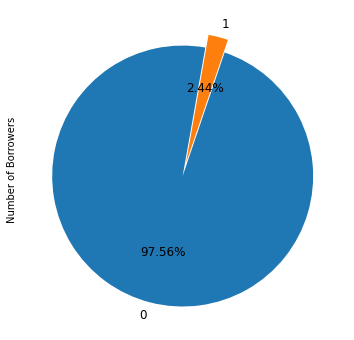

In [ ]:
# How many observations are for the mortgage and how many are not?
absolut = data.default_time.value_counts().to_frame().rename(columns={"default_time":"Number of Borrowers"})
percent = (data.default_time.value_counts(normalize=True)*100).to_frame().rename(columns={"default_time":"%"})
data_bal = pd.concat([absolut,percent],axis=1).round(decimals=2)
print("")
print(f"[0] Number of borrowers that are not in default of loan repayment : ... {data.default_time.value_counts()[0]}")
print(f"[1] Number of borrowers that are in default of loan repayment: ....... {data.default_time.value_counts()[1]}")
print("")
display(data_bal)
absolut.plot(kind='pie', subplots=True, autopct='%1.2f%%', 
             explode= (0.05, 0.05), startangle=80, 
             legend=False, fontsize=12, figsize=(14,6));

the dataset is highlight imbalanced. the value 0 is much greater than the value 1. 



We consider only the last time observation for each borrower 

In [ ]:
# remove observations and keep the last time observation for each borrower
data = data.drop_duplicates(subset=['id'], keep = 'last')

In [ ]:
data.head()

id  time  orig_time  ...  default_time  payoff_time  status_time
23   1    48         -7  ...             1            0            1
25   2    26         18  ...             0            1            2
30   3    29         -6  ...             0            1            2
65   4    60         -2  ...             0            0            0
68   5    27         18  ...             0            1            2

[5 rows x 23 columns]

### Basic info of the dataset

In [ ]:
# Printing number of observations, variables including the target, and duplicate samples
print(f"Number of observations: .............. {data.shape[0]}") # Number of observations
print(f"Number of variables: ............ {data.shape[1]} incl. target") # Number of variables or attributes
print(f"Number of duplicate entries: .... {data.duplicated().sum()}")

Number of observations: .............. 50000
Number of variables: ............ 23 incl. target
Number of duplicate entries: .... 0



[0] Number of borrowers that are not in default of loan repayment: ... 34846
[1] Number of borrowers that are in default of loan repayment : ....... 15154



Number of borrowers      %
0                34846  69.69
1                15154  30.31

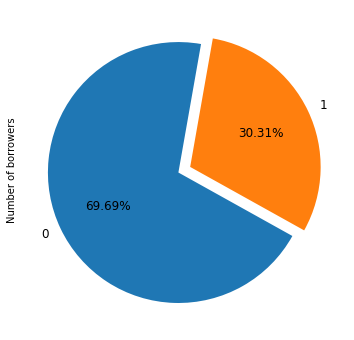

In [ ]:
# How many observations are for the mortgage and how many are not?
absolut = data.default_time.value_counts().to_frame().rename(columns={"default_time":"Number of borrowers"})
percent = (data.default_time.value_counts(normalize=True)*100).to_frame().rename(columns={"default_time":"%"})
data_bal = pd.concat([absolut,percent],axis=1).round(decimals=2)
print("")
print(f"[0] Number of borrowers that are not in default of loan repayment: ... {data.default_time.value_counts()[0]}")
print(f"[1] Number of borrowers that are in default of loan repayment : ....... {data.default_time.value_counts()[1]}")
print("")
display(data_bal)
absolut.plot(kind='pie', subplots=True, autopct='%1.2f%%', 
             explode= (0.05, 0.05), startangle=80, 
             legend=False, fontsize=12, figsize=(14,6));

From this graph, we see that the imbalance in the class distribution is reduced 

Text(0.5, 0, 'Target class')

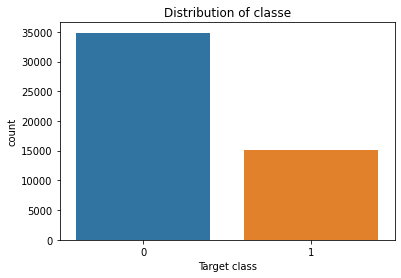

In [ ]:
# visualization
sns.countplot(x='default_time', data=data)
plt.title('Distribution of classe')
plt.xlabel('Target class')

- Display default_time variable with the variables time

Text(0.5, 1.05, 'default_time variable at observation time')

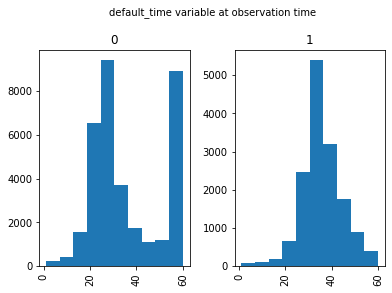

In [ ]:
# target variable with observation time
data.hist(column="time", by="default_time")
plt.suptitle('default_time variable at observation time', y=1.05)

Text(0.5, 1.05, 'default_time variable based at first time observation')

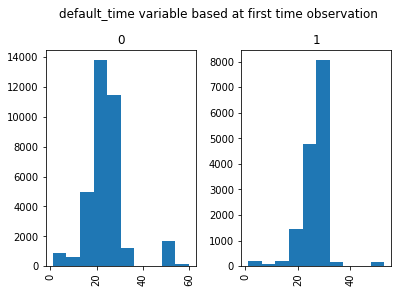

In [ ]:
# default time with first time observation
data.hist(column="first_time", by="default_time")
plt.suptitle('default_time variable based at first time observation', y=1.05)

Text(0.5, 1.05, 'default_time variable at origination time')

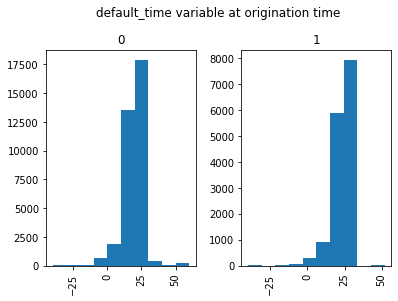

In [ ]:
# target variable with origination time
data.hist(column="orig_time", by="default_time")
plt.suptitle('default_time variable at origination time', y=1.05)

Text(0.5, 1.05, 'default_time variable at maturity time')

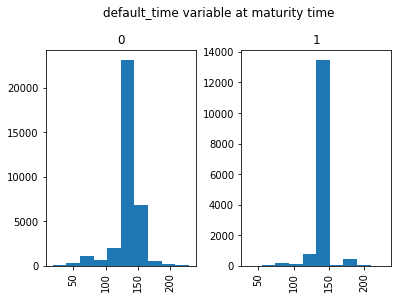

In [ ]:
# default time with maturity time variable
data.hist(column="mat_time", by="default_time")
plt.suptitle('default_time variable at maturity time', y=1.05)

In [ ]:
# Finding unique data
data.apply(lambda x: len(x.unique()))

id                         50000
time                          60
orig_time                     98
first_time                    50
mat_time                     200
balance_time               46363
LTV_time                   46323
interest_rate_time          2742
hpi_time                      60
gdp_time                      60
uer_time                      36
REtype_CO_orig_time            2
REtype_PU_orig_time            2
REtype_SF_orig_time            2
investor_orig_time             2
balance_orig_time          10691
FICO_orig_time               397
LTV_orig_time                552
Interest_Rate_orig_time     1704
hpi_orig_time                 97
default_time                   2
payoff_time                    2
status_time                    3
dtype: int64

In [ ]:
# Type of variables
data.dtypes.sort_values(ascending=True)

id                           int64
default_time                 int64
FICO_orig_time               int64
investor_orig_time           int64
REtype_SF_orig_time          int64
REtype_PU_orig_time          int64
payoff_time                  int64
REtype_CO_orig_time          int64
mat_time                     int64
first_time                   int64
orig_time                    int64
time                         int64
status_time                  int64
hpi_time                   float64
gdp_time                   float64
uer_time                   float64
LTV_time                   float64
balance_time               float64
balance_orig_time          float64
LTV_orig_time              float64
Interest_Rate_orig_time    float64
hpi_orig_time              float64
interest_rate_time         float64
dtype: object

In [ ]:
# Counting variables by type
data.dtypes.value_counts(ascending=True)

float64    10
int64      13
dtype: int64

In [ ]:
# Detecting missing values
display(data.isnull().sum())
print("")
print(f"Are there any missing values? {data.isnull().values.any()}")

id                          0
time                        0
orig_time                   0
first_time                  0
mat_time                    0
balance_time                0
LTV_time                   18
interest_rate_time          0
hpi_time                    0
gdp_time                    0
uer_time                    0
REtype_CO_orig_time         0
REtype_PU_orig_time         0
REtype_SF_orig_time         0
investor_orig_time          0
balance_orig_time           0
FICO_orig_time              0
LTV_orig_time               0
Interest_Rate_orig_time     0
hpi_orig_time               0
default_time                0
payoff_time                 0
status_time                 0
dtype: int64


Are there any missing values? True


In [ ]:
# Overview of shape, attributes, types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 23 to 622488
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       50000 non-null  int64  
 1   time                     50000 non-null  int64  
 2   orig_time                50000 non-null  int64  
 3   first_time               50000 non-null  int64  
 4   mat_time                 50000 non-null  int64  
 5   balance_time             50000 non-null  float64
 6   LTV_time                 49982 non-null  float64
 7   interest_rate_time       50000 non-null  float64
 8   hpi_time                 50000 non-null  float64
 9   gdp_time                 50000 non-null  float64
 10  uer_time                 50000 non-null  float64
 11  REtype_CO_orig_time      50000 non-null  int64  
 12  REtype_PU_orig_time      50000 non-null  int64  
 13  REtype_SF_orig_time      50000 non-null  int64  
 14  investor_orig_time  

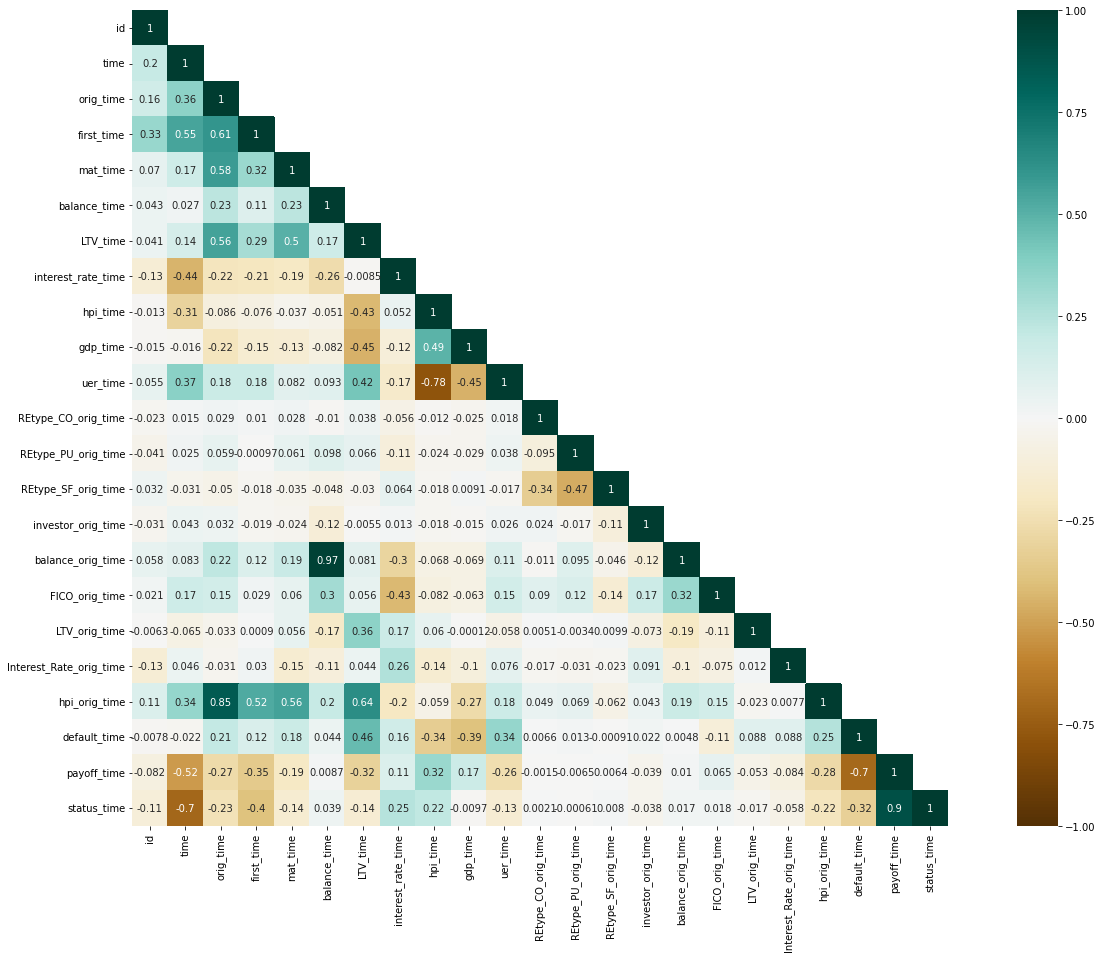

In [ ]:
# Visualization of correlations
mask = np.triu(data.corr(), 1)
plt.figure(figsize=(25, 15))
sns.heatmap(data.corr(), annot=True, vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

### Statistic description of all variables and visualisation

In [ ]:
# General stats of variables
data.describe().T

count           mean  ...            75%           max
id                       50000.0   25000.500000  ...   37500.250000  5.000000e+04
time                     50000.0      36.170740  ...      46.000000  6.000000e+01
orig_time                50000.0      20.388240  ...      25.000000  6.000000e+01
first_time               50000.0      24.696100  ...      28.000000  6.000000e+01
mat_time                 50000.0     137.923620  ...     145.000000  2.290000e+02
balance_time             50000.0  238972.292454  ...  319566.747500  8.688101e+06
LTV_time                 49982.0      79.312091  ...      95.745375  6.169851e+02
interest_rate_time       50000.0       7.014623  ...       8.350000  3.750000e+01
hpi_time                 50000.0     190.291879  ...     217.370000  2.262900e+02
gdp_time                 50000.0       1.690324  ...       2.836358  5.132464e+00
uer_time                 50000.0       6.000876  ...       6.500000  1.000000e+01
REtype_CO_orig_time      50000.0       0.064960  ...       0.000000  1.000000e+00
REtype_PU_orig_time      50000.0       0.115880  ...       0.000000  1.000000e+00
REtype_SF_orig_time      50000.0       0.623740  ...       1.000000  1.000000e+00
investor_orig_time       50000.0       0.118400  ...       0.000000  1.000000e+00
balance_orig_time        50000.0  251976.876960  ...  335000.000000  8.000000e+06
FICO_orig_time           50000.0     661.297200  ...     715.000000  8.400000e+02
LTV_orig_time            50000.0      79.707362  ...      85.000000  2.185000e+02
Interest_Rate_orig_time  50000.0       5.442125  ...       7.625000  1.975000e+01
hpi_orig_time            50000.0     196.366771  ...     222.390000  2.262900e+02
default_time             50000.0       0.303080  ...       1.000000  1.000000e+00
payoff_time              50000.0       0.531780  ...       1.000000  1.000000e+00
status_time              50000.0       1.366640  ...       2.000000  2.000000e+00

[23 rows x 8 columns]

In [ ]:
# Create list of features
int_features = list(data.select_dtypes('int64').columns)
float_features = list(data.select_dtypes('float64').columns)

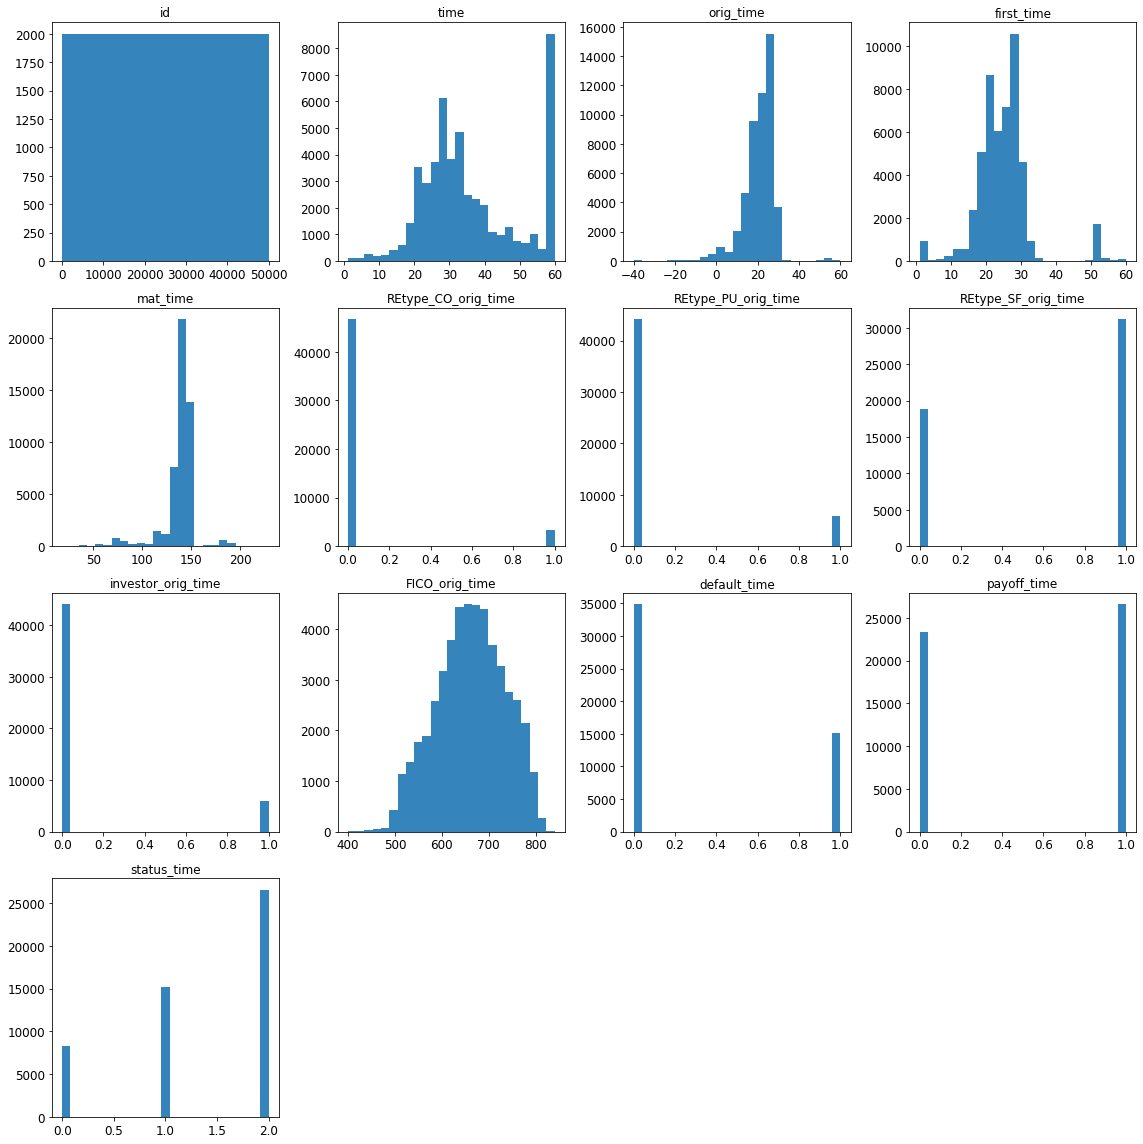

In [ ]:
# Visualization of the integer distribution
data[int_features].hist(figsize=(16,16), bins=25, xlabelsize=12, ylabelsize=12, alpha=0.9, grid=False) 
plt.tight_layout();

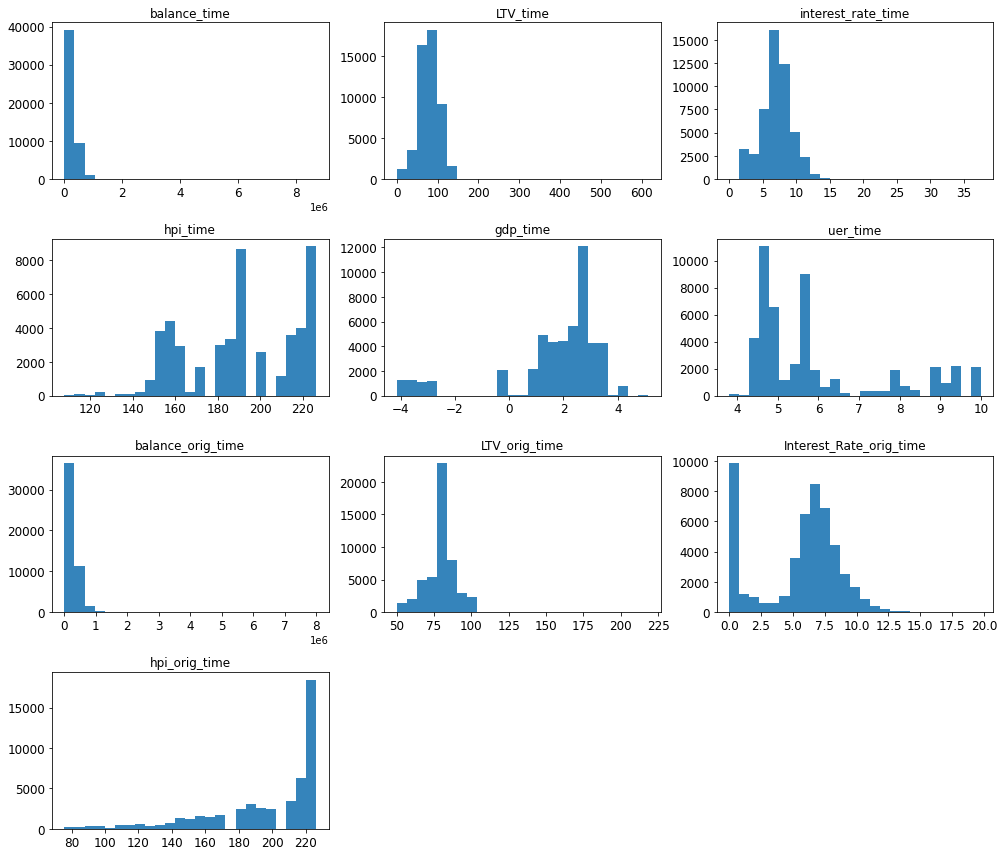

In [ ]:
# Visualization of the float distribution
data[float_features].hist(figsize=(14,12), bins=25, xlabelsize=12, ylabelsize=12, alpha=0.9, grid=False) 
plt.tight_layout();

## **Data Cleaning & Feature Selection**




### Correlation

In [ ]:
# drop the NA Values
data = data.dropna(subset=['LTV_time'])

from the above correlation table, the relationship between variables payoff and status time are very strong ( corr = 0.93) . Therefore these variables have to be droped in the dataset

In [ ]:
# drop payoff and status columns
columns = ["payoff_time", "status_time"]
data.drop(columns, axis=1, inplace=True)

In [ ]:
# Subdivision of target
y = data.default_time
X = data.drop(["default_time"], axis = "columns")

In [ ]:
# The numeric most correlated with the target (Pearson)
pearson = data.corr()
corr_target = pearson.default_time
display(corr_target.sort_values(ascending=False))
print("")
print("Ordered by rank in absolute values")
display(corr_target.abs().sort_values(ascending=False))

default_time               1.000000
LTV_time                   0.462710
uer_time                   0.336117
hpi_orig_time              0.250982
orig_time                  0.210044
mat_time                   0.181288
interest_rate_time         0.158681
first_time                 0.121256
Interest_Rate_orig_time    0.087861
LTV_orig_time              0.087627
balance_time               0.043953
investor_orig_time         0.022325
REtype_PU_orig_time        0.013083
REtype_CO_orig_time        0.006634
balance_orig_time          0.004744
REtype_SF_orig_time       -0.000835
id                        -0.007800
time                      -0.021971
FICO_orig_time            -0.111703
hpi_time                  -0.341793
gdp_time                  -0.391066
Name: default_time, dtype: float64


Ordered by rank in absolute values


default_time               1.000000
LTV_time                   0.462710
gdp_time                   0.391066
hpi_time                   0.341793
uer_time                   0.336117
hpi_orig_time              0.250982
orig_time                  0.210044
mat_time                   0.181288
interest_rate_time         0.158681
first_time                 0.121256
FICO_orig_time             0.111703
Interest_Rate_orig_time    0.087861
LTV_orig_time              0.087627
balance_time               0.043953
investor_orig_time         0.022325
time                       0.021971
REtype_PU_orig_time        0.013083
id                         0.007800
REtype_CO_orig_time        0.006634
balance_orig_time          0.004744
REtype_SF_orig_time        0.000835
Name: default_time, dtype: float64

In [ ]:
# Identifying all variables with great predictive power (Pearson Correlation p-value)
dataframe = pd.DataFrame(
    [scipy.stats.pearsonr(X[col], y) for col in X.columns],
    columns=["Pearson Corr.", "p-value"],
    index=X.columns,
).round(2)

display(dataframe)

Pearson Corr.  p-value
id                               -0.01     0.08
time                             -0.02     0.00
orig_time                         0.21     0.00
first_time                        0.12     0.00
mat_time                          0.18     0.00
balance_time                      0.04     0.00
LTV_time                          0.46     0.00
interest_rate_time                0.16     0.00
hpi_time                         -0.34     0.00
gdp_time                         -0.39     0.00
uer_time                          0.34     0.00
REtype_CO_orig_time               0.01     0.14
REtype_PU_orig_time               0.01     0.00
REtype_SF_orig_time              -0.00     0.85
investor_orig_time                0.02     0.00
balance_orig_time                 0.00     0.29
FICO_orig_time                   -0.11     0.00
LTV_orig_time                     0.09     0.00
Interest_Rate_orig_time           0.09     0.00
hpi_orig_time                     0.25     0.00

Strategy: Remove variables 'id', 'REtype_CO_orig_time', 'REtype_SF_orig_time', 'balance_orig_time' (p-value > 0.05).

In [ ]:
# Identifying columns in which p-value > 0.05
column = []
for item in dataframe.index:
    if dataframe['p-value'][item] >= 0.05:
        column.append(item)

In [ ]:
# Removing statistically non significant columns
data.drop(column, axis=1, inplace=True)

### Outliers detection

In [ ]:
# Removing target and making a copy
data_drop = data.drop(["default_time"], axis=1).copy()

In [ ]:
# check Outliers
for column in data_drop.columns:
    median = data_drop[column].quantile()
    iqr_1_5 = (data_drop[column].quantile(q = 0.75) - data_drop[column].quantile(q = 0.25)) * 1.5
    outliers = data_drop[(data_drop[column]< median - iqr_1_5) | (data_drop[column] > median + iqr_1_5)][column].count()
    outliers_pct = round(outliers / data_drop[column].count() * 100, 1)
    print("'{}' = {} ({}%) outliers".format(column, outliers, outliers_pct))

'time' = 22 (0.0%) outliers
'orig_time' = 3744 (7.5%) outliers
'first_time' = 3854 (7.7%) outliers
'mat_time' = 6673 (13.4%) outliers
'balance_time' = 4292 (8.6%) outliers
'LTV_time' = 2901 (5.8%) outliers
'interest_rate_time' = 6560 (13.1%) outliers
'hpi_time' = 0 (0.0%) outliers
'gdp_time' = 6936 (13.9%) outliers
'uer_time' = 7793 (15.6%) outliers
'REtype_PU_orig_time' = 5793 (11.6%) outliers
'investor_orig_time' = 5920 (11.8%) outliers
'FICO_orig_time' = 761 (1.5%) outliers
'LTV_orig_time' = 6568 (13.1%) outliers
'Interest_Rate_orig_time' = 96 (0.2%) outliers
'hpi_orig_time' = 5397 (10.8%) outliers


from the detection of outliers, the most severe case being the uer_time column with almost 16% of the selected data.  the data seems to have been measured correctly and reflects reality, these variables therefore can be keep. To emphasize that the model is not affected by the extension of the number of outliers, a standardization technique can be used 

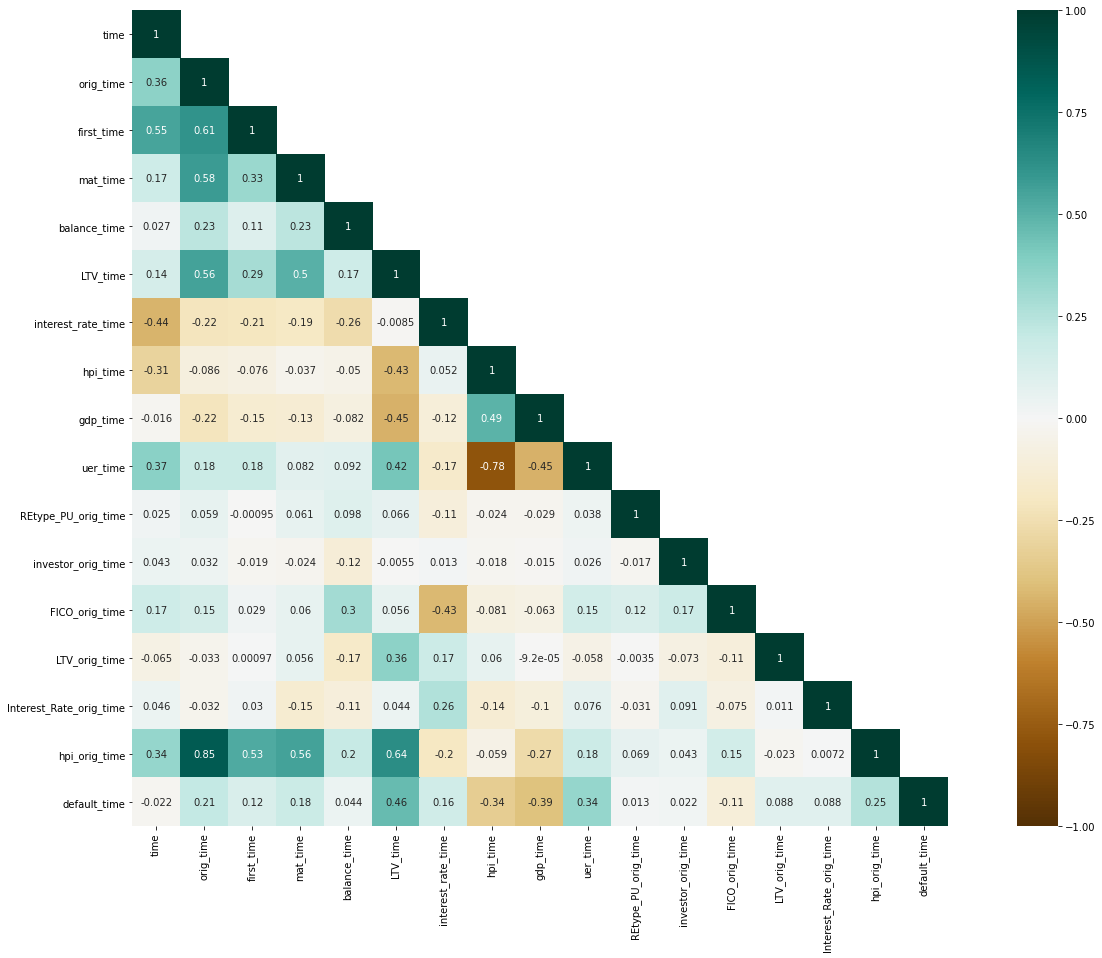

In [ ]:
# Visualization of correlations
mask = np.triu(data.corr(), 1)
plt.figure(figsize=(25, 15))
sns.heatmap(data.corr(), annot=True, vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

'LTV_time' is the most correlated with the target followed by 'gdp_time', 'uer_time', and 'hpi_orig_time' and at the same time, the strength of their relationships with the target is very low.

## **Statistic description of variables and visualisation**

Let's now make some interpretations and take some preliminary conclusions about the dataset in order to have a clear and more accurate sense about the data.

In [ ]:
# General stats of significant variables
data.describe().T

count           mean  ...            75%           max
time                     49982.0      36.169181  ...      46.000000  6.000000e+01
orig_time                49982.0      20.393682  ...      25.000000  6.000000e+01
first_time               49982.0      24.695450  ...      28.000000  6.000000e+01
mat_time                 49982.0     137.931755  ...     145.000000  2.290000e+02
balance_time             49982.0  239045.177936  ...  319599.080000  8.688101e+06
LTV_time                 49982.0      79.312091  ...      95.745375  6.169851e+02
interest_rate_time       49982.0       7.013339  ...       8.350000  3.750000e+01
hpi_time                 49982.0     190.288669  ...     217.370000  2.262900e+02
gdp_time                 49982.0       1.690157  ...       2.836358  5.132464e+00
uer_time                 49982.0       6.001022  ...       6.500000  1.000000e+01
REtype_PU_orig_time      49982.0       0.115902  ...       0.000000  1.000000e+00
investor_orig_time       49982.0       0.118443  ...       0.000000  1.000000e+00
FICO_orig_time           49982.0     661.337161  ...     715.000000  8.400000e+02
LTV_orig_time            49982.0      79.708497  ...      85.000000  2.185000e+02
Interest_Rate_orig_time  49982.0       5.442932  ...       7.625000  1.975000e+01
hpi_orig_time            49982.0     196.394224  ...     222.390000  2.262900e+02
default_time             49982.0       0.303089  ...       1.000000  1.000000e+00

[17 rows x 8 columns]

### Variable: **time**

In [ ]:
# General stats description
stats_time = {'Designation': ['Value'],
            'Variable': 'time',
            'Description': 'observation time',
            'Type of variable': data.time.dtype,
            'Type of distribution': 'continuous',
            'Total observations': data.time.shape[0],
            'Missing values': data.time.isnull().sum(),
            'Unique values': data.time.nunique(),
            'Min': data.time.min(),
            '25%': int(data.time.quantile(q=[.25]).iloc[-1]),
            'Median': data.time.median(),
            '75%': int(data.time.quantile(q=[.75]).iloc[-1]),
            'Max': data.time.max(),
            'Mean': data.time.mean(),
            'Std dev': data.time.std(),
            'Variance': data.time.var(),
            'Skewness': scipy.stats.skew(data.time),
            'Kurtosis': scipy.stats.kurtosis(data.time)
           }
st_time = pd.DataFrame(stats_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_time.set_index("Designation", inplace=True)

results = st_time.T
resultsT = st_time
display(results)

Designation                      Value
Variable                          time
Description           observation time
Type of variable                 int64
Type of distribution        continuous
Total observations               49982
Missing values                       0
Unique values                       60
Min                                  1
25%                                 26
Median                              32
75%                                 46
Max                                 60
Mean                           36.1692
Std dev                        13.9925
Variance                       195.789
Skewness                      0.482605
Kurtosis                     -0.772846

In [ ]:
# Calculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     9.0
0.05    18.0
0.95    60.0
0.99    60.0
Name: time, dtype: float64

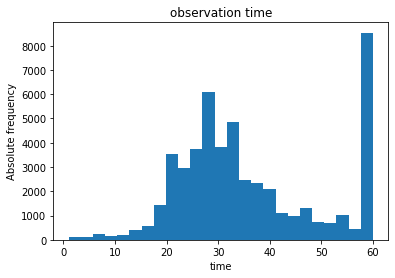

In [ ]:
# Visualization of 'time'
plt.hist(data.time, bins=25)
plt.title('observation time', fontsize=12)
plt.xlabel('time')
plt.ylabel('Absolute frequency')
plt.show()

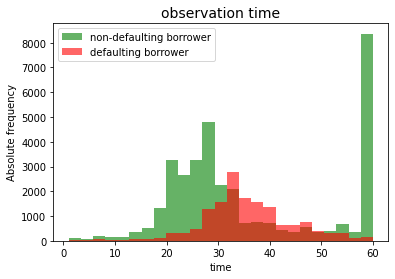

In [ ]:
# Visualization variable vs. target
id_0 = data[data.default_time == 0].iloc[:,:1]
id_1 = data[data.default_time == 1].iloc[:,:1]

a = np.array(id_0)
b = np.array(id_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.6, label='non-defaulting borrower')
plt.hist(b, bins=25, density= False, color="r", alpha = 0.6, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('observation time', fontsize=14)
plt.xlabel('time')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

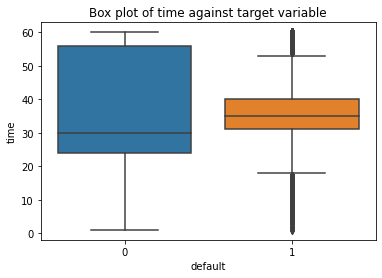

In [ ]:
sns.boxplot(y='time', x='default_time', data=data)
plt.title('Box plot of time against target variable')
plt.xlabel('default')

### Variable: **Orig_time**

In [ ]:
# General stats description
stats_time = {'Designation': ['Value'],
            'Variable': 'origination time',
            'Description': 'the origination period',
            'Type of variable': data.orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.orig_time.shape[0],
            'Missing values': data.orig_time.isnull().sum(),
            'Unique values': data.orig_time.nunique(),
            'Min': data.orig_time.min(),
            '25%': int(data.orig_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.orig_time.median(),
            '75%': int(data.orig_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.orig_time.max(),
            'Mean': data.orig_time.mean(),
            'Std dev': data.orig_time.std(),
            'Variance': data.orig_time.var(),
            'Skewness': scipy.stats.skew(data.orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.orig_time)
           }
st_time = pd.DataFrame(stats_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_time.set_index("Designation", inplace=True)

results = st_time.T
resultsT = st_time
display(results)

Designation                            Value
Variable                    origination time
Description           the origination period
Type of variable                       int64
Type of distribution                discrete
Total observations                     49982
Missing values                             0
Unique values                             98
Min                                      -40
25%                                       17
Median                                    22
75%                                       25
Max                                       60
Mean                                 20.3937
Std dev                               7.8772
Variance                             62.0502
Skewness                            -1.50792
Kurtosis                             9.62516

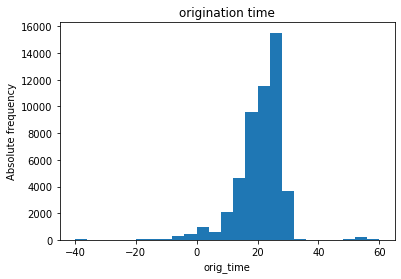

In [ ]:
# Visualization of 'orig time'
plt.hist(data.orig_time, bins=25)
plt.title('origination time', fontsize=12)
plt.xlabel('orig_time')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.orig_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01    -5.0
0.05     7.0
0.95    28.0
0.99    31.0
Name: orig_time, dtype: float64

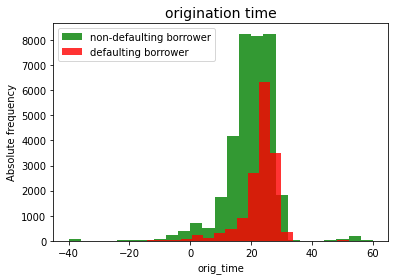

In [ ]:
# Visualization variable vs. target
time_0 = data[data.default_time == 0].iloc[:,1:2]
time_1 = data[data.default_time == 1].iloc[:,1:2]

a = np.array(time_0)
b = np.array(time_1)

np.warnings.filterwarnings('ignore')
plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('origination time', fontsize=14)
plt.xlabel('orig_time')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

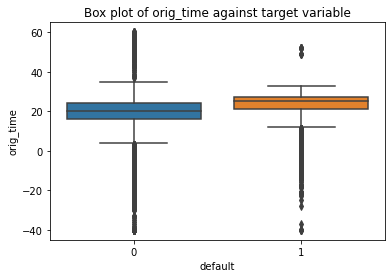

In [ ]:
sns.boxplot(y='orig_time', x='default_time', data=data)
plt.title('Box plot of orig_time against target variable')
plt.xlabel('default')

### Variable: **First_time**

In [ ]:
# General stats description
stats_time = {'Designation': ['Value'],
            'Variable': 'first_time',
            'Description': 'the first observation period',
            'Type of variable': data.first_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.first_time.shape[0],
            'Missing values': data.first_time.isnull().sum(),
            'Unique values': data.first_time.nunique(),
            'Min': data.first_time.min(),
            '25%': int(data.first_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.first_time.median(),
            '75%': int(data.first_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.first_time.max(),
            'Mean': data.first_time.mean(),
            'Std dev': data.first_time.std(),
            'Variance': data.first_time.var(),
            'Skewness': scipy.stats.skew(data.first_time),
            'Kurtosis': scipy.stats.kurtosis(data.first_time)
           }
st_time = pd.DataFrame(stats_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_time.set_index("Designation", inplace=True)

results = st_time.T
resultsT = st_time
display(results)

Designation                                  Value
Variable                                first_time
Description           the first observation period
Type of variable                             int64
Type of distribution                      discrete
Total observations                           49982
Missing values                                   0
Unique values                                   50
Min                                              1
25%                                             20
Median                                          25
75%                                             28
Max                                             60
Mean                                       24.6955
Std dev                                    7.89894
Variance                                   62.3933
Skewness                                   1.11654
Kurtosis                                   4.92385

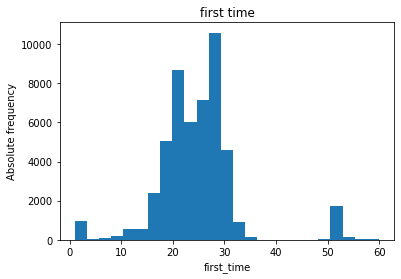

In [ ]:
# Visualization of 'time'
plt.hist(data.first_time, bins=25)
plt.title('first time', fontsize=12)
plt.xlabel('first_time')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.first_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     2.0
0.05    16.0
0.95    32.0
0.99    52.0
Name: first_time, dtype: float64

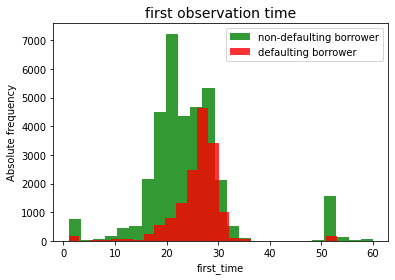

In [ ]:
# Visualization variable vs. target
time_0 = data[data.default_time == 0].iloc[:,2:3]
time_1 = data[data.default_time == 1].iloc[:,2:3]

a = np.array(time_0)
b = np.array(time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower ')
plt.legend(loc='upper right')
plt.title('first observation time', fontsize=14)
plt.xlabel('first_time')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

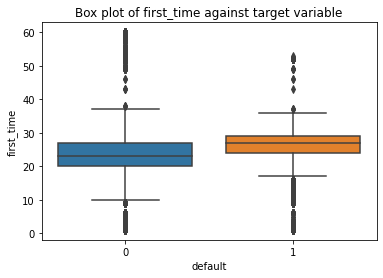

In [ ]:
sns.boxplot(y='first_time', x='default_time', data=data)
plt.title('Box plot of first_time against target variable')
plt.xlabel('default')

### Variable: **Mat_time**

In [ ]:
# General stats description
stats_time = {'Designation': ['Value'],
            'Variable': 'mat_time',
            'Description': 'the maturity period',
            'Type of variable': data.mat_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.mat_time.shape[0],
            'Missing values': data.mat_time.isnull().sum(),
            'Unique values': data.mat_time.nunique(),
            'Min': data.mat_time.min(),
            '25%': int(data.mat_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.mat_time.median(),
            '75%': int(data.mat_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.mat_time.max(),
            'Mean': data.mat_time.mean(),
            'Std dev': data.mat_time.std(),
            'Variance': data.mat_time.var(),
            'Skewness': scipy.stats.skew(data.mat_time),
            'Kurtosis': scipy.stats.kurtosis(data.mat_time)
           }
st_time = pd.DataFrame(stats_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_time.set_index("Designation", inplace=True)

results = st_time.T
resultsT = st_time
display(results)

Designation                         Value
Variable                         mat_time
Description           the maturity period
Type of variable                    int64
Type of distribution             discrete
Total observations                  49982
Missing values                          0
Unique values                         200
Min                                    18
25%                                   136
Median                                141
75%                                   145
Max                                   229
Mean                              137.932
Std dev                            17.937
Variance                          321.735
Skewness                         -2.01297
Kurtosis                          9.28894

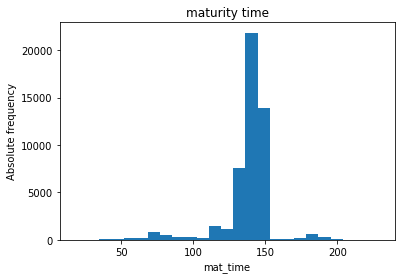

In [ ]:
# Visualization of 'time'
plt.hist(data.mat_time, bins=25)
plt.title('maturity time', fontsize=12)
plt.xlabel('mat_time')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.mat_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     66.0
0.05    106.0
0.95    149.0
0.99    186.0
Name: mat_time, dtype: float64

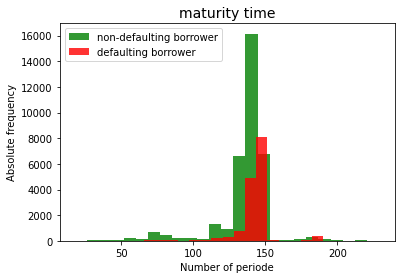

In [ ]:
# Visualization variable vs. target
time_0 = data[data.default_time == 0].iloc[:,3:4]
time_1 = data[data.default_time == 1].iloc[:,3:4]

a = np.array(time_0)
b = np.array(time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('maturity time', fontsize=14)
plt.xlabel('Number of periode')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

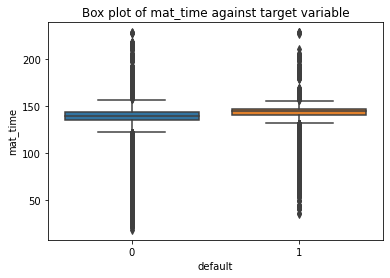

In [ ]:
sns.boxplot(y='mat_time', x='default_time', data=data)
plt.title('Box plot of mat_time against target variable')
plt.xlabel('default')

### Variable: **balance time**

In [ ]:
# General stats description
balance_time = {'Designation': ['Value'],
            'Variable': 'balance_time',
            'Description': 'the amount of the loan',
            'Type of variable': data.balance_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.balance_time.shape[0],
            'Missing values': data.balance_time.isnull().sum(),
            'Unique values': data.balance_time.nunique(),
            'Min': data.balance_time.min(),
            '25%': int(data.balance_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.balance_time.median(),
            '75%': int(data.balance_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.balance_time.max(),
            'Mean': data.balance_time.mean(),
            'Std dev': data.balance_time.std(),
            'Variance': data.balance_time.var(),
            'Skewness': scipy.stats.skew(data.balance_time),
            'Kurtosis': scipy.stats.kurtosis(data.balance_time)
           }
st_time = pd.DataFrame(balance_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_time.set_index("Designation", inplace=True)

results = st_time.T
resultsT = st_time
display(results)

Designation                            Value
Variable                        balance_time
Description           the amount of the loan
Type of variable                     float64
Type of distribution                discrete
Total observations                     49982
Missing values                             0
Unique values                          46346
Min                                        0
25%                                   105928
Median                                183661
75%                                   319599
Max                               8.6881e+06
Mean                                  239045
Std dev                               203091
Variance                         4.12459e+10
Skewness                             4.55581
Kurtosis                             97.4559

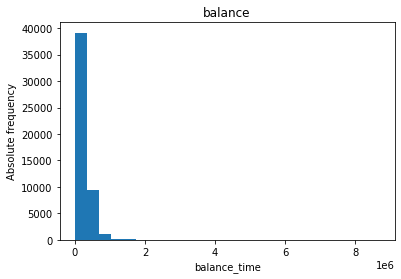

In [ ]:
# Visualization of 'balance_time'
plt.hist(data.balance_time, bins=25)
plt.title('balance', fontsize=12)
plt.xlabel('balance_time')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.balance_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01      3311.9225
0.05     45358.6380
0.95    590277.8355
0.99    948457.6933
Name: balance_time, dtype: float64

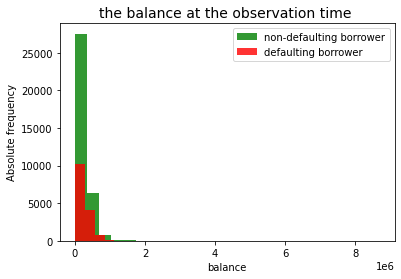

In [ ]:
# Visualization variable vs. target
balance_time_0 = data[data.default_time == 0].iloc[:,4:5]
balance_time_1 = data[data.default_time == 1].iloc[:,4:5]

a = np.array(balance_time_0)
b = np.array(balance_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper right')
plt.title('the balance at the observation time ', fontsize=14)
plt.xlabel('balance')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

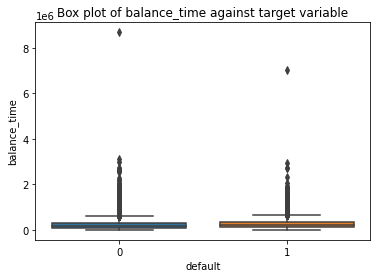

In [ ]:
sns.boxplot(y='balance_time', x='default_time', data=data)
plt.title('Box plot of balance_time against target variable')
plt.xlabel('default')

### Variable: **LTV_time**

In [ ]:
# General stats description
stats_ltv_time = {'Designation': ['Value'],
            'Variable': 'LTV_time',
            'Description': 'the loan to value ratio',
            'Type of variable': data.LTV_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.LTV_time.shape[0],
            'Missing values': data.LTV_time.isnull().sum(),
            'Unique values': data.LTV_time.nunique(),
            'Min': data.LTV_time.min(),
            '25%': int(data.LTV_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.LTV_time.median(),
            '75%': int(data.LTV_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.LTV_time.max(),
            'Mean': data.LTV_time.mean(),
            'Std dev': data.LTV_time.std(),
            'Variance': data.LTV_time.var(),
            'Skewness': scipy.stats.skew(data.LTV_time),
            'Kurtosis': scipy.stats.kurtosis(data.LTV_time)
           }
st_ltv_time = pd.DataFrame(stats_ltv_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_ltv_time.set_index("Designation", inplace=True)

results = st_ltv_time.T
resultsT = st_ltv_time
display(results)

Designation                             Value
Variable                             LTV_time
Description           the loan to value ratio
Type of variable                      float64
Type of distribution                 discrete
Total observations                      49982
Missing values                              0
Unique values                           46322
Min                                         0
25%                                        64
Median                                78.7189
75%                                        95
Max                                   616.985
Mean                                  79.3121
Std dev                               25.1328
Variance                              631.656
Skewness                           0.00204507
Kurtosis                              4.66984

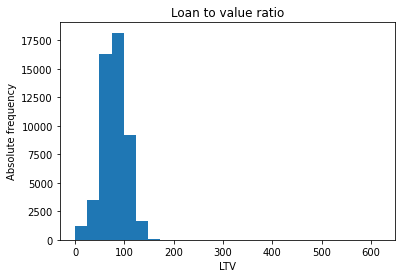

In [ ]:
# Visualization of 'LTV_time'
plt.hist(data.LTV_time, bins=25)
plt.title('Loan to value ratio', fontsize=12)
plt.xlabel('LTV')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.LTV_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01      2.744507
0.05     39.497562
0.95    119.202934
0.99    135.524130
Name: LTV_time, dtype: float64

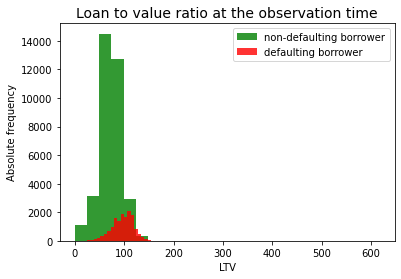

In [ ]:
# Visualization variable vs. target
LTV_time_0 = data[data.default_time == 0].iloc[:,5:6]
LTV_time_1 = data[data.default_time == 1].iloc[:,5:6]

a = np.array(LTV_time_0)
b = np.array(LTV_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density= False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density= False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper right')
plt.title('Loan to value ratio at the observation time', fontsize=14)
plt.xlabel('LTV')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

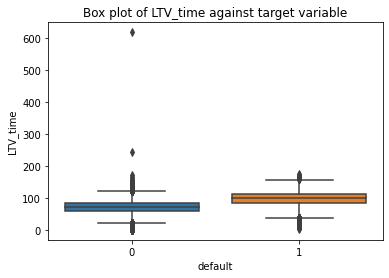

In [ ]:
sns.boxplot(y='LTV_time', x='default_time', data=data)
plt.title('Box plot of LTV_time against target variable')
plt.xlabel('default')

### Variable: **Interest_rate_time**

In [ ]:
# General stats description
stats_interest_rate_time = {'Designation': ['Value'],
            'Variable': 'interest_rate_time',
            'Description': 'the interest rate',
            'Type of variable': data.interest_rate_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.interest_rate_time.shape[0],
            'Missing values': data.interest_rate_time.isnull().sum(),
            'Unique values': data.interest_rate_time.nunique(),
            'Min': data.interest_rate_time.min(),
            '25%': int(data.interest_rate_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.interest_rate_time.median(),
            '75%': int(data.interest_rate_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.interest_rate_time.max(),
            'Mean': data.interest_rate_time.mean(),
            'Std dev': data.interest_rate_time.std(),
            'Variance': data.interest_rate_time.var(),
            'Skewness': scipy.stats.skew(data.interest_rate_time),
            'Kurtosis': scipy.stats.kurtosis(data.interest_rate_time)
           }
st_interest_rate_time = pd.DataFrame(stats_interest_rate_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_interest_rate_time.set_index("Designation", inplace=True)

results = st_interest_rate_time.T
resultsT = st_interest_rate_time
display(results)

Designation                        Value
Variable              interest_rate_time
Description            the interest rate
Type of variable                 float64
Type of distribution            discrete
Total observations                 49982
Missing values                         0
Unique values                       2742
Min                                    0
25%                                    5
Median                                 7
75%                                    8
Max                                 37.5
Mean                             7.01334
Std dev                          2.21293
Variance                         4.89707
Skewness                        0.081435
Kurtosis                         2.40114

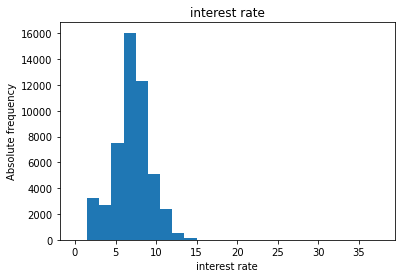

In [ ]:
# Visualization of 'interest_rate_time'
plt.hist(data.interest_rate_time, bins=25)
plt.title('interest rate', fontsize=12)
plt.xlabel('interest rate')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.interest_rate_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     2.00
0.05     2.75
0.95    10.65
0.99    12.25
Name: interest_rate_time, dtype: float64

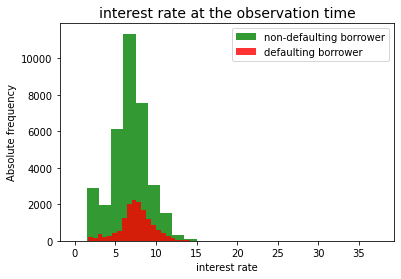

In [ ]:
# Visualization variable vs. target
interest_rate_time_0 = data[data.default_time == 0].iloc[:,6:7]
interest_rate_time_1 = data[data.default_time == 1].iloc[:,6:7]

a = np.array(interest_rate_time_0)
b = np.array(interest_rate_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper right')
plt.title('interest rate at the observation time', fontsize=14)
plt.xlabel('interest rate')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

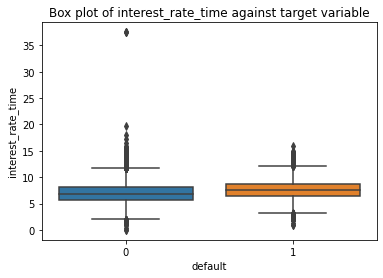

In [ ]:
sns.boxplot(y='interest_rate_time', x='default_time', data=data)
plt.title('Box plot of interest_rate_time against target variable')
plt.xlabel('default')

### Variable: **hpi_time**

In [ ]:
# General stats description
stats_hpi_time = {'Designation': ['Value'],
            'Variable': 'hpi_time',
            'Description': 'the house price index',
            'Type of variable': data.hpi_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.hpi_time.shape[0],
            'Missing values': data.hpi_time.isnull().sum(),
            'Unique values': data.hpi_time.nunique(),
            'Min': data.hpi_time.min(),
            '25%': int(data.hpi_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.hpi_time.median(),
            '75%': int(data.hpi_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.hpi_time.max(),
            'Mean': data.hpi_time.mean(),
            'Std dev': data.hpi_time.std(),
            'Variance': data.hpi_time.var(),
            'Skewness': scipy.stats.skew(data.hpi_time),
            'Kurtosis': scipy.stats.kurtosis(data.hpi_time)
           }
st_hpi_time = pd.DataFrame(stats_hpi_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_hpi_time.set_index("Designation", inplace=True)

results = st_hpi_time.T
resultsT = st_hpi_time
display(results)

Designation                           Value
Variable                           hpi_time
Description           the house price index
Type of variable                    float64
Type of distribution               discrete
Total observations                    49982
Missing values                            0
Unique values                            60
Min                                  107.83
25%                                     162
Median                               189.82
75%                                     217
Max                                  226.29
Mean                                190.289
Std dev                              26.287
Variance                            691.006
Skewness                          -0.272884
Kurtosis                          -0.964865

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.hpi_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01    132.76
0.05    151.48
0.95    225.10
0.99    226.29
Name: hpi_time, dtype: float64

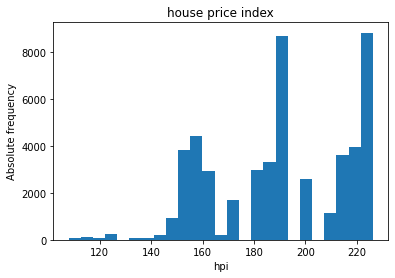

In [ ]:
# Visualization of 'HPI_time'
plt.hist(data.hpi_time, bins=25)
plt.title('house price index', fontsize=12)
plt.xlabel('hpi')
plt.ylabel('Absolute frequency')
plt.show()

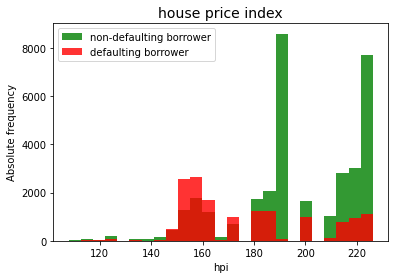

In [ ]:
# Visualization variable vs. target
hpi_time_0 = data[data.default_time == 0].iloc[:,7:8]
hpi_time_1 = data[data.default_time == 1].iloc[:,7:8]

a = np.array(hpi_time_0)
b = np.array(hpi_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('house price index', fontsize=14)
plt.xlabel('hpi')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

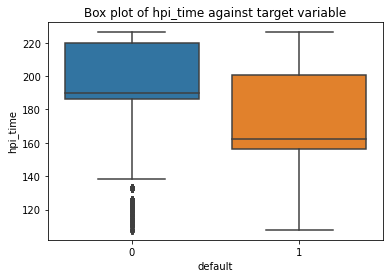

In [ ]:
sns.boxplot(y='hpi_time', x='default_time', data=data)
plt.title('Box plot of hpi_time against target variable')
plt.xlabel('default')

### Variable: **gdp_time**

In [ ]:
# General stats description
stats_gdp_time = {'Designation': ['Value'],
            'Variable': 'gdp_time',
            'Description': 'Gross Domestic Product',
            'Type of variable': data.gdp_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.gdp_time.shape[0],
            'Missing values': data.gdp_time.isnull().sum(),
            'Unique values': data.gdp_time.nunique(),
            'Min': data.gdp_time.min(),
            '25%': int(data.gdp_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.gdp_time.median(),
            '75%': int(data.gdp_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.gdp_time.max(),
            'Mean': data.gdp_time.mean(),
            'Std dev': data.gdp_time.std(),
            'Variance': data.gdp_time.var(),
            'Skewness': scipy.stats.skew(data.gdp_time),
            'Kurtosis': scipy.stats.kurtosis(data.gdp_time)
           }
st_gdp_time = pd.DataFrame(stats_gdp_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_gdp_time.set_index("Designation", inplace=True)

results = st_gdp_time.T
resultsT = st_gdp_time
display(results)

Designation                            Value
Variable                            gdp_time
Description           Gross Domestic Product
Type of variable                     float64
Type of distribution                discrete
Total observations                     49982
Missing values                             0
Unique values                             60
Min                                 -4.14671
25%                                        1
Median                               2.27422
75%                                        2
Max                                  5.13246
Mean                                 1.69016
Std dev                              1.91799
Variance                             3.67869
Skewness                            -1.78395
Kurtosis                             2.47896

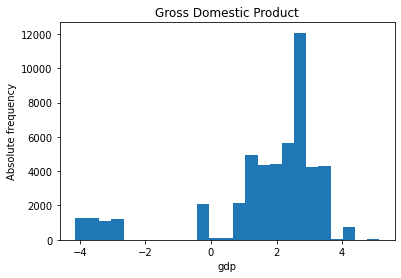

In [ ]:
# Visualization of 'gdp_time'
plt.hist(data.gdp_time, bins=25)
plt.title('Gross Domestic Product', fontsize=12)
plt.xlabel('gdp')
plt.ylabel('Absolute frequency')
plt.show()

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.hpi_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01    132.76
0.05    151.48
0.95    225.10
0.99    226.29
Name: hpi_time, dtype: float64

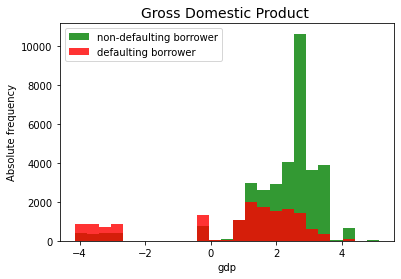

In [ ]:
# Visualization variable vs. target
gdp_time_0 = data[data.default_time == 0].iloc[:,8:9]
gdp_time_1 = data[data.default_time == 1].iloc[:,8:9]

a = np.array(gdp_time_0)
b = np.array(gdp_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('Gross Domestic Product ', fontsize=14)
plt.xlabel('gdp')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

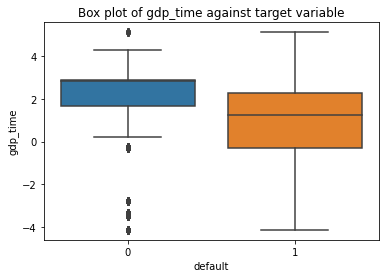

In [ ]:
sns.boxplot(y='gdp_time', x='default_time', data=data)
plt.title('Box plot of gdp_time against target variable')
plt.xlabel('default')

### Variable: **uer_time**

In [ ]:
# General stats description
stats_uer_time = {'Designation': ['Value'],
            'Variable': 'uer_time',
            'Description': 'the unemployment rate of the economy',
            'Type of variable': data.uer_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.uer_time.shape[0],
            'Missing values': data.uer_time.isnull().sum(),
            'Unique values': data.uer_time.nunique(),
            'Min': data.uer_time.min(),
            '25%': int(data.uer_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.uer_time.median(),
            '75%': int(data.uer_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.uer_time.max(),
            'Mean': data.uer_time.mean(),
            'Std dev': data.uer_time.std(),
            'Variance': data.uer_time.var(),
            'Skewness': scipy.stats.skew(data.uer_time),
            'Kurtosis': scipy.stats.kurtosis(data.uer_time)
           }
st_uer_time = pd.DataFrame(stats_uer_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_uer_time.set_index("Designation", inplace=True)

results = st_uer_time.T
resultsT = st_uer_time
display(results)

Designation                                          Value
Variable                                          uer_time
Description           the unemployment rate of the economy
Type of variable                                   float64
Type of distribution                              discrete
Total observations                                   49982
Missing values                                           0
Unique values                                           36
Min                                                    3.8
25%                                                      4
Median                                                 5.5
75%                                                      6
Max                                                     10
Mean                                               6.00102
Std dev                                            1.67463
Variance                                           2.80439
Skewness                                           1.18276
Kurtosis                                        0.00919262

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.uer_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     4.4
0.05     4.5
0.95     9.5
0.99    10.0
Name: uer_time, dtype: float64

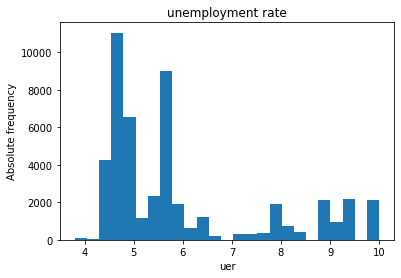

In [ ]:
# Visualization of 'gdp_time'
plt.hist(data.uer_time, bins=25)
plt.title('unemployment rate', fontsize=12)
plt.xlabel('uer')
plt.ylabel('Absolute frequency')
plt.show()

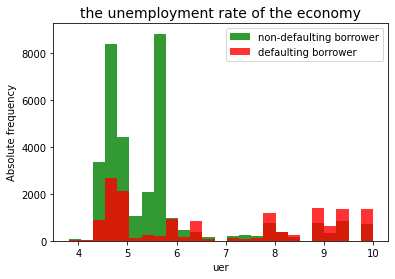

In [ ]:
# Visualization variable vs. target
uer_time_0 = data[data.default_time == 0].iloc[:,9:10]
uer_time_1 = data[data.default_time == 1].iloc[:,9:10]

a = np.array(uer_time_0)
b = np.array(uer_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper right')
plt.title('the unemployment rate of the economy', fontsize=14)
plt.xlabel('uer')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

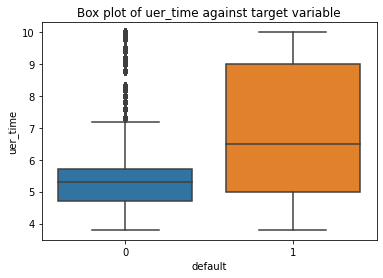

In [ ]:
sns.boxplot(y='uer_time', x='default_time', data=data)
plt.title('Box plot of uer_time against target variable')
plt.xlabel('default')

### Variable: **REtype_PU_orig_time**

In [ ]:
# General stats description
stats_REtype_PU_orig_time = {'Designation': ['Value'],
            'Variable': 'time',
            'Description': 'Real Estate Type',
            'Type of variable': data.REtype_PU_orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.REtype_PU_orig_time.shape[0],
            'Missing values': data.REtype_PU_orig_time.isnull().sum(),
            'Unique values': data.REtype_PU_orig_time.nunique(),
            'Min': data.REtype_PU_orig_time.min(),
            '25%': int(data.REtype_PU_orig_time.quantile(q=[.25]).iloc[-1]),
            'Median': data.REtype_PU_orig_time.median(),
            '75%': int(data.REtype_PU_orig_time.quantile(q=[.75]).iloc[-1]),
            'Max': data.REtype_PU_orig_time.max(),
            'Mean': data.REtype_PU_orig_time.mean(),
            'Std dev': data.REtype_PU_orig_time.std(),
            'Variance': data.REtype_PU_orig_time.var(),
            'Skewness': scipy.stats.skew(data.REtype_PU_orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.REtype_PU_orig_time)
           }
st_REtype_PU_orig_time = pd.DataFrame(stats_REtype_PU_orig_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_REtype_PU_orig_time.set_index("Designation", inplace=True)

results = st_REtype_PU_orig_time.T
resultsT = st_REtype_PU_orig_time
display(results)

Designation                      Value
Variable                          time
Description           Real Estate Type
Type of variable                 int64
Type of distribution          discrete
Total observations               49982
Missing values                       0
Unique values                        2
Min                                  0
25%                                  0
Median                               0
75%                                  0
Max                                  1
Mean                          0.115902
Std dev                        0.32011
Variance                      0.102471
Skewness                       2.39981
Kurtosis                        3.7591

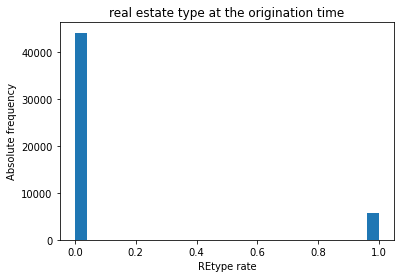

In [ ]:
# Visualization of 'REtype_PU_orig_time'
plt.hist(data.REtype_PU_orig_time, bins=25)
plt.title('real estate type at the origination time', fontsize=12)
plt.xlabel('REtype rate')
plt.ylabel('Absolute frequency')
plt.show()

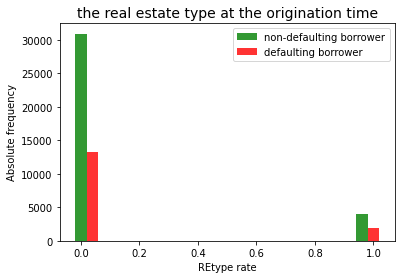

In [ ]:
# Visualization variable vs. target
REtype_SF_orig_time_0 = data[data.default_time == 0].iloc[:,10:11]
REtype_SF_orig_time_1 = data[data.default_time == 1].iloc[:,10:11]

a = np.array(REtype_SF_orig_time_0)
b = np.array(REtype_SF_orig_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower', align="left")
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower', align="right")
plt.legend(loc='upper right')
plt.title('the real estate type at the origination time', fontsize=14)
plt.xlabel('REtype rate')
plt.ylabel('Absolute frequency')
plt.show()

### Variable: **investor_orig_time**

In [ ]:
# General stats description
stats_investor_orig_time = {'Designation': ['Value'],
            'Variable': 'investor_orig_time',
            'Description': 'investor origination time',
            'Type of variable': data.investor_orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.investor_orig_time.shape[0],
            'Missing values': data.investor_orig_time.isnull().sum(),
            'Unique values': data.investor_orig_time.nunique(),
            'Min': data.investor_orig_time.min(),
            'Max': data.investor_orig_time.max(),
            'Mean': data.investor_orig_time.mean(),
            'Std dev': data.investor_orig_time.std(),
            'Variance': data.investor_orig_time.var(),
            'Skewness': scipy.stats.skew(data.investor_orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.investor_orig_time)
           }
st_investor_orig_time = pd.DataFrame(stats_investor_orig_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_investor_orig_time.set_index("Designation", inplace=True)

results = st_investor_orig_time.T
resultsT = st_investor_orig_time
display(results)

Designation                               Value
Variable                     investor_orig_time
Description           investor origination time
Type of variable                          int64
Type of distribution                   discrete
Total observations                        49982
Missing values                                0
Unique values                                 2
Min                                           0
Max                                           1
Mean                                   0.118443
Std dev                                0.323135
Variance                               0.104416
Skewness                                2.36162
Kurtosis                                3.57726

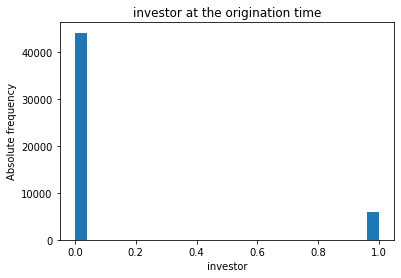

In [ ]:
# Visualization of 'investor_orig_time'
plt.hist(data.investor_orig_time, bins=25)
plt.title('investor at the origination time', fontsize=12)
plt.xlabel('investor')
plt.ylabel('Absolute frequency')
plt.show()

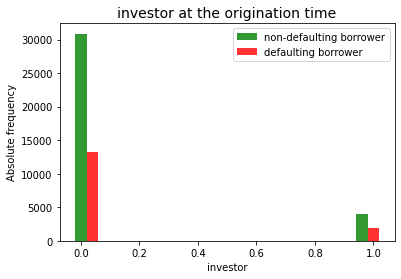

In [ ]:
# Visualization variable vs. target
investor_orig_time_0 = data[data.default_time == 0].iloc[:,11:12]
investor_orig_time_1 = data[data.default_time == 1].iloc[:,11:12]

a = np.array(investor_orig_time_0)
b = np.array(investor_orig_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower', align="left")
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower', align="right")
plt.legend(loc='upper right')
plt.title('investor at the origination time', fontsize=14)
plt.xlabel('investor')
plt.ylabel('Absolute frequency')
plt.show()

### Variable: **FICO_orig_time**

In [ ]:
# General stats description
stats_FICO_orig_time = {'Designation': ['Value'],
            'Variable': 'FICO_orig_time',
            'Description': 'FICO origination time score',
            'Type of variable': data.FICO_orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.FICO_orig_time.shape[0],
            'Missing values': data.FICO_orig_time.isnull().sum(),
            'Unique values': data.FICO_orig_time.nunique(),
            'Min': data.FICO_orig_time.min(),
            'Max': data.FICO_orig_time.max(),
            'Mean': data.FICO_orig_time.mean(),
            'Std dev': data.FICO_orig_time.std(),
            'Variance': data.FICO_orig_time.var(),
            'Skewness': scipy.stats.skew(data.FICO_orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.FICO_orig_time)
           }
st_FICO_orig_time = pd.DataFrame(stats_FICO_orig_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_FICO_orig_time.set_index("Designation", inplace=True)

results = st_FICO_orig_time.T
resultsT = st_FICO_orig_time
display(results)

Designation                                 Value
Variable                           FICO_orig_time
Description           FICO origination time score
Type of variable                            int64
Type of distribution                     discrete
Total observations                          49982
Missing values                                  0
Unique values                                 397
Min                                           400
Max                                           840
Mean                                      661.337
Std dev                                   72.7736
Variance                                     5296
Skewness                                -0.164675
Kurtosis                                -0.586736

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.FICO_orig_time.quantile(q=[.01, .05, .95, .99]))

Percentiles 1%, 5%, 95%, 99%


0.01    504.00
0.05    533.05
0.95    778.00
0.99    800.00
Name: FICO_orig_time, dtype: float64

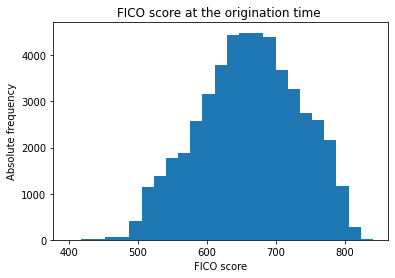

In [ ]:
# Visualization of 'gdp_time'
plt.hist(data.FICO_orig_time, bins=25)
plt.title('FICO score at the origination time ', fontsize=12)
plt.xlabel('FICO score')
plt.ylabel('Absolute frequency')
plt.show()

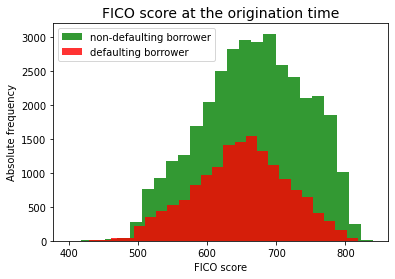

In [ ]:
# Visualization variable vs. target
FICO_orig_time_0 = data[data.default_time == 0].iloc[:,12:13]
FICO_orig_time_1 = data[data.default_time == 1].iloc[:,12:13]

a = np.array(FICO_orig_time_0)
b = np.array(FICO_orig_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('FICO score at the origination time', fontsize=14)
plt.xlabel('FICO score')
plt.ylabel('Absolute frequency')
plt.show()
print("")

Text(0.5, 0, 'default')

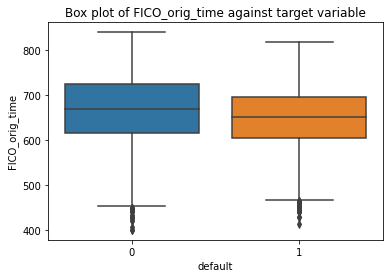

In [ ]:
sns.boxplot(y='FICO_orig_time', x='default_time', data=data)
plt.title('Box plot of FICO_orig_time against target variable')
plt.xlabel('default')

### Variable: **LTV_orig_time**

In [ ]:
# General stats description
stats_LTV_orig_time = {'Designation': ['Value'],
            'Variable': 'LTV_orig_time',
            'Description': 'loan to value origination',
            'Type of variable': data.LTV_orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.LTV_orig_time.shape[0],
            'Missing values': data.LTV_orig_time.isnull().sum(),
            'Unique values': data.LTV_orig_time.nunique(),
            'Min': data.LTV_orig_time.min(),
            'Max': data.LTV_orig_time.max(),
            'Mean': data.LTV_orig_time.mean(),
            'Std dev': data.LTV_orig_time.std(),
            'Variance': data.LTV_orig_time.var(),
            'Skewness': scipy.stats.skew(data.LTV_orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.LTV_orig_time)
           }
st_LTV_orig_time = pd.DataFrame(stats_LTV_orig_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_LTV_orig_time.set_index("Designation", inplace=True)

results = st_LTV_orig_time.T
resultsT = st_LTV_orig_time
display(results)

Designation                               Value
Variable                          LTV_orig_time
Description           loan to value origination
Type of variable                        float64
Type of distribution                   discrete
Total observations                        49982
Missing values                                0
Unique values                               552
Min                                        50.1
Max                                       218.5
Mean                                    79.7085
Std dev                                 9.92024
Variance                                98.4111
Skewness                              -0.193633
Kurtosis                                1.71062

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.LTV_orig_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     52.9
0.05     60.5
0.95     95.0
0.99    100.0
Name: LTV_orig_time, dtype: float64

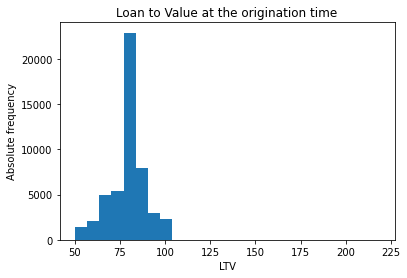

In [ ]:
# Visualization of 'hpi_orig_time'
plt.hist(data.LTV_orig_time, bins=25)
plt.title('Loan to Value at the origination time', fontsize=12)
plt.xlabel('LTV')
plt.ylabel('Absolute frequency')
plt.show()

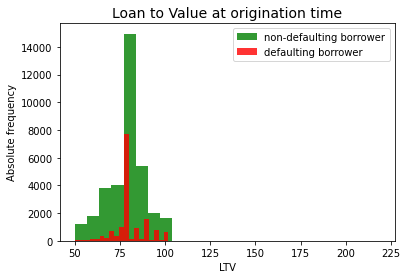

In [ ]:
# Visualization variable vs. target
LTV_orig_time_0 = data[data.default_time == 0].iloc[:,13:14]
LTV_orig_time_1 = data[data.default_time == 1].iloc[:,13:14]

a = np.array(LTV_orig_time_0)
b = np.array(LTV_orig_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper right')
plt.title('Loan to Value at origination time', fontsize=14)
plt.xlabel('LTV')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

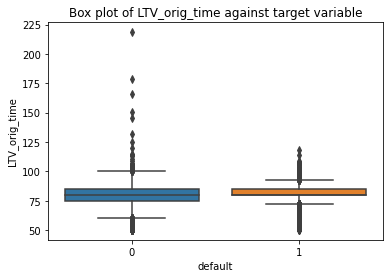

In [ ]:
sns.boxplot(y='LTV_orig_time', x='default_time', data=data)
plt.title('Box plot of LTV_orig_time against target variable')
plt.xlabel('default')

### Variable: **Interest_rate_orig_time**

In [ ]:
# General stats description
stats_interest_orig_time = {'Designation': ['Value'],
            'Variable': 'interest_orig_time',
            'Description': 'interest rate origination',
            'Type of variable': data.Interest_Rate_orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.Interest_Rate_orig_time.shape[0],
            'Missing values': data.Interest_Rate_orig_time.isnull().sum(),
            'Unique values': data.Interest_Rate_orig_time.nunique(),
            'Min': data.Interest_Rate_orig_time.min(),
            'Max': data.Interest_Rate_orig_time.max(),
            'Mean': data.Interest_Rate_orig_time.mean(),
            'Std dev': data.Interest_Rate_orig_time.std(),
            'Variance': data.Interest_Rate_orig_time.var(),
            'Skewness': scipy.stats.skew(data.Interest_Rate_orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.Interest_Rate_orig_time)
           }
st_interest_rate_orig_time = pd.DataFrame(stats_interest_orig_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_interest_rate_orig_time.set_index("Designation", inplace=True)

results = st_interest_rate_orig_time.T
resultsT = st_interest_rate_orig_time
display(results)

Designation                               Value
Variable                     interest_orig_time
Description           interest rate origination
Type of variable                        float64
Type of distribution                   discrete
Total observations                        49982
Missing values                                0
Unique values                              1704
Min                                           0
Max                                       19.75
Mean                                    5.44293
Std dev                                 3.28687
Variance                                10.8035
Skewness                              -0.514172
Kurtosis                              -0.719519

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.Interest_Rate_orig_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     0.00000
0.05     0.00000
0.95     9.84970
0.99    11.67785
Name: Interest_Rate_orig_time, dtype: float64

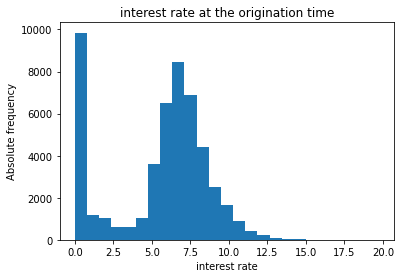

In [ ]:
# Visualization of 'hpi_orig_time'
plt.hist(data.Interest_Rate_orig_time, bins=25)
plt.title('interest rate at the origination time', fontsize=12)
plt.xlabel('interest rate')
plt.ylabel('Absolute frequency')
plt.show()

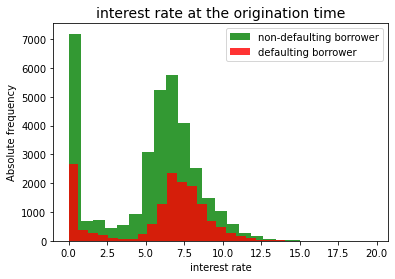

In [ ]:
# Visualization variable vs. target
interest_orig_time_0 = data[data.default_time == 0].iloc[:,14:15]
interest_orig_time_1 = data[data.default_time == 1].iloc[:,14:15]

a = np.array(interest_orig_time_0)
b = np.array(interest_orig_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defaulting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper right')
plt.title('interest rate at the origination time', fontsize=14)
plt.xlabel('interest rate')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

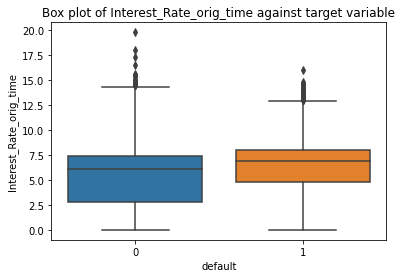

In [ ]:
sns.boxplot(y='Interest_Rate_orig_time', x='default_time', data=data)
plt.title('Box plot of Interest_Rate_orig_time against target variable')
plt.xlabel('default')

### Variable: **hpi_orig_time**

In [ ]:
# General stats description
stats_hpi_orig_time = {'Designation': ['Value'],
            'Variable': 'hpi_orig_time',
            'Description': 'house price index origination time',
            'Type of variable': data.hpi_orig_time.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.hpi_orig_time.shape[0],
            'Missing values': data.hpi_orig_time.isnull().sum(),
            'Unique values': data.hpi_orig_time.nunique(),
            'Min': data.hpi_orig_time.min(),
            'Max': data.hpi_orig_time.max(),
            'Mean': data.hpi_orig_time.mean(),
            'Std dev': data.hpi_orig_time.std(),
            'Variance': data.hpi_orig_time.var(),
            'Skewness': scipy.stats.skew(data.hpi_orig_time),
            'Kurtosis': scipy.stats.kurtosis(data.hpi_orig_time)
           }
st_hpi_orig_time = pd.DataFrame(stats_hpi_orig_time, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_hpi_orig_time.set_index("Designation", inplace=True)

results = st_hpi_orig_time.T
resultsT = st_hpi_orig_time
display(results)

Designation                                        Value
Variable                                   hpi_orig_time
Description           house price index origination time
Type of variable                                 float64
Type of distribution                            discrete
Total observations                                 49982
Missing values                                         0
Unique values                                         97
Min                                                75.71
Max                                               226.29
Mean                                             196.394
Std dev                                          34.3279
Variance                                         1178.41
Skewness                                        -1.27947
Kurtosis                                        0.925458

In [ ]:
# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.hpi_orig_time.quantile(q=[.01, .05, .95, .99]))
print("")

Percentiles 1%, 5%, 95%, 99%


0.01     89.82
0.05    123.64
0.95    226.29
0.99    226.29
Name: hpi_orig_time, dtype: float64

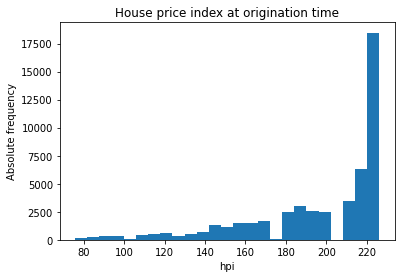

In [ ]:
# Visualization of 'hpi_orig_time'
plt.hist(data.hpi_orig_time, bins=25)
plt.title('House price index at origination time', fontsize=12)
plt.xlabel('hpi')
plt.ylabel('Absolute frequency')
plt.show()

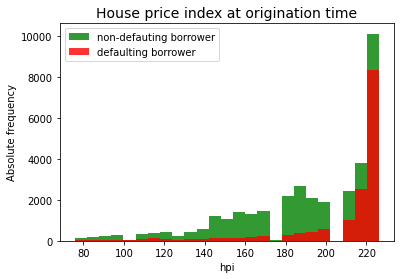

In [ ]:
# Visualization variable vs. target
hpi_orig_time_0 = data[data.default_time == 0].iloc[:,15:16]
hpi_orig_time_1 = data[data.default_time == 1].iloc[:,15:16]

a = np.array(hpi_orig_time_0)
b = np.array(hpi_orig_time_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="g", alpha = 0.8, label='non-defauting borrower')
plt.hist(b, bins=25, density=False, color="r", alpha = 0.8, label='defaulting borrower')
plt.legend(loc='upper left')
plt.title('House price index at origination time', fontsize=14)
plt.xlabel('hpi')
plt.ylabel('Absolute frequency')
plt.show()

Text(0.5, 0, 'default')

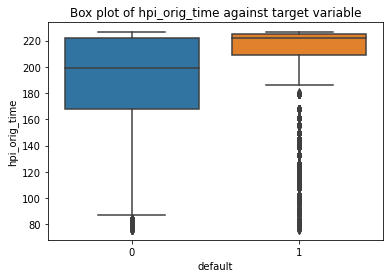

In [ ]:
sns.boxplot(y='hpi_orig_time', x='default_time', data=data)
plt.title('Box plot of hpi_orig_time against target variable')
plt.xlabel('default')

# **Modeling**

In [ ]:
# Generate X and y data
X = data.loc[:, data.columns != 'default_time'].to_numpy()
y =data['default_time'].to_numpy().astype('int64')

In [ ]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# selected accepted cases from the dataset
# choice 5000 instances  
n_labeled_examples = X_train.shape[0]
training_indices = np.random.choice(range(n_labeled_examples) , size =5000, replace = False)
X_train_new = X_train[training_indices]
y_train_new = y_train[training_indices]

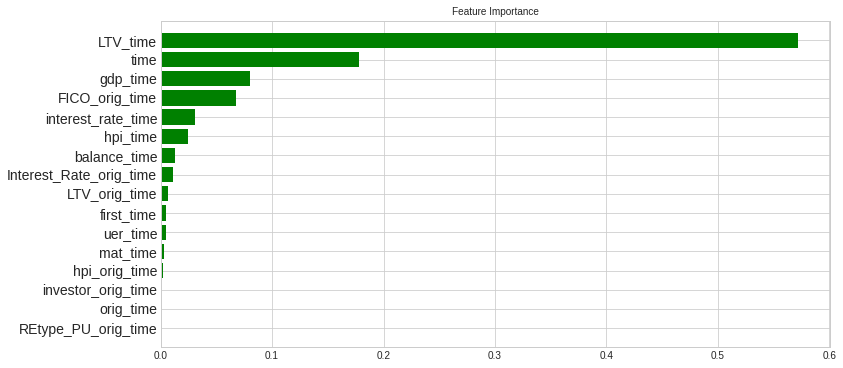

In [ ]:
# Feature Importance
plt.style.use('seaborn-whitegrid')
clf = tree.DecisionTreeClassifier(class_weight = 'balanced', min_weight_fraction_leaf = 0.01)
clf.fit(X_train_new, y_train_new)
importances = clf.feature_importances_
feature_names = data.drop('default_time', axis = 1).columns
indices = np.argsort(importances)
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Feature Importance", fontsize=10)
    plt.barh(range(len(indices)), importances[indices], color='g',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

## **Credit Scoring Models**

In [ ]:
# ROC Curve: Area Under the Curve

def auc_roc_plot(y_test, y_preds):

    fpr, tpr, thresholds = roc_curve(y_test,y_preds)
    roc_auc = auc(fpr, tpr)
    
    print(roc_auc)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(False)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### **Logistic regression (LR)**

In [ ]:
# training the model
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced')
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}

lr_model = GridSearchCV(lr, parameters, cv = 5)
lr_train = lr_model.fit(X_train_new, y_train_new)

In [ ]:
# model's score
print('Accuracy of logistic regression on training set: {:.2f}'
     .format(lr_train.score(X_train_new, y_train_new)))

Accuracy of logistic regression on training set: 0.79


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train = lr_train.predict(X_train_new)
acc_lr = accuracy_score(y_train_new,y_pred_train)
f1_lr = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr)
print("f1 score : ",f1_lr)
print("precision score : ",prec_lr)
print("recall score : ",rec_lr)


accuracy score :  0.787
f1 score :  0.7607921485918744
precision score :  0.7534648811678464
recall score :  0.7731756072073954


In [ ]:
# Compute AUC on train set
auc_lr = roc_auc_score(y_train_new, y_pred_train)
auc_lr

0.7731756072073954

0.7731756072073954


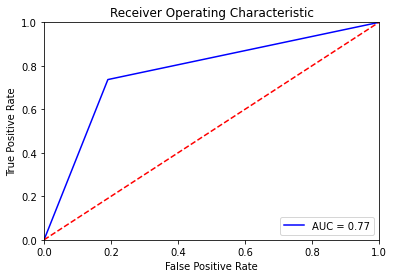

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of logistic regression on test set: 0.79


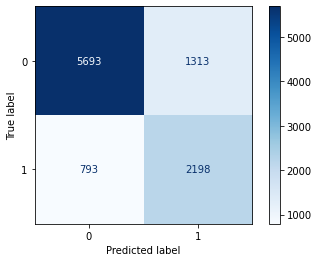

In [ ]:
# confusion matrix of test set
print('Accuracy of logistic regression on test set: {:.2f}'
     .format(lr_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = lr_train.predict(X_test)
cm_lr_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr_train, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# determine tp, fp, fn, and tn
TP_lr_test = cm_lr_test[0][0]
FP_lr_test = cm_lr_test[0][1]
FN_lr_test = cm_lr_test[1][0]
TN_lr_test = cm_lr_test[1][1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_test = accuracy_score(y_test,y_pred_test)
f1_lr_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_test)
print("f1 score : ",f1_lr_test)
print("precision score : ",prec_lr_test)
print("recall score : ",rec_lr_test)

accuracy score :  0.7893368010403121
f1 score :  0.7600035811918757
precision score :  0.7518845664825222
recall score :  0.7737302448787031


In [ ]:
# AUC on test set 
auc_lr_test = roc_auc_score(y_test, y_pred_test)
auc_lr_test

0.7737302448787031

0.7737302448787031


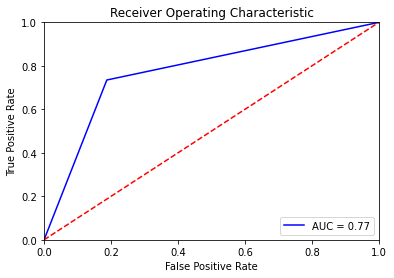

In [ ]:
# ROC curve
auc_roc_plot(y_test, y_pred_test)

### **Support Vector Machine (SVC)**

In [ ]:
# train das model
svc = SVC(kernel='linear', random_state=seed, class_weight='balanced',probability=True, verbose=True)
parameters = {'C':[0.1, 1, 10]}
svc_model = GridSearchCV(svc, parameters, cv = 5)
svc_train= svc_model.fit(X_train_new, y_train_new)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
# model's score
print('Accuracy of svc on training set: {:.2f}'
     .format(svc_train.score(X_train_new, y_train_new)))

Accuracy of svc on training set: 0.79


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train= svc_train.predict(X_train_new)
acc_svc = accuracy_score(y_train_new,y_pred_train)
f1_svc = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc)
print("f1 score : ",f1_svc)
print("precision score : ",prec_svc)
print("recall score : ",rec_svc)


accuracy score :  0.7886
f1 score :  0.7615155607148214
precision score :  0.7546214887325837
recall score :  0.77237156976003


In [ ]:
# Compute AUC on train set
auc_svc = roc_auc_score(y_train_new, y_pred_train)
auc_svc

0.77237156976003

0.77237156976003


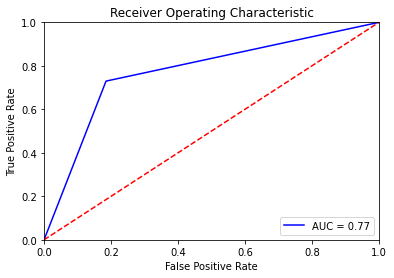

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of svc on test set: 0.79


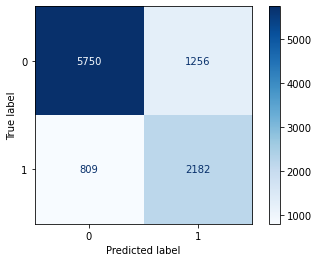

In [ ]:
# confusion matrix of test set
print('Accuracy of svc on test set: {:.2f}'
     .format(svc_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = svc_train.predict(X_test)
cm_svc_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc_model, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# determine tp, fp, fn, and tn
TP_svc_test = cm_svc_test[0][0]
FP_svc_test = cm_svc_test[0][1]
FN_svc_test = cm_svc_test[1][0]
TN_svc_test = cm_svc_test[1][1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_test = accuracy_score(y_test,y_pred_test)
f1_svc_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_test)
print("f1 score : ",f1_svc_test)
print("precision score : ",prec_svc_test)
print("recall score : ",rec_svc_test)

accuracy score :  0.7934380314094228
f1 score :  0.7632845937395385
precision score :  0.7556646738367391
recall score :  0.7751234959040219


In [ ]:
# AUC on test set
auc_svc_test = roc_auc_score(y_test, y_pred_test)
auc_svc_test

0.7751234959040219

0.7751234959040219


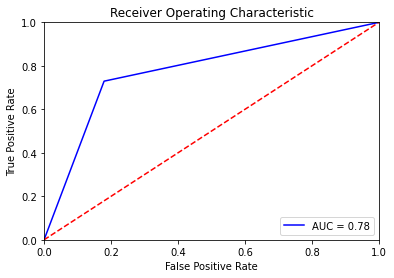

In [ ]:
# ROC Curve
auc_roc_plot(y_test, y_pred_test)

### **Naive Bayes Model (NB)**

In [ ]:
# Training the Gaussian Model
gm_model = GaussianNB()
gm_train = gm_model.fit(X_train_new, y_train_new)

In [ ]:
# model's score
print('Accuracy of Gaussion Model on training set: {:.2f}'
     .format(gm_train.score(X_train_new, y_train_new)))

Accuracy of Gaussion Model on training set: 0.80


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train= gm_train.predict(X_train_new)
acc_gm = accuracy_score(y_train_new,y_pred_train)
f1_gm = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm)
print("f1 score : ",f1_gm)
print("precision score : ",prec_gm)
print("recall score : ",rec_gm)


accuracy score :  0.7966
f1 score :  0.7655735571398203
precision score :  0.7620162675062236
recall score :  0.7697786191934503


In [ ]:
# Compute AUC on train set
auc_gm = roc_auc_score(y_train_new, y_pred_train)
auc_gm

0.7697786191934503

0.7697786191934503


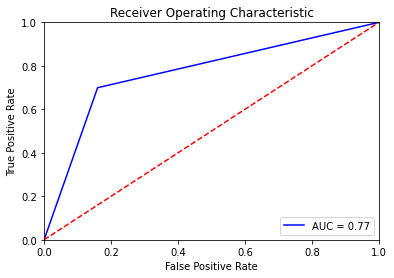

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of Gaussian Model on test set: 0.80


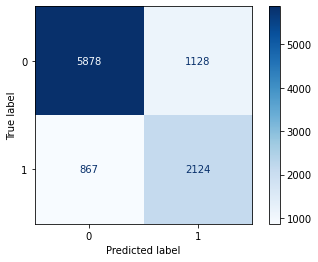

In [ ]:
# confusion matrix of test set
print('Accuracy of Gaussian Model on test set: {:.2f}'
     .format(gm_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = gm_train.predict(X_test)
cm_gm_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm_model, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# determine tp, fp, fn, and tn
TP_gm_test = cm_gm_test[0][0]
FP_gm_test = cm_gm_test[0][1]
FN_gm_test = cm_gm_test[1][0]
TN_gm_test = cm_gm_test[1][1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_test = accuracy_score(y_test,y_pred_test)
f1_gm_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_test)
print("f1 score : ",f1_gm_test)
print("precision score : ",prec_gm_test)
print("recall score : ",rec_gm_test)

accuracy score :  0.8004401320396118
f1 score :  0.7676808686772019
precision score :  0.762298436179321
recall score :  0.7745627690951817


In [ ]:
# AUC on test set
auc_gm_test = roc_auc_score(y_test, y_pred_test)
auc_gm_test

0.7745627690951817

0.7745627690951817


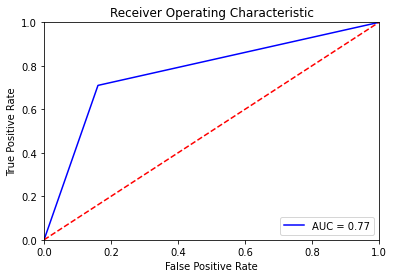

In [ ]:
# ROC curve
auc_roc_plot(y_test, y_pred_test)

### **Decision Trees (DT)**

In [ ]:
# model's training
tree_model = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
tree_train = tree_model.fit(X_train_new, y_train_new)

In [ ]:
# model's score
print('Accuracy of DT on training set: {:.2f}'
     .format(tree_train.score(X_train_new, y_train_new)))

Accuracy of DT on training set: 0.86


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train = tree_train.predict(X_train_new)
acc_tree = accuracy_score(y_train_new,y_pred_train)
f1_tree = f1_score(y_train_new, y_pred_train, average="macro")
prec_tree = precision_score(y_train_new, y_pred_train, average="macro")
rec_tree = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_tree)
print("f1 score : ",f1_tree)
print("precision score : ",prec_tree)
print("recall score : ",rec_tree)


accuracy score :  0.8594
f1 score :  0.8342699634323629
precision score :  0.8368721260730785
recall score :  0.8318379547234251


In [ ]:
# AUC on train set
auc_tree = roc_auc_score(y_train_new, y_pred_train)
auc_tree

0.8318379547234251

0.8318379547234251


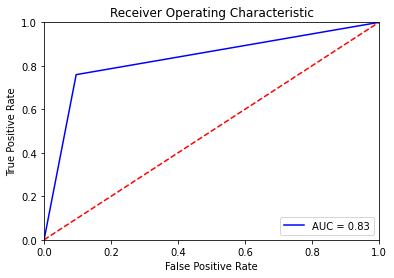

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of tree Model on test set: 0.80


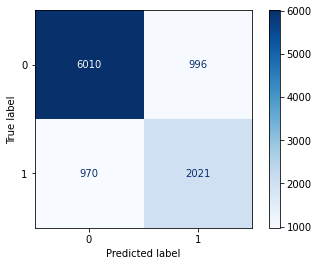

In [ ]:
# confusion matrix of test set
print('Accuracy of tree Model on test set: {:.2f}'
     .format(tree_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = tree_train.predict(X_test)
cm_tree_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree_model, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_tree_test = cm_tree_test[0,0]
FP_tree_test = cm_tree_test[0,1]
FN_tree_test = cm_tree_test[1,0]
TN_tree_test = cm_tree_test[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_tree_test = accuracy_score(y_test,y_pred_test)
f1_tree_test = f1_score(y_test, y_pred_test, average="macro")
prec_tree_test = precision_score(y_test, y_pred_test, average="macro")
rec_tree_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_tree_test)
print("f1 score : ",f1_tree_test)
print("precision score : ",prec_tree_test)
print("recall score : ",rec_tree_test)

accuracy score :  0.8033410023006902
f1 score :  0.7661002499551102
precision score :  0.765451125570193
recall score :  0.7667649441807198


In [ ]:
# AUC on test set
auc_tree_test = roc_auc_score(y_test, y_pred_test)
auc_tree_test

0.7667649441807198

0.7667649441807199


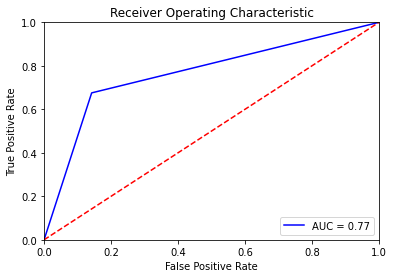

In [ ]:
# plot roc curve
auc_roc_plot(y_test, y_pred_test)

### **K Nearest Neighbor (KNN)**

In [ ]:
# find the best k
for k in range(1, 200, 5):

  k = k + 1

  knn = KNeighborsClassifier(n_neighbors = k).fit(X_train_new, y_train_new)

  acc = knn.score(X_test, y_test)

  print('Accuracy for k =', k, ' is:', acc)

Accuracy for k = 2  is: 0.7700310093027909
Accuracy for k = 7  is: 0.8098429528858657
Accuracy for k = 12  is: 0.8125437631289387
Accuracy for k = 17  is: 0.8143443032909873
Accuracy for k = 22  is: 0.8178453536060818
Accuracy for k = 27  is: 0.8160448134440332
Accuracy for k = 32  is: 0.8153446033810143
Accuracy for k = 37  is: 0.81444433329999
Accuracy for k = 42  is: 0.8143443032909873
Accuracy for k = 47  is: 0.8139441832549765
Accuracy for k = 52  is: 0.8133440032009603
Accuracy for k = 57  is: 0.8122436731019306
Accuracy for k = 62  is: 0.8135440632189657
Accuracy for k = 67  is: 0.813444033209963
Accuracy for k = 72  is: 0.8112433730119035
Accuracy for k = 77  is: 0.8101430429128739
Accuracy for k = 82  is: 0.8082424727418226
Accuracy for k = 87  is: 0.8082424727418226
Accuracy for k = 92  is: 0.8090427128138441
Accuracy for k = 97  is: 0.8085425627688306
Accuracy for k = 102  is: 0.8069420826247874
Accuracy for k = 107  is: 0.8053416024807443
Accuracy for k = 112  is: 0.8057417

In [ ]:
# model's training
knn_model = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
knn_train = knn_model.fit(X_train_new, y_train_new)

In [ ]:
# model's score
print('Accuracy of KNN Model on training set: {:.2f}'
     .format(knn_train.score(X_train_new, y_train_new)))

Accuracy of KNN Model on training set: 0.82


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train = knn_train.predict(X_train_new)
acc_knn = accuracy_score(y_train_new,y_pred_train)
f1_knn = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn)
print("f1 score : ",f1_knn)
print("precision score : ",prec_knn)
print("recall score : ",rec_knn)


accuracy score :  0.8218
f1 score :  0.786753041497571
precision score :  0.7942179807256868
recall score :  0.7807090356024786


In [ ]:
# Compute AUC on train set
auc_knn = roc_auc_score(y_train_new, y_pred_train)
auc_knn

0.7807090356024786

0.7807090356024786


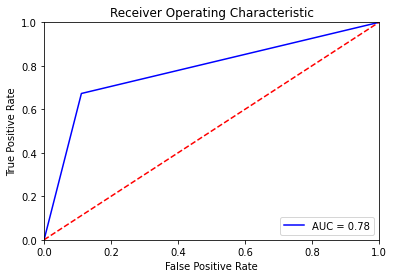

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of KNN Model on test set: 0.82


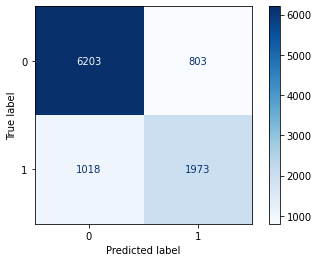

In [ ]:
# confusion matrix of test set
print('Accuracy of KNN Model on test set: {:.2f}'
     .format(knn_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = knn_train.predict(X_test)
cm_knn_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn_model, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_knn_test = cm_knn_test[0,0]
FP_knn_test = cm_knn_test[0,1]
FN_knn_test = cm_knn_test[1,0]
TN_knn_test = cm_knn_test[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_test = accuracy_score(y_test,y_pred_test)
f1_knn_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_test)
print("f1 score : ",f1_knn_test)
print("precision score : ",prec_knn_test)
print("recall score : ",rec_knn_test)

accuracy score :  0.8178453536060818
f1 score :  0.7781209207505411
precision score :  0.7848785831989391
recall score :  0.7725147800428596


In [ ]:
# compute AUC on test set
auc_knn_test = roc_auc_score(y_test, y_pred_test)
auc_knn_test

0.7725147800428596

0.7725147800428596


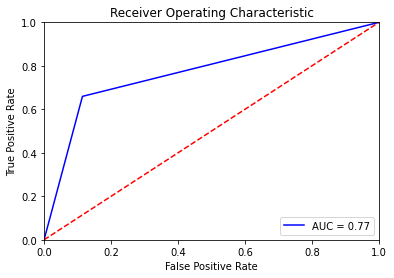

In [ ]:
# ROC Curve
auc_roc_plot(y_test, y_pred_test)

### **Random Forest (RF)**

In [ ]:
# model's training
rf = RandomForestClassifier(random_state = seed, class_weight = None)
parameters = {'n_estimators':[10, 100, 300, 1000]}

rf_model = GridSearchCV(rf, parameters, cv = 5)
rf_train = rf_model.fit(X_train_new, y_train_new)

In [ ]:
# model's score
print('Accuracy of rf Model on training set: {:.2f}'
     .format(rf_train.score(X_train_new, y_train_new)))

Accuracy of rf Model on training set: 1.00


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train = rf_train.predict(X_train_new)
acc_rf = accuracy_score(y_train_new,y_pred_train)
f1_rf = f1_score(y_train_new, y_pred_train, average="macro")
prec_rf = precision_score(y_train_new, y_pred_train, average="macro")
rec_rf = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_rf)
print("f1 score : ",f1_rf)
print("precision score : ",prec_rf)
print("recall score : ",rec_rf)


accuracy score :  1.0
f1 score :  1.0
precision score :  1.0
recall score :  1.0


In [ ]:
# AUC on train set
auc_rf = roc_auc_score(y_train_new, y_pred_train)
auc_rf

1

1.0


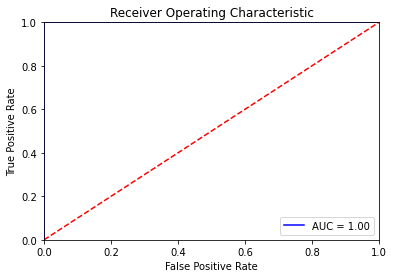

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of rf Model on test set: 0.83


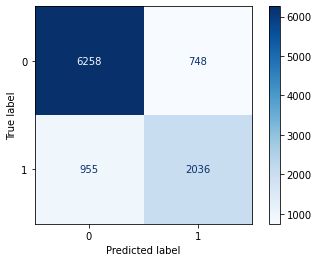

In [ ]:
# confusion matrix of test set
print('Accuracy of rf Model on test set: {:.2f}'
     .format(rf_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = rf_train.predict(X_test)
cm_rf_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(rf_model, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_rf_test = cm_rf_test[0,0]
FP_rf_test = cm_rf_test[0,1]
TN_rf_test = cm_rf_test[1,0]
FN_rf_test = cm_rf_test[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_rf_test = accuracy_score(y_test,y_pred_test)
f1_rf_test = f1_score(y_test, y_pred_test, average="macro")
prec_rf_test = precision_score(y_test, y_pred_test, average="macro")
rec_rf_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_rf_test)
print("f1 score : ",f1_rf_test)
print("precision score : ",prec_rf_test)
print("recall score : ",rec_rf_test)

accuracy score :  0.8296488946684005
f1 score :  0.7926694511855212
precision score :  0.7994610027233715
recall score :  0.7869715817926708


In [ ]:
# compute Auc on test set
auc_rf_test = roc_auc_score(y_test, y_pred_test)
auc_rf_test

0.7869715817926708

0.7869715817926709


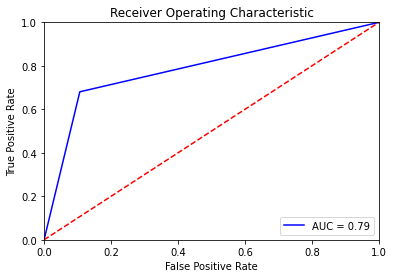

In [ ]:
# ROC curve
auc_roc_plot(y_test, y_pred_test)

### **Neural Network (NN)**

In [ ]:
# model's training
mlp_nn = MLPClassifier(solver = 'adam', random_state = seed, max_iter = 1000 )

parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

nn = GridSearchCV(mlp_nn, parameters, cv = 5)
nn_train = nn.fit(X_train_new, y_train_new)

In [ ]:
# model's score
print('Accuracy of mpl_nn Model on training set: {:.2f}'
     .format(nn_train.score(X_train_new, y_train_new)))

Accuracy of mpl_nn Model on training set: 0.81


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
y_pred_train = nn_train.predict(X_train_new)
acc_nn = accuracy_score(y_train_new,y_pred_train)
f1_nn = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn)
print("f1 score : ",f1_nn)
print("precision score : ",prec_nn)
print("recall score : ",rec_nn)


accuracy score :  0.8142
f1 score :  0.7731476233660586
precision score :  0.7882632513664567
recall score :  0.7628966576940206


In [ ]:
# compute AUC on test set
auc_nn = roc_auc_score(y_train_new,y_pred_train)
auc_nn

0.7628966576940206

0.7628966576940206


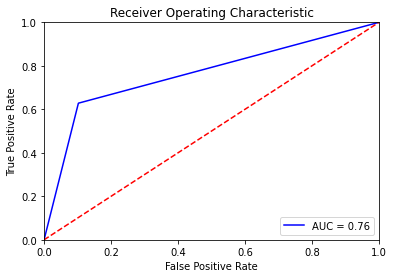

In [ ]:
# plot roc curve
auc_roc_plot(y_train_new, y_pred_train)

Accuracy of mlp Model on test set: 0.82


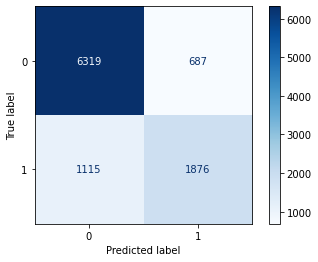

In [ ]:
# confusion matrix of test set
print('Accuracy of mlp Model on test set: {:.2f}'
     .format(nn_train.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
y_pred_test = nn_train.predict(X_test)
cm_nn_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(nn, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_nn_test = cm_nn_test[0,0]
FP_nn_test = cm_nn_test[0,1]
FN_nn_test = cm_nn_test[1,0]
TN_nn_test = cm_nn_test[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_test = accuracy_score(y_test,y_pred_test)
f1_nn_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_test)
print("f1 score : ",f1_nn_test)
print("precision score : ",prec_nn_test)
print("recall score : ",rec_nn_test)

accuracy score :  0.8197459237771332
f1 score :  0.7753784549978704
precision score :  0.7909840961233993
recall score :  0.7645780857655277


In [ ]:
# Compute AUC on test set
auc_nn_test = roc_auc_score(y_test,y_pred_test)
auc_nn_test

0.7645780857655277

0.7645780857655277


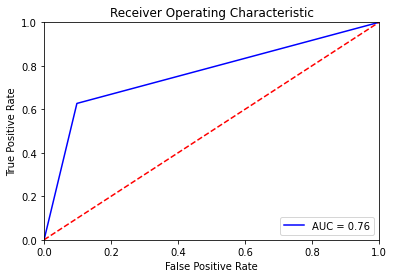

In [ ]:
# ROC Curve
auc_roc_plot(y_test, y_pred_test)

### **performance table and visualization**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr, auc_lr],
            'K Nearest Neighbour (KNN)': [acc_knn, auc_knn],
            'Support Vector Machine (SVC)': [acc_svc, auc_svc],
            'Decision Trees (DT)': [acc_tree, auc_tree],
            'Naive Bayes (NB)': [acc_gm, auc_gm],
            'Random Forest (RF)': [acc_rf, auc_rf],
            'Neural Networks (NN)': [acc_nn, auc_nn]
           }

dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Random Forest (RF)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7870     0.773176
K Nearest Neighbour (KNN)          0.8218     0.780709
Support Vector Machine (SVC)       0.7886     0.772372
Decision Trees (DT)                0.8594     0.831838
Naive Bayes (NB)                   0.7966     0.769779
Random Forest (RF)                 1.0000     1.000000
Neural Networks (NN)               0.8142     0.762897

In [ ]:
# Creating performance table
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_test, auc_lr_test],
            'K Nearest Neighbour (KNN)': [acc_knn_test, auc_knn_test],
            'Support Vector Machine (SVC)': [acc_svc_test, auc_svc_test],
            'Decision Trees (DT)': [acc_tree_test, auc_tree_test],
            'Naive Bayes (NB)': [acc_gm_test, auc_gm_test],
            'Random Forest (RF)': [acc_rf_test, auc_rf_test],
            'Neural Networks (NN)': [acc_nn_test, auc_nn_test]
           }

dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Random Forest (RF)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.789337    0.773730
K Nearest Neighbour (KNN)       0.817845    0.772515
Support Vector Machine (SVC)    0.793438    0.775123
Decision Trees (DT)             0.803341    0.766765
Naive Bayes (NB)                0.800440    0.774563
Random Forest (RF)              0.829649    0.786972
Neural Networks (NN)            0.819746    0.764578

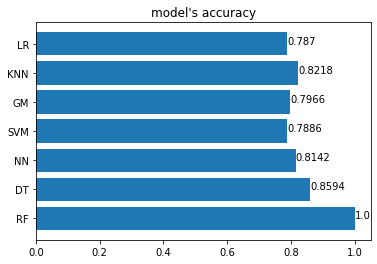

In [ ]:
# plot accuracy of models on train
metrics=['RF','DT','NN','SVM','GM','KNN','LR']
accuracy=[acc_rf, acc_tree, acc_nn, acc_svc, acc_gm, acc_knn, acc_lr]

plt.barh(metrics, accuracy)
plt.title("model's accuracy") 
for index, value in enumerate(accuracy):
    plt.text(value, index,
             str(value))
plt.grid(False)  
plt.show()

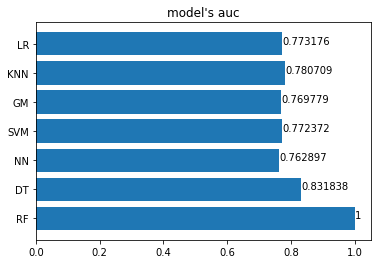

In [ ]:
# plot AUC of models on train
metrics=['RF','DT','NN','SVM','GM','KNN','LR']
auc=[auc_rf, auc_tree, auc_nn, auc_svc, auc_gm, auc_knn, auc_lr]

plt.barh(metrics, auc)
plt.title("model's auc") 
for index, value in enumerate(auc):
    plt.text(value, index,
             str(value))
plt.grid(False)  
plt.show()

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_test, FP_lr_test, TN_lr_test, FN_lr_test],
            'K Nearest Neighbour (KNN)': [TP_knn_test, FP_knn_test, TN_knn_test, FN_knn_test],
            'Support Vector Machine (SVC)': [TP_svc_test, FP_svc_test, TN_svc_test, FN_svc_test],
            'Decision Trees (DT)': [TP_tree_test, FP_tree_test, TN_tree_test, FN_tree_test],
            'Naive Bayes (NB)': [TP_gm_test, FP_gm_test, TN_gm_test, FN_gm_test],
            'Random Forest (RF)': [TP_rf_test, FP_rf_test, TN_rf_test, FN_rf_test],
            'Neural Networks (NN)': [TP_nn_test, FP_nn_test, TN_nn_test,FN_nn_test]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Random Forest (RF)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5693  1313  2198   793
K Nearest Neighbour (KNN)     6203   803  1973  1018
Support Vector Machine (SVC)  5750  1256  2182   809
Decision Trees (DT)           6010   996  2021   970
Naive Bayes (NB)              5878  1128  2124   867
Random Forest (RF)            6258   748   955  2036
Neural Networks (NN)          6319   687  1876  1115

## **Active Learning**

In [ ]:
!pip install modAL

In [ ]:
import matplotlib as mpl
from modAL.models import ActiveLearner
from modAL.models import Committee
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import classifier_entropy
from modAL.uncertainty import classifier_margin
from modAL.uncertainty import classifier_uncertainty
from modAL.disagreement import KL_max_disagreement
from modAL.disagreement import vote_entropy
from modAL.disagreement import vote_entropy_sampling
from modAL.disagreement import max_disagreement_sampling 

In [ ]:
# Isolate the non-train examples.
X_pool = np.delete(X_train, training_indices, axis=0)
y_pool = np.delete(y_train, training_indices, axis=0)


In [ ]:
# granted rejected loans
y_pool[:] = 0

### **Stream based active learning**

#### **Uncertainty Sampling**

##### **Classification Entropy**

###### **SVC**

In [ ]:
# define Learner, including training data as starting point
svc = SVC(C=svc_train.best_estimator_.C ,kernel='linear', random_state=seed, class_weight='balanced', probability=True)
learner = ActiveLearner(estimator=svc, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# Query unlabeled set
classifier_entropy(learner, X_pool)[:1000]

array([0.45606425, 0.40840617, 0.44904087, 0.33140285, 0.36759159,
       0.40678252, 0.41489109, 0.34615026, 0.22521265, 0.37385262,
       0.2910612 , 0.29703412, 0.51090982, 0.24994066, 0.32680956,
       0.28826489, 0.67065879, 0.46874319, 0.35414076, 0.27926789,
       0.5102879 , 0.51046026, 0.39522924, 0.11616922, 0.42998829,
       0.61424154, 0.5397593 , 0.46239037, 0.19515361, 0.21118675,
       0.26074422, 0.66385318, 0.36121145, 0.05722096, 0.24938897,
       0.22412753, 0.4350447 , 0.37216659, 0.4646767 , 0.19708043,
       0.28667372, 0.34789581, 0.23425755, 0.3554551 , 0.43163837,
       0.68483239, 0.44869563, 0.1868265 , 0.44900655, 0.22639045,
       0.51934709, 0.26544239, 0.4346986 , 0.20539192, 0.31937305,
       0.43585423, 0.30373333, 0.22427447, 0.56273605, 0.48875005,
       0.37987717, 0.55400254, 0.47835587, 0.31846557, 0.27821616,
       0.25819771, 0.25777551, 0.13019351, 0.39430455, 0.35377814,
       0.36796682, 0.60453787, 0.31380724, 0.34810559, 0.46089

In [ ]:
# initial score
history_entro_svc = [initial_score]

In [ ]:
# Active learning process
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_entropy(learner, X_pool[stream_idx].reshape(1, -1))>=0.6 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
# obtain new score
      new_score = learner.score(X_train_new, y_train_new)
      history_entro_svc.append(new_score)
# delete selected instance in the pool set
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 3968 queried, new accuracy: 0.788800
Example no. 6001 queried, new accuracy: 0.788800
Example no. 16583 queried, new accuracy: 0.788600
Example no. 24693 queried, new accuracy: 0.789000
Example no. 19134 queried, new accuracy: 0.789000
Example no. 15108 queried, new accuracy: 0.788800
Example no. 21276 queried, new accuracy: 0.788600
Example no. 23509 queried, new accuracy: 0.788600
Example no. 23168 queried, new accuracy: 0.788800
Example no. 14717 queried, new accuracy: 0.789000
Example no. 12938 queried, new accuracy: 0.789000
Example no. 22703 queried, new accuracy: 0.789200
Example no. 4429 queried, new accuracy: 0.789200
Example no. 21582 queried, new accuracy: 0.789000
Example no. 3365 queried, new accuracy: 0.789000
Example no. 5847 queried, new accuracy: 0.789400
Example no. 17466 queried, new accuracy: 0.789400
Example no. 13602 queried, new accuracy: 0.789600
Example no. 15449 queried, new accuracy: 0.789800
Example no. 17919 queried, new accuracy: 0.789800
Examp

In [ ]:
# plot accuracy with respect to number of labels queried
def plot_performance_model(score_history):
    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=130)

    ax.plot(score_history)
    ax.scatter(range(len(score_history)), score_history, s=13)

    ax.grid(True)

    ax.set_title('Incremental accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Accuracy')

    plt.show()

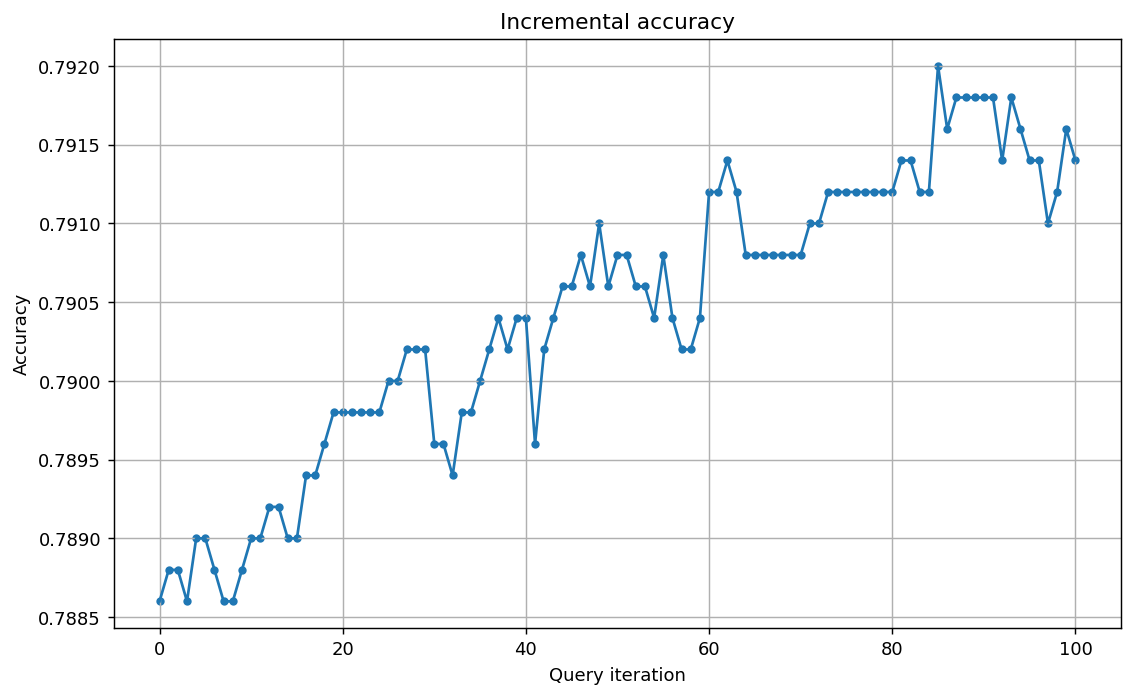

In [ ]:
# plot our performance over time
plot_performance_model(history_entro_svc)


In [ ]:
# make predictions
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_svc_entro = accuracy_score(y_train_new,y_pred_train)
f1_svc_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_entro)
print("f1 score : ",f1_svc_entro)
print("precision score : ",prec_svc_entro)
print("recall score : ",rec_svc_entro)


accuracy score :  0.7914
f1 score :  0.7650305539128721
precision score :  0.7577285799032589
recall score :  0.7769022260602572


In [ ]:
# Compute AUC on train set
auc_svc_entro = roc_auc_score(y_train_new,y_pred_train)
auc_svc_entro

0.7769022260602572

In [ ]:
# Check the performance on test set

print('Accuracy of SVC classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of SVC classifier on test set: 0.79


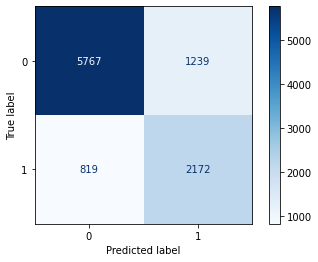

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# Confusion matrix
TP_svc_entro = cm_svc_entro[0,0]
FP_svc_entro = cm_svc_entro[0,1]
FN_svc_entro = cm_svc_entro[1,0]
TN_svc_entro = cm_svc_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_entro_test = accuracy_score(y_test,y_pred_test)
f1_svc_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_entro_test)
print("f1 score : ",f1_svc_entro_test)
print("precision score : ",prec_svc_entro_test)
print("recall score : ",rec_svc_entro_test)

accuracy score :  0.7941382414724417
f1 score :  0.7635626806219877
precision score :  0.7562043603592921
recall score :  0.7746650599815432


In [ ]:
# AUC on test set
auc_svc_entro_test = roc_auc_score(y_test,y_pred_test)
auc_svc_entro_test

0.7746650599815432

###### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C= lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# query all rejected applications
classifier_entropy(learner, X_pool)[:1000]

array([0.36764331, 0.56707025, 0.61085508, 0.64725127, 0.67704502,
       0.6188545 , 0.54859456, 0.61652587, 0.36367572, 0.61703266,
       0.67212966, 0.56263407, 0.47776404, 0.59769783, 0.51210948,
       0.53098727, 0.66476827, 0.48535256, 0.25785092, 0.52912609,
       0.43013938, 0.61039689, 0.66439154, 0.31759933, 0.49686048,
       0.44459297, 0.66682706, 0.66945512, 0.60087178, 0.32978085,
       0.63487506, 0.6614037 , 0.68644225, 0.37559335, 0.4197475 ,
       0.42122151, 0.49485558, 0.68980606, 0.58528342, 0.47906012,
       0.58160185, 0.18789369, 0.460969  , 0.45740553, 0.64031984,
       0.69222673, 0.69250522, 0.62244755, 0.58806483, 0.65816837,
       0.4358106 , 0.49949841, 0.57620557, 0.51535527, 0.49246623,
       0.31709385, 0.48477205, 0.62480304, 0.67406023, 0.64296026,
       0.37467853, 0.67188688, 0.65494701, 0.41307421, 0.67811682,
       0.51901777, 0.60493412, 0.41949759, 0.57790152, 0.64469429,
       0.56781387, 0.45382422, 0.67768062, 0.39402197, 0.60313

In [ ]:
# Active learning process
history_entro_lr = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_entropy(learner, X_pool[stream_idx].reshape(1, -1))>=0.6 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
# new score
      new_score = learner.score(X_train_new, y_train_new)
      history_entro_lr.append(new_score)
# delete the selected instance
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 314 queried, new accuracy: 0.787000
Example no. 29823 queried, new accuracy: 0.787000
Example no. 3066 queried, new accuracy: 0.787000
Example no. 11820 queried, new accuracy: 0.787000
Example no. 10181 queried, new accuracy: 0.787000
Example no. 22507 queried, new accuracy: 0.787200
Example no. 24312 queried, new accuracy: 0.787200
Example no. 7770 queried, new accuracy: 0.787000
Example no. 18170 queried, new accuracy: 0.787200
Example no. 6504 queried, new accuracy: 0.787200
Example no. 28824 queried, new accuracy: 0.787200
Example no. 25073 queried, new accuracy: 0.787000
Example no. 25465 queried, new accuracy: 0.787000
Example no. 18569 queried, new accuracy: 0.787200
Example no. 18247 queried, new accuracy: 0.787000
Example no. 29227 queried, new accuracy: 0.787000
Example no. 17946 queried, new accuracy: 0.787000
Example no. 14571 queried, new accuracy: 0.787200
Example no. 23228 queried, new accuracy: 0.786800
Example no. 13284 queried, new accuracy: 0.787000
Examp

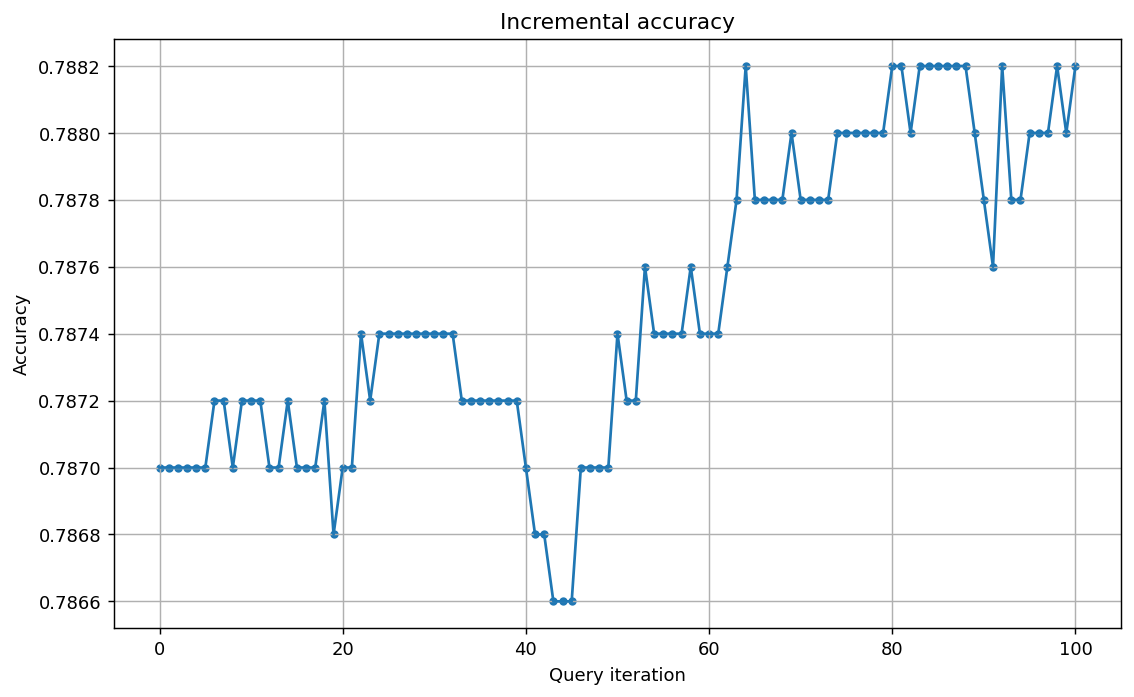

In [ ]:
# Display learning curve
plot_performance_model(history_entro_lr)


In [ ]:
# make predictions
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_lr_entro = accuracy_score(y_train_new,y_pred_train)
f1_lr_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_entro)
print("f1 score : ",f1_lr_entro)
print("precision score : ",prec_lr_entro)
print("recall score : ",rec_lr_entro)


accuracy score :  0.7882
f1 score :  0.7617130844627886
precision score :  0.754525623131164
recall score :  0.7735092031867215


In [ ]:
# AUC on train
auc_lr_entro = roc_auc_score(y_train_new,y_pred_train)
auc_lr_entro

0.7735092031867215

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of lr classifier on test set: 0.79


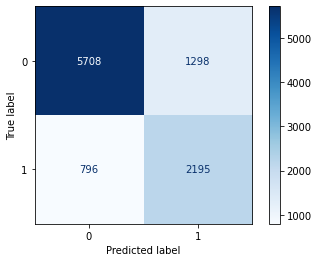

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test,values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_lr_entro = cm_lr_entro[0,0]
FP_lr_entro = cm_lr_entro[0,1]
FN_lr_entro = cm_lr_entro[1,0]
TN_lr_entro = cm_lr_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_entro_test = accuracy_score(y_test,y_pred_test)
f1_lr_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_entro_test)
print("f1 score : ",f1_lr_entro_test)
print("precision score : ",prec_lr_entro_test)
print("recall score : ",rec_lr_entro_test)

accuracy score :  0.7905371611483445
f1 score :  0.7610274519616926
precision score :  0.7530067162967651
recall score :  0.774299251355742


In [ ]:
# AUC on test set
auc_lr_entro_test = roc_auc_score(y_test,y_pred_test)
auc_lr_entro_test

0.774299251355742

###### **KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - KNN: {initial_score}")

Prediction Accuracy - KNN: 0.8218


In [ ]:
# query unlabeled set
classifier_entropy(learner, X_pool)[:1000]

array([0.58595262, 0.58595262, 0.1849074 , 0.62549136, 0.62549136,
       0.47413931, 0.3046361 , 0.47413931, 0.47413931, 0.68900924,
       0.1849074 , 0.1849074 , 0.3046361 , 0.        , 0.1849074 ,
       0.1849074 , 0.1849074 , 0.39830711, 0.47413931, 0.        ,
       0.47413931, 0.53595989, 0.47413931, 0.1849074 , 0.1849074 ,
       0.3046361 , 0.58595262, 0.3046361 , 0.47413931, 0.3046361 ,
       0.62549136, 0.68900924, 0.53595989, 0.1849074 , 0.        ,
       0.        , 0.3046361 , 0.1849074 , 0.1849074 , 0.58595262,
       0.        , 0.        , 0.        , 0.58595262, 0.        ,
       0.68900924, 0.3046361 , 0.1849074 , 0.58595262, 0.3046361 ,
       0.3046361 , 0.1849074 , 0.        , 0.47413931, 0.3046361 ,
       0.1849074 , 0.39830711, 0.65548177, 0.58595262, 0.        ,
       0.53595989, 0.47413931, 0.3046361 , 0.53595989, 0.1849074 ,
       0.        , 0.        , 0.3046361 , 0.3046361 , 0.3046361 ,
       0.1849074 , 0.53595989, 0.58595262, 0.47413931, 0.47413

In [ ]:
# Active learning process
history_entro_knn = [initial_score]
num_q= 100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_entropy(learner, X_pool[stream_idx].reshape(1, -1))>=0.5 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_entro_knn.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 6416 queried, new accuracy: 0.822000
Example no. 24152 queried, new accuracy: 0.822000
Example no. 22158 queried, new accuracy: 0.822000
Example no. 20407 queried, new accuracy: 0.822200
Example no. 16960 queried, new accuracy: 0.822200
Example no. 24175 queried, new accuracy: 0.822200
Example no. 10908 queried, new accuracy: 0.822400
Example no. 27406 queried, new accuracy: 0.822400
Example no. 2417 queried, new accuracy: 0.822400
Example no. 8596 queried, new accuracy: 0.822600
Example no. 4757 queried, new accuracy: 0.822600
Example no. 21126 queried, new accuracy: 0.822600
Example no. 28163 queried, new accuracy: 0.822800
Example no. 11426 queried, new accuracy: 0.822800
Example no. 20024 queried, new accuracy: 0.822800
Example no. 5457 queried, new accuracy: 0.822800
Example no. 18955 queried, new accuracy: 0.822800
Example no. 18304 queried, new accuracy: 0.822800
Example no. 15685 queried, new accuracy: 0.822800
Example no. 13093 queried, new accuracy: 0.822800
Examp

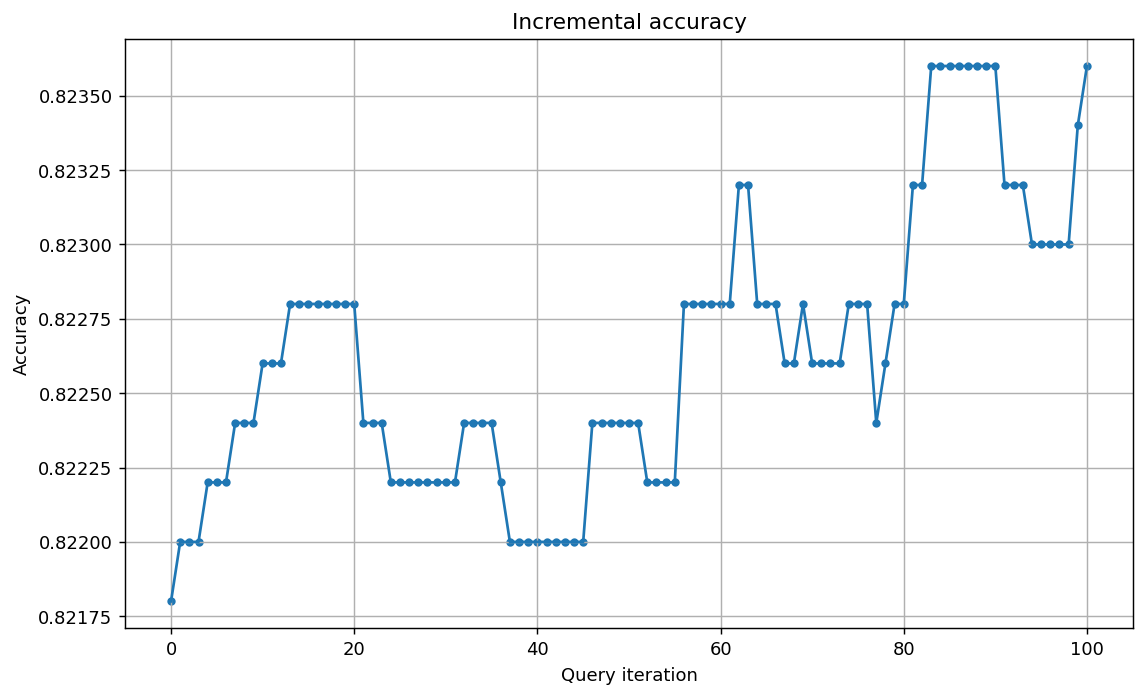

In [ ]:
# Display learning curve
plot_performance_model(history_entro_knn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_knn_entro = accuracy_score(y_train_new,y_pred_train)
f1_knn_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_entro)
print("f1 score : ",f1_knn_entro)
print("precision score : ",prec_knn_entro)
print("recall score : ",rec_knn_entro)


accuracy score :  0.8236
f1 score :  0.7860798002868181
precision score :  0.7988637702528981
recall score :  0.7768385172688337


In [ ]:
# AUC on train set
auc_knn_entro = roc_auc_score(y_train_new,y_pred_train)
auc_knn_entro

0.7768385172688337

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of knn classifier on test set: 0.81


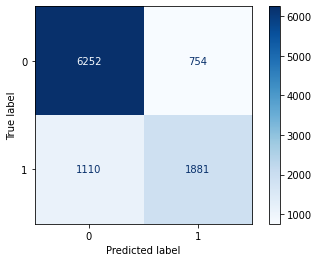

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_knn_entro = cm_knn_entro[0,0]
FP_knn_entro = cm_knn_entro[0,1]
TN_knn_entro = cm_knn_entro[1,0]
FN_knn_entro = cm_knn_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_entro_test = accuracy_score(y_test,y_pred_test)
f1_knn_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_entro_test)
print("f1 score : ",f1_knn_entro_test)
print("precision score : ",prec_knn_entro_test)
print("recall score : ",rec_knn_entro_test)

accuracy score :  0.8135440632189657
f1 score :  0.7694741919674564
precision score :  0.7815388731405489
recall score :  0.7606323108635069


In [ ]:
# AUC on test
auc_knn_entro_test = roc_auc_score(y_test,y_pred_test)
auc_knn_entro_test

0.7606323108635069

###### **NB**

In [ ]:
# training the model
gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# query all rejected applications
classifier_entropy(learner, X_pool)[:1000]

array([1.10197968e-03, 8.06412118e-03, 3.53124972e-02, 1.60042154e-01,
       6.53704042e-01, 2.32067387e-01, 4.71409294e-02, 2.96323479e-04,
       3.86906065e-01, 6.72911453e-01, 1.50709784e-01, 3.00701420e-03,
       2.26810074e-01, 1.38221412e-01, 2.62665238e-02, 5.12133187e-02,
       4.45635465e-04, 5.46053640e-05, 8.59925415e-02, 1.58995882e-02,
       2.95670243e-01, 2.05096046e-01, 1.49256484e-04, 7.32110818e-02,
       1.14320853e-05, 3.76806140e-03, 3.90896879e-01, 1.10438777e-02,
       7.36507325e-08, 6.84764418e-02, 6.26980150e-13, 2.73382743e-01,
       8.61387424e-03, 1.81941678e-02, 3.35596858e-02, 5.55017199e-02,
       1.81192864e-01, 2.54417154e-02, 6.63238632e-02, 1.94344676e-04,
       1.96067746e-07, 1.59642732e-03, 3.42569516e-02, 3.58873318e-01,
       4.98215487e-01, 4.98296098e-01, 1.31126967e-02, 1.20721129e-01,
       3.45686802e-01, 8.24347741e-03, 7.55093028e-02, 6.22543559e-03,
       1.46085605e-02, 2.47118329e-02, 2.02644083e-04, 4.58589508e-02,
      

In [ ]:
# Active learning process
history_entro_gm = [initial_score]
num_q= 100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_entropy(learner, X_pool[stream_idx].reshape(1, -1))>=0.5 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_entro_gm.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 4894 queried, new accuracy: 0.796800
Example no. 17618 queried, new accuracy: 0.796800
Example no. 24329 queried, new accuracy: 0.796800
Example no. 28442 queried, new accuracy: 0.796600
Example no. 29510 queried, new accuracy: 0.796800
Example no. 21924 queried, new accuracy: 0.796800
Example no. 515 queried, new accuracy: 0.796800
Example no. 16598 queried, new accuracy: 0.796600
Example no. 10190 queried, new accuracy: 0.796600
Example no. 19787 queried, new accuracy: 0.796400
Example no. 4778 queried, new accuracy: 0.796400
Example no. 11409 queried, new accuracy: 0.796200
Example no. 1628 queried, new accuracy: 0.796000
Example no. 27318 queried, new accuracy: 0.795800
Example no. 26584 queried, new accuracy: 0.796000
Example no. 28667 queried, new accuracy: 0.796000
Example no. 14145 queried, new accuracy: 0.795800
Example no. 1881 queried, new accuracy: 0.795800
Example no. 29156 queried, new accuracy: 0.795800
Example no. 17524 queried, new accuracy: 0.796000
Exampl

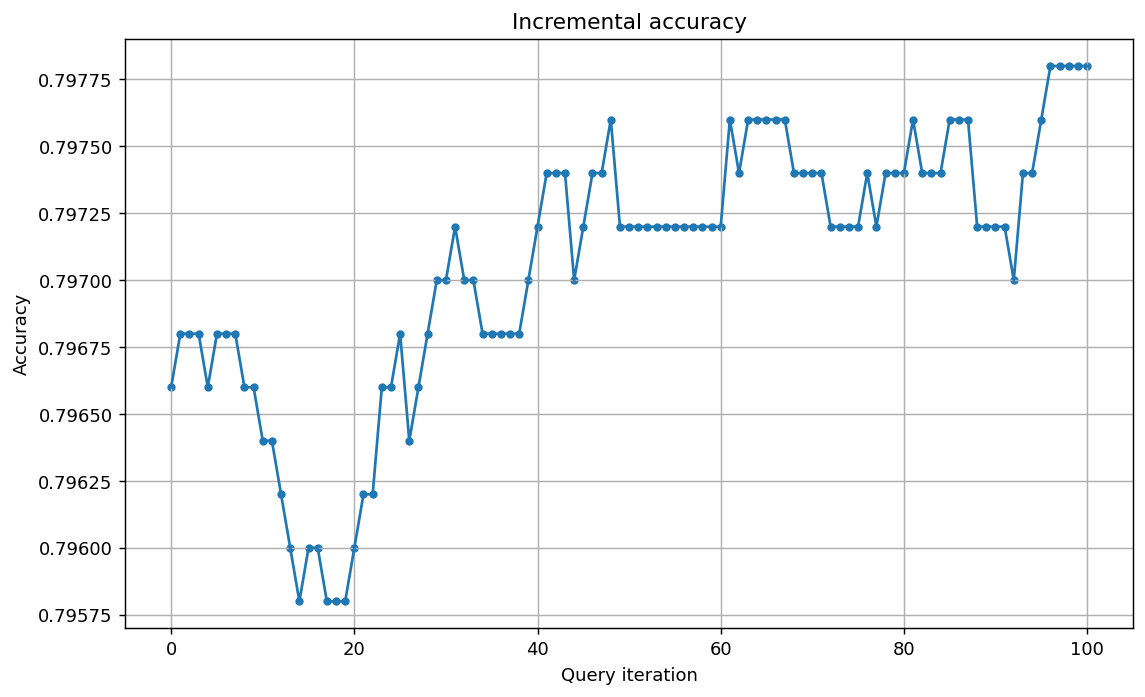

In [ ]:
# plot our performance over time
plot_performance_model(history_entro_gm)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_gm_entro = accuracy_score(y_train_new,y_pred_train)
f1_gm_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_entro)
print("f1 score : ",f1_gm_entro)
print("precision score : ",prec_gm_entro)
print("recall score : ",rec_gm_entro)


accuracy score :  0.7978
f1 score :  0.7652841461768549
precision score :  0.7633081782150188
recall score :  0.7674361464160615


In [ ]:
# AUC on train
auc_gm_entro = roc_auc_score(y_train_new,y_pred_train)
auc_gm_entro 

0.7674361464160615

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of gm classifier on test set: 0.80


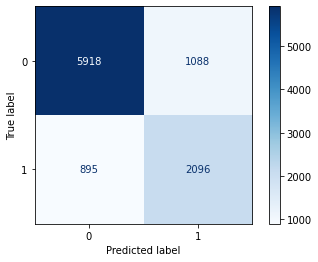

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_gm_entro = cm_gm_entro[0,0]
FP_gm_entro = cm_gm_entro[0,1]
FN_gm_entro = cm_gm_entro[1,0]
TN_gm_entro = cm_gm_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_entro_test = accuracy_score(y_test,y_pred_test)
f1_gm_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_entro_test)
print("f1 score : ",f1_gm_entro_test)
print("precision score : ",prec_gm_entro_test)
print("recall score : ",rec_gm_entro_test)

accuracy score :  0.8016404921476443
f1 score :  0.7676841572053732
precision score :  0.7634624760379027
recall score :  0.7727367562770144


In [ ]:
# AUC on test
auc_gm_entro_test = roc_auc_score(y_test,y_pred_test)
auc_gm_entro_test

0.7727367562770144

###### **DT**

In [ ]:
# training the model
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - DT: {initial_score}")

Prediction Accuracy - DT: 0.8594


In [ ]:
# query unlabeled set
classifier_entropy(learner, X_pool)[:1000]

array([0.48135334, 0.        , 0.03886446, 0.40609642, 0.1849074 ,
       0.20282274, 0.32954411, 0.36252071, 0.20282274, 0.60115381,
       0.        , 0.32954411, 0.26610769, 0.        , 0.03886446,
       0.34185794, 0.        , 0.36252071, 0.10071113, 0.        ,
       0.3488321 , 0.26936514, 0.36252071, 0.26610769, 0.63651417,
       0.        , 0.65439125, 0.03886446, 0.54559457, 0.34185794,
       0.34185794, 0.        , 0.36252071, 0.10071113, 0.        ,
       0.        , 0.34185794, 0.11690685, 0.        , 0.10071113,
       0.        , 0.        , 0.10071113, 0.61596293, 0.        ,
       0.28683598, 0.11690685, 0.        , 0.54559457, 0.10071113,
       0.        , 0.10071113, 0.        , 0.03886446, 0.36252071,
       0.        , 0.34185794, 0.10071113, 0.26610769, 0.03886446,
       0.58595262, 0.26936514, 0.        , 0.26610769, 0.03886446,
       0.        , 0.        , 0.4938351 , 0.34185794, 0.26936514,
       0.10071113, 0.51352896, 0.43007162, 0.26610769, 0.36252

In [ ]:
# active learning process
history_entro_dt = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_entropy(learner, X_pool[stream_idx].reshape(1, -1))>=0.5 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_entro_dt.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 18214 queried, new accuracy: 0.859400
Example no. 8407 queried, new accuracy: 0.859200
Example no. 16451 queried, new accuracy: 0.859200
Example no. 17275 queried, new accuracy: 0.859200
Example no. 8098 queried, new accuracy: 0.860800
Example no. 22860 queried, new accuracy: 0.860800
Example no. 10951 queried, new accuracy: 0.860800
Example no. 4386 queried, new accuracy: 0.860400
Example no. 15797 queried, new accuracy: 0.860400
Example no. 22480 queried, new accuracy: 0.862800
Example no. 11499 queried, new accuracy: 0.860400
Example no. 21363 queried, new accuracy: 0.860400
Example no. 12870 queried, new accuracy: 0.860400
Example no. 17040 queried, new accuracy: 0.860400
Example no. 18426 queried, new accuracy: 0.860400
Example no. 18467 queried, new accuracy: 0.860400
Example no. 17961 queried, new accuracy: 0.861800
Example no. 6345 queried, new accuracy: 0.861800
Example no. 11923 queried, new accuracy: 0.861800
Example no. 10540 queried, new accuracy: 0.860400
Exam

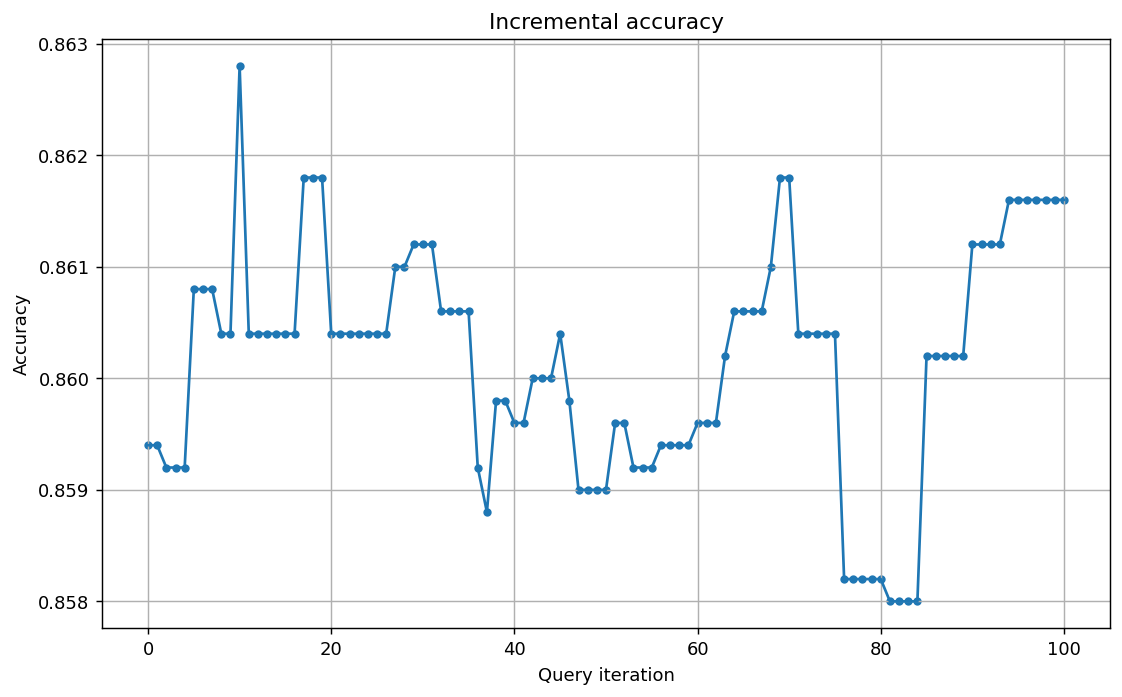

In [ ]:
# plot our performance over time
plot_performance_model(history_entro_dt)

In [ ]:
# make prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_entro = accuracy_score(y_train_new,y_pred_train)
f1_dt_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_entro)
print("f1 score : ",f1_dt_entro)
print("precision score : ",prec_dt_entro)
print("recall score : ",rec_dt_entro)

accuracy score :  0.8616
f1 score :  0.8359833867287996
precision score :  0.840645792010756
recall score :  0.8318251313089562


In [ ]:
# AUC on train
auc_dt_entro = roc_auc_score(y_train_new,y_pred_train)
auc_dt_entro

0.8318251313089562

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of dt classifier on test set: 0.80


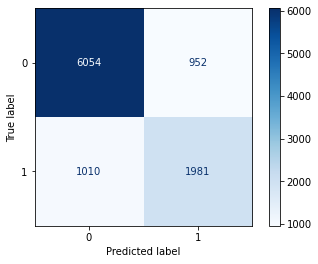

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_dt_entro = cm_dt_entro[0,0]
FP_dt_entro = cm_dt_entro[0,1]
FN_dt_entro = cm_dt_entro[1,0]
TN_dt_entro = cm_dt_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_entro_test = accuracy_score(y_test,y_pred_test)
f1_dt_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_entro_test)
print("f1 score : ",f1_dt_entro_test)
print("precision score : ",prec_dt_entro_test)
print("recall score : ",rec_dt_entro_test)

accuracy score :  0.8070421126337901
f1 score :  0.7688857278745793
precision score :  0.7701423066579747
recall score :  0.7676811240649344


In [ ]:
# AUC on test
auc_dt_entro_test = roc_auc_score(y_test,y_pred_test)
auc_dt_entro_test

0.7676811240649344

###### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,solver = 'adam',
                       learning_rate_init= nn_train.best_estimator_.learning_rate_init , random_state = seed, max_iter = 1000 )


learner = ActiveLearner(estimator=mlp_nn, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - NN: {initial_score}")


Prediction Accuracy - NN: 0.8142


In [ ]:
# query all rejected applications
classifier_entropy(learner, X_pool)[:1000]

array([4.15926874e-01, 6.00772285e-01, 1.81942051e-01, 3.46994862e-01,
       4.23081504e-01, 1.17589154e-01, 3.13250857e-01, 5.33403500e-01,
       3.40814220e-01, 6.87311877e-01, 1.14669642e-01, 6.07763754e-02,
       1.93372448e-01, 1.15861368e-01, 8.33572199e-02, 3.09750298e-01,
       4.78871576e-02, 4.46344926e-01, 2.07453292e-01, 1.04420299e-01,
       6.10780492e-01, 5.71799855e-01, 4.08173882e-01, 6.71034263e-02,
       1.30179283e-01, 3.73021398e-01, 1.52044518e-01, 5.97483571e-01,
       2.64659223e-01, 3.96700232e-01, 6.36836009e-01, 3.76615602e-01,
       9.13778799e-02, 4.98837274e-02, 3.02894086e-02, 5.85819456e-01,
       1.85129403e-01, 4.10497956e-02, 9.04378247e-02, 3.61912372e-04,
       4.69104959e-02, 8.23870301e-02, 6.27593844e-01, 2.00062473e-01,
       6.22641271e-01, 2.07540492e-01, 1.11779256e-01, 6.69799223e-01,
       1.33436126e-01, 4.98964126e-02, 1.58990701e-01, 3.36474554e-02,
       1.30961517e-01, 4.56849384e-01, 2.46485610e-02, 2.75200856e-01,
      

In [ ]:
# Active learning process
history_entro_nn = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_entropy(learner, X_pool[stream_idx].reshape(1, -1))>=0.6 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_entro_nn.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 10806 queried, new accuracy: 0.811200
Example no. 578 queried, new accuracy: 0.813000
Example no. 15951 queried, new accuracy: 0.810200
Example no. 18894 queried, new accuracy: 0.818600
Example no. 7343 queried, new accuracy: 0.816800
Example no. 7709 queried, new accuracy: 0.819200
Example no. 20085 queried, new accuracy: 0.812800
Example no. 580 queried, new accuracy: 0.822800
Example no. 20191 queried, new accuracy: 0.818200
Example no. 12036 queried, new accuracy: 0.815400
Example no. 21054 queried, new accuracy: 0.822600
Example no. 9483 queried, new accuracy: 0.821200
Example no. 6312 queried, new accuracy: 0.819800
Example no. 24948 queried, new accuracy: 0.822800
Example no. 516 queried, new accuracy: 0.825200
Example no. 17563 queried, new accuracy: 0.821400
Example no. 10832 queried, new accuracy: 0.818200
Example no. 29005 queried, new accuracy: 0.821000
Example no. 17659 queried, new accuracy: 0.823400
Example no. 22466 queried, new accuracy: 0.818200
Example no

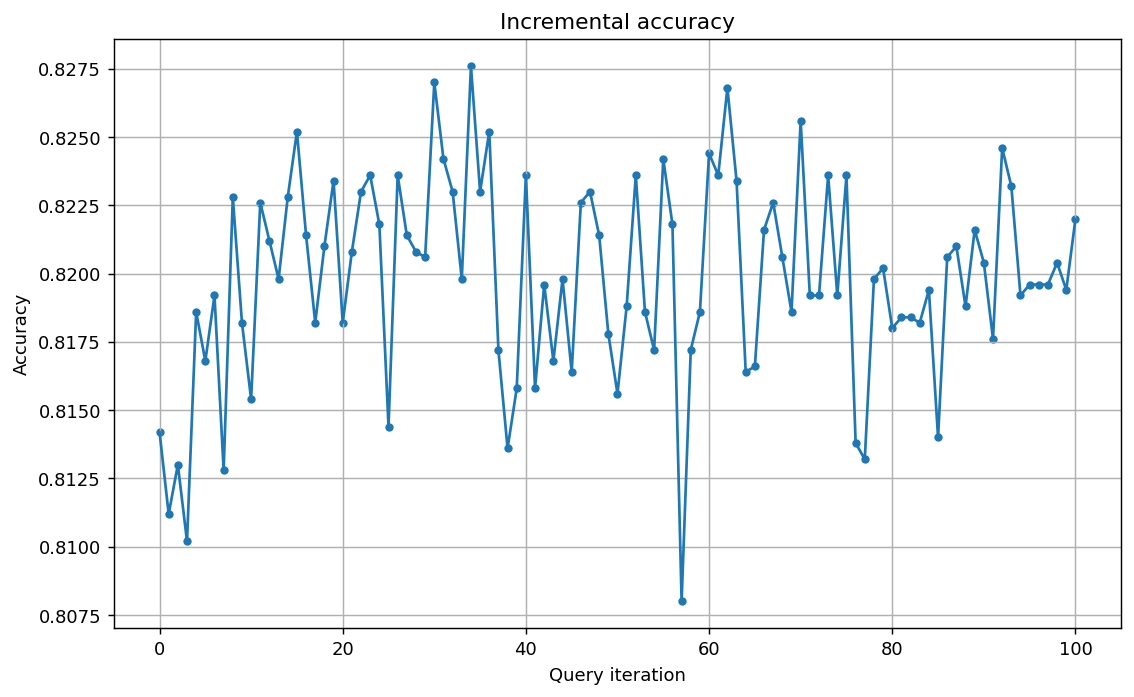

In [ ]:
# Display learning curve
plot_performance_model(history_entro_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_entro = accuracy_score(y_train_new,y_pred_train)
f1_nn_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_entro)
print("f1 score : ",f1_nn_entro)
print("precision score : ",prec_nn_entro)
print("recall score : ",rec_nn_entro)

accuracy score :  0.822
f1 score :  0.7836104513526145
precision score :  0.7973414169151632
recall score :  0.7738960584567984


In [ ]:
# AUC on train
auc_nn_entro = roc_auc_score(y_train_new,y_pred_train)
auc_nn_entro

0.7738960584567984

Accuracy of dt classifier on test set: 0.82


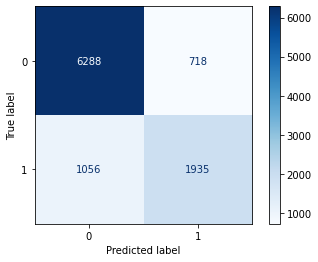

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_nn_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(mlp_nn, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_nn_entro = cm_nn_entro[0,0]
FP_nn_entro = cm_nn_entro[0,1]
FN_nn_entro = cm_nn_entro[1,0]
TN_nn_entro = cm_nn_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_entro_test = accuracy_score(y_test,y_pred_test)
f1_nn_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_entro_test)
print("f1 score : ",f1_nn_entro_test)
print("precision score : ",prec_nn_entro_test)
print("recall score : ",rec_nn_entro_test)

accuracy score :  0.8225467640292088
f1 score :  0.7810301093696368
precision score :  0.792786067813229
recall score :  0.772228618484629


In [ ]:
# AUC on test
auc_nn_entro_test = roc_auc_score(y_test,y_pred_test)
auc_nn_entro_test

0.772228618484629

###### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_entro, auc_lr_entro],
            'K Nearest Neighbour (KNN)': [acc_knn_entro, auc_knn_entro],
            'Support Vector Machine (SVC)': [acc_svc_entro, auc_svc_entro],
            'Decision Trees (DT)': [acc_dt_entro, auc_dt_entro],
            'Naive Bayes (NB)': [acc_gm_entro, auc_gm_entro],
            'Neural Networks (NN)': [acc_nn_entro, auc_nn_entro]
             }
dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7882     0.773509
K Nearest Neighbour (KNN)          0.8236     0.776839
Support Vector Machine (SVC)       0.7914     0.776902
Decision Trees (DT)                0.8616     0.831825
Naive Bayes (NB)                   0.7978     0.767436
Neural Networks (NN)               0.8220     0.773896

In [ ]:
# Creating performance table of test
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_entro_test, auc_lr_entro_test],
            'K Nearest Neighbour (KNN)': [acc_knn_entro_test, auc_knn_entro_test],
            'Support Vector Machine (SVC)': [acc_svc_entro_test, auc_svc_entro_test],
            'Decision Trees (DT)': [acc_dt_entro_test, auc_dt_entro_test],
            'Naive Bayes (NB)': [acc_gm_entro_test, auc_gm_entro_test],
            'Neural Networks (NN)': [acc_nn_entro_test, auc_nn_entro_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.790537    0.774300
K Nearest Neighbour (KNN)       0.813544    0.760632
Support Vector Machine (SVC)    0.794138    0.774665
Decision Trees (DT)             0.807042    0.767681
Naive Bayes (NB)                0.801640    0.772737
Neural Networks (NN)            0.822547    0.772229

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_entro, FP_lr_entro, TN_lr_entro, FN_lr_entro],
            'K Nearest Neighbour (KNN)': [TP_knn_entro, FP_knn_entro, TN_knn_entro, FN_knn_entro],
            'Support Vector Machine (SVC)': [TP_svc_entro, FP_svc_entro, TN_svc_entro, FN_svc_entro],
            'Decision Trees (DT)': [TP_dt_entro, FP_dt_entro, TN_dt_entro, FN_dt_entro],
            'Naive Bayes (NB)': [TP_gm_entro, FP_gm_entro, TN_gm_entro, FN_gm_entro],
            'Neural Networks (NN)': [TP_nn_entro, FP_nn_entro, TN_nn_entro,FN_nn_entro]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5708  1298  2195   796
K Nearest Neighbour (KNN)     6252   754  1881  1110
Support Vector Machine (SVC)  5767  1239  2172   819
Decision Trees (DT)           6054   952  1981  1010
Naive Bayes (NB)              5918  1088  2096   895
Neural Networks (NN)          6288   718  1935  1056

##### **classification uncertainty**

###### **SVC**

In [ ]:
# define Learner, including training data as starting point
svc = SVC(C=svc_train.best_estimator_.C ,kernel='linear', random_state=seed, class_weight='balanced', probability=True)
learner = ActiveLearner(estimator=svc, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# query unabeled set
classifier_uncertainty(learner, X_pool)[:1000]

array([0.16989878, 0.3272824 , 0.14204166, 0.16588234, 0.22704446,
       0.10299727, 0.12045154, 0.14081807, 0.14567852, 0.23926063,
       0.1099321 , 0.05942166, 0.12362567, 0.08518631, 0.08772098,
       0.20790596, 0.06864223, 0.10064426, 0.08401146, 0.05607173,
       0.39401792, 0.17842819, 0.11352234, 0.08028178, 0.20744153,
       0.20757014, 0.13483276, 0.02482127, 0.15438485, 0.30429275,
       0.23061142, 0.17392297, 0.04891017, 0.05442294, 0.07283948,
       0.37985964, 0.11726547, 0.07000612, 0.09619755, 0.01027442,
       0.06843067, 0.059029  , 0.45118195, 0.28628964, 0.28055972,
       0.15737888, 0.12276622, 0.17578062, 0.04956143, 0.08334627,
       0.11076879, 0.08150581, 0.0627321 , 0.11416261, 0.07248686,
       0.15535748, 0.43592901, 0.16566865, 0.0461307 , 0.21043642,
       0.16586109, 0.05984748, 0.2143054 , 0.07469739, 0.15717266,
       0.05240586, 0.09751285, 0.15786199, 0.09060521, 0.05908212,
       0.25059129, 0.19151796, 0.12672535, 0.30422042, 0.24277

In [ ]:
# active learning process
history_uncert_svc = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_uncertainty(learner, X_pool[stream_idx].reshape(1, -1))>=0.3 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
# new score
      new_score = learner.score(X_train_new, y_train_new)
      history_uncert_svc.append(new_score)
# delete the selected instance
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 18990 queried, new accuracy: 0.788600
Example no. 6732 queried, new accuracy: 0.788400
Example no. 28179 queried, new accuracy: 0.788800
Example no. 18756 queried, new accuracy: 0.788600
Example no. 3984 queried, new accuracy: 0.788600
Example no. 24287 queried, new accuracy: 0.788600
Example no. 18751 queried, new accuracy: 0.788600
Example no. 11561 queried, new accuracy: 0.788800
Example no. 15684 queried, new accuracy: 0.788800
Example no. 944 queried, new accuracy: 0.788800
Example no. 26107 queried, new accuracy: 0.788200
Example no. 15852 queried, new accuracy: 0.788200
Example no. 14603 queried, new accuracy: 0.788400
Example no. 24204 queried, new accuracy: 0.788200
Example no. 12327 queried, new accuracy: 0.787600
Example no. 14062 queried, new accuracy: 0.787600
Example no. 27920 queried, new accuracy: 0.787600
Example no. 23370 queried, new accuracy: 0.787600
Example no. 13427 queried, new accuracy: 0.787600
Example no. 9302 queried, new accuracy: 0.788200
Examp

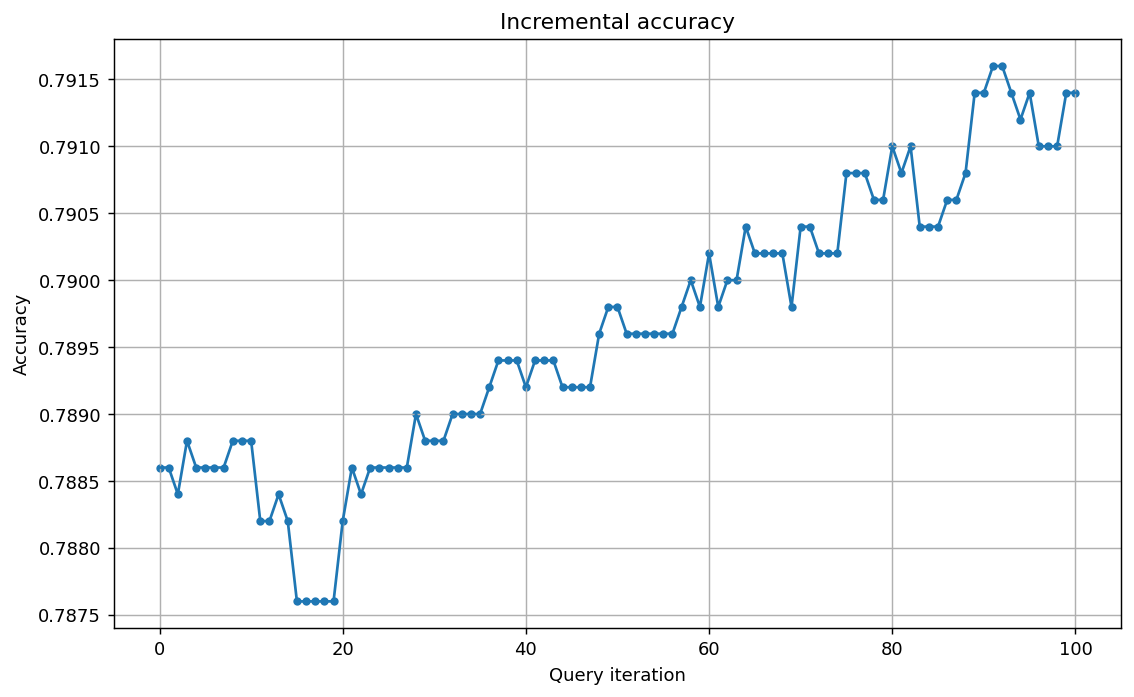

In [ ]:
# plot our performance over time
plot_performance_model(history_uncert_svc)


In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_svc_uncert = accuracy_score(y_train_new,y_pred_train)
f1_svc_uncert = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_uncert = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_uncert = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_uncert)
print("f1 score : ",f1_svc_uncert)
print("precision score : ",prec_svc_uncert)
print("recall score : ",rec_svc_uncert)


accuracy score :  0.7914
f1 score :  0.7639521160006744
precision score :  0.7573529825687273
recall score :  0.7738635787135812


In [ ]:
# AUC on train
auc_svc_uncert = roc_auc_score(y_train_new,y_pred_train)
auc_svc_uncert

0.7738635787135812

In [ ]:
# Check the performance on test set

print('Accuracy of SVC classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of SVC classifier on test set: 0.79


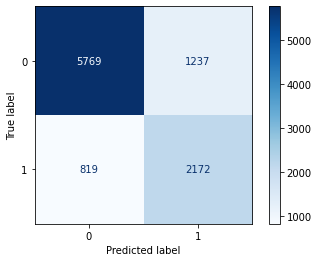

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_uncert = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_svc_uncert = cm_svc_uncert[0,0]
FP_svc_uncert = cm_svc_uncert[0,1]
FN_svc_uncert = cm_svc_uncert[1,0]
TN_svc_uncert = cm_svc_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_uncert_test = accuracy_score(y_test,y_pred_test)
f1_svc_uncert_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_uncert_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_uncert_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_uncert_test)
print("f1 score : ",f1_svc_uncert_test)
print("precision score : ",prec_svc_uncert_test)
print("recall score : ",rec_svc_uncert_test)

accuracy score :  0.7943383014904472
f1 score :  0.7637534022362806
precision score :  0.7564100252145158
recall score :  0.7748077947802872


In [ ]:
# AUC on test
auc_svc_uncert_test = roc_auc_score(y_test,y_pred_test)
auc_svc_uncert_test

0.7748077947802872

###### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# query rejected applications
classifier_uncertainty(learner, X_pool)[:1000]

array([0.12036083, 0.25435595, 0.29998911, 0.34968475, 0.41051383,
       0.2378548 , 0.30681174, 0.11837549, 0.30743463, 0.3978485 ,
       0.25027227, 0.18424119, 0.28509134, 0.20861022, 0.22324725,
       0.38144742, 0.18940053, 0.07163622, 0.22175965, 0.15432555,
       0.2994492 , 0.38067075, 0.09662317, 0.19745963, 0.38578884,
       0.39159255, 0.28857606, 0.10214971, 0.3309865 , 0.3746881 ,
       0.44216433, 0.12439609, 0.1482992 , 0.14914407, 0.19603443,
       0.45915032, 0.27204619, 0.18511398, 0.26834108, 0.04643906,
       0.17322872, 0.17096024, 0.33892497, 0.4785504 , 0.48208606,
       0.31423526, 0.2748928 , 0.36852941, 0.15768472, 0.19934885,
       0.26303307, 0.21105815, 0.19434778, 0.09639717, 0.18900161,
       0.31728113, 0.40262135, 0.34293066, 0.12392782, 0.39726441,
       0.36268427, 0.14451421, 0.41352774, 0.21385354, 0.29313412,
       0.14815628, 0.26468604, 0.34562202, 0.25504854, 0.16870334,
       0.41228838, 0.13405443, 0.29110698, 0.22169737, 0.41078

In [ ]:
# Active learning process
history_uncert_lr = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_uncertainty(learner, X_pool[stream_idx].reshape(1, -1))>=0.4 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_uncert_lr.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 13616 queried, new accuracy: 0.787000
Example no. 18839 queried, new accuracy: 0.787000
Example no. 2752 queried, new accuracy: 0.787400
Example no. 2344 queried, new accuracy: 0.787200
Example no. 22934 queried, new accuracy: 0.787200
Example no. 6439 queried, new accuracy: 0.787200
Example no. 20374 queried, new accuracy: 0.787000
Example no. 25656 queried, new accuracy: 0.787200
Example no. 24274 queried, new accuracy: 0.787000
Example no. 19561 queried, new accuracy: 0.787200
Example no. 5025 queried, new accuracy: 0.787000
Example no. 19370 queried, new accuracy: 0.787000
Example no. 6136 queried, new accuracy: 0.787000
Example no. 26794 queried, new accuracy: 0.786800
Example no. 6182 queried, new accuracy: 0.786600
Example no. 19118 queried, new accuracy: 0.787000
Example no. 6449 queried, new accuracy: 0.787400
Example no. 9413 queried, new accuracy: 0.787800
Example no. 5815 queried, new accuracy: 0.787800
Example no. 10393 queried, new accuracy: 0.788000
Example n

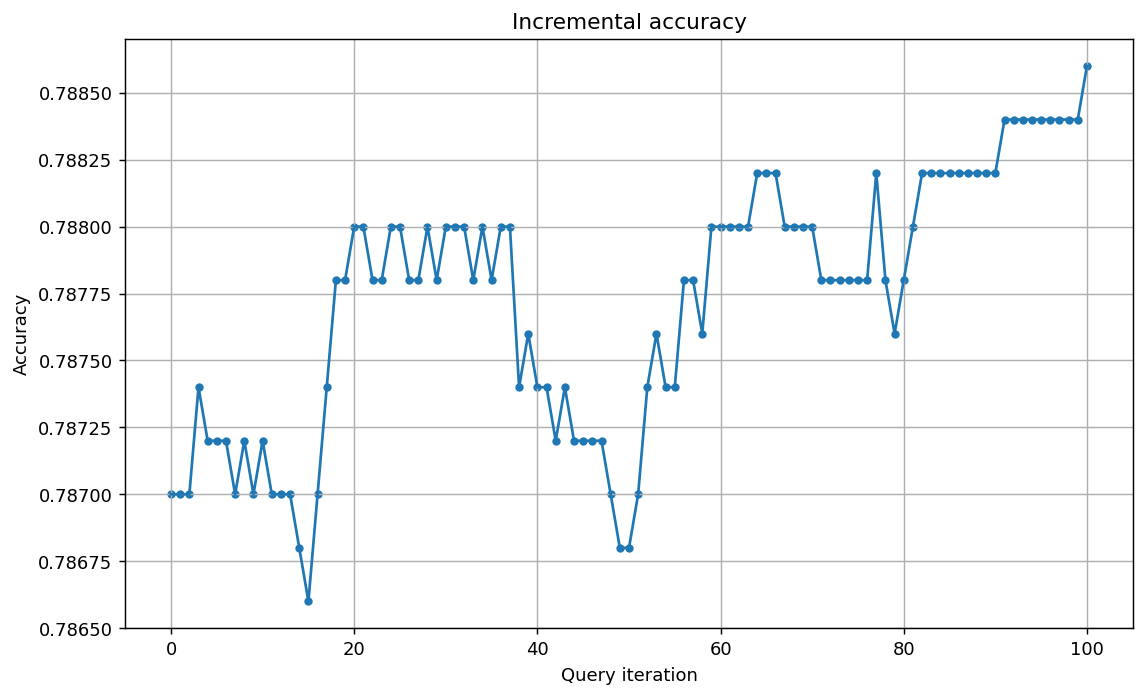

In [ ]:
# Display learning curve
plot_performance_model(history_uncert_lr)

In [ ]:
# predictions
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_lr_uncert = accuracy_score(y_train_new,y_pred_train)
f1_lr_uncert = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_uncert = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_uncert = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_uncert)
print("f1 score : ",f1_lr_uncert)
print("precision score : ",prec_lr_uncert)
print("recall score : ",rec_lr_uncert)


accuracy score :  0.7886
f1 score :  0.7620201119797816
precision score :  0.7548834453226415
recall score :  0.7736204018464967


In [ ]:
# AUC on train
auc_lr_uncert = roc_auc_score(y_train_new,y_pred_train)
auc_lr_uncert

0.7736204018464967

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of lr classifier on test set: 0.79


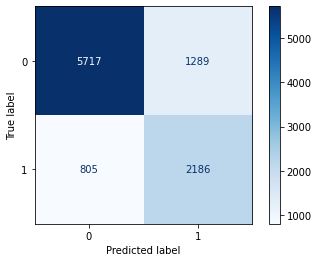

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_uncert = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_lr_uncert = cm_lr_uncert[0,0]
FP_lr_uncert = cm_lr_uncert[0,1]
FN_lr_uncert = cm_lr_uncert[1,0]
TN_lr_uncert = cm_lr_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_uncert_test = accuracy_score(y_test,y_pred_test)
f1_lr_uncert_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_uncert_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_uncert_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_uncert_test)
print("f1 score : ",f1_lr_uncert_test)
print("precision score : ",prec_lr_uncert_test)
print("recall score : ",rec_lr_uncert_test)

accuracy score :  0.7905371611483445
f1 score :  0.7606810577934566
precision score :  0.7528181760019768
recall score :  0.7734370444094678


In [ ]:
# AUC on test
auc_lr_uncert_test = roc_auc_score(y_test,y_pred_test)
auc_lr_uncert_test

0.7734370444094678

###### **KNN**

In [ ]:
# training the model
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - KNN: {initial_score}")

Prediction Accuracy - KNN: 0.8218


In [ ]:
# query the rejected applications
classifier_uncertainty(learner, X_pool)[:1000]

array([0.27272727, 0.27272727, 0.04545455, 0.31818182, 0.31818182,
       0.18181818, 0.09090909, 0.18181818, 0.18181818, 0.45454545,
       0.04545455, 0.04545455, 0.09090909, 0.        , 0.04545455,
       0.04545455, 0.04545455, 0.13636364, 0.18181818, 0.        ,
       0.18181818, 0.22727273, 0.18181818, 0.04545455, 0.09090909,
       0.27272727, 0.09090909, 0.18181818, 0.09090909, 0.31818182,
       0.45454545, 0.22727273, 0.04545455, 0.        , 0.        ,
       0.09090909, 0.04545455, 0.04545455, 0.27272727, 0.        ,
       0.        , 0.        , 0.27272727, 0.        , 0.45454545,
       0.09090909, 0.04545455, 0.27272727, 0.09090909, 0.09090909,
       0.04545455, 0.        , 0.18181818, 0.09090909, 0.04545455,
       0.13636364, 0.36363636, 0.27272727, 0.        , 0.22727273,
       0.18181818, 0.09090909, 0.22727273, 0.04545455, 0.        ,
       0.        , 0.09090909, 0.09090909, 0.09090909, 0.04545455,
       0.22727273, 0.27272727, 0.18181818, 0.18181818, 0.09090

In [ ]:
# Active learning process
history_uncert_knn = [initial_score]
num_q= 100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_uncertainty(learner, X_pool[stream_idx].reshape(1, -1))>=0.3:
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_uncert_knn.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 25614 queried, new accuracy: 0.821400
Example no. 12226 queried, new accuracy: 0.821400
Example no. 8233 queried, new accuracy: 0.821400
Example no. 21224 queried, new accuracy: 0.821600
Example no. 6962 queried, new accuracy: 0.821400
Example no. 24050 queried, new accuracy: 0.821600
Example no. 6657 queried, new accuracy: 0.821600
Example no. 20251 queried, new accuracy: 0.822000
Example no. 22175 queried, new accuracy: 0.822200
Example no. 18911 queried, new accuracy: 0.822200
Example no. 6977 queried, new accuracy: 0.822400
Example no. 10251 queried, new accuracy: 0.822400
Example no. 24487 queried, new accuracy: 0.822000
Example no. 24388 queried, new accuracy: 0.822000
Example no. 25933 queried, new accuracy: 0.822200
Example no. 25237 queried, new accuracy: 0.822200
Example no. 12233 queried, new accuracy: 0.822200
Example no. 12204 queried, new accuracy: 0.822400
Example no. 6076 queried, new accuracy: 0.822400
Example no. 23912 queried, new accuracy: 0.822400
Examp

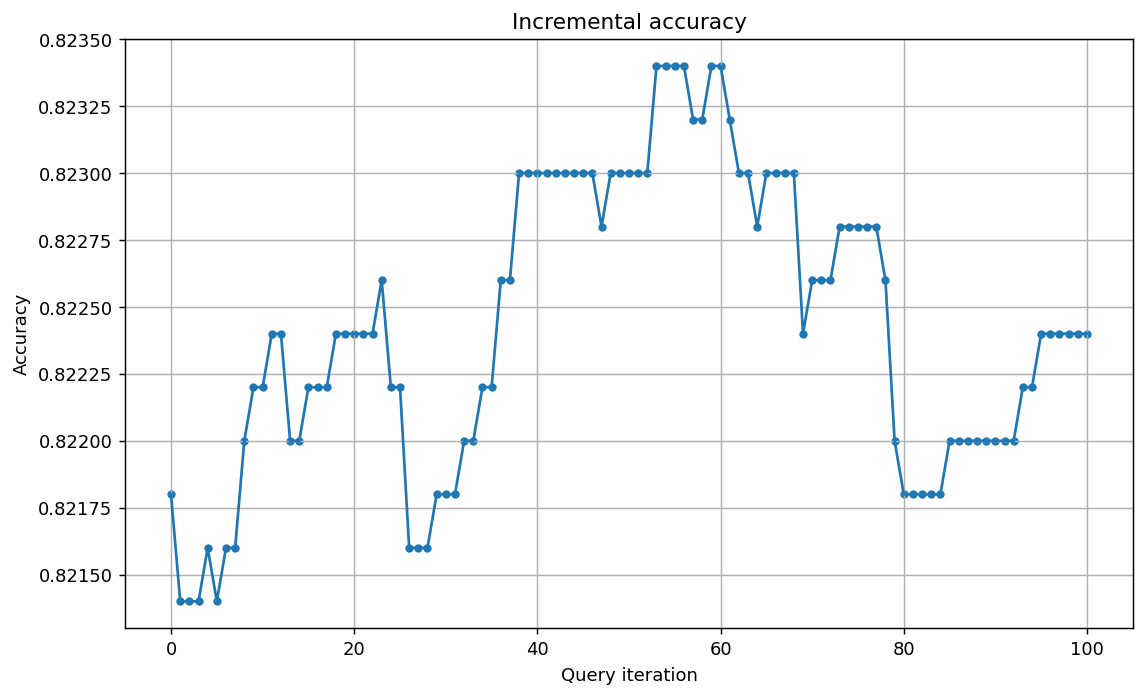

In [ ]:
# plot performance over time
plot_performance_model(history_uncert_knn)

In [ ]:
# compute confusion matrix
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_uncert = accuracy_score(y_train_new,y_pred_train)
f1_knn_uncert = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_uncert = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_uncert = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_uncert)
print("f1 score : ",f1_knn_uncert)
print("precision score : ",prec_knn_uncert)
print("recall score : ",rec_knn_uncert)

accuracy score :  0.8224
f1 score :  0.7842732895932852
precision score :  0.797679783699092
recall score :  0.7747208754516978


In [ ]:
# AUC on train
auc_knn_uncert = roc_auc_score(y_train_new,y_pred_train)
auc_knn_uncert

0.7747208754516978

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of knn classifier on test set: 0.81


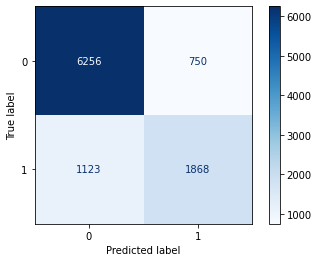

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_uncert = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_knn_uncert = cm_knn_uncert[0,0]
FP_knn_uncert = cm_knn_uncert[0,1]
FN_knn_uncert = cm_knn_uncert[1,0]
TN_knn_uncert = cm_knn_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_uncert_test = accuracy_score(y_test,y_pred_test)
f1_knn_uncert_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_uncert_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_uncert_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_uncert_test)
print("f1 score : ",f1_knn_uncert_test)
print("precision score : ",prec_knn_uncert_test)
print("recall score : ",rec_knn_uncert_test)

accuracy score :  0.8126437931379413
f1 score :  0.7679336544692406
precision score :  0.7806665644488401
recall score :  0.7587445942356521


In [ ]:
# AUC on test set
auc_knn_uncert_test = roc_auc_score(y_test,y_pred_test)
auc_knn_uncert_test

0.7587445942356521

###### **DT**

In [ ]:
from sklearn import tree

In [ ]:
# training the model
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - DT: {initial_score}")

Prediction Accuracy - DT: 0.8594


In [ ]:
# query the rejected applications
classifier_uncertainty(learner, X_pool)[:1000]

array([0.18666667, 0.        , 0.00643087, 0.140625  , 0.04545455,
       0.05147059, 0.10204082, 0.11780105, 0.05147059, 0.28888889,
       0.        , 0.10204082, 0.07488987, 0.        , 0.00643087,
       0.10778443, 0.        , 0.11780105, 0.02068966, 0.        ,
       0.11111111, 0.07619048, 0.11780105, 0.07488987, 0.        ,
       0.36170213, 0.00643087, 0.23529412, 0.10778443, 0.10778443,
       0.        , 0.11780105, 0.02068966, 0.        , 0.        ,
       0.10778443, 0.025     , 0.        , 0.02068966, 0.        ,
       0.        , 0.02068966, 0.30612245, 0.        , 0.08333333,
       0.025     , 0.        , 0.23529412, 0.02068966, 0.        ,
       0.02068966, 0.        , 0.00643087, 0.11780105, 0.        ,
       0.10778443, 0.02068966, 0.07488987, 0.00643087, 0.27272727,
       0.07619048, 0.        , 0.07488987, 0.00643087, 0.        ,
       0.        , 0.1953125 , 0.10778443, 0.07619048, 0.02068966,
       0.20967742, 0.15428571, 0.07488987, 0.11780105, 0.     

In [ ]:
# training the model
history_uncert_dt = [initial_score]
num_q= 100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_uncertainty(learner, X_pool[stream_idx].reshape(1, -1))>=0.3:
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_uncert_dt.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 20345 queried, new accuracy: 0.861800
Example no. 4311 queried, new accuracy: 0.861800
Example no. 22256 queried, new accuracy: 0.859400
Example no. 21325 queried, new accuracy: 0.859400
Example no. 22485 queried, new accuracy: 0.859600
Example no. 14301 queried, new accuracy: 0.859600
Example no. 23914 queried, new accuracy: 0.859600
Example no. 6589 queried, new accuracy: 0.859600
Example no. 1459 queried, new accuracy: 0.859600
Example no. 16307 queried, new accuracy: 0.859600
Example no. 22811 queried, new accuracy: 0.859400
Example no. 12736 queried, new accuracy: 0.859400
Example no. 22869 queried, new accuracy: 0.860800
Example no. 13613 queried, new accuracy: 0.860800
Example no. 13107 queried, new accuracy: 0.860800
Example no. 23824 queried, new accuracy: 0.860800
Example no. 5195 queried, new accuracy: 0.860800
Example no. 5761 queried, new accuracy: 0.860800
Example no. 23804 queried, new accuracy: 0.860800
Example no. 18402 queried, new accuracy: 0.860800
Examp

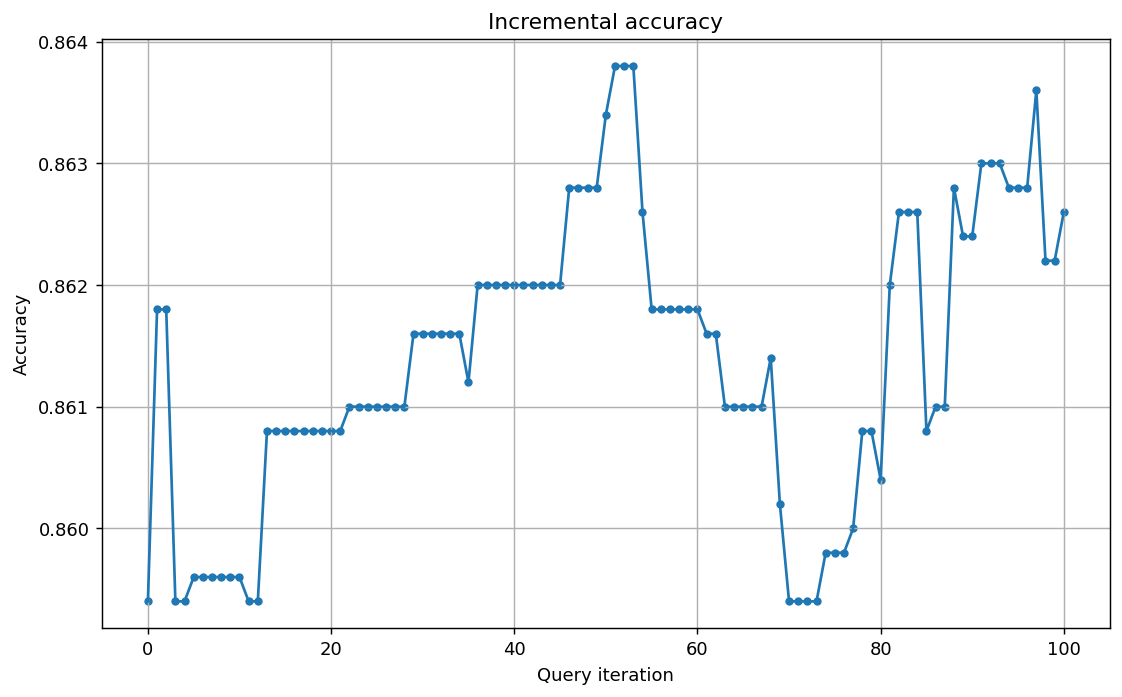

In [ ]:
# learning curve
plot_performance_model(history_uncert_dt)

In [ ]:
# predictions
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_uncert = accuracy_score(y_train_new,y_pred_train)
f1_dt_uncert = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_uncert = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_uncert= recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_uncert)
print("f1 score : ",f1_dt_uncert)
print("precision score : ",prec_dt_uncert)
print("recall score : ",rec_dt_uncert)

accuracy score :  0.8626
f1 score :  0.8345417087116174
precision score :  0.8459961517986522
recall score :  0.8255913606503886


In [ ]:
# AUC on train
auc_dt_uncert = roc_auc_score(y_train_new,y_pred_train)
auc_dt_uncert 

0.8255913606503886

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of dt classifier on test set: 0.80


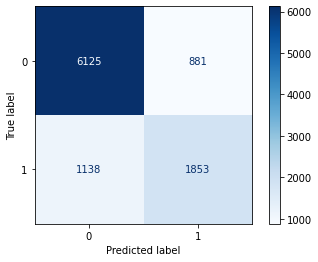

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_uncert = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_dt_uncert = cm_dt_uncert[0,0]
FP_dt_uncert = cm_dt_uncert[0,1]
FN_dt_uncert = cm_dt_uncert[1,0]
TN_dt_uncert = cm_dt_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_uncert_test = accuracy_score(y_test,y_pred_test)
f1_dt_uncert_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_uncert_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_uncert_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_uncert_test)
print("f1 score : ",f1_dt_uncert_test)
print("precision score : ",prec_dt_uncert_test)
print("recall score : ",rec_dt_uncert_test)

accuracy score :  0.8010403120936281
f1 score :  0.7596634060403507
precision score :  0.7633385779195503
recall score :  0.7564056237606148


In [ ]:
# AUC on test set
auc_dt_uncert_test = roc_auc_score(y_test,y_pred_test)
auc_dt_uncert_test

0.7564056237606148

###### **NB**

In [ ]:
# Training the Gaussian Model
from sklearn.naive_bayes import GaussianNB
gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# query the rejected applications 
classifier_uncertainty(learner, X_pool)[:1000]

array([1.08830341e-04, 1.02274920e-03, 5.73396771e-03, 3.75388945e-02,
       6.18645557e-02, 8.11354391e-03, 2.56054007e-05, 1.30273382e-01,
       3.46974969e-02, 3.33951344e-04, 5.99427883e-02, 3.10058524e-02,
       4.03422547e-03, 8.97005518e-03, 4.00563922e-05, 4.07153657e-06,
       1.69681286e-02, 8.70548096e-02, 5.22528859e-02, 1.21138376e-05,
       1.38938045e-02, 4.30633757e-04, 1.32385746e-01, 1.46799042e-03,
       3.60300056e-09, 1.27936360e-02, 1.77635684e-14, 7.78079651e-02,
       1.10305286e-03, 2.62047137e-03, 5.39596803e-03, 9.89135948e-03,
       4.42401044e-02, 3.88501179e-03, 1.01010521e-08, 1.64352879e-04,
       5.52994650e-03, 1.98428040e-01, 1.98485786e-01, 1.79025045e-03,
       2.60471981e-02, 1.09604096e-01, 1.04885040e-03, 1.44354798e-02,
       7.61010818e-04, 3.75382947e-03, 1.69039768e-05, 1.62136680e-03,
       5.03873313e-02, 1.07365768e-01, 1.61249538e-05, 2.01796906e-01,
       3.86106816e-03, 9.41899794e-08, 1.42544808e-01, 5.74001387e-03,
      

In [ ]:
# active learning process
history_uncert_gm = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_uncertainty(learner, X_pool[stream_idx].reshape(1, -1))>=0.2:
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_uncert_gm.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 23123 queried, new accuracy: 0.796600
Example no. 4075 queried, new accuracy: 0.796800
Example no. 18144 queried, new accuracy: 0.796600
Example no. 9100 queried, new accuracy: 0.796600
Example no. 21168 queried, new accuracy: 0.796600
Example no. 23643 queried, new accuracy: 0.796600
Example no. 21823 queried, new accuracy: 0.796800
Example no. 12057 queried, new accuracy: 0.796800
Example no. 4032 queried, new accuracy: 0.796600
Example no. 9245 queried, new accuracy: 0.796600
Example no. 7991 queried, new accuracy: 0.796400
Example no. 5258 queried, new accuracy: 0.796200
Example no. 10793 queried, new accuracy: 0.796400
Example no. 10984 queried, new accuracy: 0.796400
Example no. 10727 queried, new accuracy: 0.796400
Example no. 12500 queried, new accuracy: 0.796000
Example no. 19004 queried, new accuracy: 0.796200
Example no. 16413 queried, new accuracy: 0.796400
Example no. 14802 queried, new accuracy: 0.796200
Example no. 12247 queried, new accuracy: 0.796000
Exampl

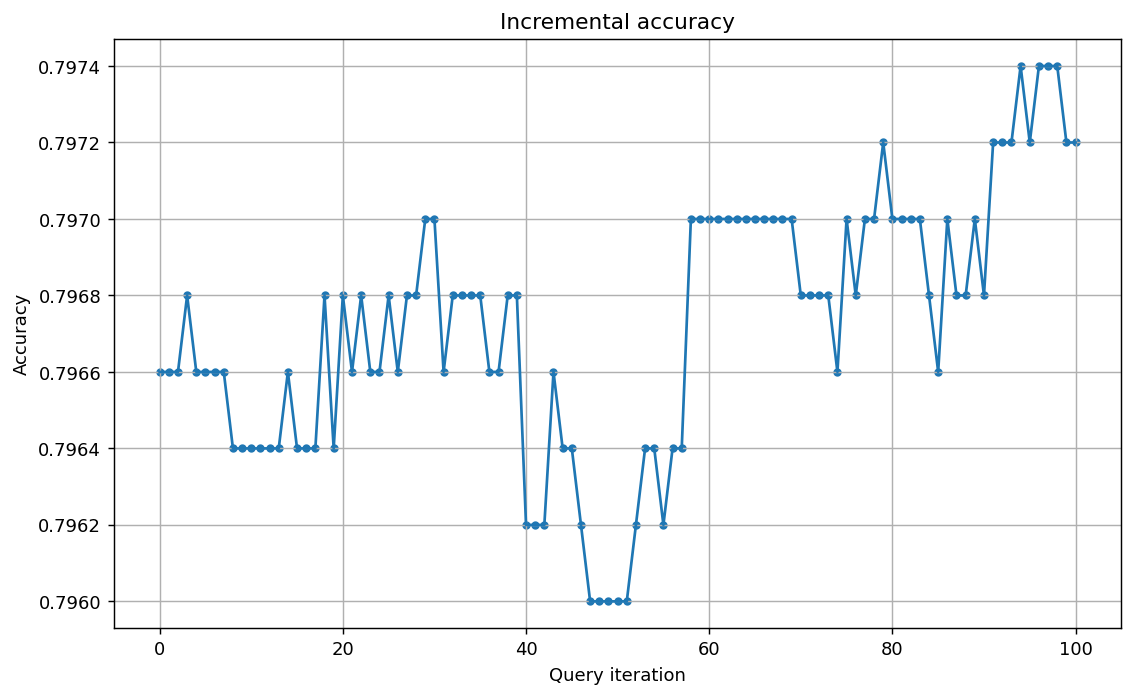

In [ ]:
# learning curve
plot_performance_model(history_uncert_gm)


In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_uncert = accuracy_score(y_train_new,y_pred_train)
f1_gm_uncert = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_uncert = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_uncert = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_uncert)
print("f1 score : ",f1_gm_uncert)
print("precision score : ",prec_gm_uncert)
print("recall score : ",rec_gm_uncert)

accuracy score :  0.7972
f1 score :  0.7646283263077751
precision score :  0.762616974653012
recall score :  0.7668233369669462


In [ ]:
# AUC on train
auc_gm_uncert = roc_auc_score(y_train_new,y_pred_train)
auc_gm_uncert

0.7668233369669462

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of gm classifier on test set: 0.80


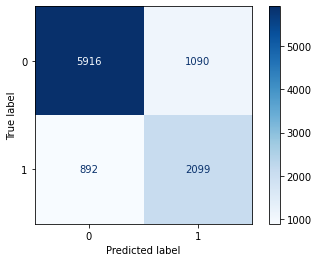

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_uncert = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_gm_uncert = cm_gm_uncert[0,0]
FP_gm_uncert = cm_gm_uncert[0,1]
FN_gm_uncert = cm_gm_uncert[1,0]
TN_gm_uncert = cm_gm_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_uncert_test = accuracy_score(y_test,y_pred_test)
f1_gm_uncert_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_uncert_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_uncert_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_uncert_test)
print("f1 score : ",f1_gm_uncert_test)
print("precision score : ",prec_gm_uncert_test)
print("recall score : ",rec_gm_uncert_test)

accuracy score :  0.801740522156647
f1 score :  0.7679051972507606
precision score :  0.7635888680205422
recall score :  0.7730955259918112


In [ ]:
# AUC on test
auc_gm_uncert_test = roc_auc_score(y_test,y_pred_test)
auc_gm_uncert_test

0.7730955259918112

###### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                       learning_rate_init= nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 )
learner = ActiveLearner(estimator=mlp_nn, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - NN: {initial_score}")

Prediction Accuracy - NN: 0.8142


In [ ]:
# query rejected applications
classifier_uncertainty(learner, X_pool)[:1000]

array([1.46124248e-01, 2.88465825e-01, 4.44841396e-02, 1.10229485e-01,
       1.50214803e-01, 2.51864350e-02, 9.46874859e-02, 2.25193867e-01,
       1.07291215e-01, 4.46037308e-01, 2.43914257e-02, 1.10508485e-02,
       4.82642775e-02, 2.47150833e-02, 1.63220450e-02, 9.31431788e-02,
       8.26912260e-03, 1.64062180e-01, 5.30685994e-02, 2.16571736e-02,
       2.99901113e-01, 2.58801755e-01, 1.41775719e-01, 1.24786162e-02,
       2.86958819e-02, 1.23082196e-01, 3.50995500e-02, 2.84858420e-01,
       7.43146354e-02, 1.35494827e-01, 3.33798353e-01, 1.24920587e-01,
       1.83077153e-02, 8.68841349e-03, 4.77621770e-03, 2.72591555e-01,
       4.55274848e-02, 6.86734352e-03, 1.80720262e-02, 3.18763577e-05,
       8.06562736e-03, 1.60857692e-02, 3.20963846e-01, 5.05264627e-02,
       3.14483676e-01, 5.30988630e-02, 2.36113772e-02, 3.92376410e-01,
       2.96249773e-02, 8.69109145e-03, 3.72152315e-02, 5.41279784e-03,
       2.89182395e-02, 1.70608264e-01, 3.74249598e-03, 7.85448220e-02,
      

In [ ]:
# active learning process
history_uncert_nn = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_uncertainty(learner, X_pool[stream_idx].reshape(1, -1))>=0.3:
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_uncert_nn.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 14291 queried, new accuracy: 0.802800
Example no. 27691 queried, new accuracy: 0.814200
Example no. 26808 queried, new accuracy: 0.819600
Example no. 13985 queried, new accuracy: 0.818400
Example no. 27167 queried, new accuracy: 0.816400
Example no. 4462 queried, new accuracy: 0.817000
Example no. 19828 queried, new accuracy: 0.819200
Example no. 12175 queried, new accuracy: 0.819600
Example no. 10633 queried, new accuracy: 0.821400
Example no. 23608 queried, new accuracy: 0.815000
Example no. 18924 queried, new accuracy: 0.819000
Example no. 17682 queried, new accuracy: 0.819400
Example no. 21688 queried, new accuracy: 0.823000
Example no. 14777 queried, new accuracy: 0.821000
Example no. 20375 queried, new accuracy: 0.820800
Example no. 16824 queried, new accuracy: 0.818600
Example no. 19842 queried, new accuracy: 0.820400
Example no. 15577 queried, new accuracy: 0.818800
Example no. 25485 queried, new accuracy: 0.819800
Example no. 26123 queried, new accuracy: 0.817200
E

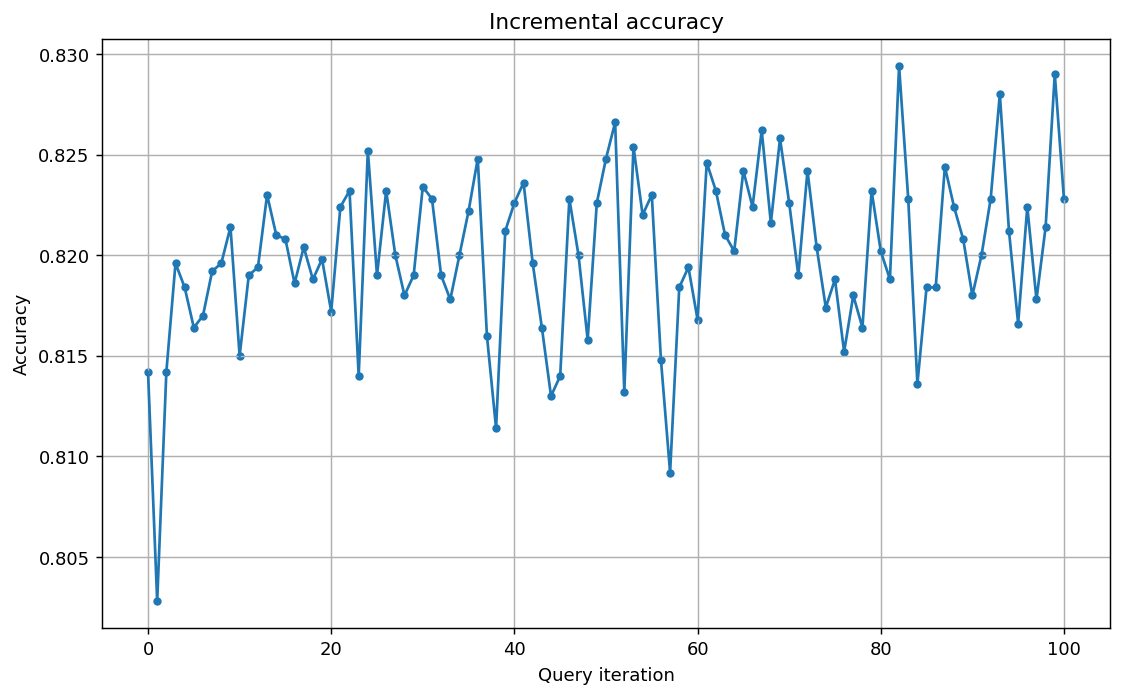

In [ ]:
# learning curve
plot_performance_model(history_uncert_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_uncert = accuracy_score(y_train_new,y_pred_train)
f1_nn_uncert = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_uncert = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_uncert = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_uncert)
print("f1 score : ",f1_nn_uncert)
print("precision score : ",prec_nn_uncert)
print("recall score : ",rec_nn_uncert)

accuracy score :  0.8228
f1 score :  0.7860607830774176
precision score :  0.796987658065816
recall score :  0.7778649520357498


In [ ]:
# AUC on train
auc_nn_uncert = roc_auc_score(y_train_new,y_pred_train)
auc_nn_uncert

0.7778649520357498

Accuracy of nn classifier on test set: 0.82


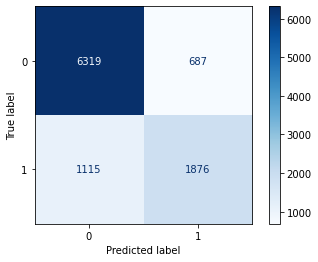

In [ ]:
# Check the performance on test set

print('Accuracy of nn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)
cm_nn_uncert = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(nn, X_test, y_test, values_format=".4g", cmap="Blues");
plt.grid(False)

In [ ]:
# confusion matrix
TP_nn_uncert = cm_nn_uncert[0,0]
FP_nn_uncert = cm_nn_uncert[0,1]
FN_nn_uncert = cm_nn_uncert[1,0]
TN_nn_uncert = cm_nn_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_uncert_test = accuracy_score(y_test,y_pred_test)
f1_nn_uncert_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_uncert_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_uncert_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_uncert_test)
print("f1 score : ",f1_nn_uncert_test)
print("precision score : ",prec_nn_uncert_test)
print("recall score : ",rec_nn_uncert_test)

accuracy score :  0.8247474242272682
f1 score :  0.7847585121111145
precision score :  0.7947813399972572
recall score :  0.7769601267404841


In [ ]:
# AUC on test set
auc_nn_uncert_test = roc_auc_score(y_test,y_pred_test)
auc_nn_uncert_test

0.7769601267404841

###### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_uncert, auc_lr_uncert],
            'K Nearest Neighbour (KNN)': [acc_knn_uncert, auc_knn_uncert],
            'Support Vector Machine (SVC)': [acc_svc_uncert, auc_svc_uncert],
            'Decision Trees (DT)': [acc_dt_uncert, auc_dt_uncert],
            'Naive Bayes (NB)': [acc_gm_uncert, auc_gm_uncert],
            'Neural Networks (NN)': [acc_nn_uncert, auc_nn_uncert]
             }
dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7886     0.773620
K Nearest Neighbour (KNN)          0.8224     0.774721
Support Vector Machine (SVC)       0.7914     0.773864
Decision Trees (DT)                0.8626     0.825591
Naive Bayes (NB)                   0.7972     0.766823
Neural Networks (NN)               0.8228     0.777865

In [ ]:
# Creating performance table of test
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_uncert_test, auc_lr_uncert_test],
            'K Nearest Neighbour (KNN)': [acc_knn_uncert_test, auc_knn_uncert_test],
            'Support Vector Machine (SVC)': [acc_svc_uncert_test, auc_svc_uncert_test],
            'Decision Trees (DT)': [acc_dt_uncert_test, auc_dt_uncert_test],
            'Naive Bayes (NB)': [acc_gm_uncert_test, auc_gm_uncert_test],
            'Neural Networks (NN)': [acc_nn_uncert_test, auc_nn_uncert_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.790537    0.773437
K Nearest Neighbour (KNN)       0.812644    0.758745
Support Vector Machine (SVC)    0.794338    0.774808
Decision Trees (DT)             0.801040    0.756406
Naive Bayes (NB)                0.801741    0.773096
Neural Networks (NN)            0.824747    0.776960

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_uncert, FP_lr_uncert, TN_lr_uncert, FN_lr_uncert],
            'K Nearest Neighbour (KNN)': [TP_knn_uncert, FP_knn_uncert, TN_knn_uncert, FN_knn_uncert],
            'Support Vector Machine (SVC)': [TP_svc_uncert, FP_svc_uncert, TN_svc_uncert, FN_svc_uncert],
            'Decision Trees (DT)': [TP_dt_uncert, FP_dt_uncert, TN_dt_uncert, FN_dt_uncert],
            'Naive Bayes (NB)': [TP_gm_uncert, FP_gm_uncert, TN_gm_uncert, FN_gm_uncert],
            'Neural Networks (NN)': [TP_nn_uncert, FP_nn_uncert, TN_nn_uncert,FN_nn_uncert]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5717  1289  2186   805
K Nearest Neighbour (KNN)     6256   750  1868  1123
Support Vector Machine (SVC)  5769  1237  2172   819
Decision Trees (DT)           6125   881  1853  1138
Naive Bayes (NB)              5916  1090  2099   892
Neural Networks (NN)          6319   687  1876  1115

##### **classification Margin**

###### **SVC**

In [ ]:
svc = SVC(C=svc_train.best_estimator_.C, kernel='linear', probability=True, class_weight= 'balanced')
learner = ActiveLearner(estimator=svc, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# query rejected applications
classifier_margin(learner, X_pool)[:1000]

array([0.66333705, 0.71820338, 0.67052602, 0.79614545, 0.76132662,
       0.7213762 , 0.71093403, 0.78231654, 0.88293573, 0.75499029,
       0.8316283 , 0.826582  , 0.58636299, 0.86453607, 0.80137463,
       0.83396693, 0.2139998 , 0.64541485, 0.775756  , 0.84138947,
       0.58729387, 0.58703608, 0.73260823, 0.95137927, 0.69352616,
       0.39290225, 0.54083582, 0.65529824, 0.90377163, 0.89284815,
       0.85619256, 0.24096436, 0.76768551, 0.97998371, 0.8649565 ,
       0.88371461, 0.68753799, 0.75670608, 0.65071524, 0.90248164,
       0.83529093, 0.7806476 , 0.87627789, 0.77448162, 0.69158095,
       0.12817303, 0.67095362, 0.90927558, 0.67056854, 0.8767312 ,
       0.57353477, 0.85249812, 0.68795047, 0.89684601, 0.80707695,
       0.68657167, 0.8208384 , 0.88360926, 0.50074785, 0.6201314 ,
       0.74880133, 0.51644067, 0.6326282 , 0.80788919, 0.84306782,
       0.8581782 , 0.85850628, 0.94367802, 0.73360119, 0.77497221,
       0.76094958, 0.41806113, 0.81203175, 0.78044657, 0.65559

In [ ]:
# active learning process
history_marg_svc = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_margin(learner, X_pool[stream_idx].reshape(1, -1))>=0.7:
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_marg_svc.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 16239 queried, new accuracy: 0.788600
Example no. 4684 queried, new accuracy: 0.788600
Example no. 4065 queried, new accuracy: 0.788600
Example no. 5050 queried, new accuracy: 0.788600
Example no. 16022 queried, new accuracy: 0.788600
Example no. 101 queried, new accuracy: 0.788600
Example no. 10710 queried, new accuracy: 0.788600
Example no. 11582 queried, new accuracy: 0.788600
Example no. 17626 queried, new accuracy: 0.788600
Example no. 15919 queried, new accuracy: 0.788400
Example no. 9412 queried, new accuracy: 0.788000
Example no. 9448 queried, new accuracy: 0.787800
Example no. 21499 queried, new accuracy: 0.787800
Example no. 12838 queried, new accuracy: 0.787800
Example no. 7272 queried, new accuracy: 0.787800
Example no. 4105 queried, new accuracy: 0.787800
Example no. 1812 queried, new accuracy: 0.788000
Example no. 1511 queried, new accuracy: 0.788200
Example no. 3560 queried, new accuracy: 0.788200
Example no. 11156 queried, new accuracy: 0.787800
Example no. 

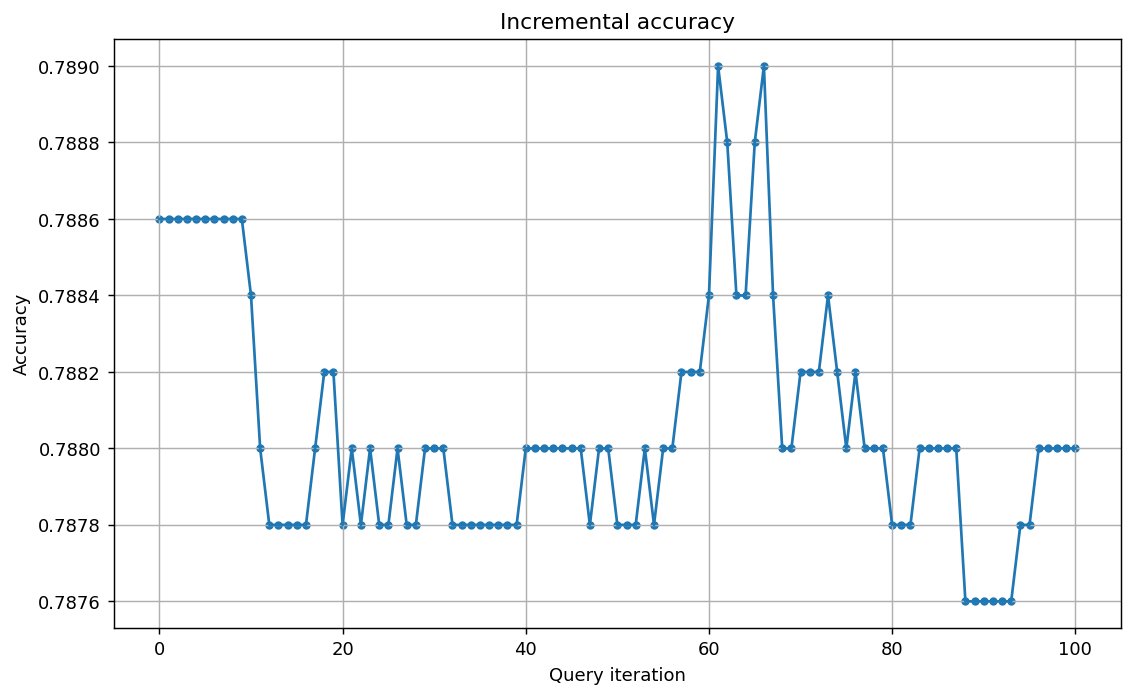

In [ ]:
# learning curve
plot_performance_model(history_marg_svc)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_svc_marg = accuracy_score(y_train_new,y_pred_train)
f1_svc_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_marg)
print("f1 score : ",f1_svc_marg)
print("precision score : ",prec_svc_marg)
print("recall score : ",rec_svc_marg)


accuracy score :  0.788
f1 score :  0.7612367826539334
precision score :  0.7541715683631118
recall score :  0.7726507832298193


In [ ]:
# AUC on train
auc_svc_marg = roc_auc_score(y_train_new,y_pred_train)
auc_svc_marg

0.7726507832298193

Accuracy of SVC classifier on test set: 0.79


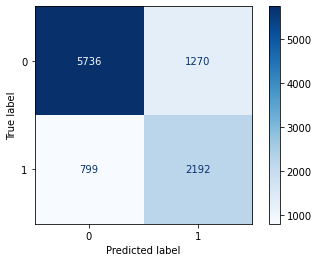

In [ ]:
# Check the performance on test set

print('Accuracy of SVC classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_svc_marg = cm_svc_uncert[0,0]
FP_svc_marg = cm_svc_uncert[0,1]
FN_svc_marg = cm_svc_uncert[1,0]
TN_svc_marg = cm_svc_uncert[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_marg_test = accuracy_score(y_test,y_pred_test)
f1_svc_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_marg_test)
print("f1 score : ",f1_svc_marg_test)
print("precision score : ",prec_svc_marg_test)
print("recall score : ",rec_svc_marg_test)

accuracy score :  0.7930379113734121
f1 score :  0.7632893600352108
precision score :  0.7554476473612071
recall score :  0.7757960340246164


In [ ]:
# AUC on test set
auc_svc_marg_test = roc_auc_score(y_test,y_pred_test)
auc_svc_marg_test

0.7757960340246164

###### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# query the rejected applications
classifier_margin(learner, X_pool)[:1000]

array([0.75927833, 0.49128809, 0.40002178, 0.3006305 , 0.5242904 ,
       0.38637653, 0.76324902, 0.38513074, 0.49945546, 0.63151762,
       0.42981733, 0.58277957, 0.55350551, 0.23710516, 0.62119894,
       0.85672756, 0.55648069, 0.69134891, 0.40110159, 0.2386585 ,
       0.80675365, 0.60508075, 0.22842233, 0.21681491, 0.42284789,
       0.79570059, 0.338027  , 0.25062381, 0.11567134, 0.75120781,
       0.7034016 , 0.70171187, 0.60793114, 0.08169937, 0.45590762,
       0.46331785, 0.90712187, 0.65354257, 0.65807953, 0.32215005,
       0.04289921, 0.03582787, 0.37152949, 0.45021439, 0.26294118,
       0.68463055, 0.6013023 , 0.47393386, 0.61130443, 0.80720566,
       0.36543775, 0.1947573 , 0.31413869, 0.75214436, 0.20547118,
       0.27463147, 0.71097158, 0.17294451, 0.57229291, 0.41373176,
       0.70368744, 0.47062793, 0.30875596, 0.48990292, 0.66259333,
       0.17542324, 0.73189114, 0.41778604, 0.55660526, 0.17842422,
       0.28996423, 0.5308441 , 0.87317239, 0.62794286, 0.63427

In [ ]:
# learning process
history_marg_lr = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_margin(learner, X_pool[stream_idx].reshape(1, -1))>=0.8 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_marg_lr.append(new_score)
      # Remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 6913 queried, new accuracy: 0.787000
Example no. 5520 queried, new accuracy: 0.787000
Example no. 23419 queried, new accuracy: 0.787000
Example no. 21236 queried, new accuracy: 0.787000
Example no. 4548 queried, new accuracy: 0.787000
Example no. 11062 queried, new accuracy: 0.787000
Example no. 18199 queried, new accuracy: 0.787000
Example no. 3402 queried, new accuracy: 0.787000
Example no. 3649 queried, new accuracy: 0.787200
Example no. 3886 queried, new accuracy: 0.787200
Example no. 4744 queried, new accuracy: 0.787600
Example no. 7372 queried, new accuracy: 0.788200
Example no. 23511 queried, new accuracy: 0.788000
Example no. 13955 queried, new accuracy: 0.787800
Example no. 8663 queried, new accuracy: 0.787800
Example no. 7928 queried, new accuracy: 0.787800
Example no. 18358 queried, new accuracy: 0.787800
Example no. 6930 queried, new accuracy: 0.787800
Example no. 22251 queried, new accuracy: 0.788200
Example no. 24008 queried, new accuracy: 0.788000
Example no.

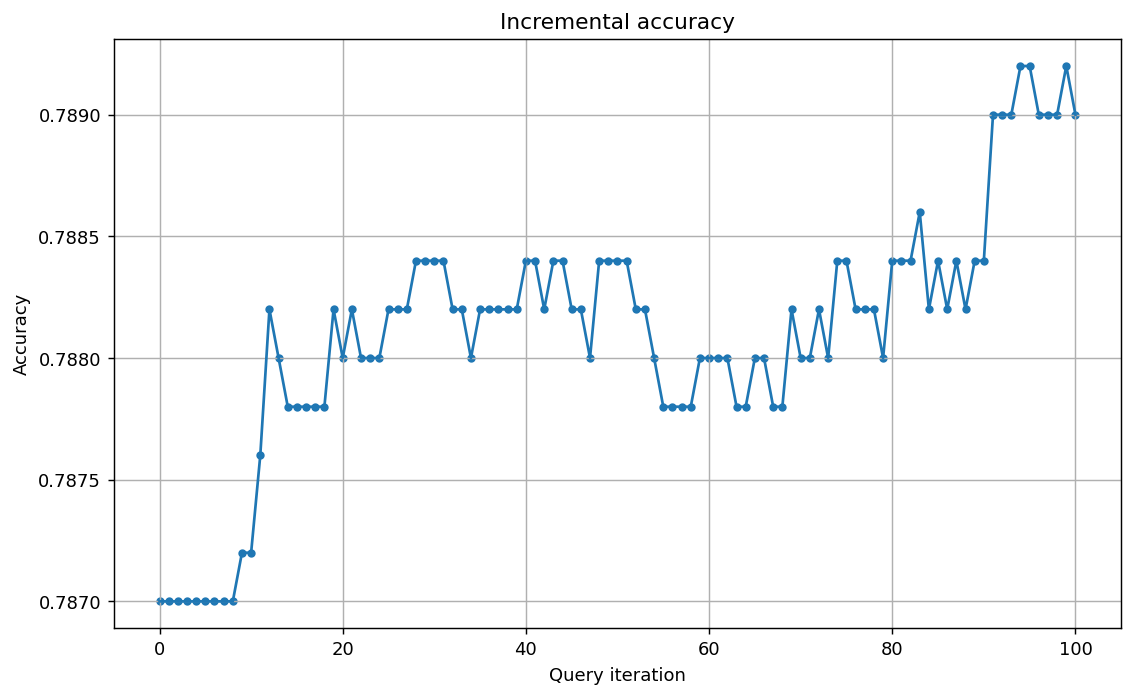

In [ ]:
# learning curve
plot_performance_model(history_marg_lr)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_lr_marg = accuracy_score(y_train_new,y_pred_train)
f1_lr_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_marg)
print("f1 score : ",f1_lr_marg)
print("precision score : ",prec_lr_marg)
print("recall score : ",rec_lr_marg)


accuracy score :  0.789
f1 score :  0.7628262549672165
precision score :  0.7555149514606341
recall score :  0.774980432592739


In [ ]:
# AUC on train
auc_lr_marg = roc_auc_score(y_train_new,y_pred_train)
auc_lr_marg

0.774980432592739

Accuracy of lr classifier on test set: 0.79


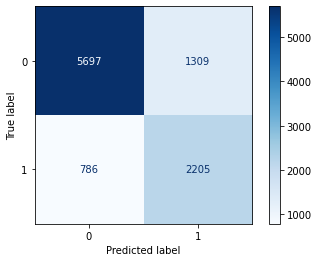

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_lr_marg = cm_lr_marg[0,0]
FP_lr_marg = cm_lr_marg[0,1]
FN_lr_marg = cm_lr_marg[1,0]
TN_lr_marg = cm_lr_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_marg_test = accuracy_score(y_test,y_pred_test)
f1_lr_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_marg_test)
print("f1 score : ",f1_lr_marg_test)
print("precision score : ",prec_lr_marg_test)
print("recall score : ",rec_lr_marg_test)

accuracy score :  0.7904371311393418
f1 score :  0.7613141553150975
precision score :  0.7531249366255478
recall score :  0.7751858916744525


In [ ]:
# AUC on test set
auc_lr_marg_test = roc_auc_score(y_test,y_pred_test)
auc_lr_marg_test

0.7751858916744525

###### **NB**

In [ ]:
# Training the Gaussian Model
from sklearn.naive_bayes import GaussianNB
gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# query rejected applications
classifier_margin(learner, X_pool)[:1000]

array([0.99978234, 0.9979545 , 0.98853206, 0.92492221, 0.87627089,
       0.98377291, 0.99994879, 0.73945324, 0.93060501, 0.9993321 ,
       0.88011442, 0.9379883 , 0.99193155, 0.98205989, 0.99991989,
       0.99999186, 0.96606374, 0.99552156, 0.82589038, 0.89549423,
       0.99997577, 0.97221239, 0.99913873, 0.73522851, 0.99706402,
       0.99999999, 0.97441273, 1.        , 0.84438407, 0.99779389,
       0.99475906, 0.98920806, 0.98021728, 0.91151979, 0.99222998,
       0.9999677 , 0.99999998, 0.99967129, 0.98894011, 0.76800537,
       0.60314392, 0.60302843, 0.9964195 , 0.9479056 , 0.78079181,
       0.9979023 , 0.97112904, 0.99847798, 0.99249234, 0.99996619,
       0.98430455, 0.99675727, 0.89922534, 0.78526846, 0.99996775,
       0.59640619, 0.99227786, 0.99999981, 0.71491038, 0.98851997,
       0.78500744, 0.99481469, 0.97558574, 0.97742794, 0.99771631,
       0.98457206, 0.68792728, 0.99978261, 0.92465849, 0.99227842,
       0.99882527, 0.71582931, 0.90343303, 0.99999845, 0.99260

In [ ]:
# Active learning process
history_marg_gm = [initial_score]

num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_margin(learner, X_pool[stream_idx].reshape(1, -1))>=0.8:
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_marg_gm.append(new_score)
      # Revome queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 15171 queried, new accuracy: 0.796600
Example no. 20913 queried, new accuracy: 0.796600
Example no. 1311 queried, new accuracy: 0.796600
Example no. 11676 queried, new accuracy: 0.796600
Example no. 1747 queried, new accuracy: 0.796800
Example no. 5315 queried, new accuracy: 0.796800
Example no. 8558 queried, new accuracy: 0.796800
Example no. 16216 queried, new accuracy: 0.796800
Example no. 7008 queried, new accuracy: 0.796200
Example no. 13439 queried, new accuracy: 0.796400
Example no. 15546 queried, new accuracy: 0.796400
Example no. 117 queried, new accuracy: 0.796400
Example no. 15213 queried, new accuracy: 0.796400
Example no. 14375 queried, new accuracy: 0.796400
Example no. 6141 queried, new accuracy: 0.796400
Example no. 5001 queried, new accuracy: 0.796200
Example no. 14626 queried, new accuracy: 0.796200
Example no. 16508 queried, new accuracy: 0.796200
Example no. 17684 queried, new accuracy: 0.796400
Example no. 20952 queried, new accuracy: 0.796400
Example n

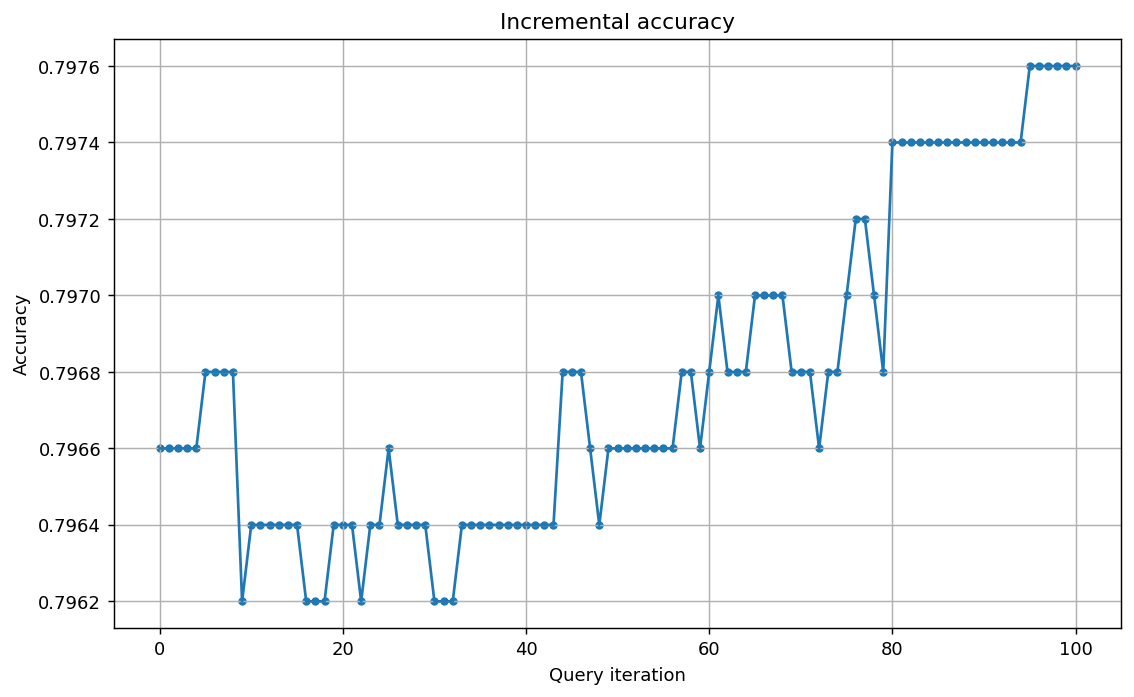

In [ ]:
# learning curve
plot_performance_model(history_marg_gm)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_marg = accuracy_score(y_train_new,y_pred_train)
f1_gm_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_marg)
print("f1 score : ",f1_gm_marg)
print("precision score : ",prec_gm_marg)
print("recall score : ",rec_gm_marg)

accuracy score :  0.7976
f1 score :  0.7666085678824976
precision score :  0.7631417408226155
recall score :  0.7706810318861221


In [ ]:
# AUC on train
auc_gm_marg = roc_auc_score(y_train_new,y_pred_train)
auc_gm_marg

0.7706810318861221

Accuracy of gm classifier on test set: 0.80


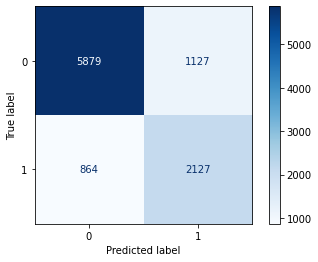

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False);

In [ ]:
# confusion matrix
TP_gm_marg = cm_gm_marg[0,0]
FP_gm_marg = cm_gm_marg[0,1]
FN_gm_marg = cm_gm_marg[1,0]
TN_gm_marg = cm_gm_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_marg_test = accuracy_score(y_test,y_pred_test)
f1_gm_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_marg_test)
print("f1 score : ",f1_gm_marg_test)
print("precision score : ",prec_gm_marg_test)
print("recall score : ",rec_gm_marg_test)

accuracy score :  0.8008402520756227
f1 score :  0.7681872081416679
precision score :  0.7627620794758041
recall score :  0.7751356410080943


In [ ]:
# AUC on test set
auc_gm_marg_test = roc_auc_score(y_test,y_pred_test)
auc_gm_marg_test

0.7751356410080943

###### **KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - KNN: {initial_score}")

Prediction Accuracy - KNN: 0.8218


In [ ]:
# query the rejected applications
classifier_margin(learner, X_pool)[:1000]

array([0.45454545, 0.45454545, 0.90909091, 0.36363636, 0.63636364,
       0.81818182, 0.63636364, 0.63636364, 0.90909091, 0.90909091,
       0.81818182, 1.        , 0.90909091, 0.90909091, 0.90909091,
       0.72727273, 0.63636364, 1.        , 0.63636364, 0.54545455,
       0.63636364, 0.90909091, 0.81818182, 0.45454545, 0.81818182,
       0.63636364, 0.81818182, 0.36363636, 0.09090909, 0.54545455,
       0.90909091, 1.        , 1.        , 0.81818182, 0.90909091,
       0.90909091, 0.45454545, 1.        , 1.        , 1.        ,
       0.45454545, 1.        , 0.09090909, 0.81818182, 0.90909091,
       0.45454545, 0.81818182, 0.81818182, 0.90909091, 0.63636364,
       0.81818182, 0.90909091, 0.72727273, 0.27272727, 0.45454545,
       1.        , 0.54545455, 0.63636364, 0.81818182, 0.54545455,
       0.90909091, 1.        , 1.        , 0.81818182, 0.81818182,
       0.81818182, 0.90909091, 0.54545455, 0.45454545, 0.63636364,
       0.63636364, 0.81818182, 0.45454545, 0.81818182, 0.54545

In [ ]:
# learning process
history_marg_knn = [initial_score]
num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_margin(learner, X_pool[stream_idx].reshape(1, -1))>=0.7 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_marg_knn.append(new_score)
      # remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 5625 queried, new accuracy: 0.821800
Example no. 17624 queried, new accuracy: 0.821800
Example no. 10643 queried, new accuracy: 0.821800
Example no. 4014 queried, new accuracy: 0.821800
Example no. 21408 queried, new accuracy: 0.821800
Example no. 3398 queried, new accuracy: 0.821800
Example no. 3894 queried, new accuracy: 0.821800
Example no. 12674 queried, new accuracy: 0.821800
Example no. 1572 queried, new accuracy: 0.821800
Example no. 13756 queried, new accuracy: 0.821800
Example no. 12379 queried, new accuracy: 0.821800
Example no. 4411 queried, new accuracy: 0.821800
Example no. 10703 queried, new accuracy: 0.821800
Example no. 16496 queried, new accuracy: 0.821800
Example no. 6378 queried, new accuracy: 0.821800
Example no. 16989 queried, new accuracy: 0.821800
Example no. 17519 queried, new accuracy: 0.821800
Example no. 22449 queried, new accuracy: 0.821800
Example no. 12262 queried, new accuracy: 0.821800
Example no. 14443 queried, new accuracy: 0.821800
Example

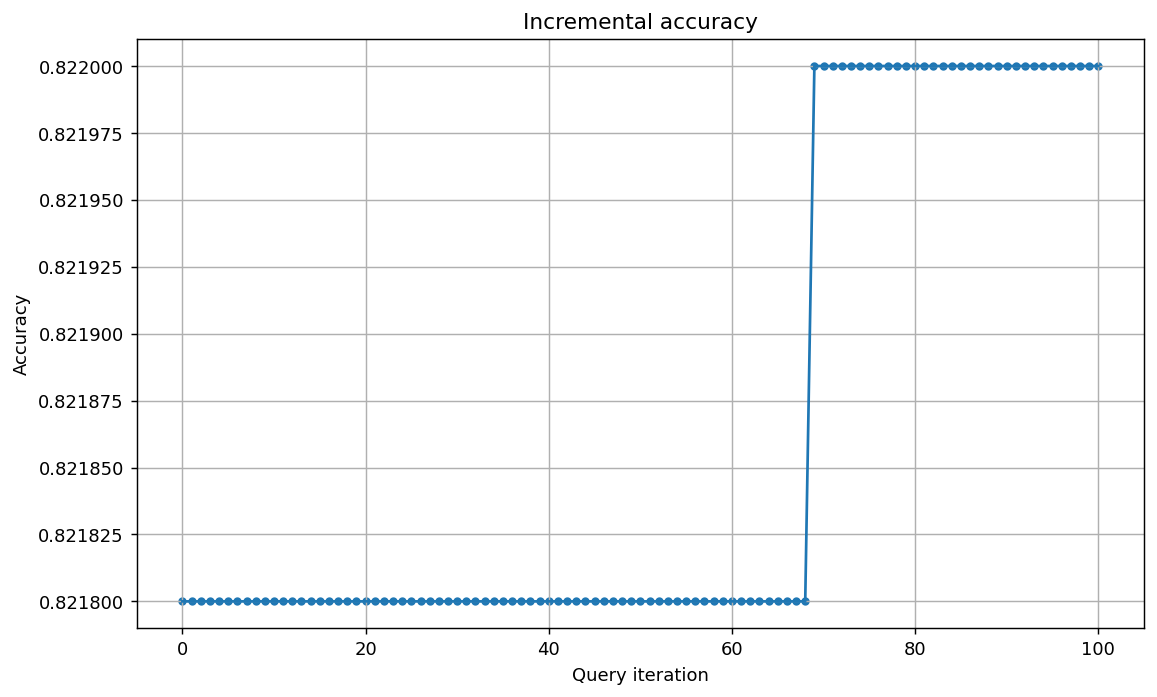

In [ ]:
# learning curve
plot_performance_model(history_marg_knn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_knn_marg = accuracy_score(y_train_new,y_pred_train)
f1_knn_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_marg)
print("f1 score : ",f1_knn_marg)
print("precision score : ",prec_knn_marg)
print("recall score : ",rec_knn_marg)


accuracy score :  0.822
f1 score :  0.7868682079208396
precision score :  0.7945557144487768
recall score :  0.7806754326404759


In [ ]:
# Compute AUC on train set
auc_knn_marg = roc_auc_score(y_train_new,y_pred_train)
auc_knn_marg

0.7806754326404759

Accuracy of knn classifier on test set: 0.82


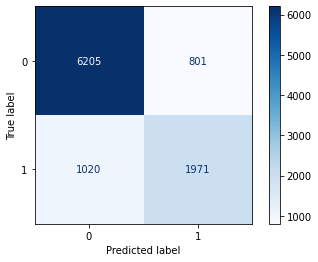

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_knn_marg = cm_knn_marg[0,0]
FP_knn_marg = cm_knn_marg[0,1]
FN_knn_marg = cm_knn_marg[1,0]
TN_knn_marg = cm_knn_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_marg_test = accuracy_score(y_test,y_pred_test)
f1_knn_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_marg_test)
print("f1 score : ",f1_knn_marg_test)
print("precision score : ",prec_knn_marg_test)
print("recall score : ",rec_knn_marg_test)

accuracy score :  0.8178453536060818
f1 score :  0.7780293265528682
precision score :  0.7849312452253628
recall score :  0.772323178499243


In [ ]:
# AUC on test set
auc_knn_marg_test = roc_auc_score(y_test,y_pred_test)
auc_knn_marg_test

0.772323178499243

###### **DT**

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - dt: {initial_score}")

Prediction Accuracy - dt: 0.8594


In [ ]:
# query unlabeled instances
classifier_margin(learner, X_pool)[:1000]

array([0.62666667, 1.        , 0.98713826, 0.71875   , 0.89705882,
       0.79591837, 0.76439791, 0.89705882, 1.        , 0.79591837,
       0.85022026, 1.        , 0.98713826, 0.78443114, 1.        ,
       0.76439791, 0.95862069, 1.        , 0.77777778, 0.84761905,
       0.76439791, 0.85022026, 1.        , 0.27659574, 0.98713826,
       0.52941176, 0.78443114, 0.78443114, 1.        , 0.76439791,
       0.95862069, 1.        , 1.        , 0.78443114, 0.95      ,
       0.95862069, 1.        , 1.        , 0.95862069, 0.3877551 ,
       1.        , 0.83333333, 0.95      , 1.        , 0.52941176,
       0.95862069, 1.        , 0.95862069, 0.98713826, 0.76439791,
       1.        , 0.78443114, 0.95862069, 0.85022026, 0.98713826,
       0.45454545, 0.84761905, 1.        , 0.85022026, 0.98713826,
       1.        , 1.        , 0.609375  , 0.78443114, 0.84761905,
       0.95862069, 0.58064516, 0.69142857, 0.85022026, 0.76439791,
       1.        , 1.        , 0.89705882, 0.76439791, 0.95   

In [ ]:
# learner process
history_marg_dt = [initial_score]

num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_margin(learner, X_pool[stream_idx].reshape(1, -1))>=0.8 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_marg_dt.append(new_score)
      # remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 12433 queried, new accuracy: 0.859400
Example no. 11015 queried, new accuracy: 0.859400
Example no. 1103 queried, new accuracy: 0.859400
Example no. 7199 queried, new accuracy: 0.859400
Example no. 17262 queried, new accuracy: 0.859400
Example no. 8466 queried, new accuracy: 0.859400
Example no. 24915 queried, new accuracy: 0.859400
Example no. 21995 queried, new accuracy: 0.859000
Example no. 17972 queried, new accuracy: 0.859000
Example no. 22727 queried, new accuracy: 0.859000
Example no. 16212 queried, new accuracy: 0.859000
Example no. 3411 queried, new accuracy: 0.859000
Example no. 17720 queried, new accuracy: 0.859000
Example no. 4537 queried, new accuracy: 0.859000
Example no. 17720 queried, new accuracy: 0.859000
Example no. 21535 queried, new accuracy: 0.859000
Example no. 5045 queried, new accuracy: 0.859000
Example no. 2818 queried, new accuracy: 0.859000
Example no. 24173 queried, new accuracy: 0.859000
Example no. 17726 queried, new accuracy: 0.859600
Example

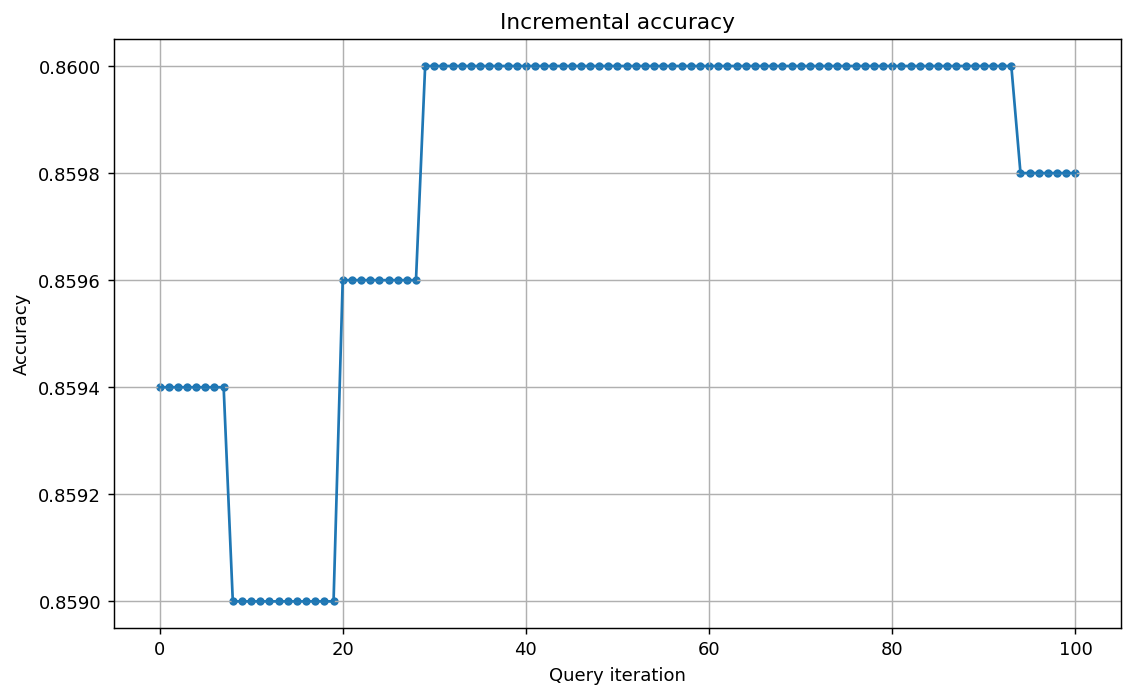

In [ ]:
# learner curve
plot_performance_model(history_marg_dt)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_marg = accuracy_score(y_train_new,y_pred_train)
f1_dt_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_marg)
print("f1 score : ",f1_dt_marg)
print("precision score : ",prec_dt_marg)
print("recall score : ",rec_dt_marg)

accuracy score :  0.8598
f1 score :  0.8349833352000696
precision score :  0.8370570411481745
recall score :  0.8330195808858865


In [ ]:
# AUC on train set
auc_dt_marg = roc_auc_score(y_train_new,y_pred_train)
auc_dt_marg

0.8330195808858865

Accuracy of dt classifier on test set: 0.80


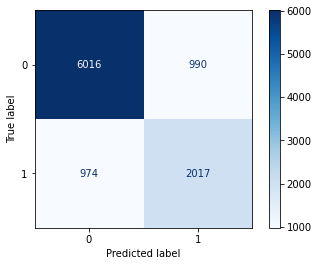

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

In [ ]:
# confusion matrix
TP_dt_marg = cm_dt_marg[0,0]
FP_dt_marg = cm_dt_marg[0,1]
FN_dt_marg = cm_dt_marg[1,0]
TN_dt_marg = cm_dt_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_marg_test = accuracy_score(y_test,y_pred_test)
f1_dt_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_marg_test)
print("f1 score : ",f1_dt_marg_test)
print("precision score : ",prec_dt_marg_test)
print("recall score : ",rec_dt_marg_test)

accuracy score :  0.8035410623186956
f1 score :  0.7661158558997612
precision score :  0.765713145245738
recall score :  0.7665244758922309


In [ ]:
# AUC on test set 
auc_dt_marg_test = roc_auc_score(y_test,y_pred_test)
auc_dt_marg_test

0.7665244758922309

###### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                       learning_rate_init= nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 )
learner = ActiveLearner(estimator=mlp_nn, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - NN: {initial_score}")

Prediction Accuracy - NN: 0.8142


In [ ]:
# query unlabeled instances
classifier_margin(learner, X_pool)[:1000]

array([0.83711467, 0.15228931, 0.79213946, 0.57436138, 0.91362284,
       0.76498261, 0.64316039, 0.42802176, 0.90945581, 0.91340331,
       0.77626545, 0.93525857, 0.95381572, 0.56448418, 0.9630877 ,
       0.70353154, 0.70710784, 0.92005444, 0.44383733, 0.41043192,
       0.69432891, 0.94261699, 0.88798153, 0.40000117, 0.84119695,
       0.46533966, 0.6583647 , 0.71433769, 0.08254699, 0.669476  ,
       0.95240676, 0.97441367, 0.98138188, 0.09931196, 0.81293769,
       0.97221163, 0.95089002, 0.99993675, 0.98141463, 0.94639114,
       0.49665121, 0.92590388, 0.03373099, 0.76850725, 0.89195593,
       0.01702877, 0.8848281 , 0.9738207 , 0.9693083 , 0.85678146,
       0.69637575, 0.97252676, 0.50341309, 0.64484179, 0.506356  ,
       0.99272479, 0.20548955, 0.81878628, 0.96199818, 0.26563109,
       0.88013256, 0.83361423, 0.99303622, 0.64331564, 0.68145271,
       0.67941924, 0.90034416, 0.07666625, 0.65305373, 0.77190793,
       0.67682948, 0.79123098, 0.89997058, 0.87139936, 0.71630

In [ ]:
# learning process
history_marg_nn = [initial_score]

num_q=100
i=0
while (num_q):
    stream_idx = np.random.choice(range(len(X_pool)))
    if classifier_margin(learner, X_pool[stream_idx].reshape(1, -1))>=0.8 :
      num_q=num_q-1;
      learner.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
      # Calculate and report the model's accuracy
      new_score = learner.score(X_train_new, y_train_new)
      history_marg_nn.append(new_score)
      # remove queried instance from pool
      X_pool = np.delete(X_pool, stream_idx, axis=0)
      y_pool = np.delete(y_pool, stream_idx)
      print('Example no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Example no. 19758 queried, new accuracy: 0.826000
Example no. 11209 queried, new accuracy: 0.827800
Example no. 15714 queried, new accuracy: 0.822400
Example no. 297 queried, new accuracy: 0.826600
Example no. 7895 queried, new accuracy: 0.821200
Example no. 18972 queried, new accuracy: 0.824200
Example no. 16621 queried, new accuracy: 0.820400
Example no. 19884 queried, new accuracy: 0.827600
Example no. 3307 queried, new accuracy: 0.825600
Example no. 5644 queried, new accuracy: 0.819400
Example no. 4392 queried, new accuracy: 0.822800
Example no. 19071 queried, new accuracy: 0.823600
Example no. 16682 queried, new accuracy: 0.829400
Example no. 16597 queried, new accuracy: 0.825600
Example no. 3525 queried, new accuracy: 0.819200
Example no. 17293 queried, new accuracy: 0.825400
Example no. 2975 queried, new accuracy: 0.818200
Example no. 7229 queried, new accuracy: 0.826200
Example no. 1241 queried, new accuracy: 0.824200
Example no. 19400 queried, new accuracy: 0.821600
Example no

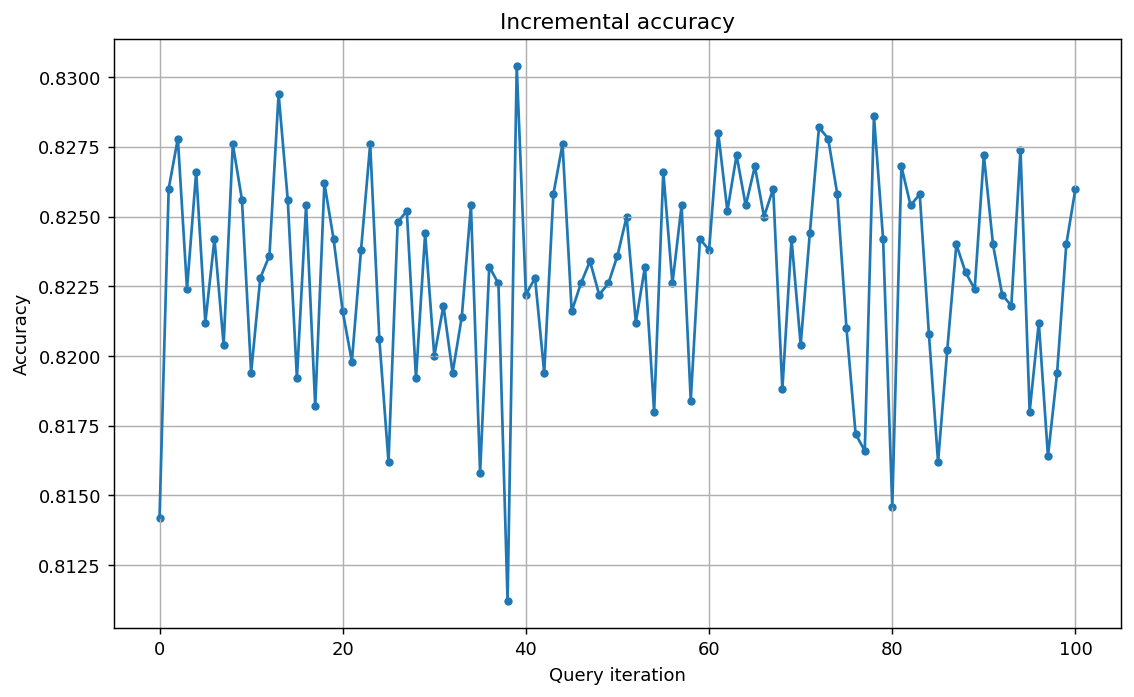

In [ ]:
# learning process
plot_performance_model(history_marg_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_marg = accuracy_score(y_train_new,y_pred_train)
f1_nn_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_marg)
print("f1 score : ",f1_nn_marg)
print("precision score : ",prec_nn_marg)
print("recall score : ",rec_nn_marg)

accuracy score :  0.826
f1 score :  0.7955356261545186
precision score :  0.7968497986298102
recall score :  0.7942757401028981


In [ ]:
# AUC on train set
auc_nn_marg = roc_auc_score(y_train_new,y_pred_train)
auc_nn_marg

0.7942757401028981

Accuracy of nn classifier on test set: 0.82


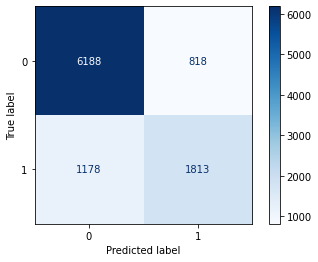

In [ ]:
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_nn_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)
# Check the performance on test set

print('Accuracy of nn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

In [ ]:
# confusion matrix
TP_nn_marg = cm_nn_marg[0,0]
FP_nn_marg = cm_nn_marg[0,1]
FN_nn_marg = cm_nn_marg[1,0]
TN_nn_marg = cm_nn_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_marg_test = accuracy_score(y_test,y_pred_test)
f1_nn_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_marg_test)
print("f1 score : ",f1_nn_marg_test)
print("precision score : ",prec_nn_marg_test)
print("recall score : ",rec_nn_marg_test)

accuracy score :  0.8234470341102331
f1 score :  0.7889854015280295
precision score :  0.7896911212870696
recall score :  0.7882948493401033


In [ ]:
# AUC on test set
auc_nn_marg_test = roc_auc_score(y_test,y_pred_test)
auc_nn_marg_test

0.7882948493401033

###### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_marg, auc_lr_marg],
            'K Nearest Neighbour (KNN)': [acc_knn_marg, auc_knn_marg],
            'Support Vector Machine (SVC)': [acc_svc_marg, auc_svc_marg],
            'Decision Trees (DT)': [acc_dt_marg, auc_dt_marg],
            'Naive Bayes (NB)': [acc_gm_marg, auc_gm_marg],
            'Neural Networks (NN)': [acc_nn_marg, auc_nn_marg]
             }
dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7890     0.774980
K Nearest Neighbour (KNN)          0.8220     0.780675
Support Vector Machine (SVC)       0.7880     0.772651
Decision Trees (DT)                0.8598     0.833020
Naive Bayes (NB)                   0.7976     0.770681
Neural Networks (NN)               0.8260     0.794276

In [ ]:
# Creating performance table of test
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_marg_test, auc_lr_marg_test],
            'K Nearest Neighbour (KNN)': [acc_knn_marg_test, auc_knn_marg_test],
            'Support Vector Machine (SVC)': [acc_svc_marg_test, auc_svc_marg_test],
            'Decision Trees (DT)': [acc_dt_marg_test, auc_dt_marg_test],
            'Naive Bayes (NB)': [acc_gm_marg_test, auc_gm_marg_test],
            'Neural Networks (NN)': [acc_nn_marg_test, auc_nn_marg_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.790437    0.775186
K Nearest Neighbour (KNN)       0.817845    0.772323
Support Vector Machine (SVC)    0.793038    0.775796
Decision Trees (DT)             0.803541    0.766524
Naive Bayes (NB)                0.800840    0.775136
Neural Networks (NN)            0.823447    0.788295

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_marg, FP_lr_marg, TN_lr_marg, FN_lr_marg],
            'K Nearest Neighbour (KNN)': [TP_knn_marg, FP_knn_marg, TN_knn_marg, FN_knn_marg],
            'Support Vector Machine (SVC)': [TP_svc_marg, FP_svc_marg, TN_svc_marg, FN_svc_marg],
            'Decision Trees (DT)': [TP_dt_marg, FP_dt_marg, TN_dt_marg, FN_dt_marg],
            'Naive Bayes (NB)': [TP_gm_marg, FP_gm_marg, TN_gm_marg, FN_gm_marg],
            'Neural Networks (NN)': [TP_nn_marg, FP_nn_marg, TN_nn_marg,FN_nn_marg]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5697  1309  2205   786
K Nearest Neighbour (KNN)     6205   801  1971  1020
Support Vector Machine (SVC)  5736  1270  2192   799
Decision Trees (DT)           6016   990  2017   974
Naive Bayes (NB)              5879  1127  2127   864
Neural Networks (NN)          6188   818  1813  1178

##### **Comparison between selection criteria for each credit scoring model** 

###### **SVC**

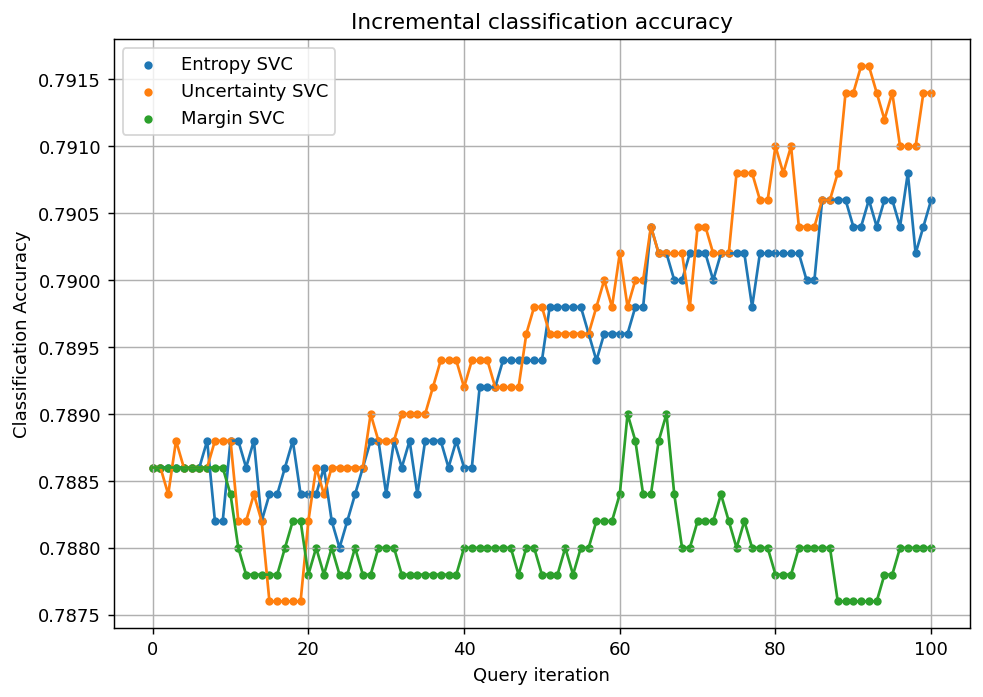

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_entro_svc)
ax.scatter(range(len(history_entro_svc)), history_entro_svc, s=13, label = 'Entropy SVC')

ax.plot(history_uncert_svc)
ax.scatter(range(len(history_uncert_svc)), history_uncert_svc, s=13, label = 'Uncertainty SVC')

ax.plot(history_marg_svc)
ax.scatter(range(len(history_marg_svc)), history_marg_svc, s=13, label = 'Margin SVC')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **NB**

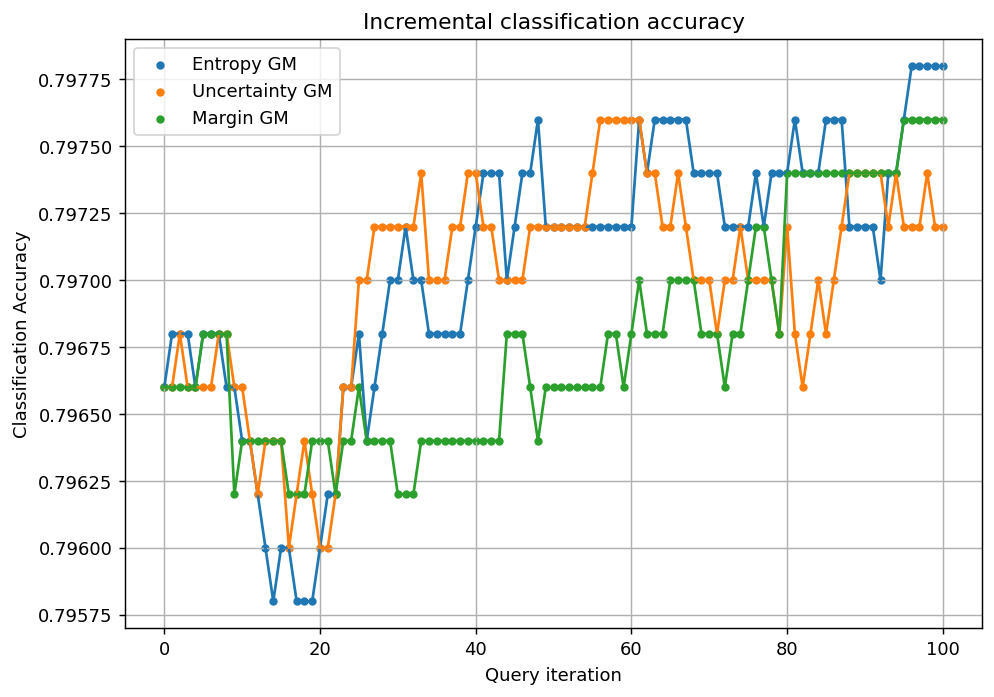

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_entro_gm)
ax.scatter(range(len(history_entro_gm)), history_entro_gm, s=13, label = 'Entropy GM')

ax.plot(history_uncert_gm)
ax.scatter(range(len(history_uncert_gm)), history_uncert_gm, s=13, label = 'Uncertainty GM')

ax.plot(history_marg_gm)
ax.scatter(range(len(history_marg_gm)), history_marg_gm, s=13, label = 'Margin GM')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **LR**

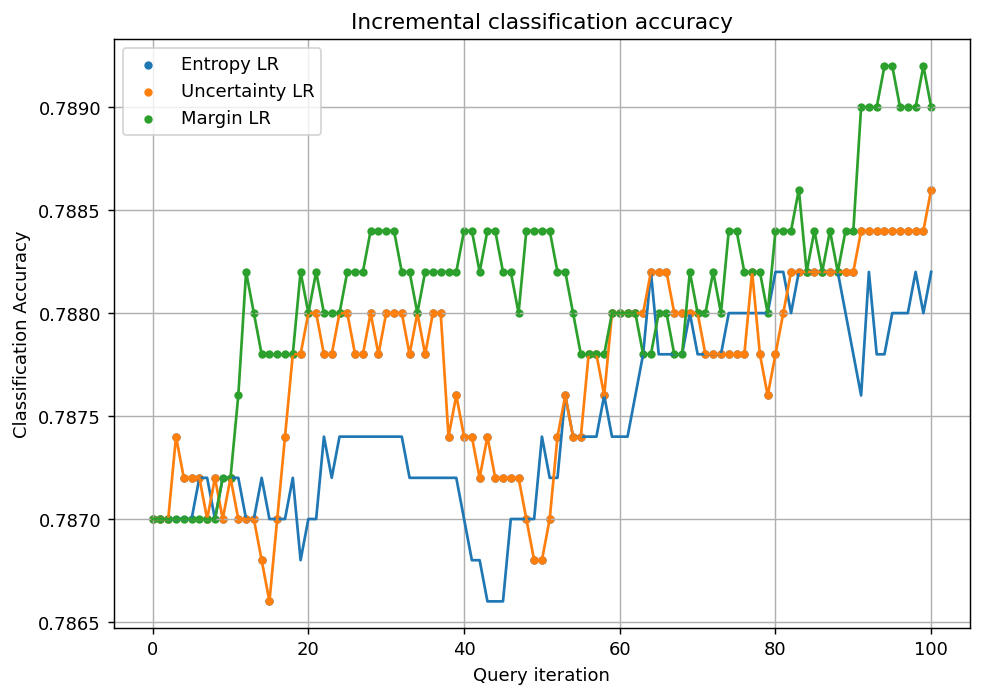

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_entro_lr)
ax.scatter(range(len(history_entro_lr)), history_entro_lr, s=13, label = 'Entropy LR')

ax.plot(history_uncert_lr)
ax.scatter(range(len(history_uncert_lr)), history_uncert_lr, s=13, label = 'Uncertainty LR')

ax.plot(history_marg_lr)
ax.scatter(range(len(history_marg_lr)), history_marg_lr, s=13, label = 'Margin LR')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **DT**

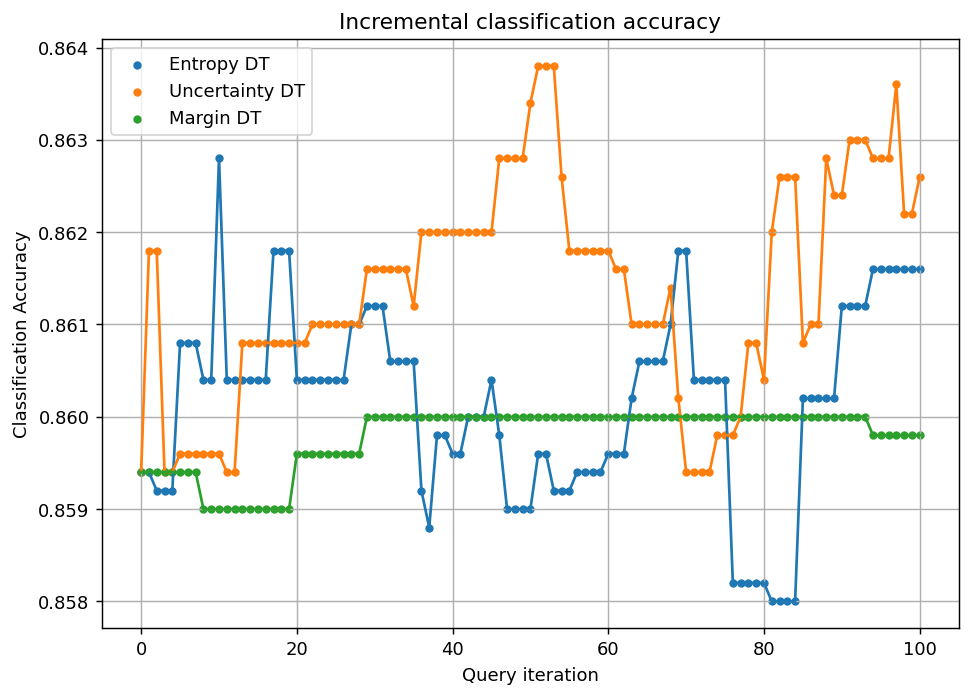

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_entro_dt)
ax.scatter(range(len(history_entro_dt)), history_entro_dt, s=13, label = 'Entropy DT')

ax.plot(history_uncert_dt)
ax.scatter(range(len(history_uncert_dt)), history_uncert_dt, s=13, label = 'Uncertainty DT')

ax.plot(history_marg_dt)
ax.scatter(range(len(history_marg_dt)), history_marg_dt, s=13, label = 'Margin DT')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **KNN**

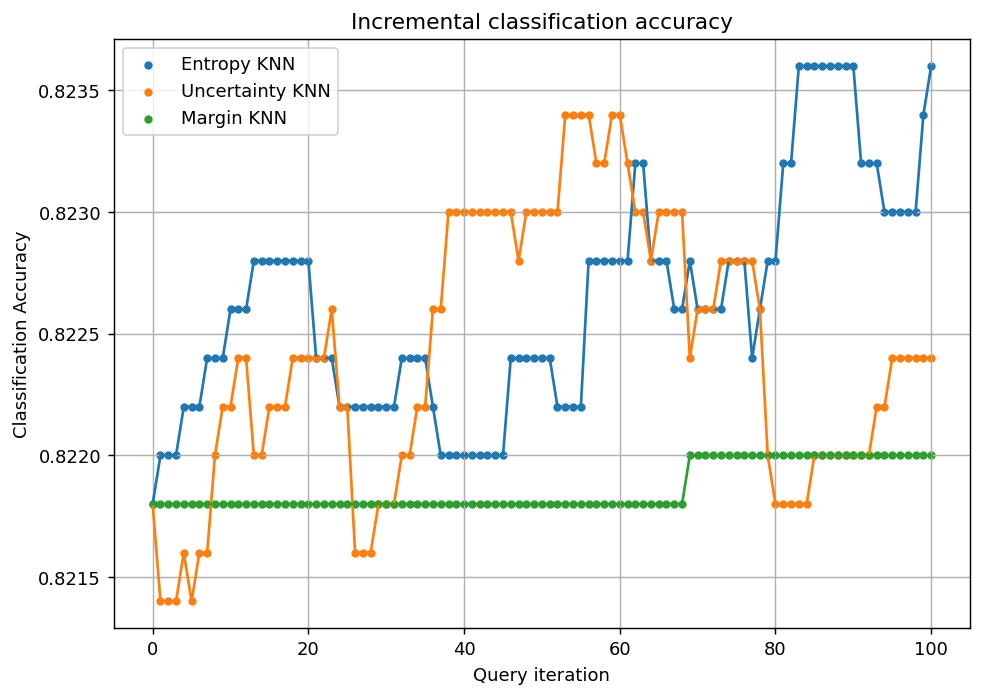

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_entro_knn)
ax.scatter(range(len(history_entro_knn)), history_entro_knn, s=13, label = 'Entropy KNN')

ax.plot(history_uncert_knn)
ax.scatter(range(len(history_uncert_knn)), history_uncert_knn, s=13, label = 'Uncertainty KNN')

ax.plot(history_marg_knn)
ax.scatter(range(len(history_marg_knn)), history_marg_knn, s=13, label = 'Margin KNN')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **NN**

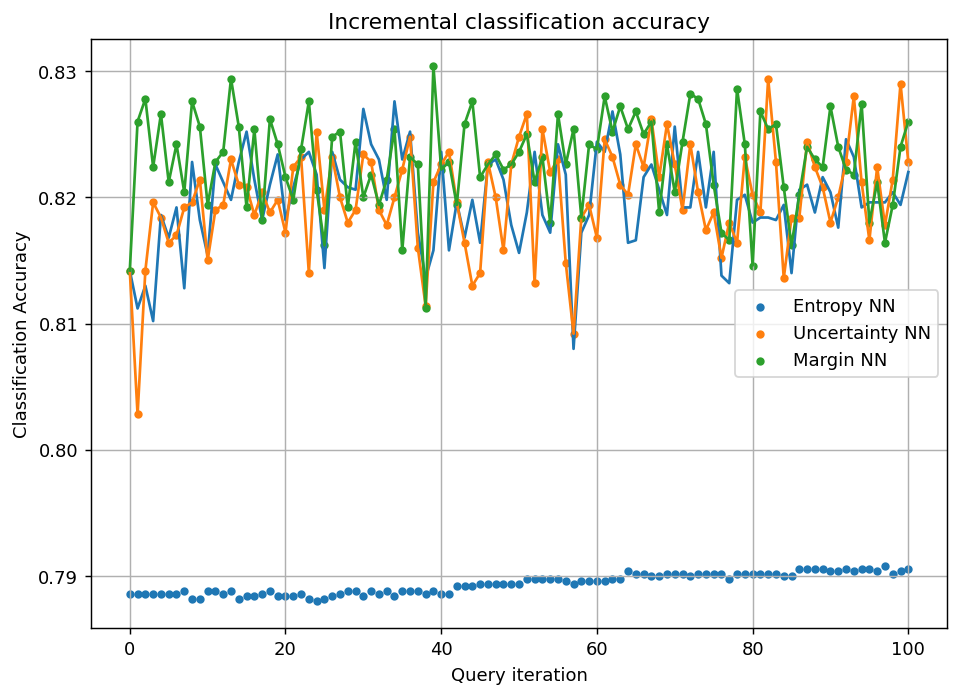

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_entro_nn)
ax.scatter(range(len(history_entro_nn)), history_entro_nn, s=13, label = 'Entropy NN')

ax.plot(history_uncert_nn)
ax.scatter(range(len(history_uncert_nn)), history_uncert_nn, s=13, label = 'Uncertainty NN')

ax.plot(history_marg_nn)
ax.scatter(range(len(history_marg_nn)), history_marg_nn, s=13, label = 'Margin NN')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

#### **Query By Committee**

##### **Vote Entropy**

In [ ]:
from sklearn import tree

In [ ]:
# initializing Committee members
learner_list = list()


learner1 = ActiveLearner(
       estimator=LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' ), 
        X_training=X_train_new, y_training=y_train_new)

learner2 = ActiveLearner(estimator=SVC(C=svc_train.best_estimator_.C, kernel='linear', probability=True, class_weight= 'balanced'),
                        X_training=X_train_new, y_training=y_train_new)
learner3 = ActiveLearner(
        estimator=tree.DecisionTreeClassifier(random_state = seed, max_depth = 8), 
    X_training=X_train_new, y_training=y_train_new)
learner4= ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors = 22, weights= 'uniform'), X_training=X_train_new, y_training=y_train_new
  )
learner5=ActiveLearner( 
        estimator=GaussianNB(), X_training=X_train_new, y_training=y_train_new
    )
learner6 = ActiveLearner(estimator=MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                                                 learning_rate_init=nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 ),
                                             X_training=X_train_new, 
                                             y_training=y_train_new)

learner_list.append(learner1)
learner_list.append(learner2)
learner_list.append(learner3)
learner_list.append(learner4)
learner_list.append(learner5)
learner_list.append(learner6)
# assembling the committee
committee = Committee(learner_list=learner_list,query_strategy=vote_entropy)
#compute committee score
initial_score = committee.score(X_train_new, y_train_new)

print(f"Prediction Accuracy : {initial_score}")

Prediction Accuracy : 0.8302


In [ ]:
# prediction
y_pred_train = committee.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_com_train = accuracy_score(y_train_new,y_pred_train)
f1_com_train = f1_score(y_train_new, y_pred_train, average="macro")
prec_com_train = precision_score(y_train_new, y_pred_train, average="macro")
rec_com_train = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_com_train)
print("f1 score : ",f1_com_train)
print("precision score : ",prec_com_train)
print("recall score : ",rec_com_train)


accuracy score :  0.8302
f1 score :  0.7928547932595682
precision score :  0.7979751673300186
recall score :  0.7883746779377876


In [ ]:
# AUC on train
auc_com_train = roc_auc_score(y_train_new,y_pred_train)
auc_com_train

0.7883746779377876

In [ ]:
# Check the performance on test set

print('Accuracy of classifier on test set: {:.2f}'
     .format(committee.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = committee.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_com = confusion_matrix(y_test, y_pred_test)
print(cm_com)

Accuracy of classifier on test set: 0.82
[[6138  868]
 [ 950 2041]]


In [ ]:
# confusion matrix
TP_com = cm_com[0,0]
FP_com = cm_com[0,1]
FN_com = cm_com[1,0]
TN_com = cm_com[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_com_test = accuracy_score(y_test,y_pred_test)
f1_com_test = f1_score(y_test, y_pred_test, average="macro")
prec_com_test = precision_score(y_test, y_pred_test, average="macro")
rec_com_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_com_test)
print("f1 score : ",f1_com_test)
print("precision score : ",prec_com_test)
print("recall score : ",rec_com_test)

accuracy score :  0.8181454436330899
f1 score :  0.7814366733770592
precision score :  0.7837931650586993
recall score :  0.7792433347239358


In [ ]:
# AUC on test set
auc_com_test = roc_auc_score(y_test,y_pred_test)
auc_com_test

0.7792433347239358

###### QBC Process

In [ ]:
# query rejected applications
vote_entropy(committee, X_pool)[:1000]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.45056121, 0.45056121, 0.        , 0.        ,
       0.63651417, 0.        , 0.        , 0.        , 0.        ,
       0.63651417, 0.        , 0.        , 0.        , 0.45056121,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.63651417, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.63651417, 0.        , 0.        , 0.63651417, 0.45056121,
       0.        , 0.        , 0.        , 0.45056121, 0.63651417,
       0.        , 0.        , 0.45056121, 0.        , 0.        ,
       0.45056121, 0.63651417, 0.45056121, 0.        , 0.        ,
       0.        , 0.        , 0.45056121, 0.        , 0.        ,
       0.63651417, 0.        , 0.        , 0.        , 0.     

In [ ]:
# learning process
history_vote_entro = [initial_score]
num_q=100

while (num_q) :
    stream_idx = np.random.choice(range(len(X_pool)))
    if vote_entropy(committee,X_pool[stream_idx].reshape(1, -1)) >= 0.6:
        num_q=num_q-1;
        committee.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
        new_score = committee.score(X_train_new, y_train_new)
        history_vote_entro.append(new_score)
        # remove queried instance from pool
        X_pool = np.delete(X_pool, stream_idx, axis=0)
        y_pool = np.delete(y_pool, stream_idx)
        print('Example no. %d queried, new accuracy: %f' %  (stream_idx, new_score))

Example no. 22747 queried, new accuracy: 0.826800
Example no. 18255 queried, new accuracy: 0.828400
Example no. 16897 queried, new accuracy: 0.829200
Example no. 26483 queried, new accuracy: 0.830000
Example no. 12496 queried, new accuracy: 0.830800
Example no. 26034 queried, new accuracy: 0.831400
Example no. 20259 queried, new accuracy: 0.831000
Example no. 9785 queried, new accuracy: 0.830400
Example no. 6213 queried, new accuracy: 0.827200
Example no. 2905 queried, new accuracy: 0.835000
Example no. 34064 queried, new accuracy: 0.830400
Example no. 24850 queried, new accuracy: 0.833600
Example no. 18520 queried, new accuracy: 0.833400
Example no. 22804 queried, new accuracy: 0.832600
Example no. 24277 queried, new accuracy: 0.832200
Example no. 20398 queried, new accuracy: 0.831600
Example no. 15839 queried, new accuracy: 0.831200
Example no. 33084 queried, new accuracy: 0.833400
Example no. 10549 queried, new accuracy: 0.833200
Example no. 27113 queried, new accuracy: 0.832800
Exa

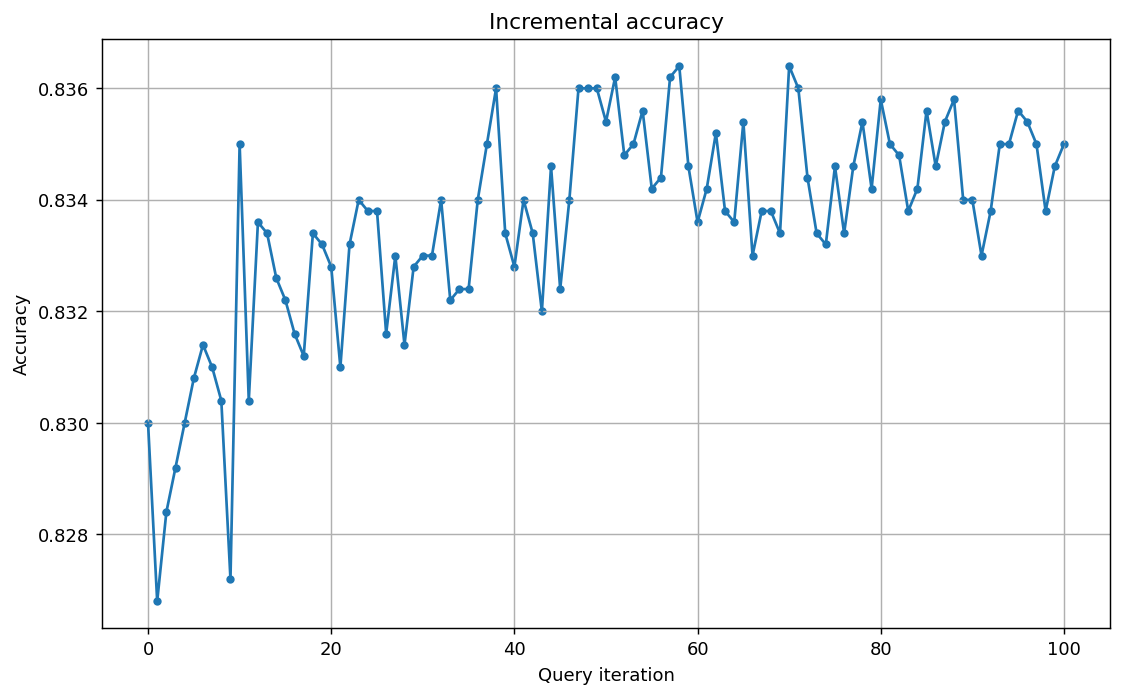

In [ ]:
# learning curve
plot_performance_model(history_vote_entro)

In [ ]:
# prediction
y_pred_train = committee.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_vote_entro = accuracy_score(y_train_new,y_pred_train)
f1_vote_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_vote_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_vote_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_vote_entro)
print("f1 score : ",f1_vote_entro)
print("precision score : ",prec_vote_entro)
print("recall score : ",rec_vote_entro)


accuracy score :  0.835
f1 score :  0.7965782839994988
precision score :  0.8056909984753915
recall score :  0.7892295403568061


In [ ]:
# Compute AUC on train
auc_vote_entro = roc_auc_score(y_train_new,y_pred_train)
auc_vote_entro

0.7892295403568061

In [ ]:
# Check the performance on test set

print('Accuracy of classifier on test set: {:.2f}'
     .format(committee.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = committee.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_vote_entro = confusion_matrix(y_test, y_pred_test)
print(cm_vote_entro)

Accuracy of classifier on test set: 0.82
[[6217  789]
 [1006 1985]]


In [ ]:
# confusion matrix
TP_vote_entro = cm_vote_entro[0,0]
FP_vote_entro = cm_vote_entro[0,1]
FN_vote_entro = cm_vote_entro[1,0]
TN_vote_entro = cm_vote_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_vote_entro_test = accuracy_score(y_test,y_pred_test)
f1_vote_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_vote_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_vote_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_vote_entro_test)
print("f1 score : ",f1_vote_entro_test)
print("precision score : ",prec_vote_entro_test)
print("recall score : ",rec_vote_entro_test)

accuracy score :  0.8204461338401521
f1 score :  0.7812437580141993
precision score :  0.7881479354633086
recall score :  0.7755199416882296


In [ ]:
# AUC on test
auc_vote_entro_test = roc_auc_score(y_test,y_pred_test)
auc_vote_entro_test

0.7755199416882296

##### **KL Divergence**

In [ ]:
from sklearn import tree

In [ ]:
# initializing Committee members
learner_list = list()


learner1 = ActiveLearner(
       estimator=LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' ), 
        X_training=X_train_new, y_training=y_train_new)

learner2 = ActiveLearner(estimator=SVC(C=svc_train.best_estimator_.C, kernel='linear', probability=True, class_weight= 'balanced'),
                        X_training=X_train_new, y_training=y_train_new)
learner3 = ActiveLearner(
        estimator=tree.DecisionTreeClassifier(random_state = seed, max_depth = 8), 
    X_training=X_train_new, y_training=y_train_new)
learner4= ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors = 22, weights= 'uniform'), X_training=X_train_new, y_training=y_train_new
  )
learner5=ActiveLearner( 
        estimator=GaussianNB(), X_training=X_train_new, y_training=y_train_new
    )
learner6 = ActiveLearner(estimator=MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                                                 learning_rate_init=nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 ),
                                             X_training=X_train_new, 
                                             y_training=y_train_new)

learner_list.append(learner1)
learner_list.append(learner2)
learner_list.append(learner3)
learner_list.append(learner4)
learner_list.append(learner5)
learner_list.append(learner6)
# assembling the committee
committee = Committee(learner_list=learner_list,query_strategy=kL_max_disagreement)
#compute committee score
initial_score = committee.score(X_train_new, y_train_new)

print(f"Prediction Accuracy : {initial_score}")

Prediction Accuracy : 0.8302


In [ ]:
# query rejected applications
KL_max_disagreement(committee, X_pool)[:1000]

array([0.2398146 , 0.24224889, 0.17061741, 0.24522312, 0.26008795,
       0.03645815, 0.13577716, 0.05686981, 0.05899979, 0.22091996,
       0.75780404, 0.16352004, 0.16813685, 0.15970087, 0.11177191,
       0.08677967, 0.15943064, 0.35438099, 0.15496167, 0.24991871,
       0.25936441, 0.14767507, 0.1780232 , 0.3241563 , 0.26017492,
       0.23665046, 0.2832994 , 0.26120094, 0.29398844, 0.27048228,
       0.04747519, 0.14325981, 0.23378847, 0.31618406, 0.08550891,
       0.12512135, 0.11766798, 0.09946188, 0.25447283, 0.29429956,
       0.14918886, 0.12320085, 0.1887713 , 0.33404708, 0.15331407,
       0.20654387, 0.21779133, 0.22363778, 0.31212812, 0.595019  ,
       0.1363247 , 0.33251898, 0.32985286, 0.17170716, 0.20447031,
       0.3478475 , 0.33831858, 0.22127143, 0.17655029, 0.15447251,
       0.05508084, 0.0639786 , 0.20081927, 0.26449613, 0.33429666,
       0.24908291, 0.34023034, 0.32634635, 0.0727918 , 0.31119018,
       0.26313324, 0.23911135, 0.27076605, 0.25709162, 0.25646

In [ ]:
# QBC process
history_kl_diverg = [initial_score]
num_q=100

while (num_q) :
    stream_idx = np.random.choice(range(len(X_pool)))
    if KL_max_disagreement(committee,X_pool[stream_idx].reshape(1, -1)) >= 0.8:
        num_q=num_q-1;
        committee.teach(X_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1, ))
        new_score = committee.score(X_train_new, y_train_new)
        history_kl_diverg.append(new_score)
        # remove queried instance from pool
        X_pool = np.delete(X_pool, stream_idx, axis=0)
        y_pool = np.delete(y_pool, stream_idx)
        print('Example no. %d queried, new accuracy: %f' %  (stream_idx, new_score))

Example no. 2840 queried, new accuracy: 0.826400
Example no. 31499 queried, new accuracy: 0.827200
Example no. 11817 queried, new accuracy: 0.828600
Example no. 7213 queried, new accuracy: 0.828600
Example no. 2042 queried, new accuracy: 0.829800
Example no. 33343 queried, new accuracy: 0.828600
Example no. 19477 queried, new accuracy: 0.832600
Example no. 32770 queried, new accuracy: 0.829200
Example no. 3082 queried, new accuracy: 0.828400
Example no. 4327 queried, new accuracy: 0.830000
Example no. 32037 queried, new accuracy: 0.830000
Example no. 4040 queried, new accuracy: 0.830000
Example no. 15255 queried, new accuracy: 0.831600
Example no. 8258 queried, new accuracy: 0.831200
Example no. 33643 queried, new accuracy: 0.831800
Example no. 30689 queried, new accuracy: 0.828400
Example no. 21686 queried, new accuracy: 0.830600
Example no. 18910 queried, new accuracy: 0.830400
Example no. 10783 queried, new accuracy: 0.829800
Example no. 2061 queried, new accuracy: 0.831200
Example 

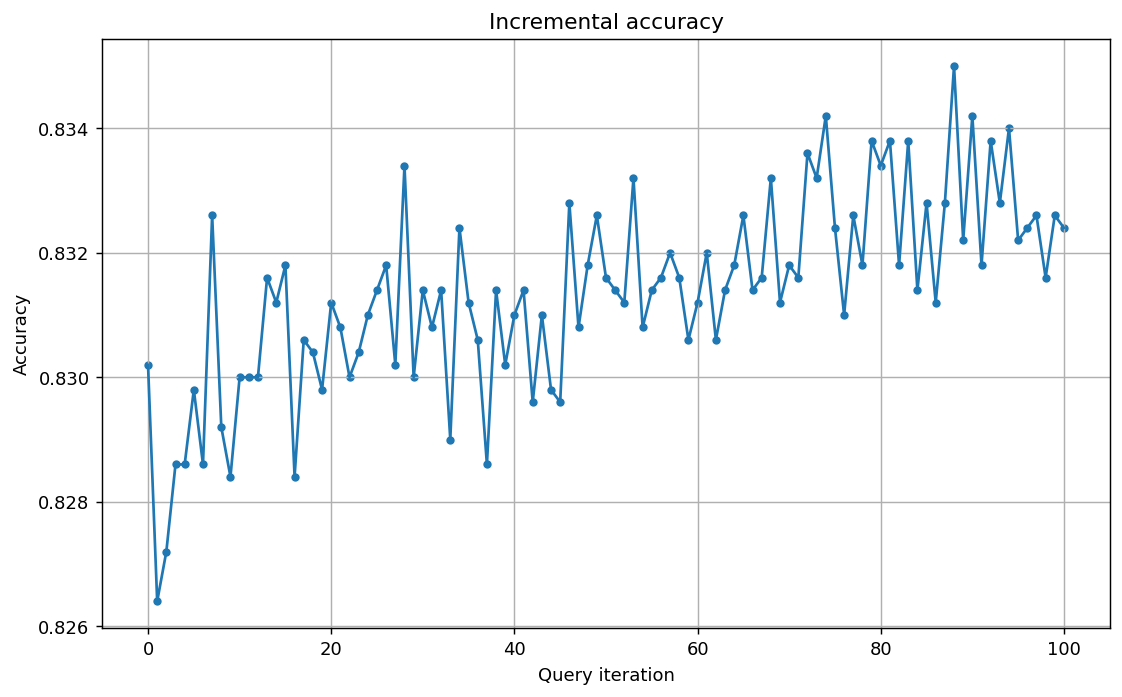

In [ ]:
# Plot our performance over time.
plot_performance_model(history_kl_diverg)

In [ ]:
# prediction
y_pred_train = committee.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_kl_diverg = accuracy_score(y_train_new,y_pred_train)
f1_kl_diverg = f1_score(y_train_new, y_pred_train, average="macro")
prec_kl_diverg = precision_score(y_train_new, y_pred_train, average="macro")
rec_kl_diverg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_kl_diverg)
print("f1 score : ",f1_kl_diverg)
print("precision score : ",prec_kl_diverg)
print("recall score : ",rec_kl_diverg)


accuracy score :  0.8324
f1 score :  0.795241190239993
precision score :  0.8009181384917298
recall score :  0.7903289510588384


In [ ]:
# AUC on train set
auc_kl_diverg = roc_auc_score(y_train_new,y_pred_train)
auc_kl_diverg

0.7903289510588384

In [ ]:
# compute confusion matrix on test set
y_pred_test = committee.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_kl_diverg = confusion_matrix(y_test, y_pred_test)
print(cm_kl_diverg)

[[6174  832]
 [ 944 2047]]


In [ ]:
# confusion matrix
TP_kl_diverg = cm_kl_diverg[0,0]
FP_kl_diverg = cm_kl_diverg[0,1]
FN_kl_diverg = cm_kl_diverg[1,0]
TN_kl_diverg = cm_kl_diverg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_kl_diverg_test = accuracy_score(y_test,y_pred_test)
f1_kl_diverg_test = f1_score(y_test, y_pred_test, average="macro")
prec_kl_diverg_test = precision_score(y_test, y_pred_test, average="macro")
rec_kl_diverg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_kl_diverg_test)
print("f1 score : ",f1_kl_diverg_test)
print("precision score : ",prec_kl_diverg_test)
print("recall score : ",rec_kl_diverg_test)

accuracy score :  0.8223467040112034
f1 score :  0.7858506091338966
precision score :  0.7891946223639787
recall score :  0.7828155701284079


In [ ]:
# AUC on test set
auc_kl_diverg_test = roc_auc_score(y_test,y_pred_test)
auc_kl_diverg_test

0.7828155701284079

##### **Plot Accuracy using QBC approach**

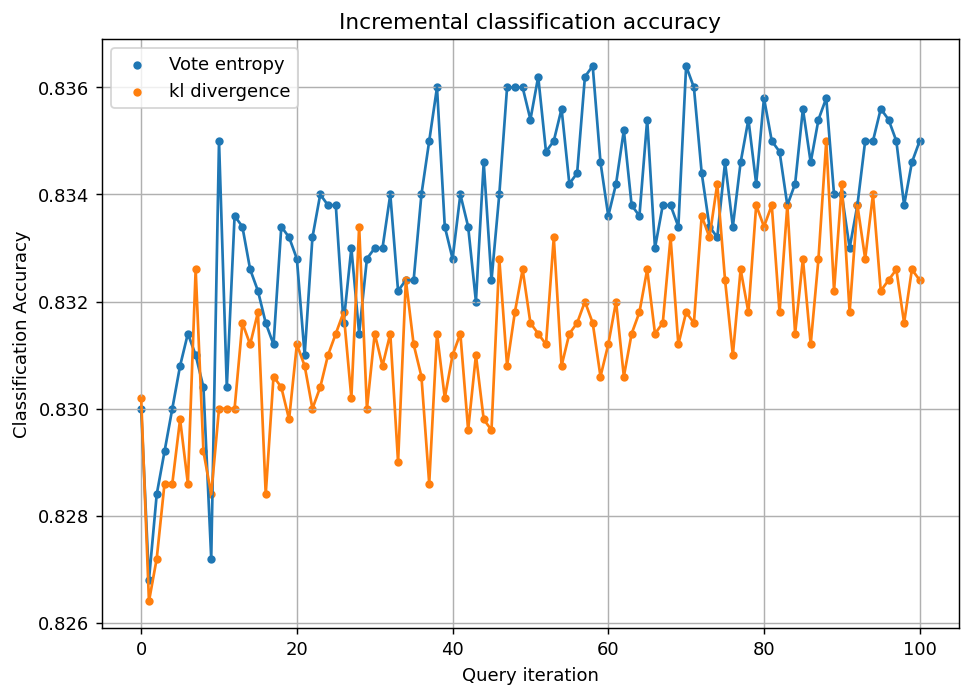

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_vote_entro)
ax.scatter(range(len(history_vote_entro)), history_vote_entro, s=13, label = 'Vote entropy')

ax.plot(history_kl_diverg)
ax.scatter(range(len(history_kl_diverg)), history_kl_diverg, s=13, label = 'kl divergence')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

##### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Approach': ['Acc (train)','AUC (train)'],
            'Committee' : [acc_com_train, auc_com_train],
            'Vote Entropy (VE)': [acc_vote_entro, auc_vote_entro],
            'KL Divergence (KLD)': [acc_kl_diverg, auc_kl_diverg]
             }
dfp = pd.DataFrame(results_train, columns = ['Approach', 
                                      'Committee',
                                     'Vote Entropy (VE)',
                                     'KL Divergence (KLD)'
                                        ])
dfp.set_index("Approach", inplace=True)

results_train = dfp.T
results_train

Approach             Acc (train)  AUC (train)
Committee                 0.8302     0.788375
Vote Entropy (VE)         0.8350     0.789230
KL Divergence (KLD)       0.8324     0.790329

In [ ]:
# Creating performance table of test
results_test = {'Approach': ['Acc (test)','AUC (test)'],
            'Committee' : [acc_com_test, auc_com_test],
            'Vote Entropy (VE)': [acc_vote_entro_test, auc_vote_entro_test],
            'KL Divergence (KLD)': [acc_kl_diverg_test, auc_kl_diverg_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Approach', 
                                      'Committee',
                                     'Vote Entropy (VE)',
                                     'KL Divergence (KLD)'
                                        ])
dfp.set_index("Approach", inplace=True)

results_test = dfp.T
results_test

Approach             Acc (test)  AUC (test)
Committee              0.818145    0.779243
Vote Entropy (VE)      0.820446    0.775520
KL Divergence (KLD)    0.822347    0.782816

In [ ]:
# Creating confusion matrix table
results = {'Approach': ['TP','FP', 'TN', 'FN'],
            'Committee' : [TP_com, FP_com, TN_com, FN_com],
            'Vote Entropy (VE)': [TP_vote_entro, FP_vote_entro, TN_vote_entro, FN_vote_entro],
            'KL Divergence (KLD)': [TP_kl_diverg, FP_kl_diverg, TN_kl_diverg, FN_kl_diverg]
             }
tcm = pd.DataFrame(results, columns = ['Approach', 
                                      'Committee',
                                     'Vote Entropy (VE)',
                                     'KL Divergence (KLD)'
                                        ])
tcm.set_index("Approach", inplace=True)

results = tcm.T
results

Approach               TP   FP    TN    FN
Committee            6138  868  2041   950
Vote Entropy (VE)    6217  789  1985  1006
KL Divergence (KLD)  6174  832  2047   944

### **Pool Based Active Learning**

#### **Uncertainty Sampling**

##### **entropy sampling**

###### **SCV**

In [ ]:
svc = SVC(C=svc_train.best_estimator_.C,kernel='linear', random_state=seed, class_weight='balanced', probability=True)
learner = ActiveLearner(estimator=svc, query_strategy=entropy_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# learning process
num_of_queries = 100


history_entro_svc = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (entropy sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_entro_svc.append(accuracy)

Accuracy after query 1: 0.7886
Accuracy after query 2: 0.7886
Accuracy after query 3: 0.7888
Accuracy after query 4: 0.7888
Accuracy after query 5: 0.7888
Accuracy after query 6: 0.7888
Accuracy after query 7: 0.7884
Accuracy after query 8: 0.7886
Accuracy after query 9: 0.7886
Accuracy after query 10: 0.7884
Accuracy after query 11: 0.7884
Accuracy after query 12: 0.7884
Accuracy after query 13: 0.7880
Accuracy after query 14: 0.7886
Accuracy after query 15: 0.7886
Accuracy after query 16: 0.7884
Accuracy after query 17: 0.7886
Accuracy after query 18: 0.7886
Accuracy after query 19: 0.7886
Accuracy after query 20: 0.7884
Accuracy after query 21: 0.7884
Accuracy after query 22: 0.7884
Accuracy after query 23: 0.7884
Accuracy after query 24: 0.7884
Accuracy after query 25: 0.7886
Accuracy after query 26: 0.7882
Accuracy after query 27: 0.7884
Accuracy after query 28: 0.7886
Accuracy after query 29: 0.7892
Accuracy after query 30: 0.7892
Accuracy after query 31: 0.7890
Accuracy after qu

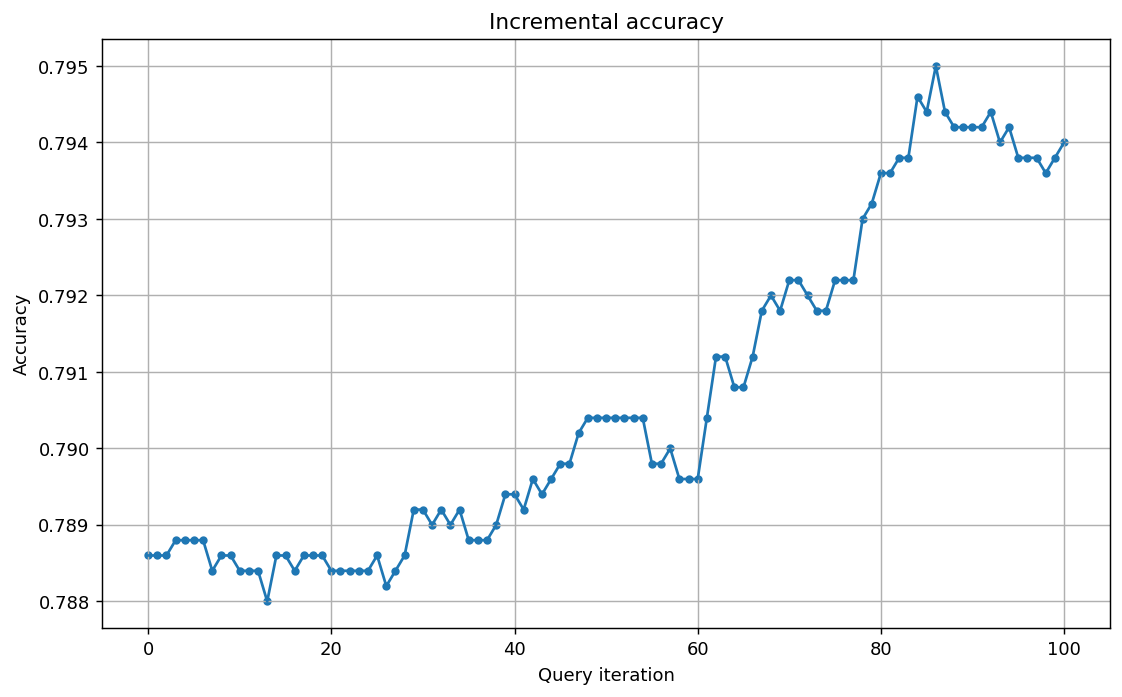

In [ ]:
# learning curve
plot_performance_model(history_entro_svc)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)


In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_svc_entro = accuracy_score(y_train_new,y_pred_train)
f1_svc_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_entro)
print("f1 score : ",f1_svc_entro)
print("precision score : ",prec_svc_entro)
print("recall score : ",rec_svc_entro)


accuracy score :  0.794
f1 score :  0.7658371816363243
precision score :  0.7598126537777488
recall score :  0.7743187631264495


In [ ]:
# Compute AUC on train set
auc_svc_entro = roc_auc_score(y_train_new,y_pred_train)
auc_svc_entro

0.7743187631264495

Accuracy of SVC classifier on test set: 0.80


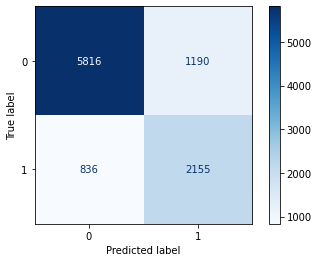

In [ ]:
# Check the performance on test set

print('Accuracy of SVC classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_svc_entro = cm_svc_entro[0,0]
FP_svc_entro = cm_svc_entro[0,1]
FN_svc_entro = cm_svc_entro[1,0]
TN_svc_entro = cm_svc_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_entro_test = accuracy_score(y_test,y_pred_test)
f1_svc_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_entro_test)
print("f1 score : ",f1_svc_entro_test)
print("precision score : ",prec_svc_entro_test)
print("recall score : ",rec_svc_entro_test)

accuracy score :  0.7973392017605282
f1 score :  0.7659509642848162
precision score :  0.7592843268643932
recall score :  0.7753202036407061


In [ ]:
# AUC on test set
auc_svc_entro_test = roc_auc_score(y_test,y_pred_test)
auc_svc_entro_test

0.7753202036407061

###### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C= lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=entropy_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# learner process
num_of_queries = 100


history_entro_lr = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (entropy sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_entro_lr.append(accuracy)


Accuracy after query 1: 0.7874
Accuracy after query 2: 0.7874
Accuracy after query 3: 0.7874
Accuracy after query 4: 0.7874
Accuracy after query 5: 0.7876
Accuracy after query 6: 0.7874
Accuracy after query 7: 0.7876
Accuracy after query 8: 0.7876
Accuracy after query 9: 0.7874
Accuracy after query 10: 0.7874
Accuracy after query 11: 0.7874
Accuracy after query 12: 0.7874
Accuracy after query 13: 0.7870
Accuracy after query 14: 0.7872
Accuracy after query 15: 0.7872
Accuracy after query 16: 0.7874
Accuracy after query 17: 0.7872
Accuracy after query 18: 0.7868
Accuracy after query 19: 0.7868
Accuracy after query 20: 0.7868
Accuracy after query 21: 0.7870
Accuracy after query 22: 0.7868
Accuracy after query 23: 0.7868
Accuracy after query 24: 0.7874
Accuracy after query 25: 0.7874
Accuracy after query 26: 0.7874
Accuracy after query 27: 0.7872
Accuracy after query 28: 0.7874
Accuracy after query 29: 0.7870
Accuracy after query 30: 0.7874
Accuracy after query 31: 0.7868
Accuracy after qu

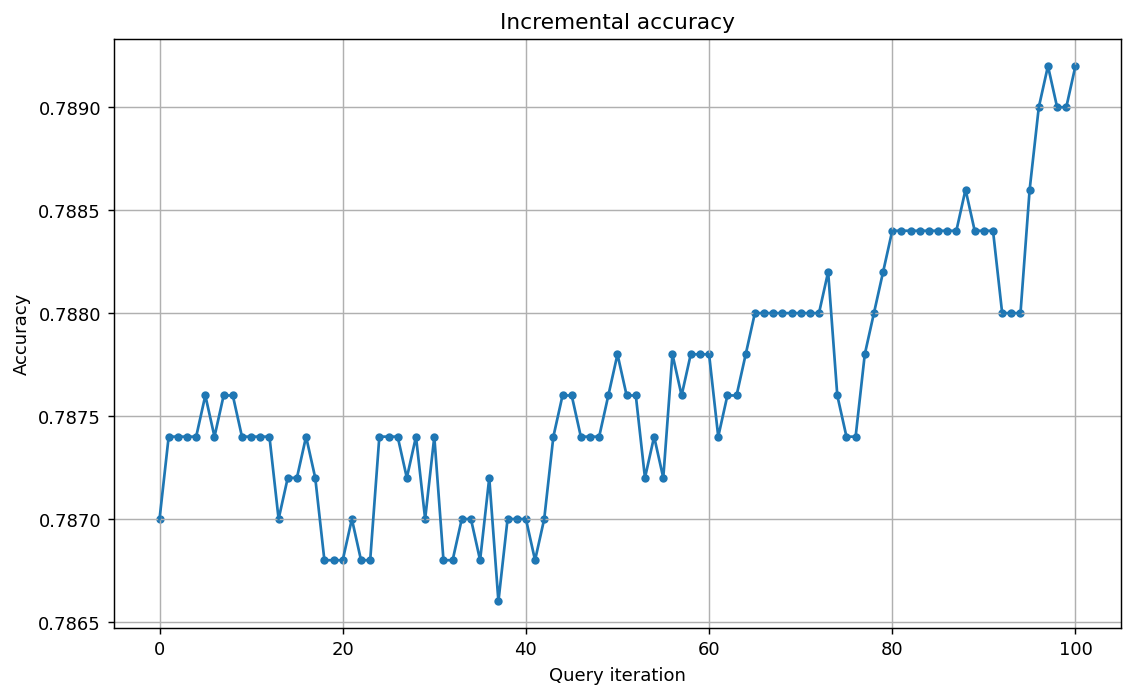

In [ ]:
# learning curve
plot_performance_model(history_entro_lr)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_lr_entro = accuracy_score(y_train_new,y_pred_train)
f1_lr_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_entro)
print("f1 score : ",f1_lr_entro)
print("precision score : ",prec_lr_entro)
print("recall score : ",rec_lr_entro)


accuracy score :  0.7892
f1 score :  0.7625165922942538
precision score :  0.7554428627526094
recall score :  0.7738764021280503


In [ ]:
# AUC on train set
auc_lr_entro = roc_auc_score(y_train_new,y_pred_train)
auc_lr_entro

0.7738764021280503

Accuracy of lr classifier on test set: 0.79


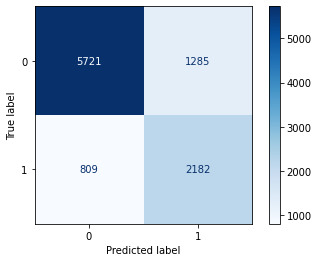

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_lr_entro = cm_lr_entro[0,0]
FP_lr_entro = cm_lr_entro[0,1]
FN_lr_entro = cm_lr_entro[1,0]
TN_lr_entro = cm_lr_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_entro_test = accuracy_score(y_test,y_pred_test)
f1_lr_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_entro_test)
print("f1 score : ",f1_lr_entro_test)
print("precision score : ",prec_lr_entro_test)
print("recall score : ",rec_lr_entro_test)

accuracy score :  0.7905371611483445
f1 score :  0.7605262124716389
precision score :  0.752736410814545
recall score :  0.7730538413222349


In [ ]:
# AUC on test set
auc_lr_entro_test = roc_auc_score(y_test,y_pred_test)
auc_lr_entro_test

0.7730538413222349

###### **KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=entropy_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - KNN: {initial_score}")

Prediction Accuracy - KNN: 0.8218


In [ ]:
# learning process
num_of_queries = 100


history_entro_knn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (entropy sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_entro_knn.append(accuracy)


Accuracy after query 1: 0.8218
Accuracy after query 2: 0.8222
Accuracy after query 3: 0.8222
Accuracy after query 4: 0.8224
Accuracy after query 5: 0.8224
Accuracy after query 6: 0.8224
Accuracy after query 7: 0.8224
Accuracy after query 8: 0.8224
Accuracy after query 9: 0.8220
Accuracy after query 10: 0.8222
Accuracy after query 11: 0.8222
Accuracy after query 12: 0.8224
Accuracy after query 13: 0.8228
Accuracy after query 14: 0.8230
Accuracy after query 15: 0.8230
Accuracy after query 16: 0.8230
Accuracy after query 17: 0.8228
Accuracy after query 18: 0.8232
Accuracy after query 19: 0.8232
Accuracy after query 20: 0.8232
Accuracy after query 21: 0.8236
Accuracy after query 22: 0.8234
Accuracy after query 23: 0.8234
Accuracy after query 24: 0.8234
Accuracy after query 25: 0.8236
Accuracy after query 26: 0.8236
Accuracy after query 27: 0.8234
Accuracy after query 28: 0.8230
Accuracy after query 29: 0.8232
Accuracy after query 30: 0.8232
Accuracy after query 31: 0.8234
Accuracy after qu

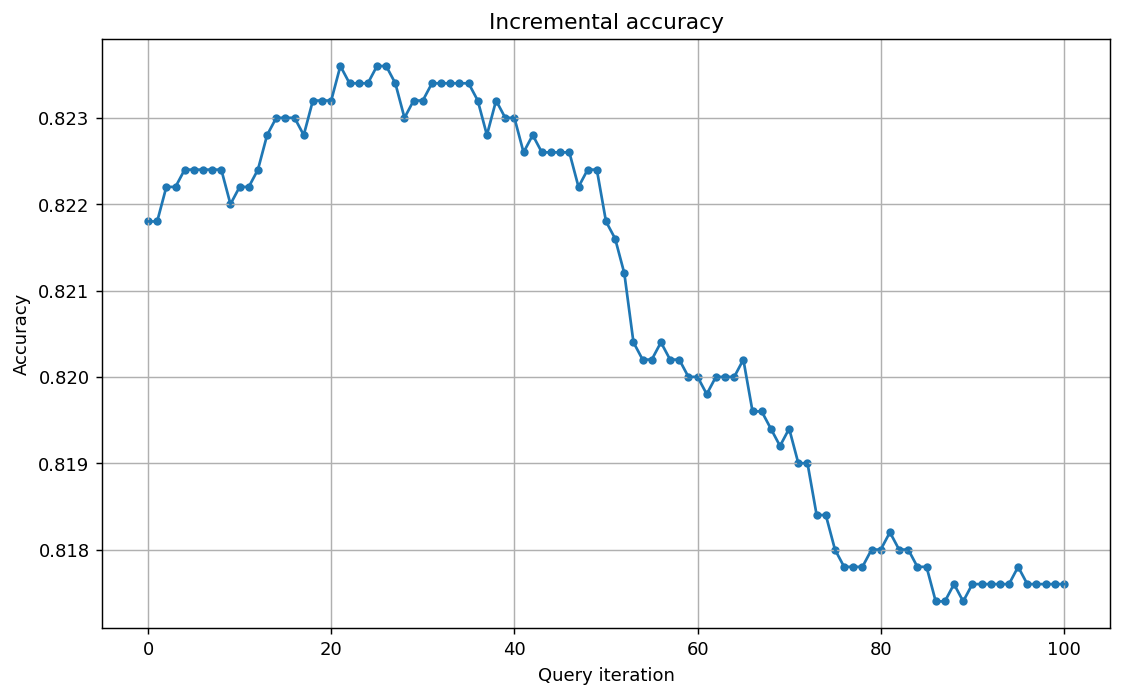

In [ ]:
# learning curve
plot_performance_model(history_entro_knn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_entro = accuracy_score(y_train_new,y_pred_train)
f1_knn_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_entro= precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_entro)
print("f1 score : ",f1_knn_entro)
print("precision score : ",prec_knn_entro)
print("recall score : ",rec_knn_entro)

accuracy score :  0.8176
f1 score :  0.7759396971176411
precision score :  0.7939479356898936
recall score :  0.7642878577615635


In [ ]:
# AUC on train set
auc_knn_entro = roc_auc_score(y_train_new,y_pred_train)
auc_knn_entro

0.7642878577615635

Accuracy of knn classifier on test set: 0.81


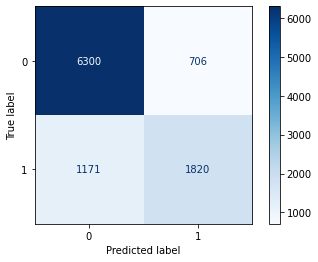

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_knn_entro = cm_knn_entro[0,0]
FP_knn_entro = cm_knn_entro[0,1]
FN_knn_entro = cm_knn_entro[1,0]
TN_knn_entro = cm_knn_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_entro_test = accuracy_score(y_test,y_pred_test)
f1_knn_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_entro_test)
print("f1 score : ",f1_knn_entro_test)
print("precision score : ",prec_knn_entro_test)
print("recall score : ",rec_knn_entro_test)

accuracy score :  0.8122436731019306
f1 score :  0.7650624657496445
precision score :  0.7818836688454793
recall score :  0.7538606875913687


In [ ]:
# AUC on test set
auc_knn_entro_test = roc_auc_score(y_test,y_pred_test)
auc_knn_entro_test

0.7538606875913687

###### **DT**

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=entropy_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - dt: {initial_score}")

Prediction Accuracy - dt: 0.8594


In [ ]:
# Learning process
num_of_queries = 100


history_entro_dt = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (entropy sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_entro_dt.append(accuracy)

Accuracy after query 1: 0.8592
Accuracy after query 2: 0.8608
Accuracy after query 3: 0.8608
Accuracy after query 4: 0.8608
Accuracy after query 5: 0.8602
Accuracy after query 6: 0.8602
Accuracy after query 7: 0.8602
Accuracy after query 8: 0.8602
Accuracy after query 9: 0.8602
Accuracy after query 10: 0.8602
Accuracy after query 11: 0.8602
Accuracy after query 12: 0.8602
Accuracy after query 13: 0.8602
Accuracy after query 14: 0.8602
Accuracy after query 15: 0.8602
Accuracy after query 16: 0.8600
Accuracy after query 17: 0.8602
Accuracy after query 18: 0.8602
Accuracy after query 19: 0.8602
Accuracy after query 20: 0.8602
Accuracy after query 21: 0.8602
Accuracy after query 22: 0.8602
Accuracy after query 23: 0.8602
Accuracy after query 24: 0.8608
Accuracy after query 25: 0.8584
Accuracy after query 26: 0.8596
Accuracy after query 27: 0.8596
Accuracy after query 28: 0.8608
Accuracy after query 29: 0.8608
Accuracy after query 30: 0.8608
Accuracy after query 31: 0.8620
Accuracy after qu

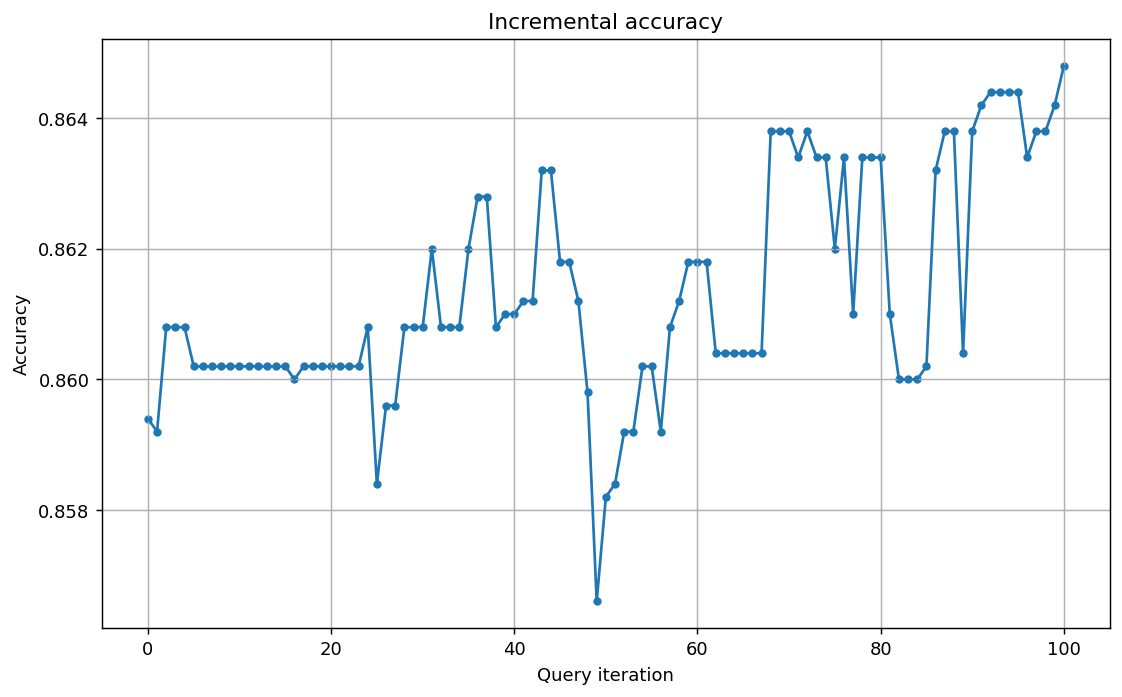

In [ ]:
# Display learning curve
plot_performance_model(history_entro_dt)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_entro = accuracy_score(y_train_new,y_pred_train)
f1_dt_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_entro)
print("f1 score : ",f1_dt_entro)
print("precision score : ",prec_dt_entro)
print("recall score : ",rec_dt_entro)

accuracy score :  0.8648
f1 score :  0.8348246355635266
precision score :  0.8533968689763398
recall score :  0.821832040976519


In [ ]:
# AUC on train set
auc_dt_entro = roc_auc_score(y_train_new,y_pred_train)
auc_dt_entro

0.821832040976519

Accuracy of dt classifier on test set: 0.80


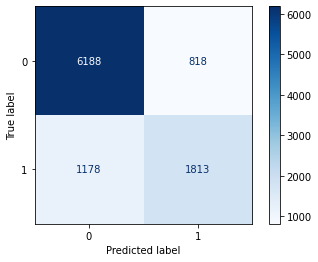

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_dt_entro = cm_dt_entro[0,0]
FP_dt_entro = cm_dt_entro[0,1]
FN_dt_entro = cm_dt_entro[1,0]
TN_dt_entro = cm_dt_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_entro_test = accuracy_score(y_test,y_pred_test)
f1_dt_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_entro_test)
print("f1 score : ",f1_dt_entro_test)
print("precision score : ",prec_dt_entro_test)
print("recall score : ",rec_dt_entro_test)

accuracy score :  0.8003401020306092
f1 score :  0.7530425231954738
precision score :  0.7645838125658349
recall score :  0.7446973616634469


In [ ]:
# AUC on test set
auc_dt_entro_test = roc_auc_score(y_test,y_pred_test)
auc_dt_entro_test

0.7446973616634469

###### **NB**

In [ ]:
gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=entropy_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# learning process
num_of_queries = 100


history_entro_gm = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (entropy sampling).

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_entro_gm.append(accuracy)

Accuracy after query 1: 0.7966
Accuracy after query 2: 0.7968
Accuracy after query 3: 0.7966
Accuracy after query 4: 0.7966
Accuracy after query 5: 0.7966
Accuracy after query 6: 0.7968
Accuracy after query 7: 0.7966
Accuracy after query 8: 0.7970
Accuracy after query 9: 0.7968
Accuracy after query 10: 0.7968
Accuracy after query 11: 0.7968
Accuracy after query 12: 0.7968
Accuracy after query 13: 0.7966
Accuracy after query 14: 0.7964
Accuracy after query 15: 0.7964
Accuracy after query 16: 0.7964
Accuracy after query 17: 0.7962
Accuracy after query 18: 0.7964
Accuracy after query 19: 0.7966
Accuracy after query 20: 0.7962
Accuracy after query 21: 0.7962
Accuracy after query 22: 0.7962
Accuracy after query 23: 0.7960
Accuracy after query 24: 0.7960
Accuracy after query 25: 0.7962
Accuracy after query 26: 0.7960
Accuracy after query 27: 0.7960
Accuracy after query 28: 0.7962
Accuracy after query 29: 0.7962
Accuracy after query 30: 0.7964
Accuracy after query 31: 0.7964
Accuracy after qu

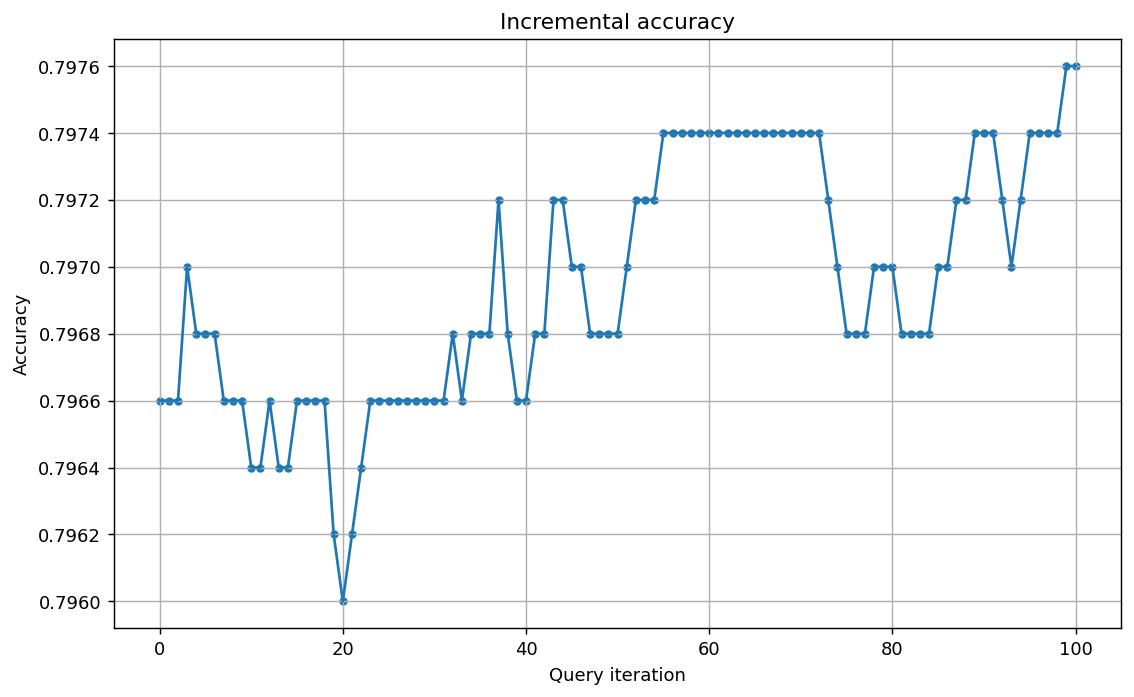

In [ ]:
# learning process
plot_performance_model(history_entro_gm)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_entro = accuracy_score(y_train_new,y_pred_train)
f1_gm_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_entro)
print("f1 score : ",f1_gm_entro)
print("precision score : ",prec_gm_entro)
print("recall score : ",rec_gm_entro)

accuracy score :  0.798
f1 score :  0.765394575662433
precision score :  0.7635401624219869
recall score :  0.7674025434540588


In [ ]:
# AUC on train set
auc_gm_entro = roc_auc_score(y_train_new,y_pred_train)
auc_gm_entro

0.7674025434540588

Accuracy of gm classifier on test set: 0.80


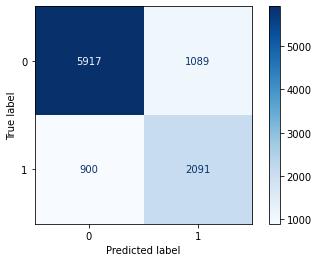

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_gm_entro = cm_gm_entro[0,0]
FP_gm_entro = cm_gm_entro[0,1]
FN_gm_entro = cm_gm_entro[1,0]
TN_gm_entro = cm_gm_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_entro_test = accuracy_score(y_test,y_pred_test)
f1_gm_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_entro_test)
print("f1 score : ",f1_gm_entro_test)
print("precision score : ",prec_gm_entro_test)
print("recall score : ",rec_gm_entro_test)

accuracy score :  0.8010403120936281
f1 score :  0.7668976666628802
precision score :  0.7627621429223833
recall score :  0.7718295480217414


In [ ]:
# AUC on test set
auc_gm_entro_test = roc_auc_score(y_test,y_pred_test)
auc_gm_entro_test

0.7718295480217414

###### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                       learning_rate_init= nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 )
learner = ActiveLearner(estimator=mlp_nn, query_strategy=entropy_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - NN: {initial_score}")

Prediction Accuracy - NN: 0.8142


In [ ]:
# learning process
num_of_queries = 100


history_entro_nn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (entropy sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_entro_nn.append(accuracy)

Accuracy after query 1: 0.8098
Accuracy after query 2: 0.8164
Accuracy after query 3: 0.8110
Accuracy after query 4: 0.8176
Accuracy after query 5: 0.8196
Accuracy after query 6: 0.8188
Accuracy after query 7: 0.8230
Accuracy after query 8: 0.8208
Accuracy after query 9: 0.8204
Accuracy after query 10: 0.8174
Accuracy after query 11: 0.8208
Accuracy after query 12: 0.8228
Accuracy after query 13: 0.8162
Accuracy after query 14: 0.8206
Accuracy after query 15: 0.8238
Accuracy after query 16: 0.8202
Accuracy after query 17: 0.8208
Accuracy after query 18: 0.8208
Accuracy after query 19: 0.8200
Accuracy after query 20: 0.8148
Accuracy after query 21: 0.8258
Accuracy after query 22: 0.8170
Accuracy after query 23: 0.8236
Accuracy after query 24: 0.8176
Accuracy after query 25: 0.8148
Accuracy after query 26: 0.8218
Accuracy after query 27: 0.8268
Accuracy after query 28: 0.8188
Accuracy after query 29: 0.8184
Accuracy after query 30: 0.8250
Accuracy after query 31: 0.8176
Accuracy after qu

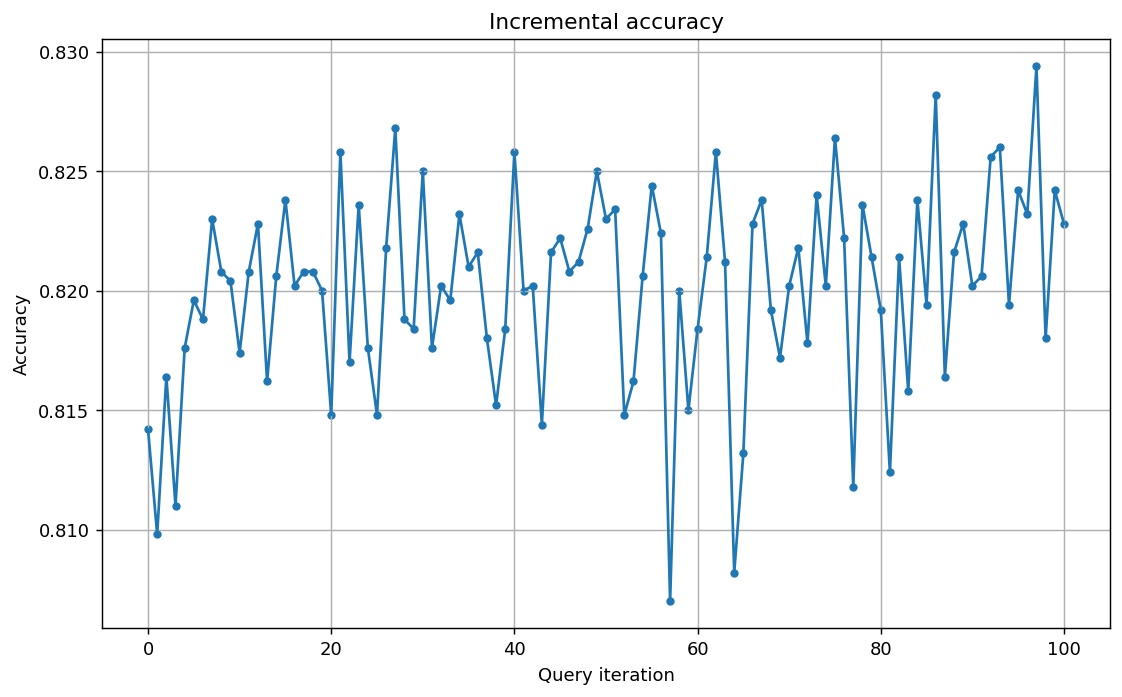

In [ ]:
# learning curve
plot_performance_model(history_entro_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_entro = accuracy_score(y_train_new,y_pred_train)
f1_nn_entro = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_entro = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_entro = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_entro)
print("f1 score : ",f1_nn_entro)
print("precision score : ",prec_nn_entro)
print("recall score : ",rec_nn_entro)

accuracy score :  0.8228
f1 score :  0.7934784311297653
precision score :  0.7923664544709978
recall score :  0.7946349829111622


In [ ]:
# AUC on train set
auc_nn_entro = roc_auc_score(y_train_new,y_pred_train)
auc_nn_entro

0.7946349829111622

Accuracy of nn classifier on test set: 0.82


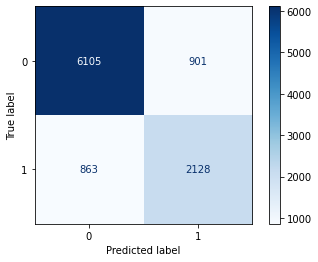

In [ ]:
# Check the performance on test set

print('Accuracy of nn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_nn_entro = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(mlp_nn, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_nn_entro = cm_nn_entro[0,0]
FP_nn_entro = cm_nn_entro[0,1]
FN_nn_entro = cm_nn_entro[1,0]
TN_nn_entro = cm_nn_entro[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_entro_test = accuracy_score(y_test,y_pred_test)
f1_nn_entro_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_entro_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_entro_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_entro_test)
print("f1 score : ",f1_nn_entro_test)
print("precision score : ",prec_nn_entro_test)
print("recall score : ",rec_nn_entro_test)

accuracy score :  0.8235470641192357
f1 score :  0.7903711544030276
precision score :  0.7893450993628752
recall score :  0.7914318414373389


In [ ]:
# AUC on test set
auc_nn_entro_test = roc_auc_score(y_test,y_pred_test)
auc_nn_entro_test

0.7914318414373389

###### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_entro, auc_lr_entro],
            'K Nearest Neighbour (KNN)': [acc_knn_entro, auc_knn_entro],
            'Support Vector Machine (SVC)': [acc_svc_entro, auc_svc_entro],
            'Decision Trees (DT)': [acc_dt_entro, auc_dt_entro],
            'Naive Bayes (NB)': [acc_gm_entro, auc_gm_entro],
            'Neural Networks (NN)': [acc_nn_entro, auc_nn_entro]
             }
dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7892     0.773876
K Nearest Neighbour (KNN)          0.8176     0.764288
Support Vector Machine (SVC)       0.7940     0.774319
Decision Trees (DT)                0.8648     0.821832
Naive Bayes (NB)                   0.7980     0.767403
Neural Networks (NN)               0.8228     0.794635

In [ ]:
# Creating performance table of test
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_entro_test, auc_lr_entro_test],
            'K Nearest Neighbour (KNN)': [acc_knn_entro_test, auc_knn_entro_test],
            'Support Vector Machine (SVC)': [acc_svc_entro_test, auc_svc_entro_test],
            'Decision Trees (DT)': [acc_dt_entro_test, auc_dt_entro_test],
            'Naive Bayes (NB)': [acc_gm_entro_test, auc_gm_entro_test],
            'Neural Networks (NN)': [acc_nn_entro_test, auc_nn_entro_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.790537    0.773054
K Nearest Neighbour (KNN)       0.812244    0.753861
Support Vector Machine (SVC)    0.797339    0.775320
Decision Trees (DT)             0.800340    0.744697
Naive Bayes (NB)                0.801040    0.771830
Neural Networks (NN)            0.823547    0.791432

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_entro, FP_lr_entro, TN_lr_entro, FN_lr_entro],
            'K Nearest Neighbour (KNN)': [TP_knn_entro, FP_knn_entro, TN_knn_entro, FN_knn_entro],
            'Support Vector Machine (SVC)': [TP_svc_entro, FP_svc_entro, TN_svc_entro, FN_svc_entro],
            'Decision Trees (DT)': [TP_dt_entro, FP_dt_entro, TN_dt_entro, FN_dt_entro],
            'Naive Bayes (NB)': [TP_gm_entro, FP_gm_entro, TN_gm_entro, FN_gm_entro],
            'Neural Networks (NN)': [TP_nn_entro, FP_nn_entro, TN_nn_entro,FN_nn_entro]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5721  1285  2182   809
K Nearest Neighbour (KNN)     6300   706  1820  1171
Support Vector Machine (SVC)  5816  1190  2155   836
Decision Trees (DT)           6188   818  1813  1178
Naive Bayes (NB)              5917  1089  2091   900
Neural Networks (NN)          6105   901  2128   863

##### **Least confident sampling**

###### **SVC**

In [ ]:
svc = SVC(C=svc_train.best_estimator_.C,kernel='linear', random_state=seed, class_weight='balanced', probability=True)
learner = ActiveLearner(estimator=svc, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# learning process
num_of_queries = 100


history_least_svc = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (uncertainty sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_least_svc.append(accuracy)


Accuracy after query 1: 0.7888
Accuracy after query 2: 0.7888
Accuracy after query 3: 0.7888
Accuracy after query 4: 0.7886
Accuracy after query 5: 0.7888
Accuracy after query 6: 0.7890
Accuracy after query 7: 0.7892
Accuracy after query 8: 0.7892
Accuracy after query 9: 0.7892
Accuracy after query 10: 0.7892
Accuracy after query 11: 0.7892
Accuracy after query 12: 0.7900
Accuracy after query 13: 0.7896
Accuracy after query 14: 0.7898
Accuracy after query 15: 0.7898
Accuracy after query 16: 0.7898
Accuracy after query 17: 0.7898
Accuracy after query 18: 0.7896
Accuracy after query 19: 0.7898
Accuracy after query 20: 0.7898
Accuracy after query 21: 0.7896
Accuracy after query 22: 0.7898
Accuracy after query 23: 0.7898
Accuracy after query 24: 0.7898
Accuracy after query 25: 0.7898
Accuracy after query 26: 0.7898
Accuracy after query 27: 0.7900
Accuracy after query 28: 0.7898
Accuracy after query 29: 0.7900
Accuracy after query 30: 0.7898
Accuracy after query 31: 0.7898
Accuracy after qu

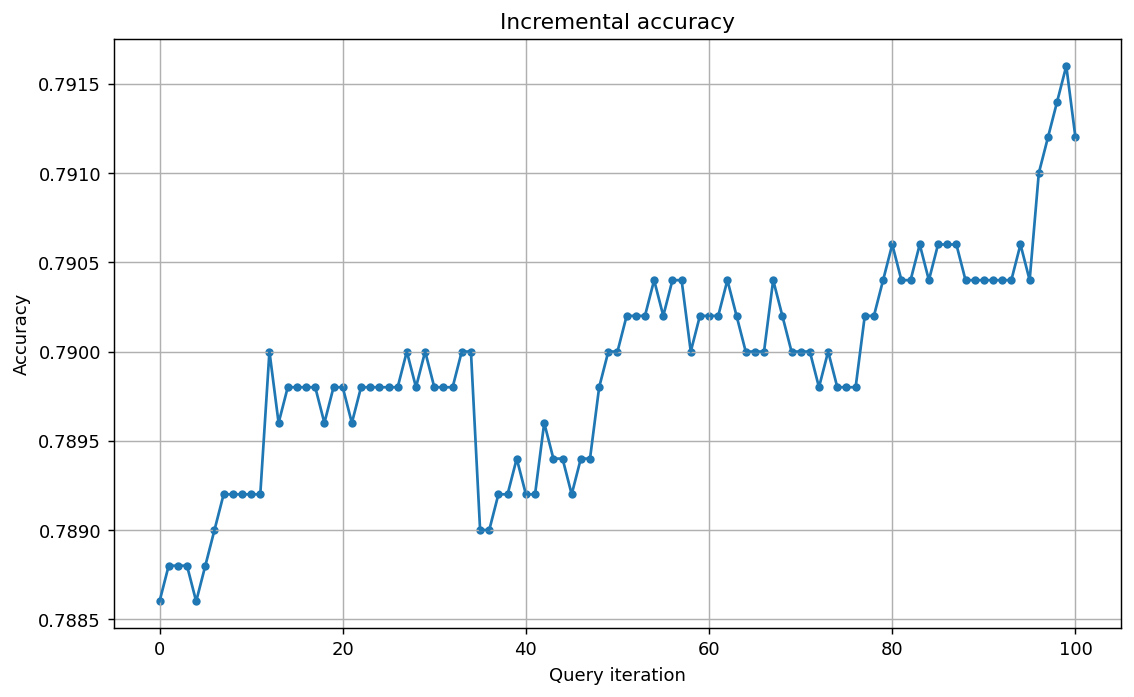

In [ ]:
# display active learning curve
plot_performance_model(history_least_svc)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_least = accuracy_score(y_train_new,y_pred_train)
f1_svc_least = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_least = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_least = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_least)
print("f1 score : ",f1_svc_least)
print("precision score : ",prec_svc_least)
print("recall score : ",rec_svc_least)

accuracy score :  0.7912
f1 score :  0.764911628389596
precision score :  0.757567264573991
recall score :  0.7769367084052965


In [ ]:
# AUC on train set
auc_svc_least = roc_auc_score(y_train_new,y_pred_train)
auc_svc_least

0.7769367084052965

Accuracy of SVC classifier on test set: 0.80


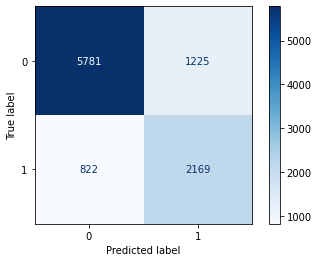

In [ ]:
# Check the performance on test set

print('Accuracy of SVC classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_least = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)


In [ ]:
# Confusion matrix
TP_svc_least = cm_svc_least[0,0]
FP_svc_least = cm_svc_least[0,1]
FN_svc_least = cm_svc_least[1,0]
TN_svc_least = cm_svc_least[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_least_test = accuracy_score(y_test,y_pred_test)
f1_svc_least_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_least_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_least_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_least_test)
print("f1 score : ",f1_svc_least_test)
print("precision score : ",prec_svc_least_test)
print("recall score : ",rec_svc_least_test)

accuracy score :  0.7952385715714715
f1 score :  0.7644948443476158
precision score :  0.75729003825068
recall score :  0.7751626990592102


In [ ]:
# AUC on test set
auc_svc_least_test = roc_auc_score(y_test,y_pred_test)
auc_svc_least_test

0.7751626990592102

###### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# learning process

num_of_queries = 100


history_least_lr = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (uncertainty sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_least_lr.append(accuracy)

Accuracy after query 1: 0.7872
Accuracy after query 2: 0.7872
Accuracy after query 3: 0.7872
Accuracy after query 4: 0.7870
Accuracy after query 5: 0.7872
Accuracy after query 6: 0.7872
Accuracy after query 7: 0.7872
Accuracy after query 8: 0.7872
Accuracy after query 9: 0.7874
Accuracy after query 10: 0.7874
Accuracy after query 11: 0.7876
Accuracy after query 12: 0.7874
Accuracy after query 13: 0.7876
Accuracy after query 14: 0.7870
Accuracy after query 15: 0.7874
Accuracy after query 16: 0.7874
Accuracy after query 17: 0.7874
Accuracy after query 18: 0.7874
Accuracy after query 19: 0.7872
Accuracy after query 20: 0.7874
Accuracy after query 21: 0.7872
Accuracy after query 22: 0.7876
Accuracy after query 23: 0.7876
Accuracy after query 24: 0.7874
Accuracy after query 25: 0.7878
Accuracy after query 26: 0.7876
Accuracy after query 27: 0.7876
Accuracy after query 28: 0.7874
Accuracy after query 29: 0.7876
Accuracy after query 30: 0.7882
Accuracy after query 31: 0.7880
Accuracy after qu

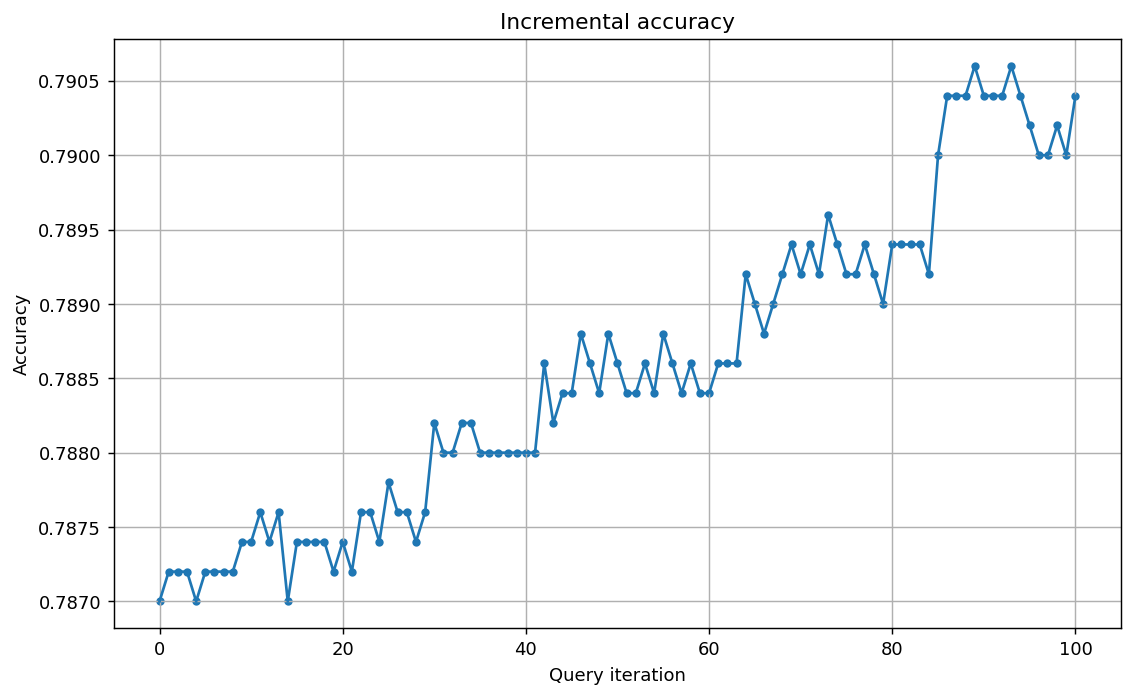

In [ ]:
# plot performance
plot_performance_model(history_least_lr)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_least = accuracy_score(y_train_new,y_pred_train)
f1_lr_least = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_least = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_least = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_least)
print("f1 score : ",f1_lr_least)
print("precision score : ",prec_lr_least)
print("recall score : ",rec_lr_least)

accuracy score :  0.7904
f1 score :  0.7638684902508329
precision score :  0.756752386957069
recall score :  0.7752804256100623


In [ ]:
# AUC on train set
auc_lr_least = roc_auc_score(y_train_new,y_pred_train)
auc_lr_least

0.7752804256100623

Accuracy of lr classifier on test set: 0.79


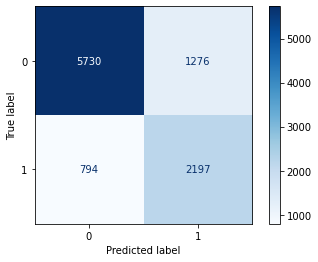

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_least = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test,values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_lr_least = cm_lr_least[0,0]
FP_lr_least = cm_lr_least[0,1]
FN_lr_least = cm_lr_least[1,0]
TN_lr_least = cm_lr_least[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_least_test = accuracy_score(y_test,y_pred_test)
f1_lr_least_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_least_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_least_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_least_test)
print("f1 score : ",f1_lr_least_test)
print("precision score : ",prec_lr_least_test)
print("recall score : ",rec_lr_least_test)

accuracy score :  0.7929378813644093
f1 score :  0.7633857516849245
precision score :  0.7554449115476612
recall score :  0.7762036704842856


In [ ]:
# AUC on test set
auc_lr_least_test = roc_auc_score(y_test,y_pred_test)
auc_lr_least_test

0.7762036704842856

###### **KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - KNN: {initial_score}")

Prediction Accuracy - KNN: 0.8218


In [ ]:
# learning process

num_of_queries = 100


history_least_knn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (uncertainty sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_least_knn.append(accuracy)

Accuracy after query 1: 0.8216
Accuracy after query 2: 0.8214
Accuracy after query 3: 0.8214
Accuracy after query 4: 0.8214
Accuracy after query 5: 0.8214
Accuracy after query 6: 0.8216
Accuracy after query 7: 0.8216
Accuracy after query 8: 0.8216
Accuracy after query 9: 0.8216
Accuracy after query 10: 0.8214
Accuracy after query 11: 0.8216
Accuracy after query 12: 0.8216
Accuracy after query 13: 0.8216
Accuracy after query 14: 0.8214
Accuracy after query 15: 0.8212
Accuracy after query 16: 0.8212
Accuracy after query 17: 0.8210
Accuracy after query 18: 0.8208
Accuracy after query 19: 0.8208
Accuracy after query 20: 0.8206
Accuracy after query 21: 0.8208
Accuracy after query 22: 0.8208
Accuracy after query 23: 0.8210
Accuracy after query 24: 0.8210
Accuracy after query 25: 0.8212
Accuracy after query 26: 0.8210
Accuracy after query 27: 0.8212
Accuracy after query 28: 0.8212
Accuracy after query 29: 0.8210
Accuracy after query 30: 0.8206
Accuracy after query 31: 0.8196
Accuracy after qu

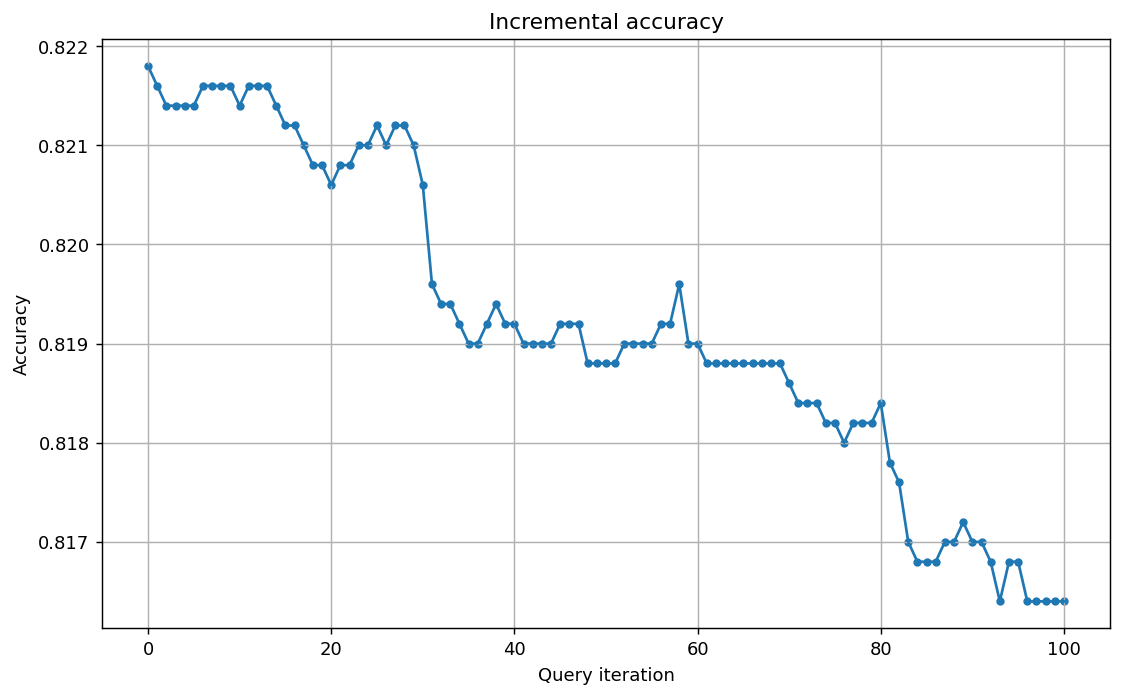

In [ ]:
# learning curve
plot_performance_model(history_least_knn)


In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_knn_least = accuracy_score(y_train_new,y_pred_train)
f1_knn_least = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_least = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_least = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_least)
print("f1 score : ",f1_knn_least)
print("precision score : ",prec_knn_least)
print("recall score : ",rec_knn_least)


accuracy score :  0.8164
f1 score :  0.7750359942409215
precision score :  0.7918313060550937
recall score :  0.7639542617822375


In [ ]:
# AUC on train set
auc_knn_least = roc_auc_score(y_train_new,y_pred_train)
auc_knn_least

0.7639542617822375

Accuracy of knn classifier on test set: 0.81


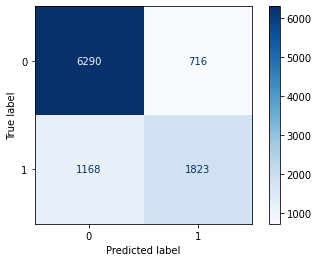

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_least = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test,values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_knn_least = cm_knn_least[0,0]
FP_knn_least = cm_knn_least[0,1]
FN_knn_least = cm_knn_least[1,0]
TN_knn_least = cm_knn_least[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_least_test = accuracy_score(y_test,y_pred_test)
f1_knn_least_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_least_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_least_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_least_test)
print("f1 score : ",f1_knn_least_test)
print("precision score : ",prec_knn_least_test)
print("recall score : ",rec_knn_least_test)

accuracy score :  0.8115434630389117
f1 score :  0.7645292071404567
precision score :  0.7806944304938428
recall score :  0.7536485181111896


In [ ]:
# AUC on test set
auc_knn_least_test = roc_auc_score(y_test,y_pred_test)
auc_knn_least_test

0.7536485181111896

###### **NB**

In [ ]:
# training the model
gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# learning process

num_of_queries = 100


history_least_gm = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (uncertainty sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_least_gm.append(accuracy)

Accuracy after query 1: 0.7968
Accuracy after query 2: 0.7968
Accuracy after query 3: 0.7966
Accuracy after query 4: 0.7968
Accuracy after query 5: 0.7968
Accuracy after query 6: 0.7970
Accuracy after query 7: 0.7968
Accuracy after query 8: 0.7968
Accuracy after query 9: 0.7966
Accuracy after query 10: 0.7964
Accuracy after query 11: 0.7964
Accuracy after query 12: 0.7964
Accuracy after query 13: 0.7966
Accuracy after query 14: 0.7968
Accuracy after query 15: 0.7968
Accuracy after query 16: 0.7970
Accuracy after query 17: 0.7970
Accuracy after query 18: 0.7966
Accuracy after query 19: 0.7966
Accuracy after query 20: 0.7966
Accuracy after query 21: 0.7966
Accuracy after query 22: 0.7966
Accuracy after query 23: 0.7968
Accuracy after query 24: 0.7968
Accuracy after query 25: 0.7968
Accuracy after query 26: 0.7968
Accuracy after query 27: 0.7966
Accuracy after query 28: 0.7966
Accuracy after query 29: 0.7966
Accuracy after query 30: 0.7966
Accuracy after query 31: 0.7966
Accuracy after qu

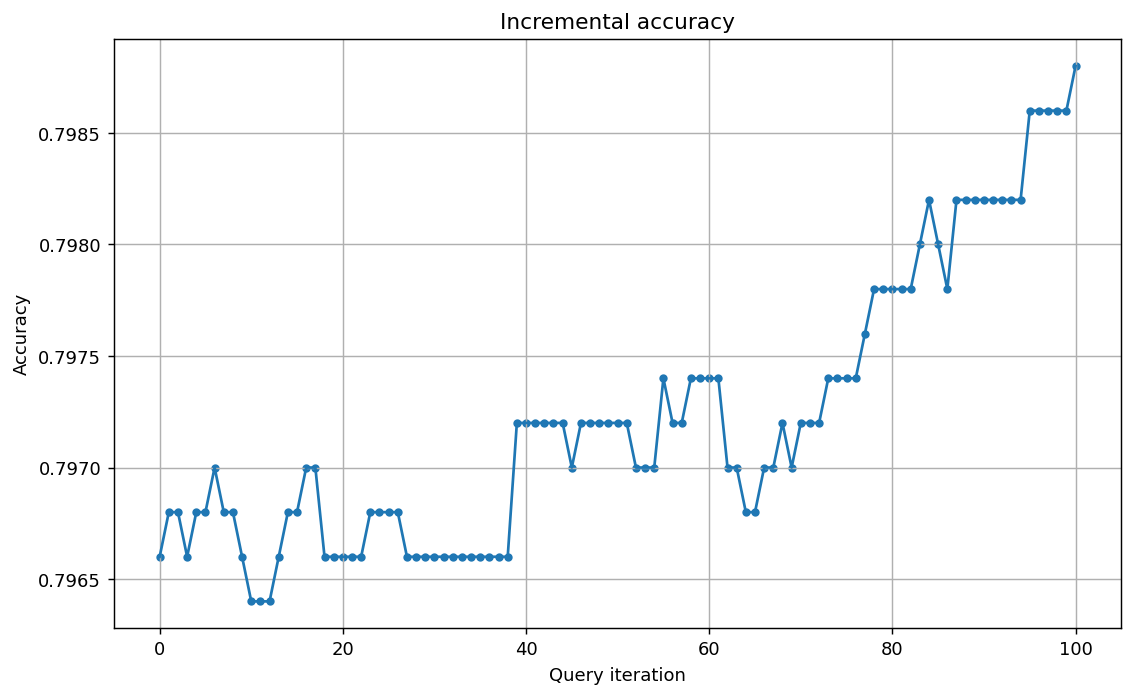

In [ ]:
# learner curve
plot_performance_model(history_least_gm)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_gm_least = accuracy_score(y_train_new,y_pred_train)
f1_gm_least = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_least = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_least = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_least)
print("f1 score : ",f1_gm_least)
print("precision score : ",prec_gm_least)
print("recall score : ",rec_gm_least)


accuracy score :  0.7988
f1 score :  0.766323706055849
precision score :  0.7644626582011074
recall score :  0.7683385591087334


In [ ]:
# AUC on train set
auc_gm_least = roc_auc_score(y_train_new,y_pred_train)
auc_gm_least

0.7683385591087334

Accuracy of gm classifier on test set: 0.80


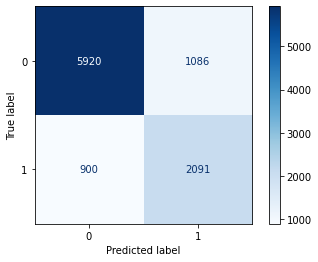

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_least = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_gm_least = cm_gm_least[0,0]
FP_gm_least = cm_gm_least[0,1]
FN_gm_least = cm_gm_least[1,0]
TN_gm_least = cm_gm_least[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_least_test = accuracy_score(y_test,y_pred_test)
f1_gm_least_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_least_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_least_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_least_test)
print("f1 score : ",f1_gm_least_test)
print("precision score : ",prec_gm_least_test)
print("recall score : ",rec_gm_least_test) 

accuracy score :  0.8013404021206362
f1 score :  0.7671865756784855
precision score :  0.7631016368565486
recall score :  0.7720436502198573


In [ ]:
# AUC on test se
auc_gm_least_test = roc_auc_score(y_test,y_pred_test) 
auc_gm_least_test

0.7720436502198573

###### **DT**

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - tree: {initial_score}")

Prediction Accuracy - tree: 0.8594


In [ ]:
#Querying unseen instances

num_of_queries = 100


history_least_dt = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (uncertainty sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_least_dt.append(accuracy)

Accuracy after query 1: 0.8592
Accuracy after query 2: 0.8592
Accuracy after query 3: 0.8594
Accuracy after query 4: 0.8594
Accuracy after query 5: 0.8594
Accuracy after query 6: 0.8594
Accuracy after query 7: 0.8594
Accuracy after query 8: 0.8594
Accuracy after query 9: 0.8588
Accuracy after query 10: 0.8588
Accuracy after query 11: 0.8588
Accuracy after query 12: 0.8588
Accuracy after query 13: 0.8588
Accuracy after query 14: 0.8602
Accuracy after query 15: 0.8602
Accuracy after query 16: 0.8602
Accuracy after query 17: 0.8602
Accuracy after query 18: 0.8602
Accuracy after query 19: 0.8608
Accuracy after query 20: 0.8610
Accuracy after query 21: 0.8622
Accuracy after query 22: 0.8622
Accuracy after query 23: 0.8622
Accuracy after query 24: 0.8624
Accuracy after query 25: 0.8636
Accuracy after query 26: 0.8636
Accuracy after query 27: 0.8636
Accuracy after query 28: 0.8636
Accuracy after query 29: 0.8634
Accuracy after query 30: 0.8632
Accuracy after query 31: 0.8632
Accuracy after qu

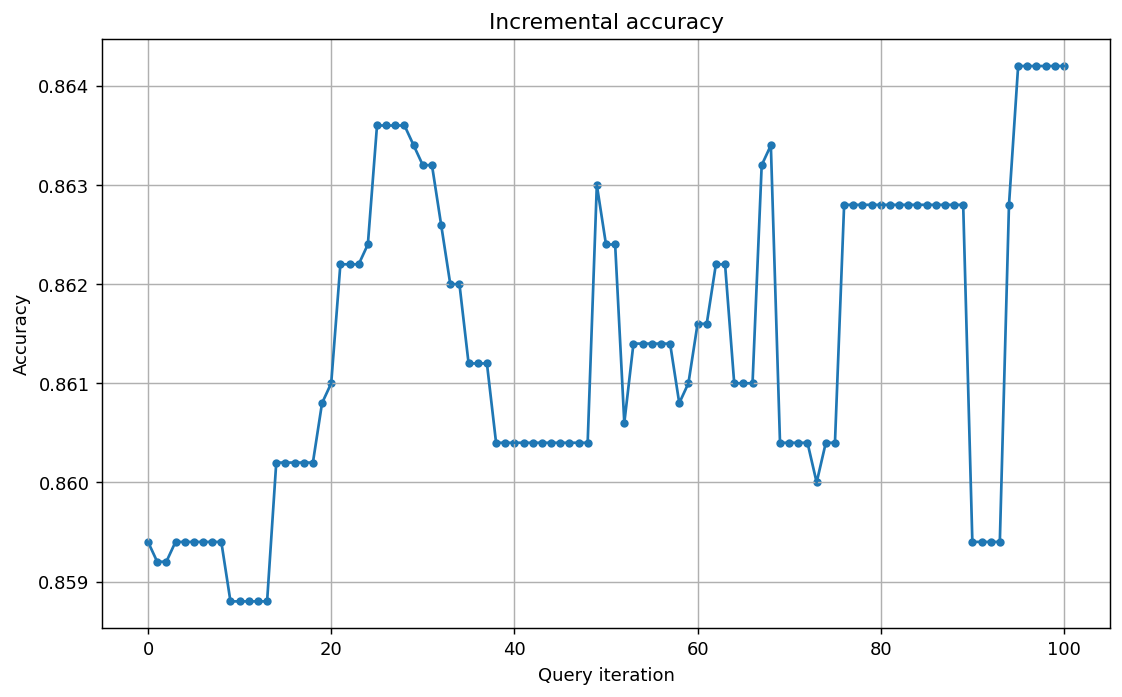

In [ ]:
# learner curve
plot_performance_model(history_least_dt)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_least = accuracy_score(y_train_new,y_pred_train)
f1_dt_least = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_least = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_least = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_least)
print("f1 score : ",f1_dt_least)
print("precision score : ",prec_dt_least)
print("recall score : ",rec_dt_least)

accuracy score :  0.8656
f1 score :  0.8406041860376858
precision score :  0.8492072237740941
recall score :  0.8335482040980821


In [ ]:
# AUC on train set
auc_dt_least = roc_auc_score(y_train_new,y_pred_train)
auc_dt_least

0.8335482040980821

Accuracy of dt classifier on test set: 0.81


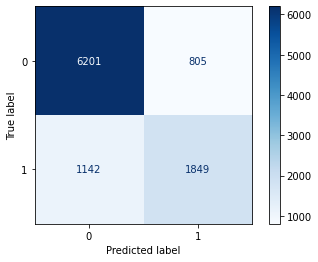

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_least = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_dt_least = cm_dt_least[0,0]
FP_dt_least = cm_dt_least[0,1]
FN_dt_least = cm_dt_least[1,0]
TN_dt_least = cm_dt_least[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_least_test = accuracy_score(y_test,y_pred_test)
f1_dt_least_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_least_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_least_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_least_test)
print("f1 score : ",f1_dt_least_test)
print("precision score : ",prec_dt_least_test)
print("recall score : ",rec_dt_least_test)

accuracy score :  0.8052415724717416
f1 score :  0.7597020522380804
precision score :  0.7705809920423112
recall score :  0.75164319201777


In [ ]:
# AUC on test set
auc_dt_least_test = roc_auc_score(y_test,y_pred_test)
auc_dt_least_test

0.75164319201777

###### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                       learning_rate_init= nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 )
learner = ActiveLearner(estimator=mlp_nn, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - NN: {initial_score}")

Prediction Accuracy - NN: 0.8142


In [ ]:
#Querying unseen instances

num_of_queries = 100

history_least_nn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (uncertainty sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_least_nn.append(accuracy)

Accuracy after query 1: 0.8102
Accuracy after query 2: 0.8146
Accuracy after query 3: 0.8096
Accuracy after query 4: 0.8116
Accuracy after query 5: 0.8196
Accuracy after query 6: 0.8174
Accuracy after query 7: 0.8196
Accuracy after query 8: 0.8252
Accuracy after query 9: 0.8244
Accuracy after query 10: 0.8172
Accuracy after query 11: 0.8216
Accuracy after query 12: 0.8218
Accuracy after query 13: 0.8214
Accuracy after query 14: 0.8224
Accuracy after query 15: 0.8164
Accuracy after query 16: 0.8196
Accuracy after query 17: 0.8236
Accuracy after query 18: 0.8210
Accuracy after query 19: 0.8136
Accuracy after query 20: 0.8170
Accuracy after query 21: 0.8174
Accuracy after query 22: 0.8248
Accuracy after query 23: 0.8238
Accuracy after query 24: 0.8210
Accuracy after query 25: 0.8158
Accuracy after query 26: 0.8240
Accuracy after query 27: 0.8188
Accuracy after query 28: 0.8184
Accuracy after query 29: 0.8214
Accuracy after query 30: 0.8274
Accuracy after query 31: 0.8222
Accuracy after qu

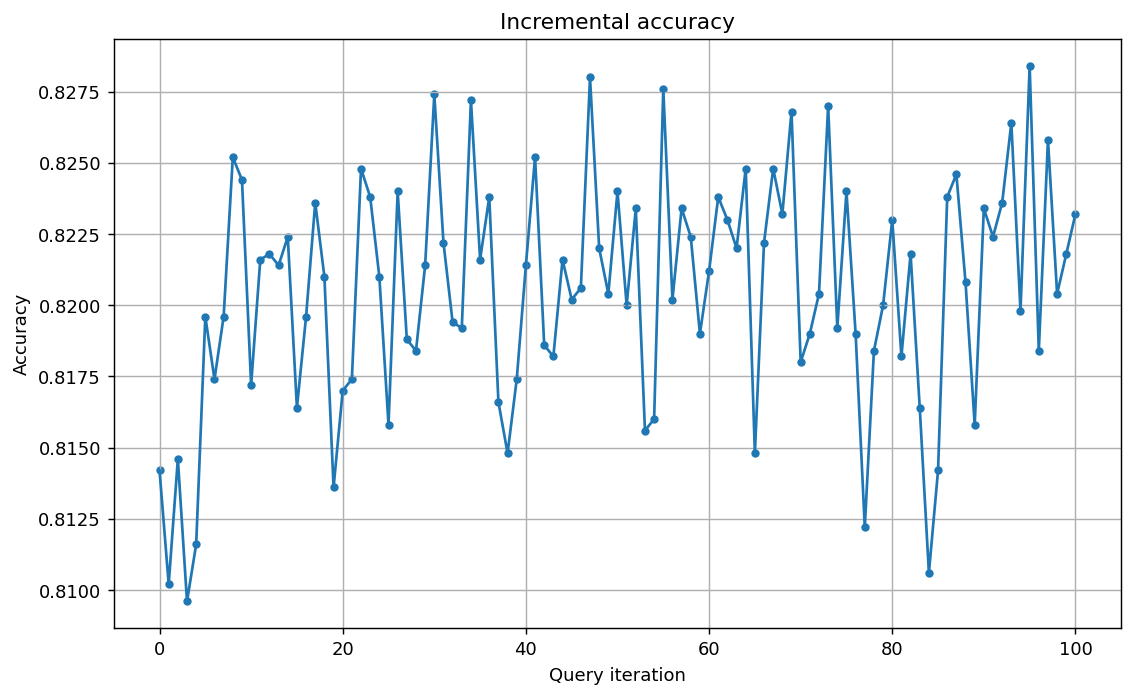

In [ ]:
# learning curve
plot_performance_model(history_least_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_least = accuracy_score(y_train_new,y_pred_train)
f1_nn_least = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_least = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_least = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_least)
print("f1 score : ",f1_nn_least)
print("precision score : ",prec_nn_least)
print("recall score : ",rec_nn_least)

accuracy score :  0.8232
f1 score :  0.7835497835497836
precision score :  0.8004307346926719
recall score :  0.7722672040145337


In [ ]:
# Compute AUC on train set
auc_nn_least = roc_auc_score(y_train_new,y_pred_train)
auc_nn_least

0.7722672040145337

Accuracy of nn classifier on test set: 0.82


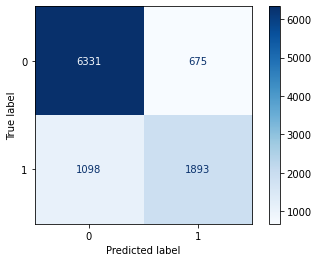

In [ ]:
# Check the performance on test set

print('Accuracy of nn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_nn_least = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(mlp_nn, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_nn_least = cm_nn_least[0,0]
FP_nn_least = cm_nn_least[0,1]
FN_nn_least = cm_nn_least[1,0]
TN_nn_least = cm_nn_least[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_least_test = accuracy_score(y_test,y_pred_test)
f1_nn_least_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_least_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_least_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_least_test)
print("f1 score : ",f1_nn_least_test)
print("precision score : ",prec_nn_least_test)
print("recall score : ",rec_nn_least_test)

accuracy score :  0.8226467940382115
f1 score :  0.7791156403708606
precision score :  0.7946751836387584
recall score :  0.7682763534680548


In [ ]:
# AUC on test set
auc_nn_least_test = roc_auc_score(y_test,y_pred_test)
auc_nn_least_test

0.7682763534680548

###### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_least, auc_lr_least],
            'K Nearest Neighbour (KNN)': [acc_knn_least, auc_knn_least],
            'Support Vector Machine (SVC)': [acc_svc_least, auc_svc_least],
            'Decision Trees (DT)': [acc_dt_least, auc_dt_least],
            'Naive Bayes (NB)': [acc_gm_least, auc_gm_least],
            'Neural Networks (NN)': [acc_nn_least, auc_nn_least]
             }
dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7904     0.775280
K Nearest Neighbour (KNN)          0.8164     0.763954
Support Vector Machine (SVC)       0.7912     0.776937
Decision Trees (DT)                0.8656     0.833548
Naive Bayes (NB)                   0.7988     0.768339
Neural Networks (NN)               0.8232     0.772267

In [ ]:
# Creating performance table of test
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_least_test, auc_lr_least_test],
            'K Nearest Neighbour (KNN)': [acc_knn_least_test, auc_knn_least_test],
            'Support Vector Machine (SVC)': [acc_svc_least_test, auc_svc_least_test],
            'Decision Trees (DT)': [acc_dt_least_test, auc_dt_least_test],
            'Naive Bayes (NB)': [acc_gm_least_test, auc_gm_least_test],
            'Neural Networks (NN)': [acc_nn_least_test, auc_nn_least_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.792938    0.776204
K Nearest Neighbour (KNN)       0.811543    0.753649
Support Vector Machine (SVC)    0.795239    0.775163
Decision Trees (DT)             0.805242    0.751643
Naive Bayes (NB)                0.801340    0.772044
Neural Networks (NN)            0.822647    0.768276

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_least, FP_lr_least, TN_lr_least, FN_lr_least],
            'K Nearest Neighbour (KNN)': [TP_knn_least, FP_knn_least, TN_knn_least, FN_knn_least],
            'Support Vector Machine (SVC)': [TP_svc_least, FP_svc_least, TN_svc_least, FN_svc_least],
            'Decision Trees (DT)': [TP_dt_least, FP_dt_least, TN_dt_least, FN_dt_least],
            'Naive Bayes (NB)': [TP_gm_least, FP_gm_least, TN_gm_least, FN_gm_least],
            'Neural Networks (NN)': [TP_nn_least, FP_nn_least, TN_nn_least,FN_nn_least]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5730  1276  2197   794
K Nearest Neighbour (KNN)     6290   716  1823  1168
Support Vector Machine (SVC)  5781  1225  2169   822
Decision Trees (DT)           6201   805  1849  1142
Naive Bayes (NB)              5920  1086  2091   900
Neural Networks (NN)          6331   675  1893  1098

##### **Margin sampling**

###### **SVC**

In [ ]:
svc = SVC(C=svc_train.best_estimator_.C,kernel='linear', random_state=seed, class_weight='balanced', probability=True)
learner = ActiveLearner(estimator=svc, query_strategy=margin_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# Learning process

num_of_queries = 100


history_marg_svc = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (margin sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_marg_svc.append(accuracy)

Accuracy after query 1: 0.7886
Accuracy after query 2: 0.7880
Accuracy after query 3: 0.7882
Accuracy after query 4: 0.7882
Accuracy after query 5: 0.7886
Accuracy after query 6: 0.7886
Accuracy after query 7: 0.7890
Accuracy after query 8: 0.7886
Accuracy after query 9: 0.7886
Accuracy after query 10: 0.7886
Accuracy after query 11: 0.7884
Accuracy after query 12: 0.7884
Accuracy after query 13: 0.7886
Accuracy after query 14: 0.7884
Accuracy after query 15: 0.7888
Accuracy after query 16: 0.7888
Accuracy after query 17: 0.7886
Accuracy after query 18: 0.7888
Accuracy after query 19: 0.7888
Accuracy after query 20: 0.7888
Accuracy after query 21: 0.7888
Accuracy after query 22: 0.7890
Accuracy after query 23: 0.7886
Accuracy after query 24: 0.7884
Accuracy after query 25: 0.7888
Accuracy after query 26: 0.7888
Accuracy after query 27: 0.7894
Accuracy after query 28: 0.7894
Accuracy after query 29: 0.7894
Accuracy after query 30: 0.7894
Accuracy after query 31: 0.7892
Accuracy after qu

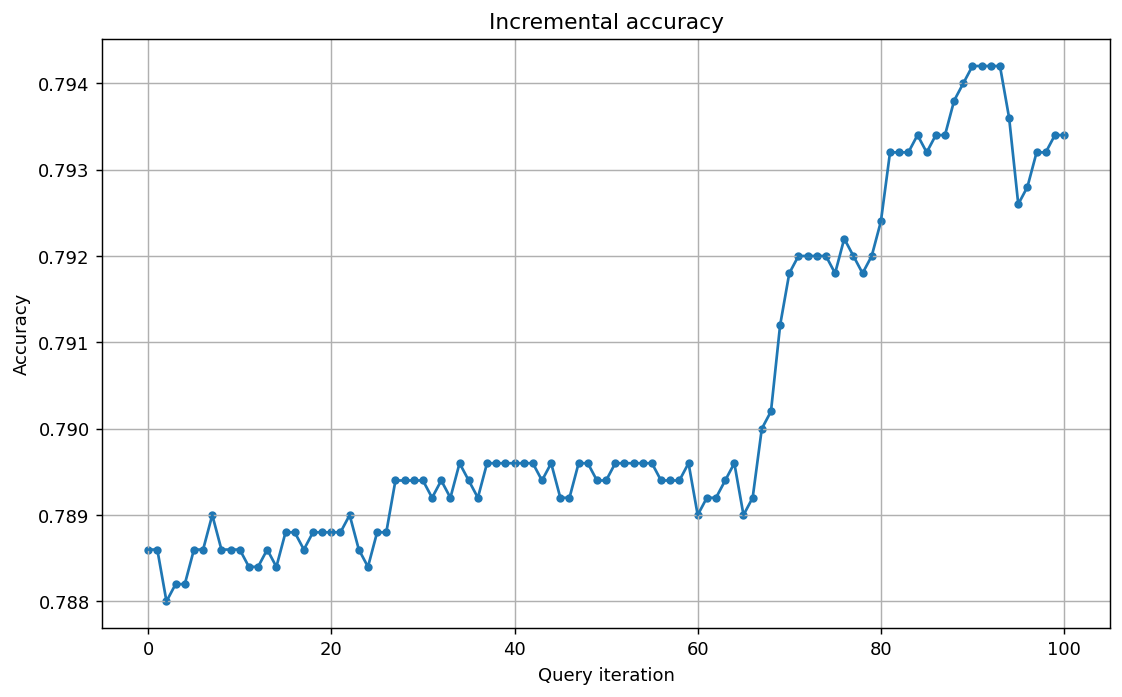

In [ ]:
## learning curve
plot_performance_model(history_marg_svc)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_marg = accuracy_score(y_train_new,y_pred_train)
f1_svc_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_marg)
print("f1 score : ",f1_svc_marg)
print("precision score : ",prec_svc_marg)
print("recall score : ",rec_svc_marg)

accuracy score :  0.7934
f1 score :  0.765339898909428
precision score :  0.7592123975534648
recall score :  0.774062762844896


In [ ]:
# AUC on train set
auc_svc_marg = roc_auc_score(y_train_new,y_pred_train)
auc_svc_marg

0.774062762844896

Accuracy of svc classifier on test set: 0.80


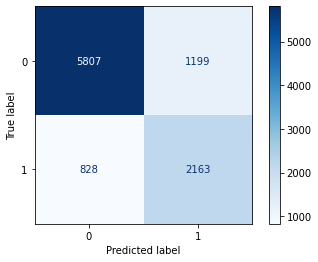

In [ ]:
# Check the performance on test set

print('Accuracy of svc classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_svc_marg = cm_svc_marg[0,0]
FP_svc_marg = cm_svc_marg[0,1]
FN_svc_marg = cm_svc_marg[1,0]
TN_svc_marg = cm_svc_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_marg_test = accuracy_score(y_test,y_pred_test)
f1_svc_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_marg_test)
print("f1 score : ",f1_svc_marg_test)
print("precision score : ",prec_svc_marg_test)
print("recall score : ",rec_svc_marg_test)

accuracy score :  0.7972391717515255
f1 score :  0.7661709977419788
precision score :  0.7592871388948785
recall score :  0.7760152424158


In [ ]:
# AUC on test set
auc_svc_marg_test = roc_auc_score(y_test,y_pred_test)
auc_svc_marg_test

0.7760152424158

###### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=margin_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# active learning process

num_of_queries = 100


history_marg_lr = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (margin sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_marg_lr.append(accuracy)

Accuracy after query 1: 0.7872
Accuracy after query 2: 0.7872
Accuracy after query 3: 0.7874
Accuracy after query 4: 0.7874
Accuracy after query 5: 0.7876
Accuracy after query 6: 0.7876
Accuracy after query 7: 0.7876
Accuracy after query 8: 0.7874
Accuracy after query 9: 0.7874
Accuracy after query 10: 0.7874
Accuracy after query 11: 0.7876
Accuracy after query 12: 0.7874
Accuracy after query 13: 0.7872
Accuracy after query 14: 0.7874
Accuracy after query 15: 0.7874
Accuracy after query 16: 0.7872
Accuracy after query 17: 0.7874
Accuracy after query 18: 0.7874
Accuracy after query 19: 0.7874
Accuracy after query 20: 0.7874
Accuracy after query 21: 0.7876
Accuracy after query 22: 0.7874
Accuracy after query 23: 0.7874
Accuracy after query 24: 0.7874
Accuracy after query 25: 0.7872
Accuracy after query 26: 0.7876
Accuracy after query 27: 0.7876
Accuracy after query 28: 0.7874
Accuracy after query 29: 0.7874
Accuracy after query 30: 0.7874
Accuracy after query 31: 0.7874
Accuracy after qu

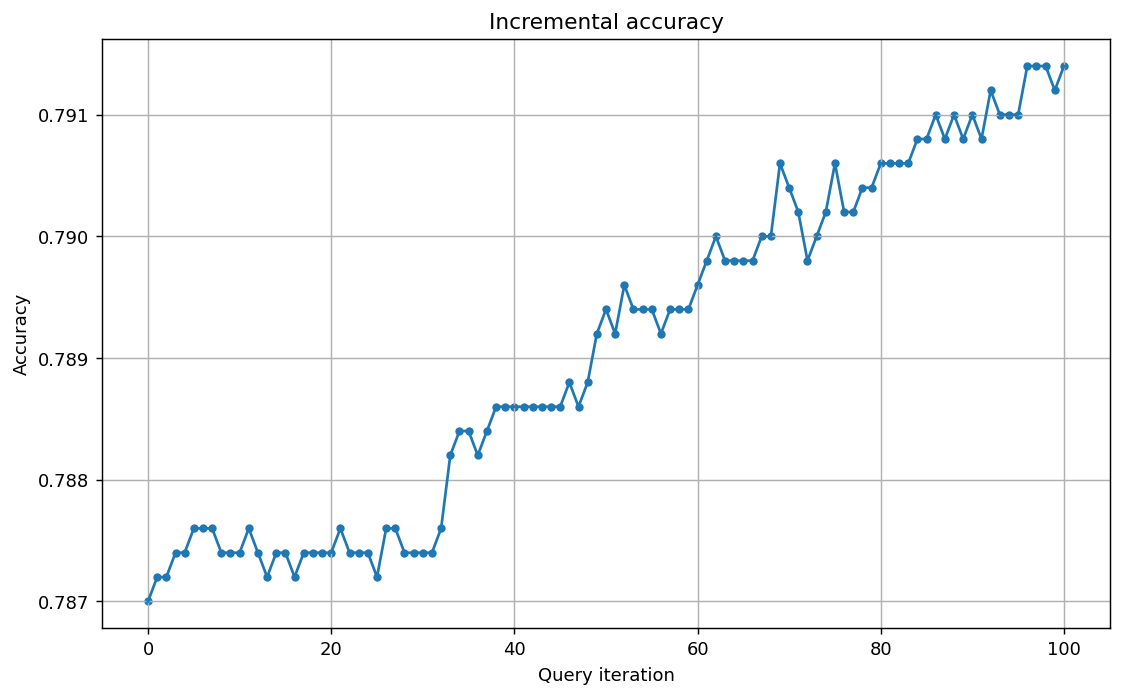

In [ ]:
# learning curve
plot_performance_model(history_marg_lr)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_marg = accuracy_score(y_train_new,y_pred_train)
f1_lr_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_marg)
print("f1 score : ",f1_lr_marg)
print("precision score : ",prec_lr_marg)
print("recall score : ",rec_lr_marg)

accuracy score :  0.7914
f1 score :  0.7646742950099894
precision score :  0.7576840475337127
recall score :  0.775647624551391


In [ ]:
# AUC on train set
auc_lr_marg = roc_auc_score(y_train_new,y_pred_train)
auc_lr_marg

0.775647624551391

Accuracy of lr classifier on test set: 0.79


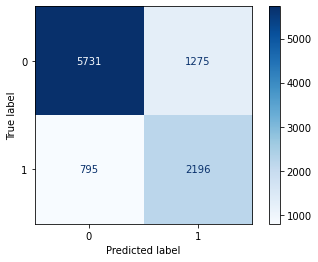

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_lr_marg = cm_lr_marg[0,0]
FP_lr_marg = cm_lr_marg[0,1]
FN_lr_marg= cm_lr_marg[1,0]
TN_lr_marg = cm_lr_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_marg_test = accuracy_score(y_test,y_pred_test)
f1_lr_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_marg_test)
print("f1 score : ",f1_lr_marg_test)
print("precision score : ",prec_lr_marg_test)
print("recall score : ",rec_lr_marg_test)

accuracy score :  0.7929378813644093
f1 score :  0.7633475010642267
precision score :  0.7554251447106992
recall score :  0.7761078697124775


In [ ]:
# AUC on test set
auc_lr_marg_test = roc_auc_score(y_test,y_pred_test)
auc_lr_marg_test

0.7761078697124775

######**KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=margin_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - KNN: {initial_score}")

Prediction Accuracy - KNN: 0.8218


In [ ]:
#Querying instances

num_of_queries = 100


history_marg_knn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (margin sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_marg_knn.append(accuracy)

Accuracy after query 1: 0.8216
Accuracy after query 2: 0.8214
Accuracy after query 3: 0.8214
Accuracy after query 4: 0.8214
Accuracy after query 5: 0.8210
Accuracy after query 6: 0.8210
Accuracy after query 7: 0.8210
Accuracy after query 8: 0.8210
Accuracy after query 9: 0.8210
Accuracy after query 10: 0.8210
Accuracy after query 11: 0.8212
Accuracy after query 12: 0.8214
Accuracy after query 13: 0.8208
Accuracy after query 14: 0.8208
Accuracy after query 15: 0.8210
Accuracy after query 16: 0.8210
Accuracy after query 17: 0.8210
Accuracy after query 18: 0.8210
Accuracy after query 19: 0.8206
Accuracy after query 20: 0.8210
Accuracy after query 21: 0.8210
Accuracy after query 22: 0.8212
Accuracy after query 23: 0.8214
Accuracy after query 24: 0.8216
Accuracy after query 25: 0.8216
Accuracy after query 26: 0.8212
Accuracy after query 27: 0.8212
Accuracy after query 28: 0.8212
Accuracy after query 29: 0.8206
Accuracy after query 30: 0.8206
Accuracy after query 31: 0.8206
Accuracy after qu

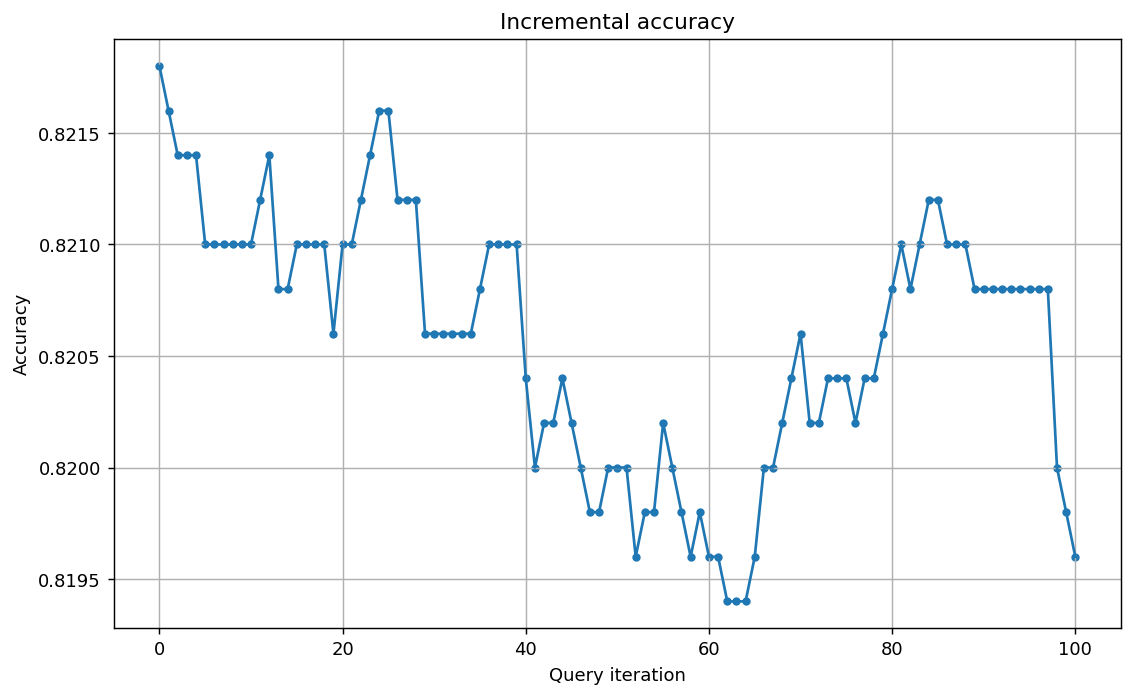

In [ ]:
# learning curve
plot_performance_model(history_marg_knn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_marg = accuracy_score(y_train_new,y_pred_train)
f1_knn_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_marg)
print("f1 score : ",f1_knn_marg)
print("precision score : ",prec_knn_marg)
print("recall score : ",rec_knn_marg)

accuracy score :  0.8196
f1 score :  0.779786489573989
precision score :  0.7951466033219459
recall score :  0.7693039656549647


In [ ]:
# AUC on train set
auc_knn_marg = roc_auc_score(y_train_new,y_pred_train)
auc_knn_marg

0.7693039656549647

Accuracy of knn classifier on test set: 0.81


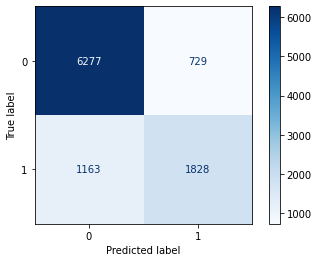

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_knn_marg = cm_knn_marg[0,0]
FP_knn_marg = cm_knn_marg[0,1]
FN_knn_marg= cm_knn_marg[1,0]
TN_knn_marg = cm_knn_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_marg_test = accuracy_score(y_test,y_pred_test)
f1_knn_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_marg_test)
print("f1 score : ",f1_knn_marg_test)
print("precision score : ",prec_knn_marg_test)
print("recall score : ",rec_knn_marg_test)

accuracy score :  0.81074322296689
f1 score :  0.7640028483871666
precision score :  0.7792915347286176
recall score :  0.7535565827752551


In [ ]:
# AUC on test set
auc_knn_marg_test = roc_auc_score(y_test,y_pred_test)
auc_knn_marg_test 

0.7535565827752551

###### **DT**

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=margin_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - dt: {initial_score}")

Prediction Accuracy - dt: 0.8594


In [ ]:
# learner process

num_of_queries = 100


history_marg_dt = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (margin sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_marg_dt.append(accuracy)

Accuracy after query 1: 0.8592
Accuracy after query 2: 0.8592
Accuracy after query 3: 0.8608
Accuracy after query 4: 0.8608
Accuracy after query 5: 0.8608
Accuracy after query 6: 0.8602
Accuracy after query 7: 0.8602
Accuracy after query 8: 0.8602
Accuracy after query 9: 0.8602
Accuracy after query 10: 0.8602
Accuracy after query 11: 0.8602
Accuracy after query 12: 0.8602
Accuracy after query 13: 0.8602
Accuracy after query 14: 0.8602
Accuracy after query 15: 0.8602
Accuracy after query 16: 0.8588
Accuracy after query 17: 0.8598
Accuracy after query 18: 0.8598
Accuracy after query 19: 0.8586
Accuracy after query 20: 0.8586
Accuracy after query 21: 0.8586
Accuracy after query 22: 0.8590
Accuracy after query 23: 0.8590
Accuracy after query 24: 0.8586
Accuracy after query 25: 0.8584
Accuracy after query 26: 0.8590
Accuracy after query 27: 0.8594
Accuracy after query 28: 0.8584
Accuracy after query 29: 0.8604
Accuracy after query 30: 0.8592
Accuracy after query 31: 0.8592
Accuracy after qu

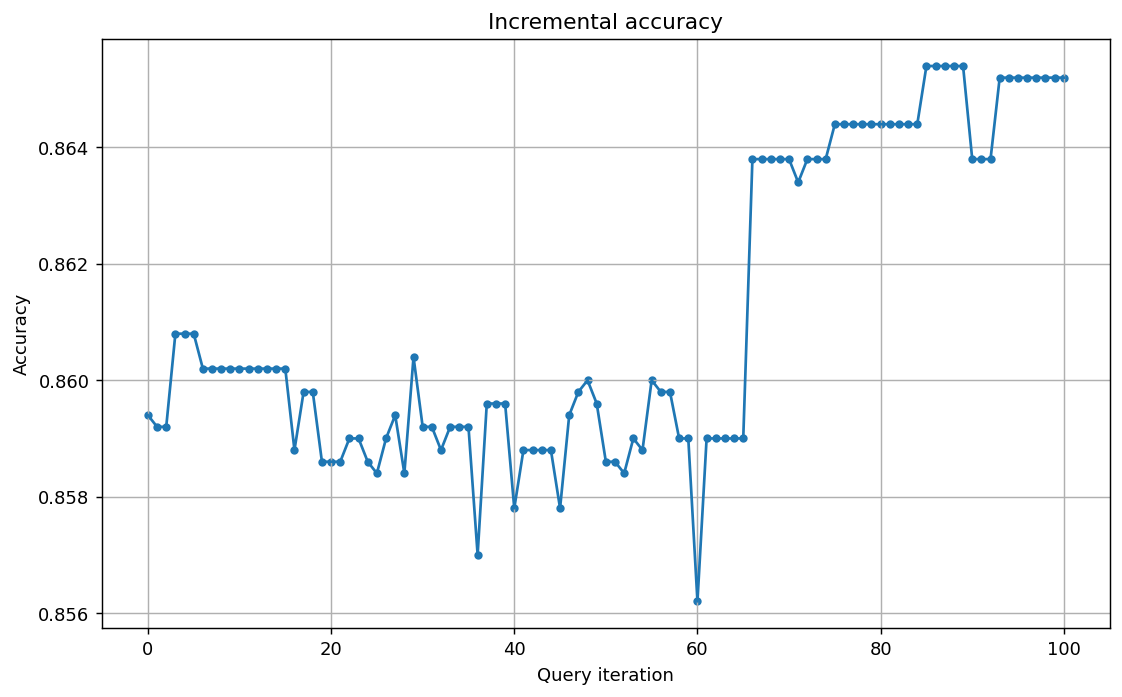

In [ ]:
# learning curve
plot_performance_model(history_marg_dt)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_marg = accuracy_score(y_train_new,y_pred_train)
f1_dt_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_marg)
print("f1 score : ",f1_dt_marg)
print("precision score : ",prec_dt_marg)
print("recall score : ",rec_dt_marg)

accuracy score :  0.8654
f1 score :  0.8414586818945484
precision score :  0.8471495674674883
recall score :  0.8365065522124819


In [ ]:
# AUC on train set
auc_dt_marg = roc_auc_score(y_train_new,y_pred_train)
auc_dt_marg

0.8365065522124819

Accuracy of dt classifier on test set: 0.80


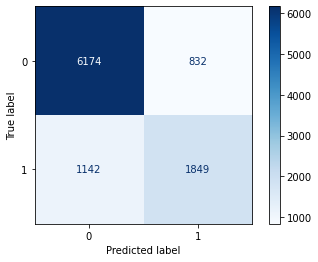

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_dt_marg = cm_dt_marg[0,0]
FP_dt_marg = cm_dt_marg[0,1]
FN_dt_marg= cm_dt_marg[1,0]
TN_dt_marg = cm_dt_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_marg_test = accuracy_score(y_test,y_pred_test)
f1_dt_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_marg_test)
print("f1 score : ",f1_dt_marg_test)
print("precision score : ",prec_dt_marg_test)
print("recall score : ",rec_dt_marg_test)

accuracy score :  0.8115434630389117
f1 score :  0.7749971902047863
precision score :  0.7753701215491609
recall score :  0.7746288871371942


In [ ]:
# AUC on test set
auc_dt_marg_test = roc_auc_score(y_test,y_pred_test)
auc_dt_marg_test

0.7746288871371942

###### **NB**

In [ ]:
# Training the Gaussian Model

gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=margin_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# learning process

num_of_queries = 100


history_marg_gm = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (margin sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_marg_gm.append(accuracy)

Accuracy after query 1: 0.7966
Accuracy after query 2: 0.7970
Accuracy after query 3: 0.7970
Accuracy after query 4: 0.7968
Accuracy after query 5: 0.7970
Accuracy after query 6: 0.7968
Accuracy after query 7: 0.7966
Accuracy after query 8: 0.7966
Accuracy after query 9: 0.7966
Accuracy after query 10: 0.7966
Accuracy after query 11: 0.7964
Accuracy after query 12: 0.7962
Accuracy after query 13: 0.7962
Accuracy after query 14: 0.7962
Accuracy after query 15: 0.7964
Accuracy after query 16: 0.7964
Accuracy after query 17: 0.7962
Accuracy after query 18: 0.7960
Accuracy after query 19: 0.7962
Accuracy after query 20: 0.7964
Accuracy after query 21: 0.7964
Accuracy after query 22: 0.7964
Accuracy after query 23: 0.7966
Accuracy after query 24: 0.7970
Accuracy after query 25: 0.7970
Accuracy after query 26: 0.7968
Accuracy after query 27: 0.7966
Accuracy after query 28: 0.7968
Accuracy after query 29: 0.7968
Accuracy after query 30: 0.7970
Accuracy after query 31: 0.7972
Accuracy after qu

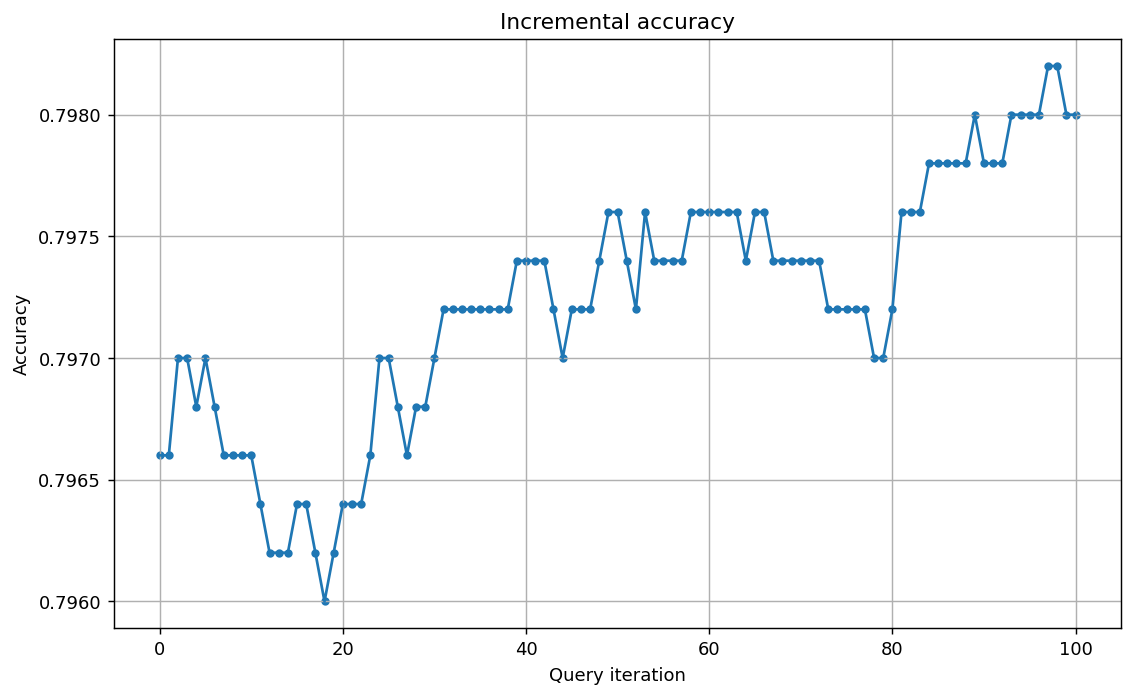

In [ ]:
# learning curve
plot_performance_model(history_marg_gm)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_marg = accuracy_score(y_train_new,y_pred_train)
f1_gm_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_marg)
print("f1 score : ",f1_gm_marg)
print("precision score : ",prec_gm_marg)
print("recall score : ",rec_gm_marg)

accuracy score :  0.798
f1 score :  0.7656377187945926
precision score :  0.7635378546209475
recall score :  0.7679377572054017


In [ ]:
# AUC on train set
auc_gm_marg = roc_auc_score(y_train_new,y_pred_train)
auc_gm_marg

0.7679377572054017

Accuracy of gm classifier on test set: 0.80


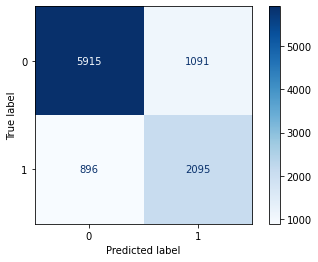

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_gm_marg = cm_gm_marg[0,0]
FP_gm_marg = cm_gm_marg[0,1]
FN_gm_marg= cm_gm_marg[1,0]
TN_gm_marg = cm_gm_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_marg_test = accuracy_score(y_test,y_pred_test)
f1_gm_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_marg_test)
print("f1 score : ",f1_gm_marg_test)
print("precision score : ",prec_gm_marg_test)
print("recall score : ",rec_gm_marg_test)

accuracy score :  0.8012403721116335
f1 score :  0.7672572291978326
precision score :  0.7630062213344739
recall score :  0.7723554859077184


In [ ]:
# AUC on test set
auc_gm_marg_test = roc_auc_score(y_test,y_pred_test)
auc_gm_marg_test 

0.7723554859077184

###### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                       learning_rate_init= nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 )
learner = ActiveLearner(estimator=mlp_nn, query_strategy=uncertainty_sampling,  X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - NN: {initial_score}")

Prediction Accuracy - NN: 0.8142


In [ ]:
# learning process

num_of_queries = 100


history_marg_nn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (margin sampling)

for idx in range(num_of_queries):
  query_idx, _ = learner.query(X_pool)

  # Teach the ActiveLeaner model
  x,y = X_pool[query_idx].reshape(1,-1), y_pool[query_idx].reshape(1,)

  learner.teach(X=x,y=y)
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)
  # Calculate and report our model's accuracy
  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=accuracy))

  history_marg_nn.append(accuracy)

Accuracy after query 1: 0.8076
Accuracy after query 2: 0.8160
Accuracy after query 3: 0.8106
Accuracy after query 4: 0.8180
Accuracy after query 5: 0.8198
Accuracy after query 6: 0.8170
Accuracy after query 7: 0.8110
Accuracy after query 8: 0.8234
Accuracy after query 9: 0.8208
Accuracy after query 10: 0.8162
Accuracy after query 11: 0.8162
Accuracy after query 12: 0.8200
Accuracy after query 13: 0.8236
Accuracy after query 14: 0.8174
Accuracy after query 15: 0.8254
Accuracy after query 16: 0.8194
Accuracy after query 17: 0.8218
Accuracy after query 18: 0.8266
Accuracy after query 19: 0.8114
Accuracy after query 20: 0.8152
Accuracy after query 21: 0.8208
Accuracy after query 22: 0.8250
Accuracy after query 23: 0.8220
Accuracy after query 24: 0.8220
Accuracy after query 25: 0.8158
Accuracy after query 26: 0.8244
Accuracy after query 27: 0.8230
Accuracy after query 28: 0.8202
Accuracy after query 29: 0.8216
Accuracy after query 30: 0.8272
Accuracy after query 31: 0.8224
Accuracy after qu

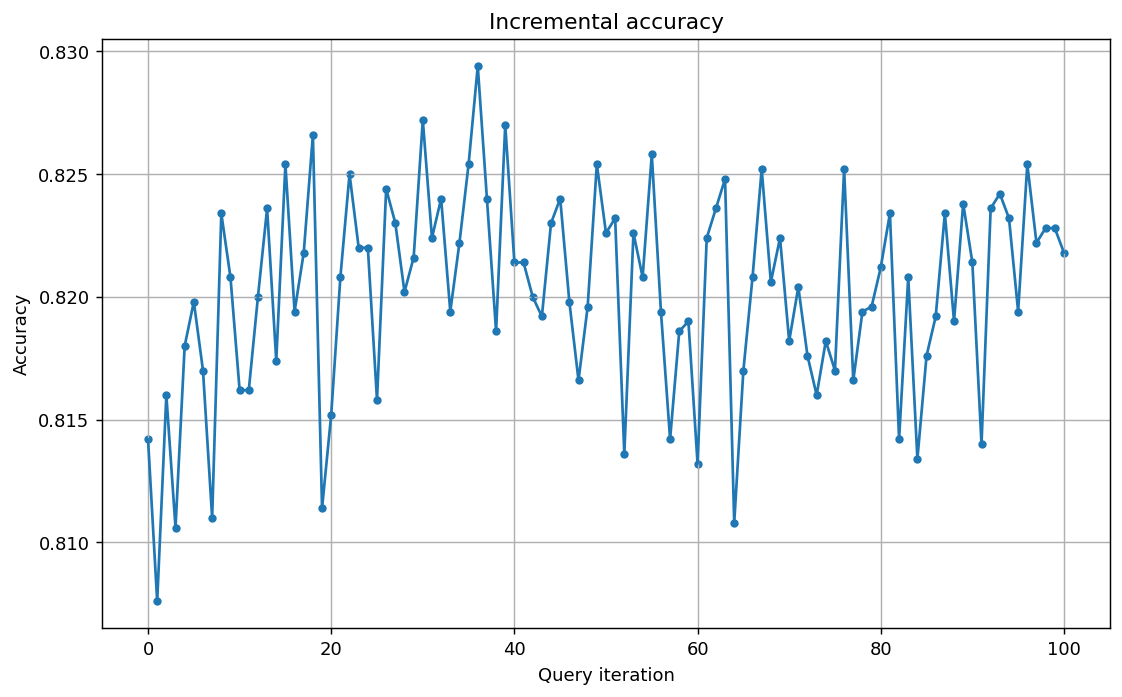

In [ ]:
# learning curve
plot_performance_model(history_marg_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_marg = accuracy_score(y_train_new,y_pred_train)
f1_nn_marg = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_marg = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_marg = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_marg)
print("f1 score : ",f1_nn_marg)
print("precision score : ",prec_nn_marg)
print("recall score : ",rec_nn_marg)

accuracy score :  0.8218
f1 score :  0.7837650613944626
precision score :  0.7967123391909439
recall score :  0.7744648751701442


In [ ]:
# AUC on train set
auc_nn_marg = roc_auc_score(y_train_new,y_pred_train)
auc_nn_marg

0.7744648751701442

Accuracy of nn classifier on test set: 0.82


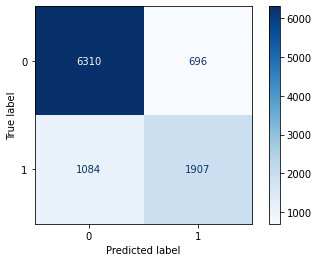

In [ ]:
# Check the performance on test set

print('Accuracy of nn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_nn_marg = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(mlp_nn, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# Confusion matrix
TP_nn_marg = cm_nn_marg[0,0]
FP_nn_marg = cm_nn_marg[0,1]
FN_nn_marg= cm_nn_marg[1,0]
TN_nn_marg = cm_nn_marg[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_marg_test = accuracy_score(y_test,y_pred_test)
f1_nn_marg_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_marg_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_marg_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_marg_test)
print("f1 score : ",f1_nn_marg_test)
print("precision score : ",prec_nn_marg_test)
print("recall score : ",rec_nn_marg_test)

accuracy score :  0.8219465839751926
f1 score :  0.77909540976443
precision score :  0.7930054281845992
recall score :  0.7691179924777664


In [ ]:
# AUC on test set
auc_nn_marg_test = roc_auc_score(y_test,y_pred_test)
auc_nn_marg_test

0.7691179924777664

###### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_train = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_marg, auc_lr_marg],
            'K Nearest Neighbour (KNN)': [acc_knn_marg, auc_knn_marg],
            'Support Vector Machine (SVC)': [acc_svc_marg, auc_svc_marg],
            'Decision Trees (DT)': [acc_dt_marg, auc_dt_marg],
            'Naive Bayes (NB)': [acc_gm_marg, auc_gm_marg],
            'Neural Networks (NN)': [acc_nn_marg, auc_nn_marg]
             }
dfp = pd.DataFrame(results_train, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_train = dfp.T
results_train

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7914     0.775648
K Nearest Neighbour (KNN)          0.8196     0.769304
Support Vector Machine (SVC)       0.7934     0.774063
Decision Trees (DT)                0.8654     0.836507
Naive Bayes (NB)                   0.7980     0.767938
Neural Networks (NN)               0.8218     0.774465

In [ ]:
# Creating performance table of test
results_test = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_marg_test,auc_lr_marg_test],
            'K Nearest Neighbour (KNN)': [acc_knn_marg_test, auc_knn_marg_test],
            'Support Vector Machine (SVC)': [acc_svc_marg_test, auc_svc_marg_test],
            'Decision Trees (DT)': [acc_dt_marg_test, auc_dt_marg_test],
            'Naive Bayes (NB)': [acc_gm_marg_test, auc_gm_marg_test],
            'Neural Networks (NN)': [acc_nn_marg_test, auc_nn_marg_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_test = dfp.T
results_test

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.792938    0.776108
K Nearest Neighbour (KNN)       0.810743    0.753557
Support Vector Machine (SVC)    0.797239    0.776015
Decision Trees (DT)             0.811543    0.774629
Naive Bayes (NB)                0.801240    0.772355
Neural Networks (NN)            0.821947    0.769118

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_marg, FP_lr_marg, TN_lr_marg, FN_lr_marg],
            'K Nearest Neighbour (KNN)': [TP_knn_marg, FP_knn_marg, TN_knn_marg, FN_knn_marg],
            'Support Vector Machine (SVC)': [TP_svc_marg, FP_svc_marg, TN_svc_marg, FN_svc_marg],
            'Decision Trees (DT)': [TP_dt_marg, FP_dt_marg, TN_dt_marg, FN_dt_marg],
            'Naive Bayes (NB)': [TP_gm_marg, FP_gm_marg, TN_gm_marg, FN_gm_marg],
            'Neural Networks (NN)': [TP_nn_marg, FP_nn_marg, TN_nn_marg,FN_nn_marg]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5731  1275  2196   795
K Nearest Neighbour (KNN)     6277   729  1828  1163
Support Vector Machine (SVC)  5807  1199  2163   828
Decision Trees (DT)           6174   832  1849  1142
Naive Bayes (NB)              5915  1091  2095   896
Neural Networks (NN)          6310   696  1907  1084

##### **Comparison between query strategies for each credit scoring model** 

###### **SVC**

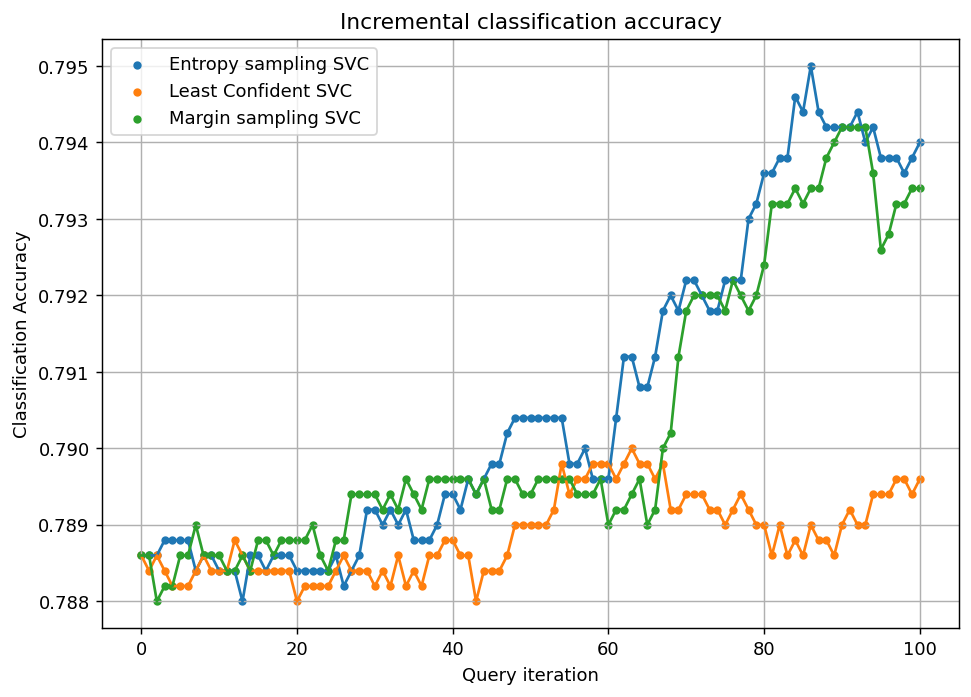

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_entro_svc)
ax.scatter(range(len(history_entro_svc)), history_entro_svc, s=13, label = 'Entropy sampling SVC')

ax.plot(history_least_svc)
ax.scatter(range(len(history_least_svc)), history_least_svc, s=13, label = 'Least Confident SVC')

ax.plot(history_marg_svc)
ax.scatter(range(len(history_marg_svc)), history_marg_svc, s=13, label = 'Margin sampling SVC')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **NB**

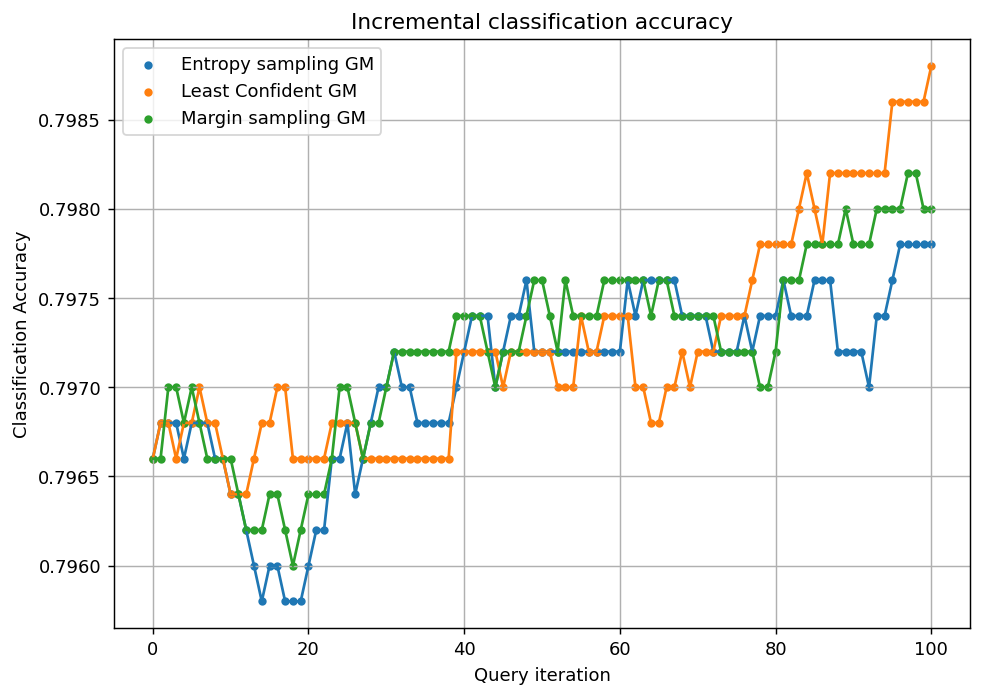

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_entro_gm)
ax.scatter(range(len(history_entro_gm)), history_entro_gm, s=13, label = 'Entropy sampling GM')

ax.plot(history_least_gm)
ax.scatter(range(len(history_least_gm)), history_least_gm, s=13, label = 'Least Confident GM')

ax.plot(history_marg_gm)
ax.scatter(range(len(history_marg_gm)), history_marg_gm, s=13, label = 'Margin sampling GM')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **LR**

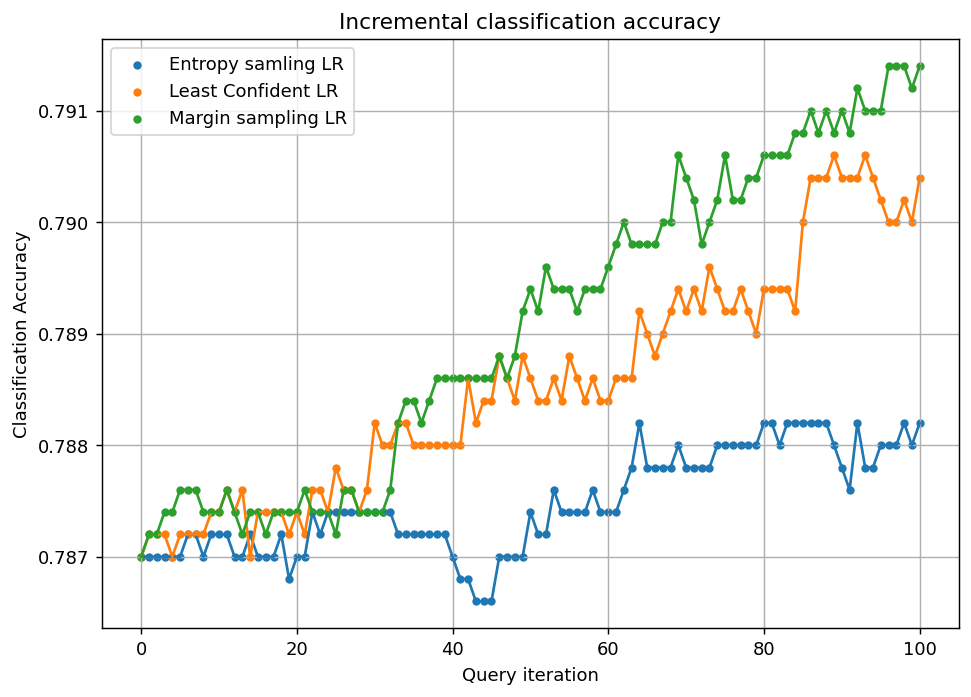

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_entro_lr)
ax.scatter(range(len(history_entro_lr)), history_entro_lr, s=13, label = 'Entropy samling LR')

ax.plot(history_least_lr)
ax.scatter(range(len(history_least_lr)), history_least_lr, s=13, label = 'Least Confident LR')

ax.plot(history_marg_lr)
ax.scatter(range(len(history_marg_lr)), history_marg_lr, s=13, label = 'Margin sampling LR')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **DT**

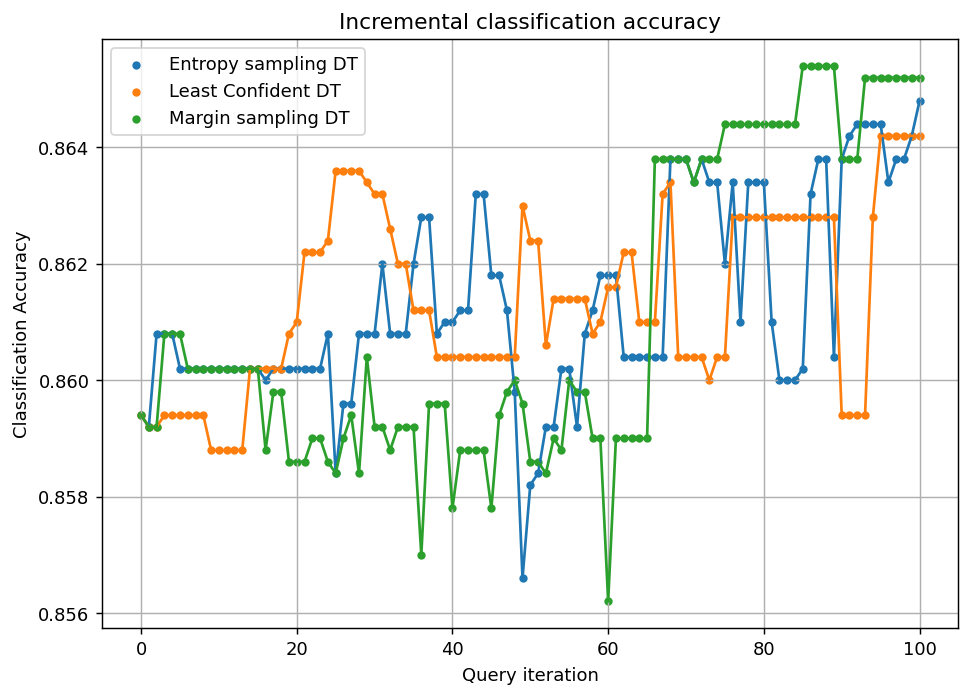

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_entro_dt)
ax.scatter(range(len(history_entro_dt)), history_entro_dt, s=13, label = 'Entropy sampling DT')

ax.plot(history_least_dt)
ax.scatter(range(len(history_least_dt)), history_least_dt, s=13, label = 'Least Confident DT')

ax.plot(history_marg_dt)
ax.scatter(range(len(history_marg_dt)), history_marg_dt, s=13, label = 'Margin sampling DT')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **KNN**

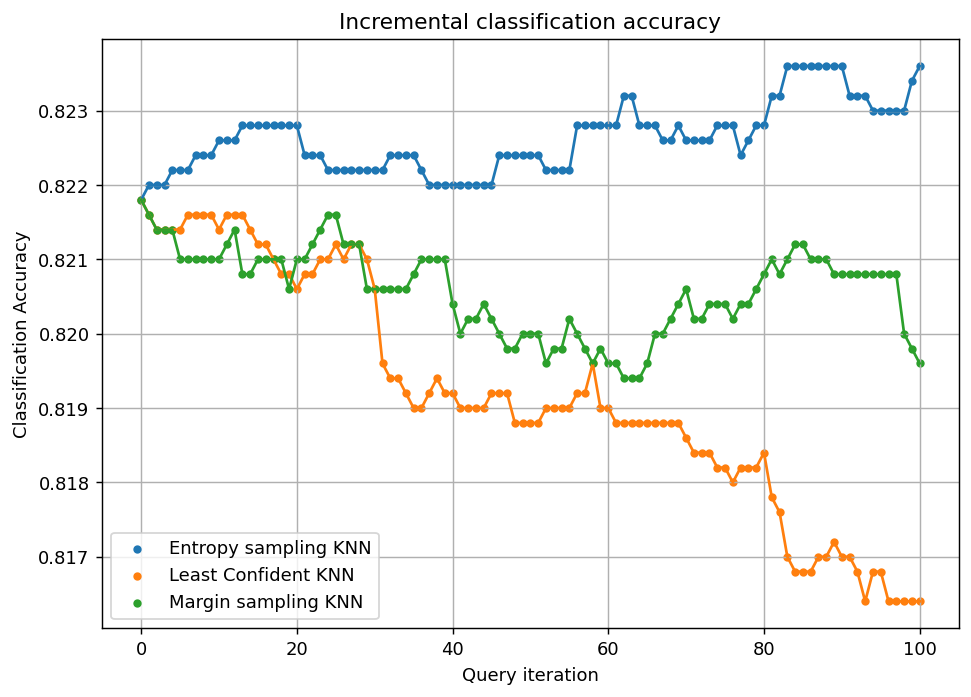

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_entro_knn)
ax.scatter(range(len(history_entro_knn)), history_entro_knn, s=13, label = 'Entropy sampling KNN')

ax.plot(history_least_knn)
ax.scatter(range(len(history_least_knn)), history_least_knn, s=13, label = 'Least Confident KNN')

ax.plot(history_marg_knn)
ax.scatter(range(len(history_marg_knn)), history_marg_knn, s=13, label = 'Margin sampling KNN')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

###### **NN**

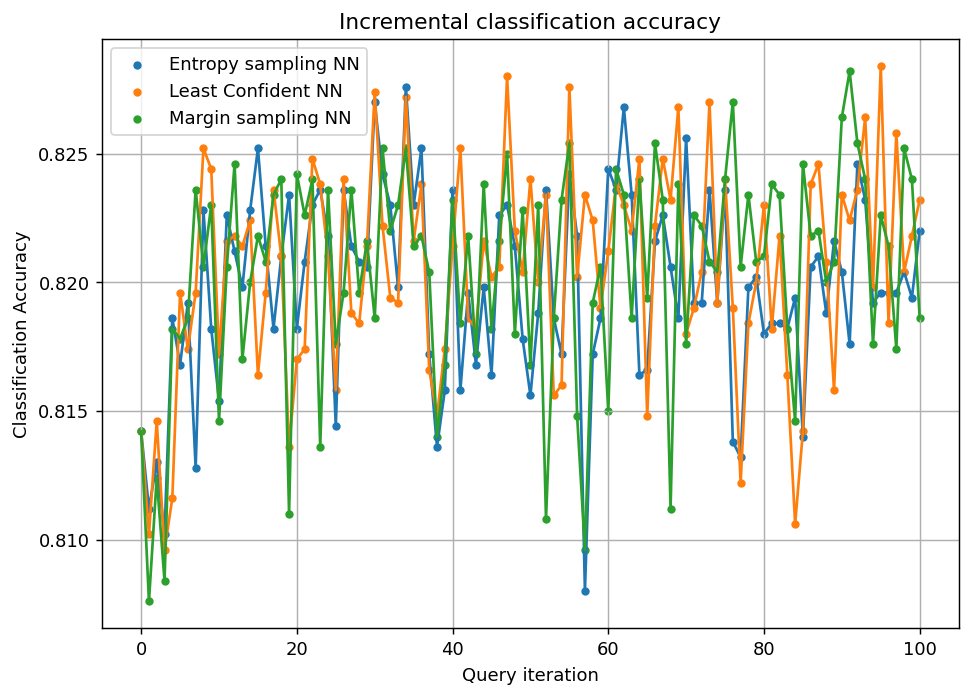

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_entro_nn)
ax.scatter(range(len(history_entro_nn)), history_entro_nn, s=13, label = 'Entropy sampling NN')

ax.plot(history_least_nn)
ax.scatter(range(len(history_least_nn)), history_least_nn, s=13, label = 'Least Confident NN')

ax.plot(history_marg_nn)
ax.scatter(range(len(history_marg_nn)), history_marg_nn, s=13, label = 'Margin sampling NN')

ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

#### **Quiery By Committee**

##### **Vote entropy sampling**

In [ ]:
from sklearn import tree

In [ ]:
# initializing Committee members
learner_list = list()


learner1 = ActiveLearner(
       estimator=LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' ), 
        X_training=X_train_new, y_training=y_train_new)

learner2 = ActiveLearner(estimator=SVC(C=svc_train.best_estimator_.C, kernel='linear', probability=True, class_weight= 'balanced'),
                        X_training=X_train_new, y_training=y_train_new)
learner3 = ActiveLearner(
        estimator=tree.DecisionTreeClassifier(random_state = seed, max_depth = 8), 
    X_training=X_train_new, y_training=y_train_new)
learner4= ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors = 22, weights= 'uniform'), X_training=X_train_new, y_training=y_train_new
  )
learner5=ActiveLearner( 
        estimator=GaussianNB(), X_training=X_train_new, y_training=y_train_new
    )
learner6 = ActiveLearner(estimator=MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                                                 learning_rate_init=nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 ),
                                             X_training=X_train_new, y_training=y_train_new)

learner_list.append(learner1)
learner_list.append(learner2)
learner_list.append(learner3)
learner_list.append(learner4)
learner_list.append(learner5)
learner_list.append(learner6)
# assembling the committee
committee = Committee(learner_list=learner_list,query_strategy=vote_entropy_sampling)
#compute committee score
initial_score = committee.score(X_train_new, y_train_new)

print(f"Prediction Accuracy : {initial_score}")

Prediction Accuracy : 0.8302


In [ ]:
# prediction
y_pred_train = committee.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_com_train = accuracy_score(y_train_new,y_pred_train)
f1_com_train = f1_score(y_train_new, y_pred_train, average="macro")
prec_com_train = precision_score(y_train_new, y_pred_train, average="macro")
rec_com_train = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_com_train)
print("f1 score : ",f1_com_train)
print("precision score : ",prec_com_train)
print("recall score : ",rec_com_train)

accuracy score :  0.8302
f1 score :  0.7928547932595682
precision score :  0.7979751673300186
recall score :  0.7883746779377876


In [ ]:
# AUC on train set
auc_com_train = roc_auc_score(y_train_new,y_pred_train)
auc_com_train

0.7883746779377876

In [ ]:
# compute confusion matrix on test set
y_pred_test = committee.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_com = confusion_matrix(y_test, y_pred_test)
print(cm_com)

[[6138  868]
 [ 950 2041]]


In [ ]:
# confusion matrix
TP_com = cm_com[0,0]
FP_com = cm_com[0,1]
FN_com = cm_com[1,0]
TN_com = cm_com[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_com_test = accuracy_score(y_test,y_pred_test)
f1_com_test = f1_score(y_test, y_pred_test, average="macro")
prec_com_test = precision_score(y_test, y_pred_test, average="macro")
rec_com_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_com_test)
print("f1 score : ",f1_com_test)
print("precision score : ",prec_com_test)
print("recall score : ",rec_com_test)

accuracy score :  0.8181454436330899
f1 score :  0.7814366733770592
precision score :  0.7837931650586993
recall score :  0.7792433347239358


In [ ]:
# AUC on test set
auc_com_test = roc_auc_score(y_test,y_pred_test)
auc_com_test

0.7792433347239358

###### **QBC process**

In [ ]:
# learning process
history_vote_entro_sam = [initial_score]

# query by committee
n_queries = 100
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    new_score = committee.score(X_train_new, y_train_new)
    history_vote_entro_sam.append(new_score)
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    print('Data Point no. %d queried, new accuracy: %f' % (idx, new_score))

Data Point no. 0 queried, new accuracy: 0.828000
Data Point no. 1 queried, new accuracy: 0.830000
Data Point no. 2 queried, new accuracy: 0.829400
Data Point no. 3 queried, new accuracy: 0.830400
Data Point no. 4 queried, new accuracy: 0.830400
Data Point no. 5 queried, new accuracy: 0.829800
Data Point no. 6 queried, new accuracy: 0.829200
Data Point no. 7 queried, new accuracy: 0.829400
Data Point no. 8 queried, new accuracy: 0.830400
Data Point no. 9 queried, new accuracy: 0.831400
Data Point no. 10 queried, new accuracy: 0.829600
Data Point no. 11 queried, new accuracy: 0.830200
Data Point no. 12 queried, new accuracy: 0.829400
Data Point no. 13 queried, new accuracy: 0.830600
Data Point no. 14 queried, new accuracy: 0.831800
Data Point no. 15 queried, new accuracy: 0.831400
Data Point no. 16 queried, new accuracy: 0.830400
Data Point no. 17 queried, new accuracy: 0.833000
Data Point no. 18 queried, new accuracy: 0.830400
Data Point no. 19 queried, new accuracy: 0.831200
Data Point

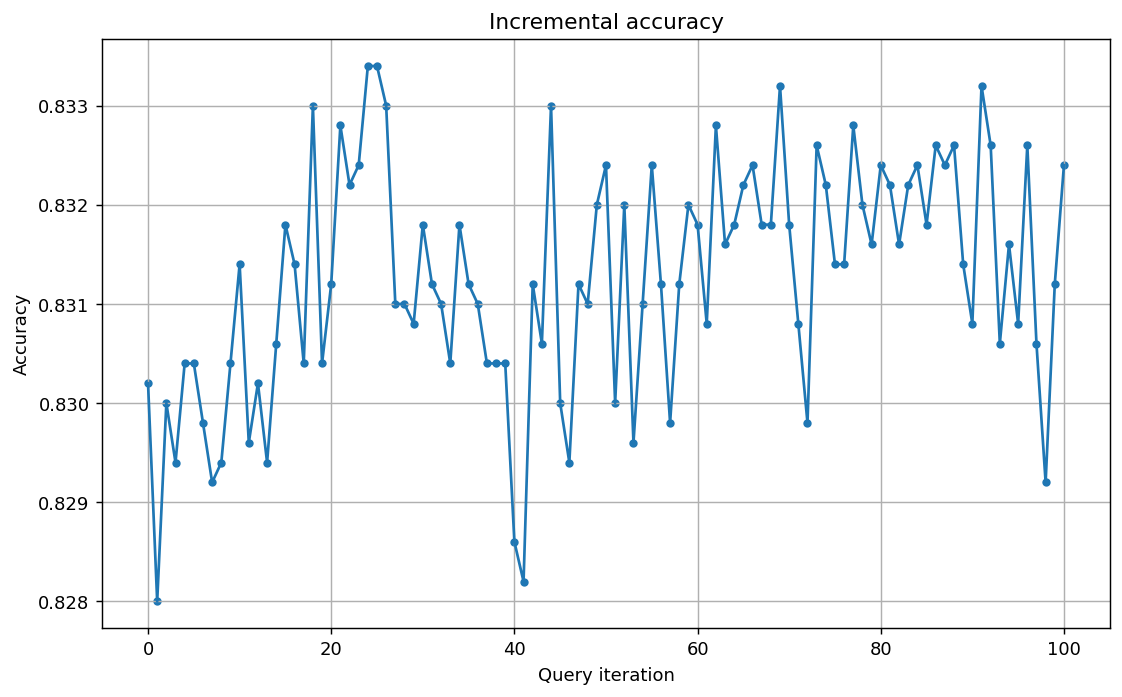

In [ ]:
# learning curve
plot_performance_model(history_vote_entro_sam)

In [ ]:
# prediction
y_pred_train = committee.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_vote_entro_sam = accuracy_score(y_train_new,y_pred_train)
f1_vote_entro_sam = f1_score(y_train_new, y_pred_train, average="macro")
prec_vote_entro_sam = precision_score(y_train_new, y_pred_train, average="macro")
rec_vote_entro_sam = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_vote_entro_sam)
print("f1 score : ",f1_vote_entro_sam)
print("precision score : ",prec_vote_entro_sam)
print("recall score : ",rec_vote_entro_sam)

accuracy score :  0.8324
f1 score :  0.7956655742821475
precision score :  0.8030318917866291
recall score :  0.7895457516495785


In [ ]:
# compute AUC on train
auc_vote_entro_sam = roc_auc_score(y_train_new,y_pred_train)
auc_vote_entro_sam

0.7895457516495785

In [ ]:
# compute confusion matrix on test set
y_pred_test = committee.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_vote_entro_sam = confusion_matrix(y_test, y_pred_test)
print(cm_vote_entro_sam)

[[6216  790]
 [ 976 2015]]


In [ ]:
# Confusion matrix
TP_vote_entro_sam = cm_vote_entro_sam[0,0]
FP_vote_entro_sam = cm_vote_entro_sam[0,1]
FN_vote_entro_sam = cm_vote_entro_sam[1,0]
TN_vote_entro_sam = cm_vote_entro_sam[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_vote_entro_sam_test = accuracy_score(y_test,y_pred_test)
f1_vote_entro_sam_test = f1_score(y_test, y_pred_test, average="macro")
prec_vote_entro_sam_test = precision_score(y_test, y_pred_test, average="macro")
rec_vote_entro_sam_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_vote_entro_sam_test)
print("f1 score : ",f1_vote_entro_sam_test)
print("precision score : ",prec_vote_entro_sam_test)
print("recall score : ",rec_vote_entro_sam_test)

accuracy score :  0.8233470041012304
f1 score :  0.785461696167123
precision score :  0.7913268654615249
recall score :  0.7804636194242638


In [ ]:
# AUC on test set
auc_vote_entro_sam_test = roc_auc_score(y_test,y_pred_test)
auc_vote_entro_sam_test

0.7804636194242638

##### **KL Divergence sampling**

In [ ]:
from sklearn import tree

In [ ]:
# initializing Committee members
learner_list = list()


learner1 = ActiveLearner(
       estimator=LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' ), 
        X_training=X_train_new, y_training=y_train_new)

learner2 = ActiveLearner(estimator=SVC(C=svc_train.best_estimator_.C, kernel='linear', probability=True, class_weight= 'balanced'),
                        X_training=X_train_new, y_training=y_train_new)
learner3 = ActiveLearner(
        estimator=tree.DecisionTreeClassifier(random_state = seed, max_depth = 8), 
    X_training=X_train_new, y_training=y_train_new)
learner4= ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors = 22, weights= 'uniform'), X_training=X_train_new, y_training=y_train_new
  )
learner5=ActiveLearner( 
        estimator=GaussianNB(), X_training=X_train_new, y_training=y_train_new
    )
learner6 = ActiveLearner(estimator=MLPClassifier(hidden_layer_sizes= nn_train.best_estimator_.hidden_layer_sizes,
                                                 learning_rate_init=nn_train.best_estimator_.learning_rate_init,solver = 'adam', random_state = seed, max_iter = 1000 ),
                                             X_training=X_train_new, 
                                             y_training=y_train_new)

learner_list.append(learner1)
learner_list.append(learner2)
learner_list.append(learner3)
learner_list.append(learner4)
learner_list.append(learner5)
learner_list.append(learner6)
# assembling the committee

committee = Committee(learner_list=learner_list,query_strategy= max_disagreement_sampling)

#compute committee score
initial_score = committee.score(X_train_new, y_train_new)

print(f"Prediction Accuracy : {initial_score}")

Prediction Accuracy : 0.8302


In [ ]:
# learning process
history_kl_diverg_sam = [initial_score]

# query by committee
n_queries = 100
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    new_score = committee.score(X_train_new, y_train_new)
    history_kl_diverg_sam.append(new_score)
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    print('Data Point no. %d queried, new accuracy: %f' % (idx, new_score))

Data Point no. 0 queried, new accuracy: 0.827800
Data Point no. 1 queried, new accuracy: 0.828800
Data Point no. 2 queried, new accuracy: 0.831000
Data Point no. 3 queried, new accuracy: 0.828600
Data Point no. 4 queried, new accuracy: 0.828800
Data Point no. 5 queried, new accuracy: 0.830000
Data Point no. 6 queried, new accuracy: 0.830800
Data Point no. 7 queried, new accuracy: 0.829800
Data Point no. 8 queried, new accuracy: 0.829800
Data Point no. 9 queried, new accuracy: 0.830200
Data Point no. 10 queried, new accuracy: 0.831400
Data Point no. 11 queried, new accuracy: 0.829600
Data Point no. 12 queried, new accuracy: 0.830200
Data Point no. 13 queried, new accuracy: 0.831800
Data Point no. 14 queried, new accuracy: 0.830400
Data Point no. 15 queried, new accuracy: 0.829400
Data Point no. 16 queried, new accuracy: 0.830400
Data Point no. 17 queried, new accuracy: 0.831200
Data Point no. 18 queried, new accuracy: 0.830400
Data Point no. 19 queried, new accuracy: 0.831000
Data Point

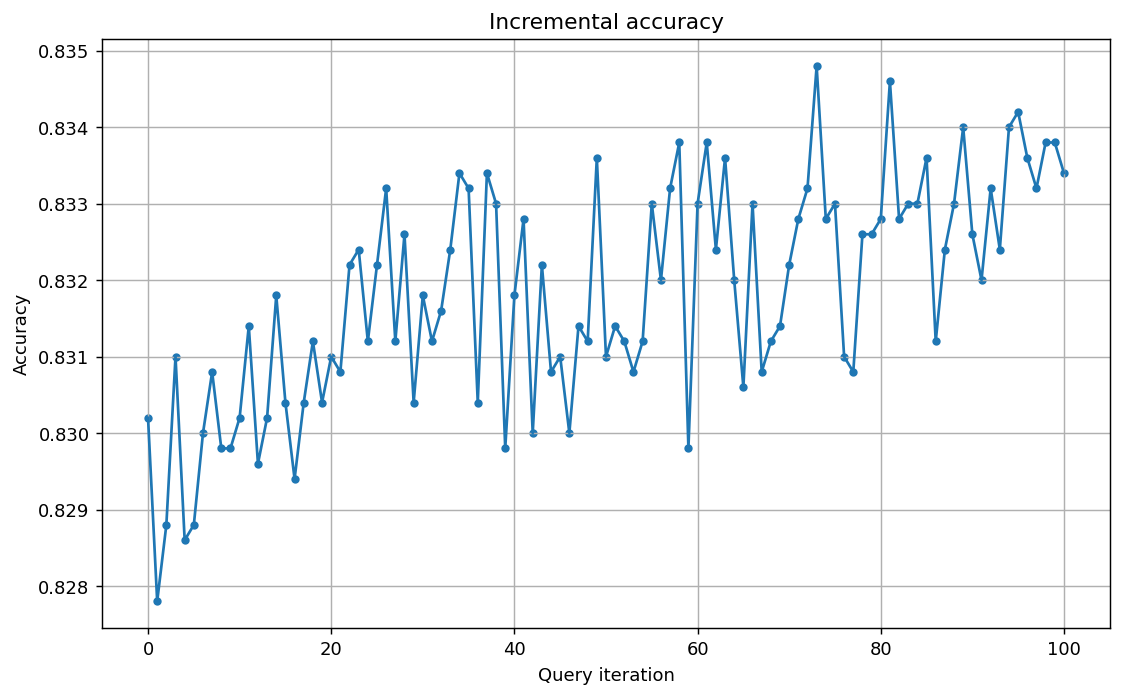

In [ ]:
# learning performanc.
plot_performance_model(history_kl_diverg_sam)

In [ ]:
# prediction
y_pred_train = committee.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_kl_diverg_sam = accuracy_score(y_train_new,y_pred_train)
f1_kl_diverg_sam = f1_score(y_train_new, y_pred_train, average="macro")
prec_kl_diverg_sam = precision_score(y_train_new, y_pred_train, average="macro")
rec_kl_diverg_sam = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_kl_diverg_sam)
print("f1 score : ",f1_kl_diverg_sam)
print("precision score : ",prec_kl_diverg_sam)
print("recall score : ",rec_kl_diverg_sam)


accuracy score :  0.8334
f1 score :  0.7968427361327607
precision score :  0.8018843564087812
recall score :  0.7924130864260143


In [ ]:
# AUC on train set
auc_kl_diverg_sam = roc_auc_score(y_train_new,y_pred_train)
auc_kl_diverg_sam

0.7924130864260143

In [ ]:
# Check the performance on test set

print('Accuracy of classifier on test set: {:.2f}'
     .format(committee.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = committee.predict(X_test)
from sklearn.metrics import confusion_matrix
cm_kl_diverg_sam = confusion_matrix(y_test, y_pred_test)
print(cm_kl_diverg_sam)

Accuracy of classifier on test set: 0.82
[[6166  840]
 [ 952 2039]]


In [ ]:
# Confusion matrix
TP_kl_diverg_sam = cm_kl_diverg_sam[0,0]
FP_kl_diverg_sam = cm_kl_diverg_sam[0,1]
FN_kl_diverg_sam = cm_kl_diverg_sam[1,0]
TN_kl_diverg_sam = cm_kl_diverg_sam[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_kl_diverg_sam_test = accuracy_score(y_test,y_pred_test)
f1_kl_diverg_sam_test = f1_score(y_test, y_pred_test, average="macro")
prec_kl_diverg_sam_test = precision_score(y_test, y_pred_test, average="macro")
rec_kl_diverg_sam_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_kl_diverg_sam_test)
print("f1 score : ",f1_kl_diverg_sam_test)
print("precision score : ",prec_kl_diverg_sam_test)
print("recall score : ",rec_kl_diverg_sam_test)

accuracy score :  0.8207462238671601
f1 score :  0.78392133534231
precision score :  0.7872432954489892
recall score :  0.7809072855639905


In [ ]:
# AUC on test set 
auc_kl_diverg_sam_test = roc_auc_score(y_test,y_pred_test)
auc_kl_diverg_sam_test

0.7809072855639905

##### **Comparison both strategies**

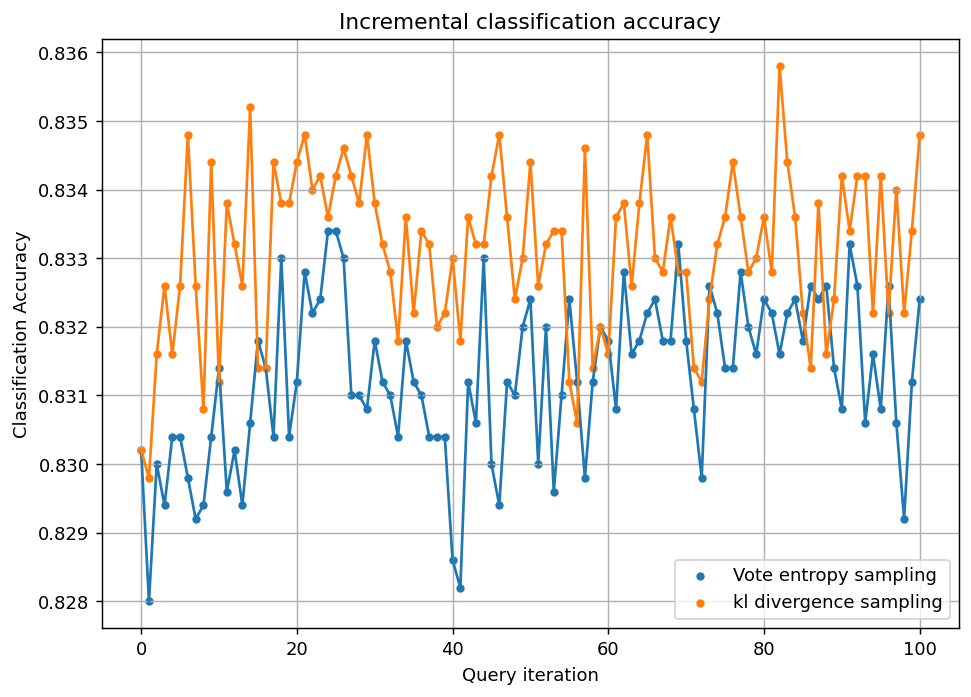

In [ ]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_vote_entro_sam)
ax.scatter(range(len(history_vote_entro_sam)), history_vote_entro_sam, s=13, label = 'Vote entropy sampling')

ax.plot(history_kl_diverg_sam)
ax.scatter(range(len(history_kl_diverg_sam)), history_kl_diverg_sam, s=13, label = 'kl divergence sampling')


ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

##### **Evaluation metric**

In [ ]:
# Creating performance table of train
results_train = {'Approach': ['Acc (train)','AUC (train)'],
            'Committee' : [acc_com_train, auc_com_train],
            'Vote Entropy sampling (VES)': [acc_vote_entro_sam, auc_vote_entro_sam],
            'KL Divergence sampling (VES)': [acc_kl_diverg_sam, auc_kl_diverg_sam]
             }
dfp = pd.DataFrame(results_train, columns = ['Approach', 
                                      'Committee',
                                     'Vote Entropy sampling (VES)',
                                     'KL Divergence sampling (VES)'
                                        ])
dfp.set_index("Approach", inplace=True)

results_train = dfp.T
results_train

Approach                      Acc (train)  AUC (train)
Committee                          0.8302     0.788375
Vote Entropy sampling (VES)        0.8324     0.789546
KL Divergence sampling (VES)       0.8334     0.792413

In [ ]:
# Creating performance table of test
results_test = {'Approach': ['Acc (test)','AUC (test)'],
            'Committee' : [acc_com_test, auc_com_test],
            'Vote Entropy sampling (VES)': [acc_vote_entro_sam_test, auc_vote_entro_sam_test],
            'KL Divergence sampling (KLDS)': [acc_kl_diverg_sam_test, auc_kl_diverg_sam_test]
             }
dfp = pd.DataFrame(results_test, columns = ['Approach', 
                                     'Committee',
                                     'Vote Entropy sampling (VES)',
                                     'KL Divergence sampling (KLDS)'
                                        ])
dfp.set_index("Approach", inplace=True)

results_test = dfp.T
results_test

Approach                       Acc (test)  AUC (test)
Committee                        0.818145    0.779243
Vote Entropy sampling (VES)      0.823347    0.780464
KL Divergence sampling (KLDS)    0.820746    0.780907

In [ ]:
# Creating confusion matrix table
results = {'Approach': ['TP','FP', 'TN', 'FN'],
            'Committee' : [TP_com, FP_com, TN_com, FN_com],
            'Vote Entropy sampling (VES)': [TP_vote_entro_sam, FP_vote_entro_sam, TN_vote_entro_sam, FN_vote_entro_sam],
            'KL Divergence sampling (KLDS)': [TP_kl_diverg_sam, FP_kl_diverg_sam, TN_kl_diverg_sam, FN_kl_diverg_sam]
             }
tcm = pd.DataFrame(results, columns = ['Approach',
                                     'Committee', 
                                     'Vote Entropy sampling (VES)',
                                     'KL Divergence sampling (KLDS)'
                                        ])
tcm.set_index("Approach", inplace=True)

results = tcm.T
results

Approach                         TP   FP    TN   FN
Committee                      6138  868  2041  950
Vote Entropy sampling (VES)    6216  790  2015  976
KL Divergence sampling (KLDS)  6166  840  2039  952

#### **Density Weighted method**

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
km = kmeans.fit(X_pool)

In [ ]:
print(kmeans.cluster_centers_[0])

[ 5.76271186e-01  6.54851485e-01  4.49907703e-01  6.20383839e-01
  4.15336490e-02  6.56332256e-01  2.12463894e-01  4.58044910e-01
  1.44502808e-01  4.35483871e-01 -8.32667268e-17  6.93889390e-17
  5.48154815e-01  2.52664021e-01  2.42336132e-02  9.54671639e-01]


In [ ]:
np.where((X_pool == kmeans.cluster_centers_[0]).all(axis=1))

(array([], dtype=int64),)

In [ ]:
mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

##### **SVC**

In [ ]:
# define Learner, including training data as starting point
svc = SVC(C=svc_train.best_estimator_.C, random_state= seed, kernel='linear', probability=True, class_weight= 'balanced')
learner = ActiveLearner(estimator=svc, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - SVC: {initial_score}")

Prediction Accuracy - SVC: 0.7886


In [ ]:
# Add the centroids to the dataset
y_labels = learner.predict(kmeans.cluster_centers_)

In [ ]:
num_of_queries = 100


history_dw_svc = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (density)


for i in range(num_of_queries):

  learner.teach(X=kmeans.cluster_centers_[i].reshape(1, -1),y=y_labels[i].reshape(1,))

  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=accuracy))

  history_dw_svc.append(accuracy)

Accuracy after query 1: 0.7886
Accuracy after query 2: 0.7886
Accuracy after query 3: 0.7886
Accuracy after query 4: 0.7886
Accuracy after query 5: 0.7886
Accuracy after query 6: 0.7886
Accuracy after query 7: 0.7886
Accuracy after query 8: 0.7886
Accuracy after query 9: 0.7888
Accuracy after query 10: 0.7886
Accuracy after query 11: 0.7886
Accuracy after query 12: 0.7886
Accuracy after query 13: 0.7886
Accuracy after query 14: 0.7886
Accuracy after query 15: 0.7886
Accuracy after query 16: 0.7886
Accuracy after query 17: 0.7888
Accuracy after query 18: 0.7886
Accuracy after query 19: 0.7886
Accuracy after query 20: 0.7888
Accuracy after query 21: 0.7888
Accuracy after query 22: 0.7886
Accuracy after query 23: 0.7886
Accuracy after query 24: 0.7888
Accuracy after query 25: 0.7888
Accuracy after query 26: 0.7886
Accuracy after query 27: 0.7886
Accuracy after query 28: 0.7888
Accuracy after query 29: 0.7888
Accuracy after query 30: 0.7886
Accuracy after query 31: 0.7888
Accuracy after qu

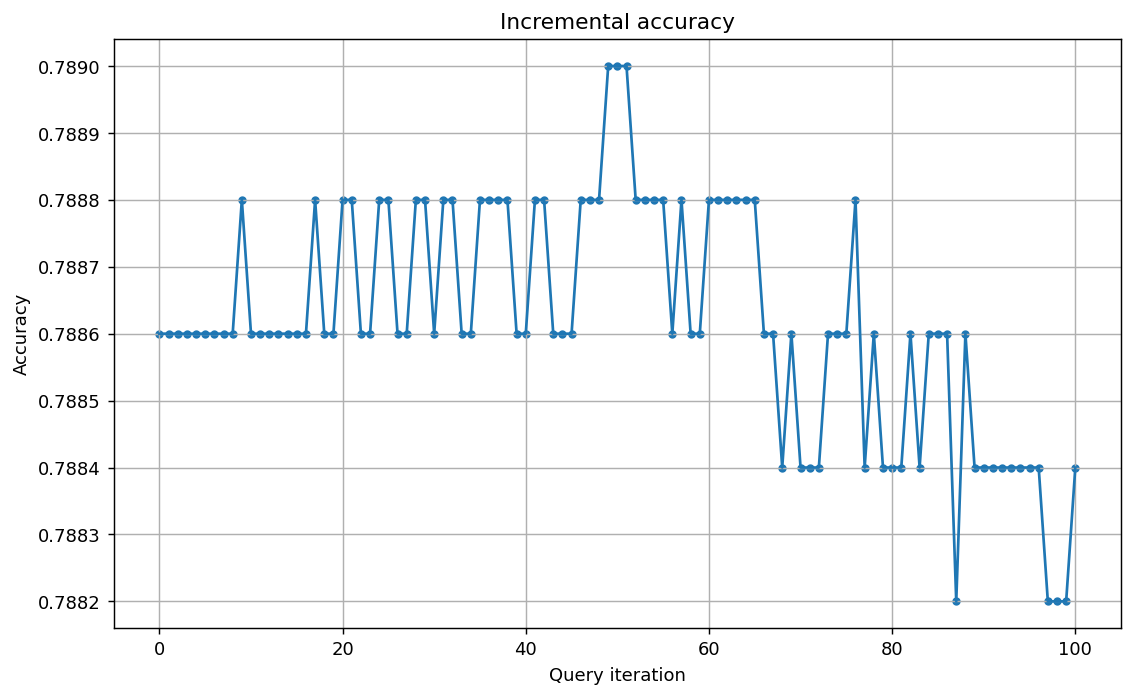

In [ ]:
# learning curve
plot_performance_model(history_dw_svc)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_dw = accuracy_score(y_train_new,y_pred_train)
f1_svc_dw = f1_score(y_train_new, y_pred_train, average="macro")
prec_svc_dw = precision_score(y_train_new, y_pred_train, average="macro")
rec_svc_dw = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_svc_dw)
print("f1 score : ",f1_svc_dw)
print("precision score : ",prec_svc_dw)
print("recall score : ",rec_svc_dw)

accuracy score :  0.7884
f1 score :  0.7612536197832562
precision score :  0.7543845645263694
recall score :  0.7720483635544708


In [ ]:
# AUC on train set
auc_svc_dw = roc_auc_score(y_train_new,y_pred_train)
auc_svc_dw

0.7720483635544708

Accuracy of svc classifier on test set: 0.79


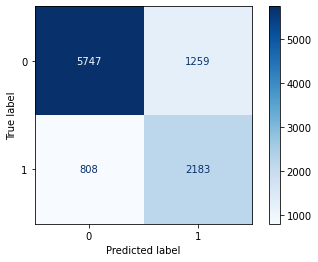

In [ ]:
# Check the performance on test set

print('Accuracy of svc classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_svc_dw = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(svc, X_test, y_test, values_format= ".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_svc_dw = cm_svc_dw[0,0]
FP_svc_dw = cm_svc_dw[0,1]
FN_svc_dw = cm_svc_dw[1,0]
TN_svc_dw = cm_svc_dw[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_svc_dw_test = accuracy_score(y_test,y_pred_test)
f1_svc_dw_test = f1_score(y_test, y_pred_test, average="macro")
prec_svc_dw_test = precision_score(y_test, y_pred_test, average="macro")
rec_svc_dw_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_svc_dw_test)
print("f1 score : ",f1_svc_dw_test)
print("precision score : ",prec_svc_dw_test)
print("recall score : ",rec_svc_dw_test)

accuracy score :  0.7932379713914174
f1 score :  0.7631328135967672
precision score :  0.7554798023783913
recall score :  0.7750765618770862


In [ ]:
# AUC on test
auc_svc_dw_test = roc_auc_score(y_test,y_pred_test)
auc_svc_dw_test

0.7750765618770862

##### **KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 22, weights='uniform')
learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - knn: {initial_score}")

Prediction Accuracy - knn: 0.8218


In [ ]:
# Add the centroids to the dataset
y_labels = learner.predict(kmeans.cluster_centers_)

In [ ]:
num_of_queries = 100


history_dw_knn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (density)


for i in range(num_of_queries):

  learner.teach(X=kmeans.cluster_centers_[i].reshape(1, -1),y=y_labels[i].reshape(1,))

  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=accuracy))

  history_dw_knn.append(accuracy)

Accuracy after query 1: 0.8218
Accuracy after query 2: 0.8218
Accuracy after query 3: 0.8218
Accuracy after query 4: 0.8218
Accuracy after query 5: 0.8220
Accuracy after query 6: 0.8220
Accuracy after query 7: 0.8218
Accuracy after query 8: 0.8218
Accuracy after query 9: 0.8216
Accuracy after query 10: 0.8216
Accuracy after query 11: 0.8216
Accuracy after query 12: 0.8216
Accuracy after query 13: 0.8216
Accuracy after query 14: 0.8216
Accuracy after query 15: 0.8214
Accuracy after query 16: 0.8214
Accuracy after query 17: 0.8214
Accuracy after query 18: 0.8216
Accuracy after query 19: 0.8216
Accuracy after query 20: 0.8214
Accuracy after query 21: 0.8216
Accuracy after query 22: 0.8216
Accuracy after query 23: 0.8216
Accuracy after query 24: 0.8216
Accuracy after query 25: 0.8216
Accuracy after query 26: 0.8216
Accuracy after query 27: 0.8216
Accuracy after query 28: 0.8216
Accuracy after query 29: 0.8222
Accuracy after query 30: 0.8222
Accuracy after query 31: 0.8222
Accuracy after qu

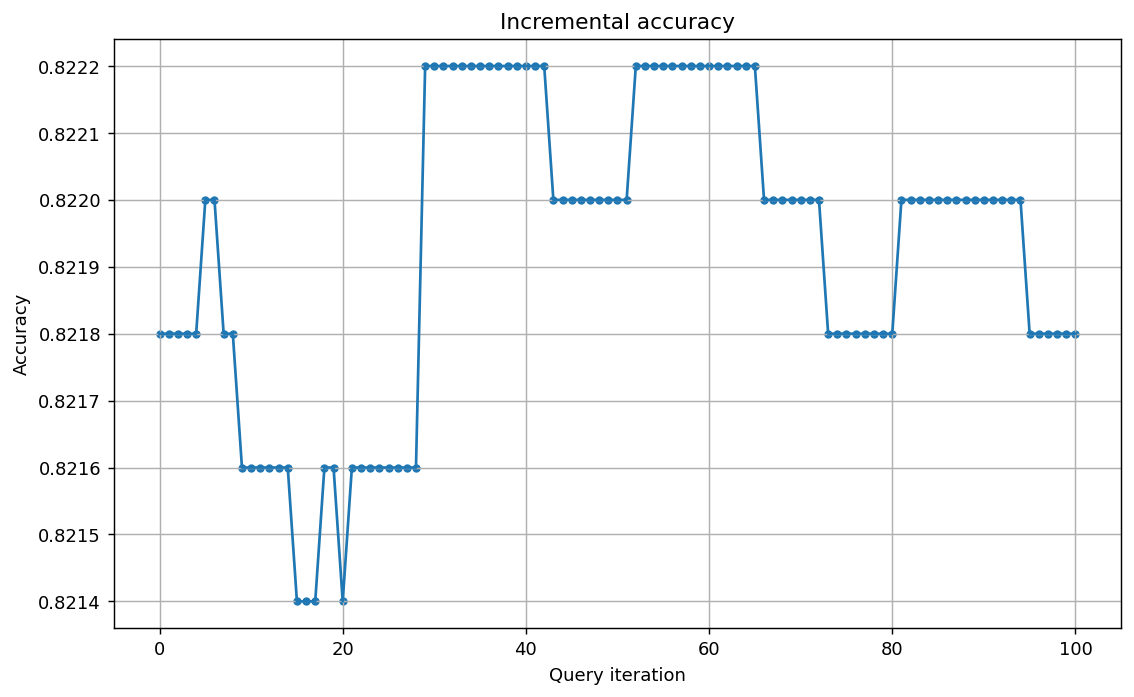

In [ ]:
# learner curve
plot_performance_model(history_dw_knn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_knn_dw = accuracy_score(y_train_new,y_pred_train)
f1_knn_dw = f1_score(y_train_new, y_pred_train, average="macro")
prec_knn_dw = precision_score(y_train_new, y_pred_train, average="macro")
rec_knn_dw = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_knn_dw)
print("f1 score : ",f1_knn_dw)
print("precision score : ",prec_knn_dw)
print("recall score : ",rec_knn_dw)


accuracy score :  0.8218
f1 score :  0.7866702063610204
precision score :  0.7942792775808762
recall score :  0.7805306310186977


In [ ]:
# AUC on train set
auc_knn_dw = roc_auc_score(y_train_new,y_pred_train)
auc_knn_dw

0.7805306310186977

Accuracy of knn classifier on test set: 0.82


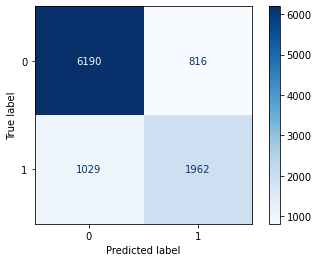

In [ ]:
# Check the performance on test set

print('Accuracy of knn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_knn_dw = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(knn, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_knn_dw = cm_knn_dw[0,0]
FP_knn_dw = cm_knn_dw[0,1]
TN_knn_dw = cm_knn_dw[1,0]
FN_knn_dw = cm_knn_dw[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_knn_dw_test = accuracy_score(y_test,y_pred_test)
f1_knn_dw_test = f1_score(y_test, y_pred_test, average="macro")
prec_knn_dw_test = precision_score(y_test, y_pred_test, average="macro")
rec_knn_dw_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_knn_dw_test)
print("f1 score : ",f1_knn_dw_test)
print("precision score : ",prec_knn_dw_test)
print("recall score : ",rec_knn_dw_test)

accuracy score :  0.815444633390017
f1 score :  0.7752429886299143
precision score :  0.7818614904213952
recall score :  0.7697481539680417


In [ ]:
# AUC on test
auc_knn_dw_test = roc_auc_score(y_test,y_pred_test)
auc_knn_dw_test

0.7697481539680417

##### **LR**

In [ ]:
# training the model
lr = LogisticRegression(C=lr_train.best_estimator_.C, max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )
learner = ActiveLearner(estimator=lr, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - lr: {initial_score}")

Prediction Accuracy - lr: 0.787


In [ ]:
# Add the centroids to the dataset
y_labels = learner.predict(kmeans.cluster_centers_)

In [ ]:
# learning process
num_of_queries = 100


history_dw_lr = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (density)


for i in range(num_of_queries):

  learner.teach(X=kmeans.cluster_centers_[i].reshape(1, -1),y=y_labels[i].reshape(1,))

  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=accuracy))

  history_dw_lr.append(accuracy)

Accuracy after query 1: 0.7870
Accuracy after query 2: 0.7870
Accuracy after query 3: 0.7870
Accuracy after query 4: 0.7870
Accuracy after query 5: 0.7872
Accuracy after query 6: 0.7872
Accuracy after query 7: 0.7870
Accuracy after query 8: 0.7872
Accuracy after query 9: 0.7872
Accuracy after query 10: 0.7874
Accuracy after query 11: 0.7872
Accuracy after query 12: 0.7872
Accuracy after query 13: 0.7872
Accuracy after query 14: 0.7872
Accuracy after query 15: 0.7870
Accuracy after query 16: 0.7870
Accuracy after query 17: 0.7872
Accuracy after query 18: 0.7872
Accuracy after query 19: 0.7872
Accuracy after query 20: 0.7872
Accuracy after query 21: 0.7872
Accuracy after query 22: 0.7872
Accuracy after query 23: 0.7870
Accuracy after query 24: 0.7870
Accuracy after query 25: 0.7868
Accuracy after query 26: 0.7870
Accuracy after query 27: 0.7872
Accuracy after query 28: 0.7874
Accuracy after query 29: 0.7872
Accuracy after query 30: 0.7874
Accuracy after query 31: 0.7874
Accuracy after qu

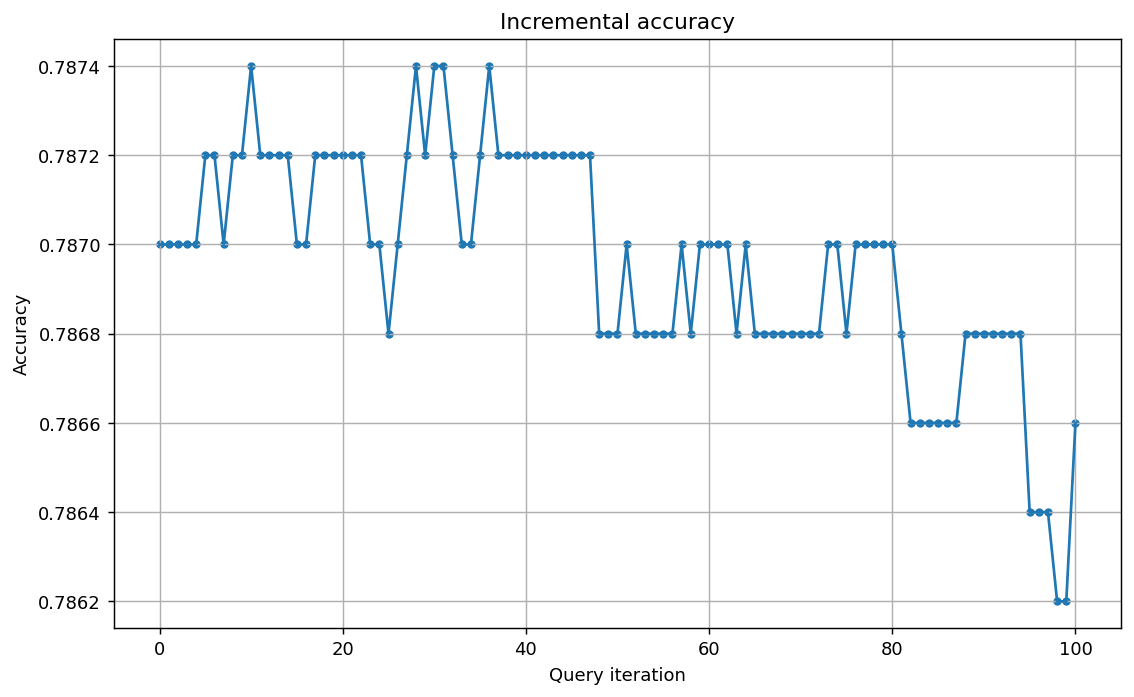

In [ ]:
# learner curve
plot_performance_model(history_dw_lr)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_lr_dw = accuracy_score(y_train_new,y_pred_train)
f1_lr_dw = f1_score(y_train_new, y_pred_train, average="macro")
prec_lr_dw = precision_score(y_train_new, y_pred_train, average="macro")
rec_lr_dw = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_lr_dw)
print("f1 score : ",f1_lr_dw)
print("precision score : ",prec_lr_dw)
print("recall score : ",rec_lr_dw)


accuracy score :  0.7866
f1 score :  0.7604852143055739
precision score :  0.7531155015725006
recall score :  0.7730644085476202


In [ ]:
# AUC on train
auc_lr_dw = roc_auc_score(y_train_new,y_pred_train)
auc_lr_dw

0.7730644085476202

Accuracy of lr classifier on test set: 0.79


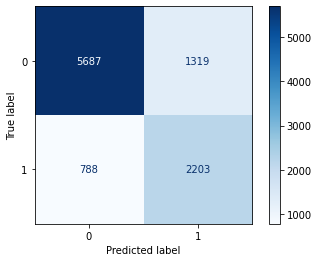

In [ ]:
# Check the performance on test set

print('Accuracy of lr classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_lr_dw = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(lr, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_lr_dw = cm_lr_dw[0,0]
FP_lr_dw = cm_lr_dw[0,1]
FN_lr_dw = cm_lr_dw[1,0]
TN_lr_dw = cm_lr_dw[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_lr_dw_test = accuracy_score(y_test,y_pred_test)
f1_lr_dw_test = f1_score(y_test, y_pred_test, average="macro")
prec_lr_dw_test = precision_score(y_test, y_pred_test, average="macro")
rec_lr_dw_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_lr_dw_test)
print("f1 score : ",f1_lr_dw_test)
print("precision score : ",prec_lr_dw_test)
print("recall score : ",rec_lr_dw_test)

accuracy score :  0.7892367710313094
f1 score :  0.7600995620212732
precision score :  0.751899017537859
recall score :  0.7741378813383724


In [ ]:
# compute AUC on test set
auc_lr_dw_test = roc_auc_score(y_test,y_pred_test)
auc_lr_dw_test

0.7741378813383724

##### **NB**

In [ ]:
# training the model
gm = GaussianNB()
learner = ActiveLearner(estimator=gm, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - gm: {initial_score}")

Prediction Accuracy - gm: 0.7966


In [ ]:
# Add the centroids to the dataset
y_labels = learner.predict(kmeans.cluster_centers_)

In [ ]:
# learner process
num_of_queries = 100


history_dw_gm = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (density)


for i in range(num_of_queries):

  learner.teach(X=kmeans.cluster_centers_[i].reshape(1, -1),y=y_labels[i].reshape(1,))

  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=accuracy))

  history_dw_gm.append(accuracy)

Accuracy after query 1: 0.7966
Accuracy after query 2: 0.7966
Accuracy after query 3: 0.7968
Accuracy after query 4: 0.7968
Accuracy after query 5: 0.7962
Accuracy after query 6: 0.7964
Accuracy after query 7: 0.7966
Accuracy after query 8: 0.7964
Accuracy after query 9: 0.7964
Accuracy after query 10: 0.7964
Accuracy after query 11: 0.7964
Accuracy after query 12: 0.7962
Accuracy after query 13: 0.7964
Accuracy after query 14: 0.7964
Accuracy after query 15: 0.7962
Accuracy after query 16: 0.7962
Accuracy after query 17: 0.7962
Accuracy after query 18: 0.7962
Accuracy after query 19: 0.7964
Accuracy after query 20: 0.7962
Accuracy after query 21: 0.7962
Accuracy after query 22: 0.7962
Accuracy after query 23: 0.7964
Accuracy after query 24: 0.7964
Accuracy after query 25: 0.7960
Accuracy after query 26: 0.7960
Accuracy after query 27: 0.7962
Accuracy after query 28: 0.7962
Accuracy after query 29: 0.7960
Accuracy after query 30: 0.7960
Accuracy after query 31: 0.7962
Accuracy after qu

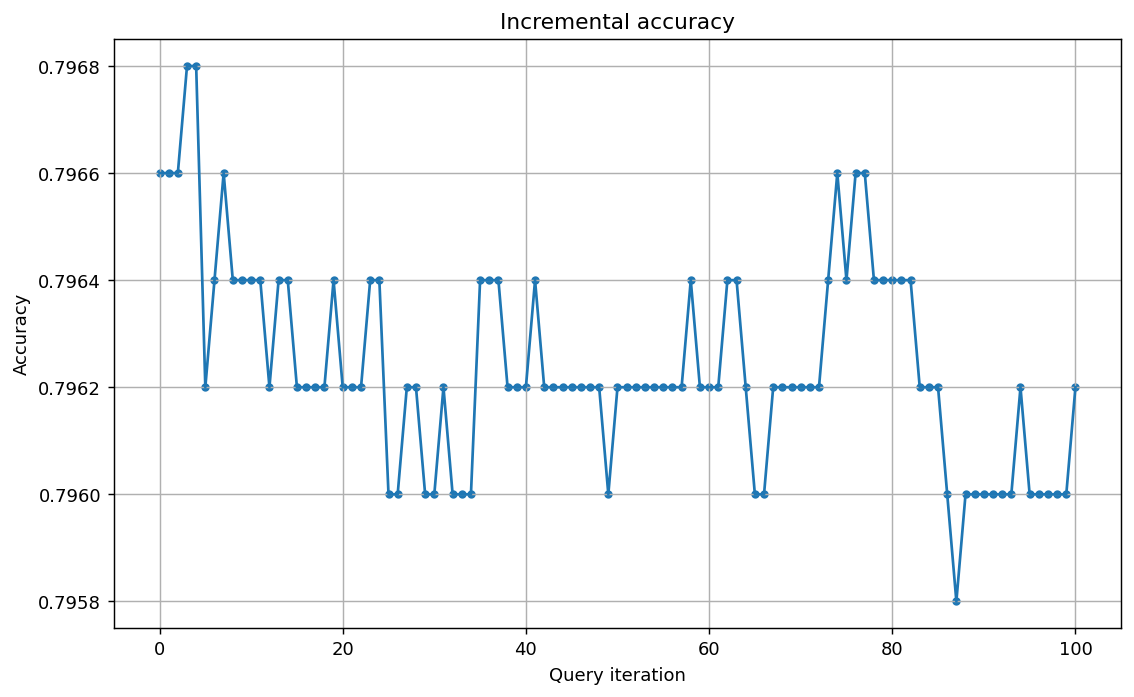

In [ ]:
# learner curve
plot_performance_model(history_dw_gm)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_gm_dw = accuracy_score(y_train_new,y_pred_train)
f1_gm_dw = f1_score(y_train_new, y_pred_train, average="macro")
prec_gm_dw = precision_score(y_train_new, y_pred_train, average="macro")
rec_gm_dw = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_gm_dw)
print("f1 score : ",f1_gm_dw)
print("precision score : ",prec_gm_dw)
print("recall score : ",rec_gm_dw)


accuracy score :  0.7962
f1 score :  0.7653482832498144
precision score :  0.7615889953542393
recall score :  0.7698458251174559


In [ ]:
# AUC on train set
auc_gm_dw = roc_auc_score(y_train_new,y_pred_train)
auc_gm_dw

0.7698458251174559

Accuracy of gm classifier on test set: 0.80


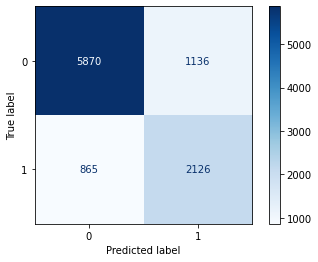

In [ ]:
# Check the performance on test set

print('Accuracy of gm classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_gm_dw = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(gm, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_gm_dw = cm_gm_dw[0,0]
FP_gm_dw = cm_gm_dw[0,1]
FN_gm_dw = cm_gm_dw[1,0]
TN_gm_dw = cm_gm_dw[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_gm_dw_test = accuracy_score(y_test,y_pred_test)
f1_gm_dw_test = f1_score(y_test, y_pred_test, average="macro")
prec_gm_dw_test = precision_score(y_test, y_pred_test, average="macro")
rec_gm_dw_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_gm_dw_test)
print("f1 score : ",f1_gm_dw_test)
print("precision score : ",prec_gm_dw_test)
print("recall score : ",rec_gm_dw_test)

accuracy score :  0.7998399519855957
f1 score :  0.7671855068696638
precision score :  0.7616569190930911
recall score :  0.7743261662425663


In [ ]:
# AUC on test set
auc_gm_dw_test = roc_auc_score(y_test,y_pred_test)
auc_gm_dw_test

0.7743261662425663

##### **DT**

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8)
learner = ActiveLearner(estimator=tree, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - dt: {initial_score}")

Prediction Accuracy - dt: 0.8594


In [ ]:
# Add the centroids to the dataset
y_labels = learner.predict(kmeans.cluster_centers_)

In [ ]:
# learning process
num_of_queries = 100

history_dt_dw = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (density)


for i in range(num_of_queries):

  learner.teach(X=kmeans.cluster_centers_[i].reshape(1, -1),y=y_labels[i].reshape(1,))

  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=accuracy))

  history_dt_dw.append(accuracy)

Accuracy after query 1: 0.8594
Accuracy after query 2: 0.8594
Accuracy after query 3: 0.8594
Accuracy after query 4: 0.8594
Accuracy after query 5: 0.8592
Accuracy after query 6: 0.8592
Accuracy after query 7: 0.8592
Accuracy after query 8: 0.8592
Accuracy after query 9: 0.8592
Accuracy after query 10: 0.8592
Accuracy after query 11: 0.8592
Accuracy after query 12: 0.8592
Accuracy after query 13: 0.8592
Accuracy after query 14: 0.8592
Accuracy after query 15: 0.8592
Accuracy after query 16: 0.8592
Accuracy after query 17: 0.8592
Accuracy after query 18: 0.8592
Accuracy after query 19: 0.8592
Accuracy after query 20: 0.8592
Accuracy after query 21: 0.8592
Accuracy after query 22: 0.8592
Accuracy after query 23: 0.8592
Accuracy after query 24: 0.8592
Accuracy after query 25: 0.8592
Accuracy after query 26: 0.8592
Accuracy after query 27: 0.8592
Accuracy after query 28: 0.8592
Accuracy after query 29: 0.8592
Accuracy after query 30: 0.8592
Accuracy after query 31: 0.8592
Accuracy after qu

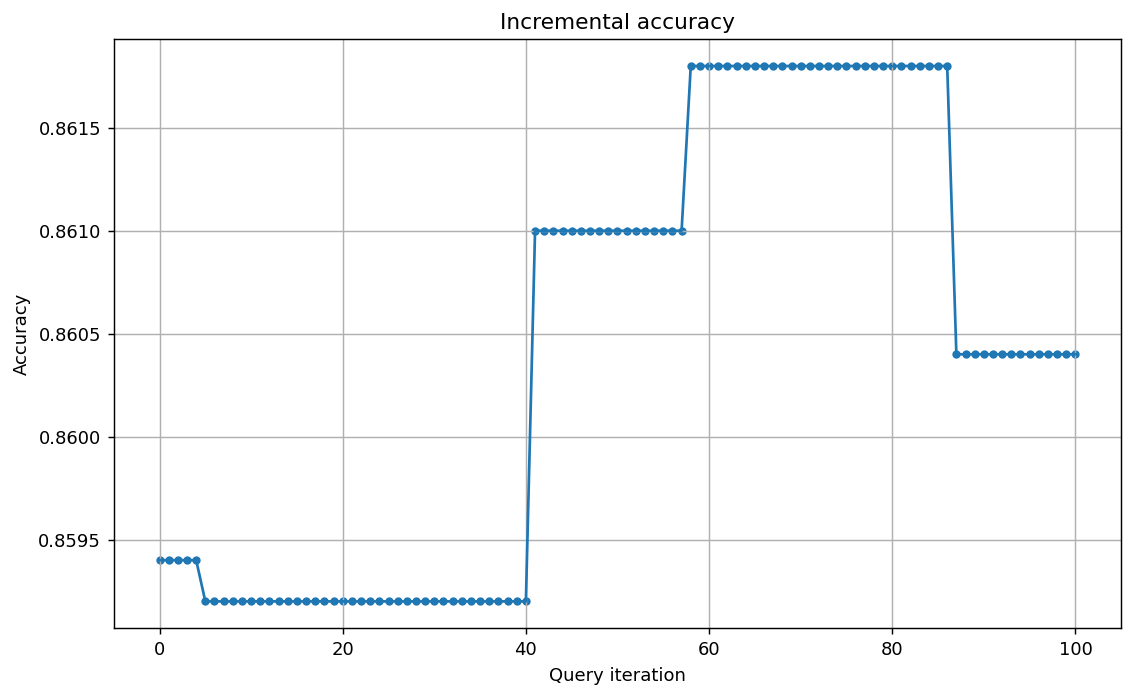

In [ ]:
# learner curve
plot_performance_model(history_dt_dw)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_dt_dw = accuracy_score(y_train_new,y_pred_train)
f1_dt_dw = f1_score(y_train_new, y_pred_train, average="macro")
prec_dt_dw = precision_score(y_train_new, y_pred_train, average="macro")
rec_dt_dw = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_dt_dw)
print("f1 score : ",f1_dt_dw)
print("precision score : ",prec_dt_dw)
print("recall score : ",rec_dt_dw)


accuracy score :  0.8604
f1 score :  0.8363137365699878
precision score :  0.8370470644086279
recall score :  0.8355948407565927


In [ ]:
# AUC on train set
auc_dt_dw = roc_auc_score(y_train_new,y_pred_train)
auc_dt_dw

0.8355948407565927

Accuracy of dt classifier on test set: 0.80


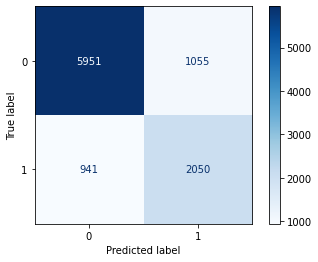

In [ ]:
# Check the performance on test set

print('Accuracy of dt classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_dt_dw = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(tree, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_dt_dw = cm_dt_dw[0,0]
FP_dt_dw = cm_dt_dw[0,1]
FN_dt_dw = cm_dt_dw[1,0]
TN_dt_dw = cm_dt_dw[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_dt_dw_test = accuracy_score(y_test,y_pred_test)
f1_dt_dw_test = f1_score(y_test, y_pred_test, average="macro")
prec_dt_dw_test = precision_score(y_test, y_pred_test, average="macro")
rec_dt_dw_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_dt_dw_test)
print("f1 score : ",f1_dt_dw_test)
print("precision score : ",prec_dt_dw_test)
print("recall score : ",rec_dt_dw_test)

accuracy score :  0.8003401020306092
f1 score :  0.7644771958728932
precision score :  0.7618451648297216
recall score :  0.7674021445819998


In [ ]:
# AUC on test set
auc_dt_dw_test = roc_auc_score(y_test,y_pred_test)
auc_dt_dw_test

0.7674021445819998

##### **NN**

In [ ]:
mlp_nn = MLPClassifier(hidden_layer_sizes=nn_train.best_estimator_.hidden_layer_sizes,
                       learning_rate_init=nn_train.best_estimator_.learning_rate_init
                       ,solver = 'adam', random_state = seed, max_iter = 1000 )

learner = ActiveLearner(estimator=mlp_nn, query_strategy=uncertainty_sampling, X_training=X_train_new, y_training=y_train_new)
initial_score = learner.score(X_train_new, y_train_new)

print(f"Prediction Accuracy - nn: {initial_score}")


Prediction Accuracy - nn: 0.8142


In [ ]:
# Add the centroids to the dataset
y_labels = learner.predict(kmeans.cluster_centers_)

In [ ]:
# Learning process
num_of_queries = 100

history_dw_nn = [initial_score]

# Allow the model to query the set of rejected applications for the most informative
# points according to the querying strategy (density)


for i in range(num_of_queries):

  learner.teach(X=kmeans.cluster_centers_[i].reshape(1, -1),y=y_labels[i].reshape(1,))

  accuracy = learner.score(X_train_new,y_train_new)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=i + 1, acc=accuracy))

  history_dw_nn.append(accuracy)

Accuracy after query 1: 0.8080
Accuracy after query 2: 0.8138
Accuracy after query 3: 0.8110
Accuracy after query 4: 0.8146
Accuracy after query 5: 0.8130
Accuracy after query 6: 0.8202
Accuracy after query 7: 0.8128
Accuracy after query 8: 0.8230
Accuracy after query 9: 0.8238
Accuracy after query 10: 0.8168
Accuracy after query 11: 0.8230
Accuracy after query 12: 0.8220
Accuracy after query 13: 0.8198
Accuracy after query 14: 0.8222
Accuracy after query 15: 0.8258
Accuracy after query 16: 0.8190
Accuracy after query 17: 0.8238
Accuracy after query 18: 0.8194
Accuracy after query 19: 0.8112
Accuracy after query 20: 0.8236
Accuracy after query 21: 0.8210
Accuracy after query 22: 0.8188
Accuracy after query 23: 0.8162
Accuracy after query 24: 0.8200
Accuracy after query 25: 0.8180
Accuracy after query 26: 0.8186
Accuracy after query 27: 0.8194
Accuracy after query 28: 0.8196
Accuracy after query 29: 0.8208
Accuracy after query 30: 0.8258
Accuracy after query 31: 0.8234
Accuracy after qu

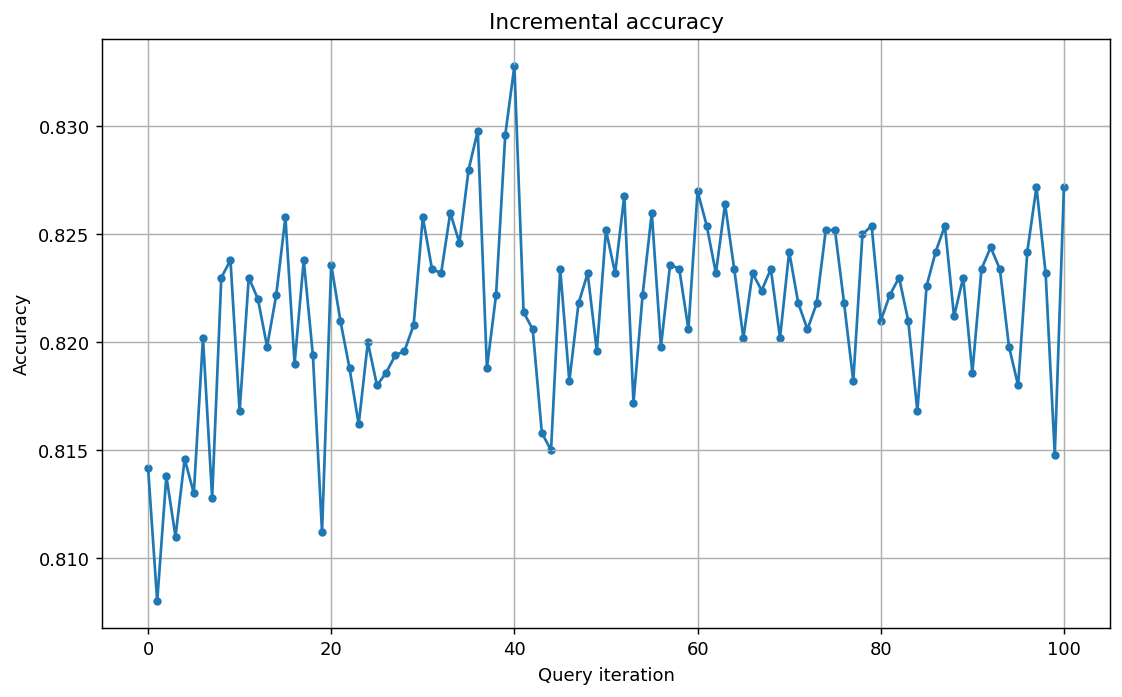

In [ ]:
# learner curve
plot_performance_model(history_dw_nn)

In [ ]:
# prediction
y_pred_train = learner.predict(X_train_new)

In [ ]:
# compute f1-score, precision_score and recall_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
acc_nn_dw = accuracy_score(y_train_new,y_pred_train)
f1_nn_dw = f1_score(y_train_new, y_pred_train, average="macro")
prec_nn_dw = precision_score(y_train_new, y_pred_train, average="macro")
rec_nn_dw = recall_score(y_train_new, y_pred_train, average="macro")
print("accuracy score : ",acc_nn_dw)
print("f1 score : ",f1_nn_dw)
print("precision score : ",prec_nn_dw)
print("recall score : ",rec_nn_dw)


accuracy score :  0.8272
f1 score :  0.7982511739259817
precision score :  0.7976247264666226
recall score :  0.7988910460929677


In [ ]:
# AUC on train set
auc_nn_dw = roc_auc_score(y_train_new,y_pred_train)
auc_nn_dw

0.7988910460929677

Accuracy of nn classifier on test set: 0.82


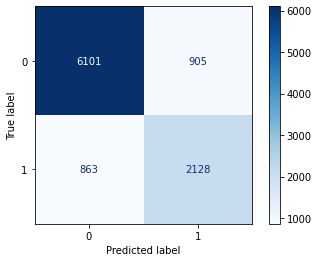

In [ ]:
# Check the performance on test set

print('Accuracy of nn classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))
# compute confusion matrix on test set
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_nn_dw = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(mlp_nn, X_test, y_test, values_format=".4g", cmap="Blues")
plt.grid(False)

In [ ]:
# confusion matrix
TP_nn_dw = cm_nn_dw[0,0]
FP_nn_dw = cm_nn_dw[0,1]
FN_nn_dw = cm_nn_dw[1,0]
TN_nn_dw = cm_nn_dw[1,1]

In [ ]:
# compute f1-score, recall, and precision score
acc_nn_dw_test = accuracy_score(y_test,y_pred_test)
f1_nn_dw_test = f1_score(y_test, y_pred_test, average="macro")
prec_nn_dw_test = precision_score(y_test, y_pred_test, average="macro")
rec_nn_dw_test = recall_score(y_test, y_pred_test, average="macro")
print("accuracy score : ",acc_nn_dw_test)
print("f1 score : ",f1_nn_dw_test)
print("precision score : ",prec_nn_dw_test)
print("recall score : ",rec_nn_dw_test)

accuracy score :  0.823146944083225
f1 score :  0.789975198228798
precision score :  0.788846264704941
recall score :  0.791146371839851


In [ ]:
# AUC on test set
auc_nn_dw_test = roc_auc_score(y_test,y_pred_test)
auc_nn_dw_test

0.791146371839851

#### **Evaluation metrics table**

In [ ]:
# Creating performance table of train
results_p = {'Classifier': ['Acc (train)','AUC (train)'],
            'Logistic Regression (LR)': [acc_lr_dw, auc_lr_dw],
            'K Nearest Neighbour (KNN)': [acc_knn_dw, auc_knn_dw],
            'Support Vector Machine (SVC)': [acc_svc_dw, auc_svc_dw],
            'Decision Trees (DT)': [acc_dt_dw, auc_dt_dw],
            'Naive Bayes (NB)': [acc_gm_dw, auc_gm_dw],
            'Neural Networks (NN)': [acc_nn_dw, auc_nn_dw]
             }
dfp = pd.DataFrame(results_p, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_p = dfp.T
results_p

Classifier                    Acc (train)  AUC (train)
Logistic Regression (LR)           0.7866     0.773064
K Nearest Neighbour (KNN)          0.8218     0.780530
Support Vector Machine (SVC)       0.7884     0.772048
Decision Trees (DT)                0.8604     0.835595
Naive Bayes (NB)                   0.7962     0.769846
Neural Networks (NN)               0.8272     0.798891

In [ ]:
# Creating performance table of test
results_p = {'Classifier': ['Acc (test)','AUC (test)'],
            'Logistic Regression (LR)': [acc_lr_dw_test, auc_lr_dw_test],
            'K Nearest Neighbour (KNN)': [acc_knn_dw_test, auc_knn_dw_test],
            'Support Vector Machine (SVC)': [acc_svc_dw_test, auc_svc_dw_test],
            'Decision Trees (DT)': [acc_dt_dw_test, auc_dt_dw_test],
            'Naive Bayes (NB)': [acc_gm_dw_test, auc_gm_dw_test],
            'Neural Networks (NN)': [acc_nn_dw_test, auc_nn_dw_test]
             }
dfp = pd.DataFrame(results_p, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
dfp.set_index("Classifier", inplace=True)

results_p = dfp.T
results_p

Classifier                    Acc (test)  AUC (test)
Logistic Regression (LR)        0.789237    0.774138
K Nearest Neighbour (KNN)       0.815445    0.769748
Support Vector Machine (SVC)    0.793238    0.775077
Decision Trees (DT)             0.800340    0.767402
Naive Bayes (NB)                0.799840    0.774326
Neural Networks (NN)            0.823147    0.791146

In [ ]:
# Creating confusion matrix table
results = {'Classifier': ['TP','FP', 'TN', 'FN'],
            'Logistic Regression (LR)': [TP_lr_dw, FP_lr_dw, TN_lr_dw, FN_lr_dw],
            'K Nearest Neighbour (KNN)': [TP_knn_dw, FP_knn_dw, TN_knn_dw, FN_knn_dw],
            'Support Vector Machine (SVC)': [TP_svc_dw, FP_svc_dw, TN_svc_dw, FN_svc_dw],
            'Decision Trees (DT)': [TP_dt_dw, FP_dt_dw, TN_dt_dw, FN_dt_dw],
            'Naive Bayes (NB)': [TP_gm_dw, FP_gm_dw, TN_gm_dw, FN_gm_dw],
            'Neural Networks (NN)': [TP_nn_dw, FP_nn_dw, TN_nn_dw,FN_nn_dw]
           }

tcm = pd.DataFrame(results, columns = ['Classifier', 
                                     'Logistic Regression (LR)',
                                     'K Nearest Neighbour (KNN)',
                                     'Support Vector Machine (SVC)',
                                     'Decision Trees (DT)',
                                     'Naive Bayes (NB)',
                                     'Neural Networks (NN)'
                                        ])
tcm.set_index("Classifier", inplace=True)

results = tcm.T
results

Classifier                      TP    FP    TN    FN
Logistic Regression (LR)      5687  1319  2203   788
K Nearest Neighbour (KNN)     6190   816  1029  1962
Support Vector Machine (SVC)  5747  1259  2183   808
Decision Trees (DT)           5951  1055  2050   941
Naive Bayes (NB)              5870  1136  2126   865
Neural Networks (NN)          6101   905  2128   863

# **Reference**

https://modal-python.readthedocs.io/en/latest/content/examples/pool-based_sampling.html

https://modal-python.readthedocs.io/en/latest/content/examples/stream-based_sampling.html

https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html

https://modal-python.readthedocs.io/en/latest/content/examples/query_by_committee.html

https://github.com/ntucllab/libact

https://github.com/mossydidar/Credit-Score-Modeling-using-Machine-Learning#start-of-content

https://github.com/nickr007/Bank-Marketing